In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

!pip install --upgrade pip
!pip install sentencepiece
import sentencepiece
import tensorflow as tf
from transformers import XLMRobertaTokenizer, BertTokenizer, TFBertModel, TFXLMRobertaModel

from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve, classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.8 MB ? eta -:--:--

     ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/1.8 MB 1.5 MB/s eta 0:00:02

     ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.2/1.8 MB 2.6 MB/s eta 0:00:01

     ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.5/1.8 MB 3.8 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.8/1.8 MB 9.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.1 MB/s eta 0:00:00


  Attempting uninstall: pip
    Found existing installation: pip 23.0.1


    Uninstalling pip-23.0.1:


      Successfully uninstalled pip-23.0.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.3 MB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.2 MB/s eta 0:00:00


E0000 00:00:1722440073.030292      77 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D0731 15:34:33.038548824      77 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0731 15:34:33.038563666      77 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0731 15:34:33.038567193      77 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0731 15:34:33.038569677      77 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0731 15:34:33.038572101      77 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("../input/emotional-classification/dev_data.csv")
# data = pd.read_csv("../data/dev_data.csv")
label_map = {value:key for key,value in 
             data['label'].drop_duplicates().reset_index(drop= True).to_dict().items()}
data['label'] = data['label'].map(label_map)

data.head()

,text,label
0,i usually wear my hair in a twist out and when...,0
1,i feel so irritated and rejected by it or is g...,1
2,i can feel it disturbed within me,2
3,im talking about down right i feel like slappi...,1
4,i almost feel like im messing with a precious ...,0


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')

In [4]:
# setting up a TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

I0000 00:00:1722440108.760404      77 service.cc:145] XLA service 0x5d368c2eb180 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722440108.760458      77 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1722440108.760462      77 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1722440108.760465      77 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1722440108.760468      77 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1722440108.760471      77 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1722440108.760473      77 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1722440108.760476      77 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1722440108.760479      77 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


In [5]:
model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).


All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [6]:
def encode_sentence(ss, max_len= 10):
    tokens = tokens = ['[CLS]'] + tokenizer.tokenize(ss) + ['[SEP]']
    if max_len > len(tokens):
        # PAD tensor
        tokens=tokens +['[PAD]' for _ in range(max_len-len(tokens))]  
    return tokenizer.convert_tokens_to_ids(tokens[:max_len])

def bert_encode(sentences, tokenizer, max_len= 10):
        
    input_word_ids = tf.convert_to_tensor([encode_sentence(ss, max_len) for ss in sentences])
    input_mask = tf.cast(tf.convert_to_tensor([encode_sentence(ss, max_len) 
                                               for ss in sentences])>0, tf.int32)
    input_type_ids = tf.zeros_like(input_word_ids)
    
    inputs = {
      'input_word_ids': input_word_ids,
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}
    
    return inputs

In [7]:
def build_model(max_len):
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    
    maxpool = tf.keras.layers.GlobalAveragePooling1D(name= 'maxpool')(embedding)
    output = tf.keras.layers.Dense(6, activation='softmax')(maxpool)
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:
max_len= 50
with strategy.scope():
    model = build_model(max_len)
    model.summary()

I0000 00:00:1722440117.738902      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).


All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"


__________________________________________________________________________________________________


 Layer (type)                Output Shape                 Param #   Connected to                  


 input_word_ids (InputLayer  [(None, 50)]                 0         []                            


 )                                                                                                


 input_mask (InputLayer)     [(None, 50)]                 0         []                            


 input_type_ids (InputLayer  [(None, 50)]                 0         []                            


 )                                                                                                


 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1083102   ['input_word_ids[0][0]',      


 el)                         ngAndCrossAttentions(last_   72         'input_mask[0][0]',          


                             hidden_state=(None, 50, 76              'input_type_ids[0][0]']      


                             8),                                                                  


                              pooler_output=(None, 768)                                           


                             , past_key_values=None, hi                                           


                             dden_states=None, attentio                                           


                             ns=None, cross_attentions=                                           


                             None)                                                                


 maxpool (GlobalAveragePool  (None, 768)                  0         ['tf_bert_model_1[0][0]']     


 ing1D)                                                                                           


 dense (Dense)               (None, 6)                    4614      ['maxpool[0][0]']             


Total params: 108314886 (413.19 MB)


Trainable params: 108314886 (413.19 MB)


Non-trainable params: 0 (0.00 Byte)


__________________________________________________________________________________________________


In [9]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], 
                                                    train_size= int(1e5), stratify= data['label'])

In [10]:
train_input = bert_encode(X_train, tokenizer, max_len)
# test_input = bert_encode(X_test, tokenizer, max_len)

In [11]:
history = model.fit(train_input, y_train.values, epochs = 5, verbose = 1, 
                    validation_split = 0.2, batch_size= 64)

Epoch 1/5


2024-07-31 15:37:38.230437: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


I0000 00:00:1722440260.210191     914 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(81ba79daf4fcab45:0:0), session_name()


I0000 00:00:1722440287.128117     914 tpu_compile_op_common.cc:245] Compilation of 81ba79daf4fcab45:0:0 with session name  took 26.917881854s and succeeded
I0000 00:00:1722440287.193734     914 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(81ba79daf4fcab45:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_13980405344634056525", property.function_library_fingerprint = 3666206981080404943, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722440287.193791     914 tpu_compilation_cache_interface.cc:541] After adding entry for key 81ba79daf4fcab45:0:0 wit

   1/1250 [..............................] - ETA: 27:42:21 - loss: 2.0647 - accuracy: 0.0781

   2/1250 [..............................] - ETA: 1:48 - loss: 2.0196 - accuracy: 0.1328    

   3/1250 [..............................] - ETA: 1:36 - loss: 1.9507 - accuracy: 0.1979

   4/1250 [..............................] - ETA: 1:32 - loss: 1.9050 - accuracy: 0.2305

   5/1250 [..............................] - ETA: 1:30 - loss: 1.8624 - accuracy: 0.2625

   6/1250 [..............................] - ETA: 1:29 - loss: 1.8261 - accuracy: 0.2812

   7/1250 [..............................] - ETA: 1:28 - loss: 1.7967 - accuracy: 0.2991

   8/1250 [..............................] - ETA: 1:27 - loss: 1.7821 - accuracy: 0.2910

   9/1250 [..............................] - ETA: 1:26 - loss: 1.7612 - accuracy: 0.3003

  10/1250 [..............................] - ETA: 1:26 - loss: 1.7395 - accuracy: 0.2938

  11/1250 [..............................] - ETA: 1:26 - loss: 1.7257 - accuracy: 0.3040

  12/1250 [..............................] - ETA: 1:25 - loss: 1.7118 - accuracy: 0.3112

  13/1250 [..............................] - ETA: 1:24 - loss: 1.7030 - accuracy: 0.3161

  14/1250 [..............................] - ETA: 1:24 - loss: 1.6965 - accuracy: 0.3237

  15/1250 [..............................] - ETA: 1:24 - loss: 1.6869 - accuracy: 0.3229

  16/1250 [..............................] - ETA: 1:24 - loss: 1.6771 - accuracy: 0.3311

  17/1250 [..............................] - ETA: 1:23 - loss: 1.6675 - accuracy: 0.3373

  18/1250 [..............................] - ETA: 1:23 - loss: 1.6595 - accuracy: 0.3403

  19/1250 [..............................] - ETA: 1:23 - loss: 1.6557 - accuracy: 0.3454

  20/1250 [..............................] - ETA: 1:23 - loss: 1.6488 - accuracy: 0.3531

  21/1250 [..............................] - ETA: 1:23 - loss: 1.6395 - accuracy: 0.3624

  22/1250 [..............................] - ETA: 1:22 - loss: 1.6404 - accuracy: 0.3651

  23/1250 [..............................] - ETA: 1:22 - loss: 1.6388 - accuracy: 0.3675

  24/1250 [..............................] - ETA: 1:22 - loss: 1.6348 - accuracy: 0.3724

  25/1250 [..............................] - ETA: 1:22 - loss: 1.6320 - accuracy: 0.3725

  26/1250 [..............................] - ETA: 1:21 - loss: 1.6282 - accuracy: 0.3756

  27/1250 [..............................] - ETA: 1:21 - loss: 1.6228 - accuracy: 0.3814

  28/1250 [..............................] - ETA: 1:21 - loss: 1.6224 - accuracy: 0.3856

  29/1250 [..............................] - ETA: 1:21 - loss: 1.6200 - accuracy: 0.3863

  30/1250 [..............................] - ETA: 1:21 - loss: 1.6154 - accuracy: 0.3870

  31/1250 [..............................] - ETA: 1:21 - loss: 1.6071 - accuracy: 0.3906

  32/1250 [..............................] - ETA: 1:20 - loss: 1.6001 - accuracy: 0.3931

  33/1250 [..............................] - ETA: 1:20 - loss: 1.5950 - accuracy: 0.3935

  34/1250 [..............................] - ETA: 1:20 - loss: 1.5928 - accuracy: 0.3915

  35/1250 [..............................] - ETA: 1:20 - loss: 1.5876 - accuracy: 0.3938

  36/1250 [..............................] - ETA: 1:20 - loss: 1.5834 - accuracy: 0.3937

  37/1250 [..............................] - ETA: 1:20 - loss: 1.5791 - accuracy: 0.3948

  38/1250 [..............................] - ETA: 1:20 - loss: 1.5759 - accuracy: 0.3968

  39/1250 [..............................] - ETA: 1:20 - loss: 1.5686 - accuracy: 0.4010

  40/1250 [..............................] - ETA: 1:19 - loss: 1.5673 - accuracy: 0.4016

  41/1250 [..............................] - ETA: 1:19 - loss: 1.5618 - accuracy: 0.4036

  42/1250 [>.............................] - ETA: 1:19 - loss: 1.5585 - accuracy: 0.4066

  43/1250 [>.............................] - ETA: 1:19 - loss: 1.5530 - accuracy: 0.4102

  44/1250 [>.............................] - ETA: 1:19 - loss: 1.5464 - accuracy: 0.4141

  45/1250 [>.............................] - ETA: 1:19 - loss: 1.5385 - accuracy: 0.4174

  46/1250 [>.............................] - ETA: 1:19 - loss: 1.5329 - accuracy: 0.4192

  47/1250 [>.............................] - ETA: 1:19 - loss: 1.5299 - accuracy: 0.4202

  48/1250 [>.............................] - ETA: 1:19 - loss: 1.5241 - accuracy: 0.4219

  49/1250 [>.............................] - ETA: 1:19 - loss: 1.5200 - accuracy: 0.4232

  50/1250 [>.............................] - ETA: 1:19 - loss: 1.5157 - accuracy: 0.4244

  51/1250 [>.............................] - ETA: 1:18 - loss: 1.5131 - accuracy: 0.4274

  52/1250 [>.............................] - ETA: 1:18 - loss: 1.5108 - accuracy: 0.4279

  53/1250 [>.............................] - ETA: 1:18 - loss: 1.5040 - accuracy: 0.4310

  54/1250 [>.............................] - ETA: 1:18 - loss: 1.4994 - accuracy: 0.4334

  55/1250 [>.............................] - ETA: 1:18 - loss: 1.4919 - accuracy: 0.4364

  56/1250 [>.............................] - ETA: 1:18 - loss: 1.4848 - accuracy: 0.4400

  57/1250 [>.............................] - ETA: 1:18 - loss: 1.4776 - accuracy: 0.4435

  58/1250 [>.............................] - ETA: 1:18 - loss: 1.4737 - accuracy: 0.4445

  59/1250 [>.............................] - ETA: 1:18 - loss: 1.4671 - accuracy: 0.4468

  60/1250 [>.............................] - ETA: 1:18 - loss: 1.4582 - accuracy: 0.4503

  61/1250 [>.............................] - ETA: 1:18 - loss: 1.4526 - accuracy: 0.4524

  62/1250 [>.............................] - ETA: 1:17 - loss: 1.4507 - accuracy: 0.4526

  63/1250 [>.............................] - ETA: 1:17 - loss: 1.4441 - accuracy: 0.4546

  64/1250 [>.............................] - ETA: 1:18 - loss: 1.4353 - accuracy: 0.4587

  65/1250 [>.............................] - ETA: 1:18 - loss: 1.4302 - accuracy: 0.4608

  66/1250 [>.............................] - ETA: 1:18 - loss: 1.4243 - accuracy: 0.4633

  67/1250 [>.............................] - ETA: 1:18 - loss: 1.4183 - accuracy: 0.4664

  68/1250 [>.............................] - ETA: 1:18 - loss: 1.4101 - accuracy: 0.4701

  69/1250 [>.............................] - ETA: 1:18 - loss: 1.4045 - accuracy: 0.4717

  70/1250 [>.............................] - ETA: 1:17 - loss: 1.3997 - accuracy: 0.4743

  71/1250 [>.............................] - ETA: 1:17 - loss: 1.3941 - accuracy: 0.4771

  72/1250 [>.............................] - ETA: 1:17 - loss: 1.3867 - accuracy: 0.4794

  73/1250 [>.............................] - ETA: 1:17 - loss: 1.3812 - accuracy: 0.4820

  74/1250 [>.............................] - ETA: 1:17 - loss: 1.3762 - accuracy: 0.4842

  75/1250 [>.............................] - ETA: 1:17 - loss: 1.3681 - accuracy: 0.4879

  76/1250 [>.............................] - ETA: 1:17 - loss: 1.3608 - accuracy: 0.4905

  77/1250 [>.............................] - ETA: 1:17 - loss: 1.3551 - accuracy: 0.4927

  78/1250 [>.............................] - ETA: 1:17 - loss: 1.3525 - accuracy: 0.4944

  79/1250 [>.............................] - ETA: 1:17 - loss: 1.3435 - accuracy: 0.4978

  80/1250 [>.............................] - ETA: 1:17 - loss: 1.3375 - accuracy: 0.5010

  81/1250 [>.............................] - ETA: 1:17 - loss: 1.3335 - accuracy: 0.5021

  82/1250 [>.............................] - ETA: 1:17 - loss: 1.3279 - accuracy: 0.5048

  83/1250 [>.............................] - ETA: 1:17 - loss: 1.3246 - accuracy: 0.5066

  84/1250 [=>............................] - ETA: 1:17 - loss: 1.3202 - accuracy: 0.5087

  85/1250 [=>............................] - ETA: 1:17 - loss: 1.3138 - accuracy: 0.5112

  86/1250 [=>............................] - ETA: 1:17 - loss: 1.3081 - accuracy: 0.5134

  87/1250 [=>............................] - ETA: 1:17 - loss: 1.3026 - accuracy: 0.5160

  88/1250 [=>............................] - ETA: 1:17 - loss: 1.2976 - accuracy: 0.5181

  89/1250 [=>............................] - ETA: 1:17 - loss: 1.2902 - accuracy: 0.5214

  90/1250 [=>............................] - ETA: 1:17 - loss: 1.2867 - accuracy: 0.5234

  91/1250 [=>............................] - ETA: 1:17 - loss: 1.2818 - accuracy: 0.5249

  92/1250 [=>............................] - ETA: 1:17 - loss: 1.2756 - accuracy: 0.5267

  93/1250 [=>............................] - ETA: 1:17 - loss: 1.2716 - accuracy: 0.5281

  94/1250 [=>............................] - ETA: 1:17 - loss: 1.2654 - accuracy: 0.5306

  95/1250 [=>............................] - ETA: 1:17 - loss: 1.2620 - accuracy: 0.5316

  96/1250 [=>............................] - ETA: 1:17 - loss: 1.2584 - accuracy: 0.5332

  97/1250 [=>............................] - ETA: 1:17 - loss: 1.2531 - accuracy: 0.5345

  98/1250 [=>............................] - ETA: 1:17 - loss: 1.2476 - accuracy: 0.5370

  99/1250 [=>............................] - ETA: 1:17 - loss: 1.2434 - accuracy: 0.5391

 100/1250 [=>............................] - ETA: 1:18 - loss: 1.2387 - accuracy: 0.5411

 101/1250 [=>............................] - ETA: 1:18 - loss: 1.2358 - accuracy: 0.5422

 102/1250 [=>............................] - ETA: 1:18 - loss: 1.2311 - accuracy: 0.5446

 103/1250 [=>............................] - ETA: 1:18 - loss: 1.2273 - accuracy: 0.5461

 104/1250 [=>............................] - ETA: 1:18 - loss: 1.2245 - accuracy: 0.5476

 105/1250 [=>............................] - ETA: 1:18 - loss: 1.2209 - accuracy: 0.5491

 106/1250 [=>............................] - ETA: 1:18 - loss: 1.2164 - accuracy: 0.5510

 107/1250 [=>............................] - ETA: 1:18 - loss: 1.2119 - accuracy: 0.5530

 108/1250 [=>............................] - ETA: 1:18 - loss: 1.2092 - accuracy: 0.5534

 109/1250 [=>............................] - ETA: 1:17 - loss: 1.2039 - accuracy: 0.5550

 110/1250 [=>............................] - ETA: 1:17 - loss: 1.1986 - accuracy: 0.5570

 111/1250 [=>............................] - ETA: 1:17 - loss: 1.1932 - accuracy: 0.5593

 112/1250 [=>............................] - ETA: 1:17 - loss: 1.1891 - accuracy: 0.5603

 113/1250 [=>............................] - ETA: 1:17 - loss: 1.1828 - accuracy: 0.5629

 114/1250 [=>............................] - ETA: 1:17 - loss: 1.1777 - accuracy: 0.5655

 115/1250 [=>............................] - ETA: 1:17 - loss: 1.1718 - accuracy: 0.5677

 116/1250 [=>............................] - ETA: 1:17 - loss: 1.1669 - accuracy: 0.5692

 117/1250 [=>............................] - ETA: 1:17 - loss: 1.1616 - accuracy: 0.5710

 118/1250 [=>............................] - ETA: 1:16 - loss: 1.1557 - accuracy: 0.5732

 119/1250 [=>............................] - ETA: 1:16 - loss: 1.1536 - accuracy: 0.5738

 120/1250 [=>............................] - ETA: 1:16 - loss: 1.1499 - accuracy: 0.5754

 121/1250 [=>............................] - ETA: 1:16 - loss: 1.1465 - accuracy: 0.5766

 122/1250 [=>............................] - ETA: 1:16 - loss: 1.1421 - accuracy: 0.5780

 123/1250 [=>............................] - ETA: 1:16 - loss: 1.1375 - accuracy: 0.5802

 124/1250 [=>............................] - ETA: 1:16 - loss: 1.1335 - accuracy: 0.5819

 125/1250 [==>...........................] - ETA: 1:16 - loss: 1.1285 - accuracy: 0.5836

 126/1250 [==>...........................] - ETA: 1:16 - loss: 1.1236 - accuracy: 0.5853

 127/1250 [==>...........................] - ETA: 1:16 - loss: 1.1199 - accuracy: 0.5865

 128/1250 [==>...........................] - ETA: 1:15 - loss: 1.1148 - accuracy: 0.5881

 129/1250 [==>...........................] - ETA: 1:15 - loss: 1.1099 - accuracy: 0.5901

 130/1250 [==>...........................] - ETA: 1:15 - loss: 1.1052 - accuracy: 0.5921

 131/1250 [==>...........................] - ETA: 1:15 - loss: 1.1010 - accuracy: 0.5935

 132/1250 [==>...........................] - ETA: 1:15 - loss: 1.0969 - accuracy: 0.5947

 133/1250 [==>...........................] - ETA: 1:15 - loss: 1.0919 - accuracy: 0.5965

 134/1250 [==>...........................] - ETA: 1:15 - loss: 1.0884 - accuracy: 0.5981

 135/1250 [==>...........................] - ETA: 1:15 - loss: 1.0833 - accuracy: 0.6000

 136/1250 [==>...........................] - ETA: 1:15 - loss: 1.0786 - accuracy: 0.6017

 137/1250 [==>...........................] - ETA: 1:15 - loss: 1.0747 - accuracy: 0.6030

 138/1250 [==>...........................] - ETA: 1:15 - loss: 1.0695 - accuracy: 0.6048

 139/1250 [==>...........................] - ETA: 1:14 - loss: 1.0653 - accuracy: 0.6063

 140/1250 [==>...........................] - ETA: 1:14 - loss: 1.0617 - accuracy: 0.6076

 141/1250 [==>...........................] - ETA: 1:14 - loss: 1.0572 - accuracy: 0.6090

 142/1250 [==>...........................] - ETA: 1:14 - loss: 1.0519 - accuracy: 0.6111

 143/1250 [==>...........................] - ETA: 1:14 - loss: 1.0481 - accuracy: 0.6122

 144/1250 [==>...........................] - ETA: 1:14 - loss: 1.0434 - accuracy: 0.6141

 145/1250 [==>...........................] - ETA: 1:14 - loss: 1.0393 - accuracy: 0.6152

 146/1250 [==>...........................] - ETA: 1:14 - loss: 1.0348 - accuracy: 0.6168

 147/1250 [==>...........................] - ETA: 1:14 - loss: 1.0323 - accuracy: 0.6181

 148/1250 [==>...........................] - ETA: 1:14 - loss: 1.0291 - accuracy: 0.6196

 149/1250 [==>...........................] - ETA: 1:14 - loss: 1.0242 - accuracy: 0.6214

 150/1250 [==>...........................] - ETA: 1:14 - loss: 1.0217 - accuracy: 0.6225

 151/1250 [==>...........................] - ETA: 1:13 - loss: 1.0176 - accuracy: 0.6243

 152/1250 [==>...........................] - ETA: 1:13 - loss: 1.0147 - accuracy: 0.6257

 153/1250 [==>...........................] - ETA: 1:13 - loss: 1.0113 - accuracy: 0.6269

 154/1250 [==>...........................] - ETA: 1:13 - loss: 1.0088 - accuracy: 0.6279

 155/1250 [==>...........................] - ETA: 1:13 - loss: 1.0052 - accuracy: 0.6292

 156/1250 [==>...........................] - ETA: 1:13 - loss: 1.0023 - accuracy: 0.6304

 157/1250 [==>...........................] - ETA: 1:13 - loss: 0.9980 - accuracy: 0.6320

 158/1250 [==>...........................] - ETA: 1:13 - loss: 0.9940 - accuracy: 0.6333

 159/1250 [==>...........................] - ETA: 1:13 - loss: 0.9922 - accuracy: 0.6340

 160/1250 [==>...........................] - ETA: 1:13 - loss: 0.9890 - accuracy: 0.6354

 161/1250 [==>...........................] - ETA: 1:13 - loss: 0.9862 - accuracy: 0.6365

 162/1250 [==>...........................] - ETA: 1:13 - loss: 0.9834 - accuracy: 0.6377

 163/1250 [==>...........................] - ETA: 1:13 - loss: 0.9806 - accuracy: 0.6388

 164/1250 [==>...........................] - ETA: 1:12 - loss: 0.9761 - accuracy: 0.6405

 165/1250 [==>...........................] - ETA: 1:12 - loss: 0.9723 - accuracy: 0.6416

 166/1250 [==>...........................] - ETA: 1:12 - loss: 0.9691 - accuracy: 0.6426

 167/1250 [===>..........................] - ETA: 1:12 - loss: 0.9656 - accuracy: 0.6437

 168/1250 [===>..........................] - ETA: 1:12 - loss: 0.9617 - accuracy: 0.6454

 169/1250 [===>..........................] - ETA: 1:12 - loss: 0.9582 - accuracy: 0.6468

 170/1250 [===>..........................] - ETA: 1:12 - loss: 0.9552 - accuracy: 0.6481

 171/1250 [===>..........................] - ETA: 1:12 - loss: 0.9520 - accuracy: 0.6493

 172/1250 [===>..........................] - ETA: 1:12 - loss: 0.9487 - accuracy: 0.6505

 173/1250 [===>..........................] - ETA: 1:12 - loss: 0.9450 - accuracy: 0.6516

 174/1250 [===>..........................] - ETA: 1:12 - loss: 0.9423 - accuracy: 0.6527

 175/1250 [===>..........................] - ETA: 1:12 - loss: 0.9391 - accuracy: 0.6538

 176/1250 [===>..........................] - ETA: 1:12 - loss: 0.9361 - accuracy: 0.6550

 177/1250 [===>..........................] - ETA: 1:12 - loss: 0.9341 - accuracy: 0.6558

 178/1250 [===>..........................] - ETA: 1:12 - loss: 0.9311 - accuracy: 0.6570

 179/1250 [===>..........................] - ETA: 1:12 - loss: 0.9274 - accuracy: 0.6583

 180/1250 [===>..........................] - ETA: 1:12 - loss: 0.9248 - accuracy: 0.6595

 181/1250 [===>..........................] - ETA: 1:12 - loss: 0.9234 - accuracy: 0.6601

 182/1250 [===>..........................] - ETA: 1:12 - loss: 0.9217 - accuracy: 0.6606

 183/1250 [===>..........................] - ETA: 1:12 - loss: 0.9194 - accuracy: 0.6615

 184/1250 [===>..........................] - ETA: 1:12 - loss: 0.9161 - accuracy: 0.6626

 185/1250 [===>..........................] - ETA: 1:12 - loss: 0.9133 - accuracy: 0.6634

 186/1250 [===>..........................] - ETA: 1:11 - loss: 0.9104 - accuracy: 0.6647

 187/1250 [===>..........................] - ETA: 1:11 - loss: 0.9074 - accuracy: 0.6659

 188/1250 [===>..........................] - ETA: 1:12 - loss: 0.9041 - accuracy: 0.6672

 189/1250 [===>..........................] - ETA: 1:11 - loss: 0.9013 - accuracy: 0.6682

 190/1250 [===>..........................] - ETA: 1:11 - loss: 0.8978 - accuracy: 0.6694

 191/1250 [===>..........................] - ETA: 1:11 - loss: 0.8950 - accuracy: 0.6705

 192/1250 [===>..........................] - ETA: 1:11 - loss: 0.8938 - accuracy: 0.6710

 193/1250 [===>..........................] - ETA: 1:11 - loss: 0.8903 - accuracy: 0.6724

 194/1250 [===>..........................] - ETA: 1:11 - loss: 0.8871 - accuracy: 0.6736

 195/1250 [===>..........................] - ETA: 1:11 - loss: 0.8843 - accuracy: 0.6746

 196/1250 [===>..........................] - ETA: 1:11 - loss: 0.8816 - accuracy: 0.6755

 197/1250 [===>..........................] - ETA: 1:11 - loss: 0.8790 - accuracy: 0.6766

 198/1250 [===>..........................] - ETA: 1:11 - loss: 0.8768 - accuracy: 0.6776

 199/1250 [===>..........................] - ETA: 1:11 - loss: 0.8742 - accuracy: 0.6784

 200/1250 [===>..........................] - ETA: 1:11 - loss: 0.8718 - accuracy: 0.6791

 201/1250 [===>..........................] - ETA: 1:11 - loss: 0.8692 - accuracy: 0.6801

 202/1250 [===>..........................] - ETA: 1:11 - loss: 0.8664 - accuracy: 0.6813

 203/1250 [===>..........................] - ETA: 1:11 - loss: 0.8638 - accuracy: 0.6823

 204/1250 [===>..........................] - ETA: 1:11 - loss: 0.8607 - accuracy: 0.6835

 205/1250 [===>..........................] - ETA: 1:11 - loss: 0.8587 - accuracy: 0.6843

 206/1250 [===>..........................] - ETA: 1:11 - loss: 0.8568 - accuracy: 0.6851

 207/1250 [===>..........................] - ETA: 1:10 - loss: 0.8545 - accuracy: 0.6861

 208/1250 [===>..........................] - ETA: 1:10 - loss: 0.8515 - accuracy: 0.6871

 209/1250 [====>.........................] - ETA: 1:10 - loss: 0.8483 - accuracy: 0.6885

 210/1250 [====>.........................] - ETA: 1:10 - loss: 0.8457 - accuracy: 0.6893

 211/1250 [====>.........................] - ETA: 1:10 - loss: 0.8437 - accuracy: 0.6898

 212/1250 [====>.........................] - ETA: 1:10 - loss: 0.8405 - accuracy: 0.6911

 213/1250 [====>.........................] - ETA: 1:10 - loss: 0.8382 - accuracy: 0.6919

 214/1250 [====>.........................] - ETA: 1:10 - loss: 0.8359 - accuracy: 0.6928

 215/1250 [====>.........................] - ETA: 1:10 - loss: 0.8339 - accuracy: 0.6937

 216/1250 [====>.........................] - ETA: 1:10 - loss: 0.8311 - accuracy: 0.6947

 217/1250 [====>.........................] - ETA: 1:10 - loss: 0.8277 - accuracy: 0.6961

 218/1250 [====>.........................] - ETA: 1:10 - loss: 0.8254 - accuracy: 0.6970

 219/1250 [====>.........................] - ETA: 1:10 - loss: 0.8228 - accuracy: 0.6978

 220/1250 [====>.........................] - ETA: 1:10 - loss: 0.8206 - accuracy: 0.6989

 221/1250 [====>.........................] - ETA: 1:10 - loss: 0.8189 - accuracy: 0.6994

 222/1250 [====>.........................] - ETA: 1:10 - loss: 0.8174 - accuracy: 0.7000

 223/1250 [====>.........................] - ETA: 1:10 - loss: 0.8145 - accuracy: 0.7011

 224/1250 [====>.........................] - ETA: 1:10 - loss: 0.8126 - accuracy: 0.7017

 225/1250 [====>.........................] - ETA: 1:10 - loss: 0.8103 - accuracy: 0.7025

 226/1250 [====>.........................] - ETA: 1:10 - loss: 0.8079 - accuracy: 0.7033

 227/1250 [====>.........................] - ETA: 1:10 - loss: 0.8060 - accuracy: 0.7040

 228/1250 [====>.........................] - ETA: 1:09 - loss: 0.8038 - accuracy: 0.7048

 229/1250 [====>.........................] - ETA: 1:09 - loss: 0.8013 - accuracy: 0.7057

 230/1250 [====>.........................] - ETA: 1:09 - loss: 0.7985 - accuracy: 0.7068

 231/1250 [====>.........................] - ETA: 1:09 - loss: 0.7968 - accuracy: 0.7075

 232/1250 [====>.........................] - ETA: 1:09 - loss: 0.7950 - accuracy: 0.7080

 233/1250 [====>.........................] - ETA: 1:09 - loss: 0.7926 - accuracy: 0.7088

 234/1250 [====>.........................] - ETA: 1:09 - loss: 0.7906 - accuracy: 0.7092

 235/1250 [====>.........................] - ETA: 1:09 - loss: 0.7884 - accuracy: 0.7099

 236/1250 [====>.........................] - ETA: 1:09 - loss: 0.7862 - accuracy: 0.7108

 237/1250 [====>.........................] - ETA: 1:09 - loss: 0.7843 - accuracy: 0.7113

 238/1250 [====>.........................] - ETA: 1:09 - loss: 0.7820 - accuracy: 0.7121

 239/1250 [====>.........................] - ETA: 1:09 - loss: 0.7799 - accuracy: 0.7129

 240/1250 [====>.........................] - ETA: 1:09 - loss: 0.7774 - accuracy: 0.7137

 241/1250 [====>.........................] - ETA: 1:08 - loss: 0.7756 - accuracy: 0.7143

 242/1250 [====>.........................] - ETA: 1:08 - loss: 0.7737 - accuracy: 0.7151

 243/1250 [====>.........................] - ETA: 1:08 - loss: 0.7723 - accuracy: 0.7157

 244/1250 [====>.........................] - ETA: 1:08 - loss: 0.7699 - accuracy: 0.7167

 245/1250 [====>.........................] - ETA: 1:08 - loss: 0.7676 - accuracy: 0.7173

 246/1250 [====>.........................] - ETA: 1:08 - loss: 0.7655 - accuracy: 0.7179

 247/1250 [====>.........................] - ETA: 1:08 - loss: 0.7634 - accuracy: 0.7187

 248/1250 [====>.........................] - ETA: 1:08 - loss: 0.7617 - accuracy: 0.7194

 249/1250 [====>.........................] - ETA: 1:08 - loss: 0.7595 - accuracy: 0.7203

 250/1250 [=====>........................] - ETA: 1:08 - loss: 0.7574 - accuracy: 0.7212

 251/1250 [=====>........................] - ETA: 1:08 - loss: 0.7570 - accuracy: 0.7217

 252/1250 [=====>........................] - ETA: 1:08 - loss: 0.7548 - accuracy: 0.7224

 253/1250 [=====>........................] - ETA: 1:08 - loss: 0.7530 - accuracy: 0.7230

 254/1250 [=====>........................] - ETA: 1:08 - loss: 0.7513 - accuracy: 0.7236

 255/1250 [=====>........................] - ETA: 1:08 - loss: 0.7497 - accuracy: 0.7241

 256/1250 [=====>........................] - ETA: 1:08 - loss: 0.7485 - accuracy: 0.7247

 257/1250 [=====>........................] - ETA: 1:08 - loss: 0.7467 - accuracy: 0.7253

 258/1250 [=====>........................] - ETA: 1:08 - loss: 0.7445 - accuracy: 0.7261

 259/1250 [=====>........................] - ETA: 1:08 - loss: 0.7428 - accuracy: 0.7268

 260/1250 [=====>........................] - ETA: 1:08 - loss: 0.7412 - accuracy: 0.7273

 261/1250 [=====>........................] - ETA: 1:07 - loss: 0.7394 - accuracy: 0.7280

 262/1250 [=====>........................] - ETA: 1:07 - loss: 0.7374 - accuracy: 0.7287

 263/1250 [=====>........................] - ETA: 1:07 - loss: 0.7352 - accuracy: 0.7294

 264/1250 [=====>........................] - ETA: 1:07 - loss: 0.7334 - accuracy: 0.7301

 265/1250 [=====>........................] - ETA: 1:07 - loss: 0.7318 - accuracy: 0.7307

 266/1250 [=====>........................] - ETA: 1:07 - loss: 0.7305 - accuracy: 0.7311

 267/1250 [=====>........................] - ETA: 1:07 - loss: 0.7287 - accuracy: 0.7319

 268/1250 [=====>........................] - ETA: 1:07 - loss: 0.7277 - accuracy: 0.7324

 269/1250 [=====>........................] - ETA: 1:07 - loss: 0.7264 - accuracy: 0.7329

 270/1250 [=====>........................] - ETA: 1:07 - loss: 0.7252 - accuracy: 0.7332

 271/1250 [=====>........................] - ETA: 1:07 - loss: 0.7232 - accuracy: 0.7339

 272/1250 [=====>........................] - ETA: 1:07 - loss: 0.7216 - accuracy: 0.7344

 273/1250 [=====>........................] - ETA: 1:07 - loss: 0.7203 - accuracy: 0.7348

 274/1250 [=====>........................] - ETA: 1:07 - loss: 0.7189 - accuracy: 0.7353

 275/1250 [=====>........................] - ETA: 1:07 - loss: 0.7178 - accuracy: 0.7357

 276/1250 [=====>........................] - ETA: 1:07 - loss: 0.7168 - accuracy: 0.7359

 277/1250 [=====>........................] - ETA: 1:07 - loss: 0.7148 - accuracy: 0.7366

 278/1250 [=====>........................] - ETA: 1:07 - loss: 0.7133 - accuracy: 0.7371

 279/1250 [=====>........................] - ETA: 1:07 - loss: 0.7115 - accuracy: 0.7377

 280/1250 [=====>........................] - ETA: 1:06 - loss: 0.7097 - accuracy: 0.7384

 281/1250 [=====>........................] - ETA: 1:06 - loss: 0.7081 - accuracy: 0.7390

 282/1250 [=====>........................] - ETA: 1:06 - loss: 0.7062 - accuracy: 0.7398

 283/1250 [=====>........................] - ETA: 1:06 - loss: 0.7049 - accuracy: 0.7402

 284/1250 [=====>........................] - ETA: 1:06 - loss: 0.7034 - accuracy: 0.7408

 285/1250 [=====>........................] - ETA: 1:06 - loss: 0.7018 - accuracy: 0.7413

 286/1250 [=====>........................] - ETA: 1:06 - loss: 0.7008 - accuracy: 0.7420

 287/1250 [=====>........................] - ETA: 1:06 - loss: 0.6990 - accuracy: 0.7426

 288/1250 [=====>........................] - ETA: 1:06 - loss: 0.6979 - accuracy: 0.7430

 289/1250 [=====>........................] - ETA: 1:06 - loss: 0.6961 - accuracy: 0.7436

 290/1250 [=====>........................] - ETA: 1:06 - loss: 0.6946 - accuracy: 0.7442

 291/1250 [=====>........................] - ETA: 1:06 - loss: 0.6930 - accuracy: 0.7448

 292/1250 [======>.......................] - ETA: 1:06 - loss: 0.6916 - accuracy: 0.7454

 293/1250 [======>.......................] - ETA: 1:06 - loss: 0.6901 - accuracy: 0.7460

 294/1250 [======>.......................] - ETA: 1:06 - loss: 0.6885 - accuracy: 0.7467

 295/1250 [======>.......................] - ETA: 1:06 - loss: 0.6872 - accuracy: 0.7469

 296/1250 [======>.......................] - ETA: 1:06 - loss: 0.6859 - accuracy: 0.7474

 297/1250 [======>.......................] - ETA: 1:06 - loss: 0.6843 - accuracy: 0.7479

 298/1250 [======>.......................] - ETA: 1:06 - loss: 0.6834 - accuracy: 0.7483

 299/1250 [======>.......................] - ETA: 1:05 - loss: 0.6819 - accuracy: 0.7489

 300/1250 [======>.......................] - ETA: 1:05 - loss: 0.6809 - accuracy: 0.7494

 301/1250 [======>.......................] - ETA: 1:05 - loss: 0.6793 - accuracy: 0.7499

 302/1250 [======>.......................] - ETA: 1:05 - loss: 0.6775 - accuracy: 0.7507

 303/1250 [======>.......................] - ETA: 1:05 - loss: 0.6762 - accuracy: 0.7511

 304/1250 [======>.......................] - ETA: 1:05 - loss: 0.6750 - accuracy: 0.7516

 305/1250 [======>.......................] - ETA: 1:05 - loss: 0.6738 - accuracy: 0.7521

 306/1250 [======>.......................] - ETA: 1:05 - loss: 0.6721 - accuracy: 0.7528

 307/1250 [======>.......................] - ETA: 1:05 - loss: 0.6706 - accuracy: 0.7534

 308/1250 [======>.......................] - ETA: 1:05 - loss: 0.6688 - accuracy: 0.7540

 309/1250 [======>.......................] - ETA: 1:05 - loss: 0.6673 - accuracy: 0.7546

 310/1250 [======>.......................] - ETA: 1:05 - loss: 0.6662 - accuracy: 0.7548

 311/1250 [======>.......................] - ETA: 1:05 - loss: 0.6650 - accuracy: 0.7551

 312/1250 [======>.......................] - ETA: 1:05 - loss: 0.6638 - accuracy: 0.7554

 313/1250 [======>.......................] - ETA: 1:05 - loss: 0.6625 - accuracy: 0.7557

 314/1250 [======>.......................] - ETA: 1:05 - loss: 0.6614 - accuracy: 0.7561

 315/1250 [======>.......................] - ETA: 1:04 - loss: 0.6602 - accuracy: 0.7565

 316/1250 [======>.......................] - ETA: 1:04 - loss: 0.6594 - accuracy: 0.7568

 317/1250 [======>.......................] - ETA: 1:04 - loss: 0.6578 - accuracy: 0.7574

 318/1250 [======>.......................] - ETA: 1:04 - loss: 0.6563 - accuracy: 0.7580

 319/1250 [======>.......................] - ETA: 1:04 - loss: 0.6551 - accuracy: 0.7584

 320/1250 [======>.......................] - ETA: 1:04 - loss: 0.6536 - accuracy: 0.7590

 321/1250 [======>.......................] - ETA: 1:04 - loss: 0.6527 - accuracy: 0.7594

 322/1250 [======>.......................] - ETA: 1:04 - loss: 0.6514 - accuracy: 0.7599

 323/1250 [======>.......................] - ETA: 1:04 - loss: 0.6504 - accuracy: 0.7602

 324/1250 [======>.......................] - ETA: 1:04 - loss: 0.6492 - accuracy: 0.7607

 325/1250 [======>.......................] - ETA: 1:04 - loss: 0.6479 - accuracy: 0.7611

 326/1250 [======>.......................] - ETA: 1:04 - loss: 0.6469 - accuracy: 0.7614

 327/1250 [======>.......................] - ETA: 1:04 - loss: 0.6456 - accuracy: 0.7619

 328/1250 [======>.......................] - ETA: 1:04 - loss: 0.6443 - accuracy: 0.7622

 329/1250 [======>.......................] - ETA: 1:04 - loss: 0.6430 - accuracy: 0.7627

 330/1250 [======>.......................] - ETA: 1:04 - loss: 0.6418 - accuracy: 0.7631

 331/1250 [======>.......................] - ETA: 1:04 - loss: 0.6402 - accuracy: 0.7637

 332/1250 [======>.......................] - ETA: 1:04 - loss: 0.6387 - accuracy: 0.7642

 333/1250 [======>.......................] - ETA: 1:03 - loss: 0.6372 - accuracy: 0.7647

 334/1250 [=======>......................] - ETA: 1:03 - loss: 0.6362 - accuracy: 0.7651

 335/1250 [=======>......................] - ETA: 1:03 - loss: 0.6350 - accuracy: 0.7655

 336/1250 [=======>......................] - ETA: 1:03 - loss: 0.6340 - accuracy: 0.7658

 337/1250 [=======>......................] - ETA: 1:03 - loss: 0.6327 - accuracy: 0.7662

 338/1250 [=======>......................] - ETA: 1:03 - loss: 0.6316 - accuracy: 0.7665

 339/1250 [=======>......................] - ETA: 1:03 - loss: 0.6306 - accuracy: 0.7669

 340/1250 [=======>......................] - ETA: 1:03 - loss: 0.6297 - accuracy: 0.7673

 341/1250 [=======>......................] - ETA: 1:03 - loss: 0.6285 - accuracy: 0.7677

 342/1250 [=======>......................] - ETA: 1:03 - loss: 0.6273 - accuracy: 0.7681

 343/1250 [=======>......................] - ETA: 1:03 - loss: 0.6262 - accuracy: 0.7686

 344/1250 [=======>......................] - ETA: 1:03 - loss: 0.6254 - accuracy: 0.7689

 345/1250 [=======>......................] - ETA: 1:03 - loss: 0.6244 - accuracy: 0.7692

 346/1250 [=======>......................] - ETA: 1:03 - loss: 0.6232 - accuracy: 0.7696

 347/1250 [=======>......................] - ETA: 1:03 - loss: 0.6223 - accuracy: 0.7699

 348/1250 [=======>......................] - ETA: 1:03 - loss: 0.6209 - accuracy: 0.7704

 349/1250 [=======>......................] - ETA: 1:02 - loss: 0.6201 - accuracy: 0.7706

 350/1250 [=======>......................] - ETA: 1:02 - loss: 0.6195 - accuracy: 0.7708

 351/1250 [=======>......................] - ETA: 1:02 - loss: 0.6183 - accuracy: 0.7711

 352/1250 [=======>......................] - ETA: 1:02 - loss: 0.6169 - accuracy: 0.7717

 353/1250 [=======>......................] - ETA: 1:02 - loss: 0.6156 - accuracy: 0.7721

 354/1250 [=======>......................] - ETA: 1:02 - loss: 0.6144 - accuracy: 0.7726

 355/1250 [=======>......................] - ETA: 1:02 - loss: 0.6132 - accuracy: 0.7730

 356/1250 [=======>......................] - ETA: 1:02 - loss: 0.6120 - accuracy: 0.7734

 357/1250 [=======>......................] - ETA: 1:02 - loss: 0.6108 - accuracy: 0.7738

 358/1250 [=======>......................] - ETA: 1:02 - loss: 0.6094 - accuracy: 0.7743

 359/1250 [=======>......................] - ETA: 1:02 - loss: 0.6082 - accuracy: 0.7748

 360/1250 [=======>......................] - ETA: 1:02 - loss: 0.6070 - accuracy: 0.7752

 361/1250 [=======>......................] - ETA: 1:02 - loss: 0.6059 - accuracy: 0.7756

 362/1250 [=======>......................] - ETA: 1:02 - loss: 0.6056 - accuracy: 0.7757

 363/1250 [=======>......................] - ETA: 1:02 - loss: 0.6044 - accuracy: 0.7761

 364/1250 [=======>......................] - ETA: 1:02 - loss: 0.6034 - accuracy: 0.7765

 365/1250 [=======>......................] - ETA: 1:02 - loss: 0.6024 - accuracy: 0.7769

 366/1250 [=======>......................] - ETA: 1:02 - loss: 0.6024 - accuracy: 0.7769

 367/1250 [=======>......................] - ETA: 1:01 - loss: 0.6015 - accuracy: 0.7772

 368/1250 [=======>......................] - ETA: 1:01 - loss: 0.6004 - accuracy: 0.7776

 369/1250 [=======>......................] - ETA: 1:01 - loss: 0.5993 - accuracy: 0.7780

 370/1250 [=======>......................] - ETA: 1:01 - loss: 0.5983 - accuracy: 0.7783

 371/1250 [=======>......................] - ETA: 1:01 - loss: 0.5973 - accuracy: 0.7786

 372/1250 [=======>......................] - ETA: 1:01 - loss: 0.5964 - accuracy: 0.7790

 373/1250 [=======>......................] - ETA: 1:01 - loss: 0.5954 - accuracy: 0.7794

 374/1250 [=======>......................] - ETA: 1:01 - loss: 0.5944 - accuracy: 0.7797

 375/1250 [========>.....................] - ETA: 1:01 - loss: 0.5936 - accuracy: 0.7799

 376/1250 [========>.....................] - ETA: 1:01 - loss: 0.5928 - accuracy: 0.7803

 377/1250 [========>.....................] - ETA: 1:01 - loss: 0.5917 - accuracy: 0.7806

 378/1250 [========>.....................] - ETA: 1:01 - loss: 0.5911 - accuracy: 0.7808

 379/1250 [========>.....................] - ETA: 1:01 - loss: 0.5903 - accuracy: 0.7811

 380/1250 [========>.....................] - ETA: 1:01 - loss: 0.5894 - accuracy: 0.7813

 381/1250 [========>.....................] - ETA: 1:00 - loss: 0.5883 - accuracy: 0.7817

 382/1250 [========>.....................] - ETA: 1:00 - loss: 0.5873 - accuracy: 0.7821

 383/1250 [========>.....................] - ETA: 1:00 - loss: 0.5862 - accuracy: 0.7824

 384/1250 [========>.....................] - ETA: 1:00 - loss: 0.5852 - accuracy: 0.7828

 385/1250 [========>.....................] - ETA: 1:00 - loss: 0.5843 - accuracy: 0.7831

 386/1250 [========>.....................] - ETA: 1:00 - loss: 0.5838 - accuracy: 0.7834

 387/1250 [========>.....................] - ETA: 1:00 - loss: 0.5832 - accuracy: 0.7836

 388/1250 [========>.....................] - ETA: 1:00 - loss: 0.5822 - accuracy: 0.7839

 389/1250 [========>.....................] - ETA: 1:00 - loss: 0.5814 - accuracy: 0.7843

 390/1250 [========>.....................] - ETA: 1:00 - loss: 0.5804 - accuracy: 0.7847

 391/1250 [========>.....................] - ETA: 1:00 - loss: 0.5795 - accuracy: 0.7850

 392/1250 [========>.....................] - ETA: 1:00 - loss: 0.5788 - accuracy: 0.7853

 393/1250 [========>.....................] - ETA: 1:00 - loss: 0.5783 - accuracy: 0.7856

 394/1250 [========>.....................] - ETA: 1:00 - loss: 0.5772 - accuracy: 0.7859

 395/1250 [========>.....................] - ETA: 1:00 - loss: 0.5764 - accuracy: 0.7862

 396/1250 [========>.....................] - ETA: 1:00 - loss: 0.5759 - accuracy: 0.7864

 397/1250 [========>.....................] - ETA: 59s - loss: 0.5750 - accuracy: 0.7866 

 398/1250 [========>.....................] - ETA: 59s - loss: 0.5743 - accuracy: 0.7869

 399/1250 [========>.....................] - ETA: 59s - loss: 0.5736 - accuracy: 0.7871

 400/1250 [========>.....................] - ETA: 59s - loss: 0.5728 - accuracy: 0.7873

 401/1250 [========>.....................] - ETA: 59s - loss: 0.5719 - accuracy: 0.7876

 402/1250 [========>.....................] - ETA: 59s - loss: 0.5708 - accuracy: 0.7880

 403/1250 [========>.....................] - ETA: 59s - loss: 0.5701 - accuracy: 0.7882

 404/1250 [========>.....................] - ETA: 59s - loss: 0.5693 - accuracy: 0.7884

 405/1250 [========>.....................] - ETA: 59s - loss: 0.5690 - accuracy: 0.7886

 406/1250 [========>.....................] - ETA: 59s - loss: 0.5680 - accuracy: 0.7890

 407/1250 [========>.....................] - ETA: 59s - loss: 0.5670 - accuracy: 0.7893

 408/1250 [========>.....................] - ETA: 59s - loss: 0.5661 - accuracy: 0.7897

 409/1250 [========>.....................] - ETA: 58s - loss: 0.5651 - accuracy: 0.7902

 410/1250 [========>.....................] - ETA: 58s - loss: 0.5640 - accuracy: 0.7905

 411/1250 [========>.....................] - ETA: 58s - loss: 0.5631 - accuracy: 0.7909

 412/1250 [========>.....................] - ETA: 58s - loss: 0.5627 - accuracy: 0.7910

 413/1250 [========>.....................] - ETA: 58s - loss: 0.5619 - accuracy: 0.7914

 414/1250 [========>.....................] - ETA: 58s - loss: 0.5611 - accuracy: 0.7916

 415/1250 [========>.....................] - ETA: 58s - loss: 0.5602 - accuracy: 0.7919

 416/1250 [========>.....................] - ETA: 58s - loss: 0.5592 - accuracy: 0.7922

 417/1250 [=========>....................] - ETA: 58s - loss: 0.5584 - accuracy: 0.7925

 418/1250 [=========>....................] - ETA: 58s - loss: 0.5575 - accuracy: 0.7928

 419/1250 [=========>....................] - ETA: 58s - loss: 0.5565 - accuracy: 0.7932

 420/1250 [=========>....................] - ETA: 58s - loss: 0.5558 - accuracy: 0.7933

 421/1250 [=========>....................] - ETA: 58s - loss: 0.5547 - accuracy: 0.7937

 422/1250 [=========>....................] - ETA: 58s - loss: 0.5540 - accuracy: 0.7940

 423/1250 [=========>....................] - ETA: 57s - loss: 0.5535 - accuracy: 0.7941

 424/1250 [=========>....................] - ETA: 57s - loss: 0.5529 - accuracy: 0.7943

 425/1250 [=========>....................] - ETA: 57s - loss: 0.5527 - accuracy: 0.7944

 426/1250 [=========>....................] - ETA: 57s - loss: 0.5519 - accuracy: 0.7947

 427/1250 [=========>....................] - ETA: 57s - loss: 0.5513 - accuracy: 0.7949

 428/1250 [=========>....................] - ETA: 57s - loss: 0.5505 - accuracy: 0.7952

 429/1250 [=========>....................] - ETA: 57s - loss: 0.5497 - accuracy: 0.7954

 430/1250 [=========>....................] - ETA: 57s - loss: 0.5490 - accuracy: 0.7956

 431/1250 [=========>....................] - ETA: 57s - loss: 0.5485 - accuracy: 0.7957

 432/1250 [=========>....................] - ETA: 57s - loss: 0.5478 - accuracy: 0.7959

 433/1250 [=========>....................] - ETA: 57s - loss: 0.5470 - accuracy: 0.7963

 434/1250 [=========>....................] - ETA: 57s - loss: 0.5464 - accuracy: 0.7964

 435/1250 [=========>....................] - ETA: 57s - loss: 0.5457 - accuracy: 0.7967

 436/1250 [=========>....................] - ETA: 57s - loss: 0.5451 - accuracy: 0.7969

 437/1250 [=========>....................] - ETA: 57s - loss: 0.5445 - accuracy: 0.7971

 438/1250 [=========>....................] - ETA: 57s - loss: 0.5435 - accuracy: 0.7974

 439/1250 [=========>....................] - ETA: 56s - loss: 0.5428 - accuracy: 0.7977

 440/1250 [=========>....................] - ETA: 56s - loss: 0.5421 - accuracy: 0.7979

 441/1250 [=========>....................] - ETA: 56s - loss: 0.5411 - accuracy: 0.7982

 442/1250 [=========>....................] - ETA: 56s - loss: 0.5405 - accuracy: 0.7985

 443/1250 [=========>....................] - ETA: 56s - loss: 0.5398 - accuracy: 0.7987

 444/1250 [=========>....................] - ETA: 56s - loss: 0.5390 - accuracy: 0.7991

 445/1250 [=========>....................] - ETA: 56s - loss: 0.5381 - accuracy: 0.7993

 446/1250 [=========>....................] - ETA: 56s - loss: 0.5375 - accuracy: 0.7995

 447/1250 [=========>....................] - ETA: 56s - loss: 0.5366 - accuracy: 0.7999

 448/1250 [=========>....................] - ETA: 56s - loss: 0.5361 - accuracy: 0.8000

 449/1250 [=========>....................] - ETA: 56s - loss: 0.5354 - accuracy: 0.8002

 450/1250 [=========>....................] - ETA: 56s - loss: 0.5345 - accuracy: 0.8005

 451/1250 [=========>....................] - ETA: 56s - loss: 0.5337 - accuracy: 0.8008

 452/1250 [=========>....................] - ETA: 56s - loss: 0.5329 - accuracy: 0.8010

 453/1250 [=========>....................] - ETA: 55s - loss: 0.5320 - accuracy: 0.8014

 454/1250 [=========>....................] - ETA: 55s - loss: 0.5313 - accuracy: 0.8017

 455/1250 [=========>....................] - ETA: 55s - loss: 0.5306 - accuracy: 0.8019

 456/1250 [=========>....................] - ETA: 55s - loss: 0.5297 - accuracy: 0.8023

 457/1250 [=========>....................] - ETA: 55s - loss: 0.5290 - accuracy: 0.8025

 458/1250 [=========>....................] - ETA: 55s - loss: 0.5282 - accuracy: 0.8028

 459/1250 [==========>...................] - ETA: 55s - loss: 0.5274 - accuracy: 0.8030

 460/1250 [==========>...................] - ETA: 55s - loss: 0.5266 - accuracy: 0.8033

 461/1250 [==========>...................] - ETA: 55s - loss: 0.5258 - accuracy: 0.8036

 462/1250 [==========>...................] - ETA: 55s - loss: 0.5255 - accuracy: 0.8037

 463/1250 [==========>...................] - ETA: 55s - loss: 0.5249 - accuracy: 0.8039

 464/1250 [==========>...................] - ETA: 55s - loss: 0.5240 - accuracy: 0.8042

 465/1250 [==========>...................] - ETA: 55s - loss: 0.5233 - accuracy: 0.8045

 466/1250 [==========>...................] - ETA: 54s - loss: 0.5228 - accuracy: 0.8046

 467/1250 [==========>...................] - ETA: 54s - loss: 0.5225 - accuracy: 0.8047

 468/1250 [==========>...................] - ETA: 54s - loss: 0.5217 - accuracy: 0.8050

 469/1250 [==========>...................] - ETA: 54s - loss: 0.5213 - accuracy: 0.8052

 470/1250 [==========>...................] - ETA: 54s - loss: 0.5212 - accuracy: 0.8053

 471/1250 [==========>...................] - ETA: 54s - loss: 0.5205 - accuracy: 0.8055

 472/1250 [==========>...................] - ETA: 54s - loss: 0.5199 - accuracy: 0.8057

 473/1250 [==========>...................] - ETA: 54s - loss: 0.5191 - accuracy: 0.8059

 474/1250 [==========>...................] - ETA: 54s - loss: 0.5188 - accuracy: 0.8059

 475/1250 [==========>...................] - ETA: 54s - loss: 0.5180 - accuracy: 0.8062

 476/1250 [==========>...................] - ETA: 54s - loss: 0.5173 - accuracy: 0.8063

 477/1250 [==========>...................] - ETA: 54s - loss: 0.5166 - accuracy: 0.8066

 478/1250 [==========>...................] - ETA: 54s - loss: 0.5158 - accuracy: 0.8069

 479/1250 [==========>...................] - ETA: 54s - loss: 0.5152 - accuracy: 0.8071

 480/1250 [==========>...................] - ETA: 54s - loss: 0.5146 - accuracy: 0.8072

 481/1250 [==========>...................] - ETA: 53s - loss: 0.5140 - accuracy: 0.8075

 482/1250 [==========>...................] - ETA: 53s - loss: 0.5133 - accuracy: 0.8077

 483/1250 [==========>...................] - ETA: 53s - loss: 0.5128 - accuracy: 0.8079

 484/1250 [==========>...................] - ETA: 53s - loss: 0.5119 - accuracy: 0.8083

 485/1250 [==========>...................] - ETA: 53s - loss: 0.5112 - accuracy: 0.8085

 486/1250 [==========>...................] - ETA: 53s - loss: 0.5108 - accuracy: 0.8087

 487/1250 [==========>...................] - ETA: 53s - loss: 0.5103 - accuracy: 0.8089

 488/1250 [==========>...................] - ETA: 53s - loss: 0.5099 - accuracy: 0.8090

 489/1250 [==========>...................] - ETA: 53s - loss: 0.5094 - accuracy: 0.8092

 490/1250 [==========>...................] - ETA: 53s - loss: 0.5087 - accuracy: 0.8094

 491/1250 [==========>...................] - ETA: 53s - loss: 0.5085 - accuracy: 0.8094

 492/1250 [==========>...................] - ETA: 53s - loss: 0.5076 - accuracy: 0.8098

 493/1250 [==========>...................] - ETA: 53s - loss: 0.5069 - accuracy: 0.8100

 494/1250 [==========>...................] - ETA: 53s - loss: 0.5065 - accuracy: 0.8101

 495/1250 [==========>...................] - ETA: 52s - loss: 0.5057 - accuracy: 0.8104

 496/1250 [==========>...................] - ETA: 52s - loss: 0.5052 - accuracy: 0.8106

 497/1250 [==========>...................] - ETA: 52s - loss: 0.5045 - accuracy: 0.8108

 498/1250 [==========>...................] - ETA: 52s - loss: 0.5037 - accuracy: 0.8112

 499/1250 [==========>...................] - ETA: 52s - loss: 0.5033 - accuracy: 0.8113

 500/1250 [===========>..................] - ETA: 52s - loss: 0.5026 - accuracy: 0.8116

 501/1250 [===========>..................] - ETA: 52s - loss: 0.5020 - accuracy: 0.8118

 502/1250 [===========>..................] - ETA: 52s - loss: 0.5013 - accuracy: 0.8121

 503/1250 [===========>..................] - ETA: 52s - loss: 0.5007 - accuracy: 0.8123

 504/1250 [===========>..................] - ETA: 52s - loss: 0.5003 - accuracy: 0.8125

 505/1250 [===========>..................] - ETA: 52s - loss: 0.4996 - accuracy: 0.8127

 506/1250 [===========>..................] - ETA: 52s - loss: 0.4991 - accuracy: 0.8129

 507/1250 [===========>..................] - ETA: 52s - loss: 0.4985 - accuracy: 0.8131

 508/1250 [===========>..................] - ETA: 52s - loss: 0.4980 - accuracy: 0.8134

 509/1250 [===========>..................] - ETA: 51s - loss: 0.4974 - accuracy: 0.8136

 510/1250 [===========>..................] - ETA: 51s - loss: 0.4968 - accuracy: 0.8138

 511/1250 [===========>..................] - ETA: 51s - loss: 0.4962 - accuracy: 0.8140

 512/1250 [===========>..................] - ETA: 51s - loss: 0.4956 - accuracy: 0.8142

 513/1250 [===========>..................] - ETA: 51s - loss: 0.4950 - accuracy: 0.8144

 514/1250 [===========>..................] - ETA: 51s - loss: 0.4943 - accuracy: 0.8147

 515/1250 [===========>..................] - ETA: 51s - loss: 0.4938 - accuracy: 0.8149

 516/1250 [===========>..................] - ETA: 51s - loss: 0.4933 - accuracy: 0.8151

 517/1250 [===========>..................] - ETA: 51s - loss: 0.4927 - accuracy: 0.8153

 518/1250 [===========>..................] - ETA: 51s - loss: 0.4920 - accuracy: 0.8155

 519/1250 [===========>..................] - ETA: 51s - loss: 0.4913 - accuracy: 0.8157

 520/1250 [===========>..................] - ETA: 51s - loss: 0.4908 - accuracy: 0.8159

 521/1250 [===========>..................] - ETA: 51s - loss: 0.4903 - accuracy: 0.8161

 522/1250 [===========>..................] - ETA: 51s - loss: 0.4900 - accuracy: 0.8163

 523/1250 [===========>..................] - ETA: 51s - loss: 0.4894 - accuracy: 0.8165

 524/1250 [===========>..................] - ETA: 50s - loss: 0.4890 - accuracy: 0.8166

 525/1250 [===========>..................] - ETA: 50s - loss: 0.4885 - accuracy: 0.8168

 526/1250 [===========>..................] - ETA: 50s - loss: 0.4879 - accuracy: 0.8171

 527/1250 [===========>..................] - ETA: 50s - loss: 0.4873 - accuracy: 0.8173

 528/1250 [===========>..................] - ETA: 50s - loss: 0.4868 - accuracy: 0.8174

 529/1250 [===========>..................] - ETA: 50s - loss: 0.4860 - accuracy: 0.8177

 530/1250 [===========>..................] - ETA: 50s - loss: 0.4855 - accuracy: 0.8180

 531/1250 [===========>..................] - ETA: 50s - loss: 0.4849 - accuracy: 0.8181

 532/1250 [===========>..................] - ETA: 50s - loss: 0.4844 - accuracy: 0.8183

 533/1250 [===========>..................] - ETA: 50s - loss: 0.4838 - accuracy: 0.8185

 534/1250 [===========>..................] - ETA: 50s - loss: 0.4832 - accuracy: 0.8187

 535/1250 [===========>..................] - ETA: 50s - loss: 0.4825 - accuracy: 0.8190

 536/1250 [===========>..................] - ETA: 50s - loss: 0.4821 - accuracy: 0.8191

 537/1250 [===========>..................] - ETA: 49s - loss: 0.4815 - accuracy: 0.8193

 538/1250 [===========>..................] - ETA: 49s - loss: 0.4809 - accuracy: 0.8195

 539/1250 [===========>..................] - ETA: 49s - loss: 0.4802 - accuracy: 0.8197

 540/1250 [===========>..................] - ETA: 49s - loss: 0.4798 - accuracy: 0.8199

 541/1250 [===========>..................] - ETA: 49s - loss: 0.4794 - accuracy: 0.8200

 542/1250 [============>.................] - ETA: 49s - loss: 0.4789 - accuracy: 0.8202

 543/1250 [============>.................] - ETA: 49s - loss: 0.4782 - accuracy: 0.8205

 544/1250 [============>.................] - ETA: 49s - loss: 0.4775 - accuracy: 0.8207

 545/1250 [============>.................] - ETA: 49s - loss: 0.4772 - accuracy: 0.8207

 546/1250 [============>.................] - ETA: 49s - loss: 0.4765 - accuracy: 0.8210

 547/1250 [============>.................] - ETA: 49s - loss: 0.4760 - accuracy: 0.8212

 548/1250 [============>.................] - ETA: 49s - loss: 0.4755 - accuracy: 0.8214

 549/1250 [============>.................] - ETA: 49s - loss: 0.4748 - accuracy: 0.8216

 550/1250 [============>.................] - ETA: 48s - loss: 0.4744 - accuracy: 0.8216

 551/1250 [============>.................] - ETA: 48s - loss: 0.4739 - accuracy: 0.8218

 552/1250 [============>.................] - ETA: 48s - loss: 0.4736 - accuracy: 0.8219

 553/1250 [============>.................] - ETA: 48s - loss: 0.4730 - accuracy: 0.8221

 554/1250 [============>.................] - ETA: 48s - loss: 0.4724 - accuracy: 0.8223

 555/1250 [============>.................] - ETA: 48s - loss: 0.4719 - accuracy: 0.8224

 556/1250 [============>.................] - ETA: 48s - loss: 0.4713 - accuracy: 0.8227

 557/1250 [============>.................] - ETA: 48s - loss: 0.4708 - accuracy: 0.8229

 558/1250 [============>.................] - ETA: 48s - loss: 0.4702 - accuracy: 0.8231

 559/1250 [============>.................] - ETA: 48s - loss: 0.4696 - accuracy: 0.8233

 560/1250 [============>.................] - ETA: 48s - loss: 0.4691 - accuracy: 0.8235

 561/1250 [============>.................] - ETA: 48s - loss: 0.4683 - accuracy: 0.8237

 562/1250 [============>.................] - ETA: 48s - loss: 0.4680 - accuracy: 0.8238

 563/1250 [============>.................] - ETA: 48s - loss: 0.4677 - accuracy: 0.8239

 564/1250 [============>.................] - ETA: 47s - loss: 0.4671 - accuracy: 0.8240

 565/1250 [============>.................] - ETA: 47s - loss: 0.4667 - accuracy: 0.8242

 566/1250 [============>.................] - ETA: 47s - loss: 0.4664 - accuracy: 0.8243

 567/1250 [============>.................] - ETA: 47s - loss: 0.4659 - accuracy: 0.8245

 568/1250 [============>.................] - ETA: 47s - loss: 0.4654 - accuracy: 0.8247

 569/1250 [============>.................] - ETA: 47s - loss: 0.4651 - accuracy: 0.8247

 570/1250 [============>.................] - ETA: 47s - loss: 0.4647 - accuracy: 0.8248

 571/1250 [============>.................] - ETA: 47s - loss: 0.4643 - accuracy: 0.8249

 572/1250 [============>.................] - ETA: 47s - loss: 0.4638 - accuracy: 0.8251

 573/1250 [============>.................] - ETA: 47s - loss: 0.4634 - accuracy: 0.8252

 574/1250 [============>.................] - ETA: 47s - loss: 0.4630 - accuracy: 0.8254

 575/1250 [============>.................] - ETA: 47s - loss: 0.4624 - accuracy: 0.8256

 576/1250 [============>.................] - ETA: 47s - loss: 0.4622 - accuracy: 0.8258

 577/1250 [============>.................] - ETA: 47s - loss: 0.4618 - accuracy: 0.8259

 578/1250 [============>.................] - ETA: 46s - loss: 0.4614 - accuracy: 0.8260

 579/1250 [============>.................] - ETA: 46s - loss: 0.4610 - accuracy: 0.8261

 580/1250 [============>.................] - ETA: 46s - loss: 0.4606 - accuracy: 0.8263

 581/1250 [============>.................] - ETA: 46s - loss: 0.4602 - accuracy: 0.8264

 582/1250 [============>.................] - ETA: 46s - loss: 0.4597 - accuracy: 0.8265

 583/1250 [============>.................] - ETA: 46s - loss: 0.4591 - accuracy: 0.8267

 584/1250 [=============>................] - ETA: 46s - loss: 0.4586 - accuracy: 0.8269

 585/1250 [=============>................] - ETA: 46s - loss: 0.4581 - accuracy: 0.8271

 586/1250 [=============>................] - ETA: 46s - loss: 0.4576 - accuracy: 0.8273

 587/1250 [=============>................] - ETA: 46s - loss: 0.4572 - accuracy: 0.8274

 588/1250 [=============>................] - ETA: 46s - loss: 0.4569 - accuracy: 0.8276

 589/1250 [=============>................] - ETA: 46s - loss: 0.4563 - accuracy: 0.8278

 590/1250 [=============>................] - ETA: 46s - loss: 0.4558 - accuracy: 0.8280

 591/1250 [=============>................] - ETA: 46s - loss: 0.4552 - accuracy: 0.8282

 592/1250 [=============>................] - ETA: 45s - loss: 0.4548 - accuracy: 0.8283

 593/1250 [=============>................] - ETA: 45s - loss: 0.4543 - accuracy: 0.8285

 594/1250 [=============>................] - ETA: 45s - loss: 0.4537 - accuracy: 0.8287

 595/1250 [=============>................] - ETA: 45s - loss: 0.4532 - accuracy: 0.8289

 596/1250 [=============>................] - ETA: 45s - loss: 0.4528 - accuracy: 0.8290

 597/1250 [=============>................] - ETA: 45s - loss: 0.4526 - accuracy: 0.8291

 598/1250 [=============>................] - ETA: 45s - loss: 0.4521 - accuracy: 0.8293

 599/1250 [=============>................] - ETA: 45s - loss: 0.4517 - accuracy: 0.8295

 600/1250 [=============>................] - ETA: 45s - loss: 0.4515 - accuracy: 0.8295

 601/1250 [=============>................] - ETA: 45s - loss: 0.4511 - accuracy: 0.8297

 602/1250 [=============>................] - ETA: 45s - loss: 0.4507 - accuracy: 0.8298

 603/1250 [=============>................] - ETA: 45s - loss: 0.4504 - accuracy: 0.8299

 604/1250 [=============>................] - ETA: 45s - loss: 0.4499 - accuracy: 0.8301

 605/1250 [=============>................] - ETA: 45s - loss: 0.4494 - accuracy: 0.8302

 606/1250 [=============>................] - ETA: 45s - loss: 0.4490 - accuracy: 0.8304

 607/1250 [=============>................] - ETA: 44s - loss: 0.4486 - accuracy: 0.8305

 608/1250 [=============>................] - ETA: 44s - loss: 0.4483 - accuracy: 0.8307

 609/1250 [=============>................] - ETA: 44s - loss: 0.4478 - accuracy: 0.8308

 610/1250 [=============>................] - ETA: 44s - loss: 0.4473 - accuracy: 0.8310

 611/1250 [=============>................] - ETA: 44s - loss: 0.4469 - accuracy: 0.8311

 612/1250 [=============>................] - ETA: 44s - loss: 0.4464 - accuracy: 0.8313

 613/1250 [=============>................] - ETA: 44s - loss: 0.4460 - accuracy: 0.8313

 614/1250 [=============>................] - ETA: 44s - loss: 0.4456 - accuracy: 0.8315

 615/1250 [=============>................] - ETA: 44s - loss: 0.4451 - accuracy: 0.8316

 616/1250 [=============>................] - ETA: 44s - loss: 0.4446 - accuracy: 0.8318

 617/1250 [=============>................] - ETA: 44s - loss: 0.4442 - accuracy: 0.8319

 618/1250 [=============>................] - ETA: 44s - loss: 0.4437 - accuracy: 0.8320

 619/1250 [=============>................] - ETA: 44s - loss: 0.4432 - accuracy: 0.8323

 620/1250 [=============>................] - ETA: 44s - loss: 0.4427 - accuracy: 0.8325

 621/1250 [=============>................] - ETA: 43s - loss: 0.4421 - accuracy: 0.8327

 622/1250 [=============>................] - ETA: 43s - loss: 0.4416 - accuracy: 0.8329

 623/1250 [=============>................] - ETA: 43s - loss: 0.4411 - accuracy: 0.8331

 624/1250 [=============>................] - ETA: 43s - loss: 0.4406 - accuracy: 0.8332

 625/1250 [==============>...............] - ETA: 43s - loss: 0.4401 - accuracy: 0.8334

 626/1250 [==============>...............] - ETA: 43s - loss: 0.4396 - accuracy: 0.8335

 627/1250 [==============>...............] - ETA: 43s - loss: 0.4393 - accuracy: 0.8336

 628/1250 [==============>...............] - ETA: 43s - loss: 0.4390 - accuracy: 0.8336

 629/1250 [==============>...............] - ETA: 43s - loss: 0.4386 - accuracy: 0.8338

 630/1250 [==============>...............] - ETA: 43s - loss: 0.4381 - accuracy: 0.8340

 631/1250 [==============>...............] - ETA: 43s - loss: 0.4377 - accuracy: 0.8341

 632/1250 [==============>...............] - ETA: 43s - loss: 0.4371 - accuracy: 0.8344

 633/1250 [==============>...............] - ETA: 43s - loss: 0.4367 - accuracy: 0.8344

 634/1250 [==============>...............] - ETA: 43s - loss: 0.4361 - accuracy: 0.8347

 635/1250 [==============>...............] - ETA: 43s - loss: 0.4358 - accuracy: 0.8348

 636/1250 [==============>...............] - ETA: 42s - loss: 0.4354 - accuracy: 0.8348

 637/1250 [==============>...............] - ETA: 42s - loss: 0.4349 - accuracy: 0.8350

 638/1250 [==============>...............] - ETA: 42s - loss: 0.4347 - accuracy: 0.8351

 639/1250 [==============>...............] - ETA: 42s - loss: 0.4342 - accuracy: 0.8352

 640/1250 [==============>...............] - ETA: 42s - loss: 0.4337 - accuracy: 0.8355

 641/1250 [==============>...............] - ETA: 42s - loss: 0.4333 - accuracy: 0.8355

 642/1250 [==============>...............] - ETA: 42s - loss: 0.4332 - accuracy: 0.8356

 643/1250 [==============>...............] - ETA: 42s - loss: 0.4329 - accuracy: 0.8356

 644/1250 [==============>...............] - ETA: 42s - loss: 0.4326 - accuracy: 0.8357

 645/1250 [==============>...............] - ETA: 42s - loss: 0.4324 - accuracy: 0.8358

 646/1250 [==============>...............] - ETA: 42s - loss: 0.4320 - accuracy: 0.8360

 647/1250 [==============>...............] - ETA: 42s - loss: 0.4316 - accuracy: 0.8361

 648/1250 [==============>...............] - ETA: 42s - loss: 0.4311 - accuracy: 0.8363

 649/1250 [==============>...............] - ETA: 42s - loss: 0.4306 - accuracy: 0.8364

 650/1250 [==============>...............] - ETA: 41s - loss: 0.4302 - accuracy: 0.8366

 651/1250 [==============>...............] - ETA: 41s - loss: 0.4298 - accuracy: 0.8368

 652/1250 [==============>...............] - ETA: 41s - loss: 0.4293 - accuracy: 0.8369

 653/1250 [==============>...............] - ETA: 41s - loss: 0.4292 - accuracy: 0.8369

 654/1250 [==============>...............] - ETA: 41s - loss: 0.4288 - accuracy: 0.8371

 655/1250 [==============>...............] - ETA: 41s - loss: 0.4283 - accuracy: 0.8372

 656/1250 [==============>...............] - ETA: 41s - loss: 0.4279 - accuracy: 0.8373

 657/1250 [==============>...............] - ETA: 41s - loss: 0.4275 - accuracy: 0.8374

 658/1250 [==============>...............] - ETA: 41s - loss: 0.4272 - accuracy: 0.8375

 659/1250 [==============>...............] - ETA: 41s - loss: 0.4266 - accuracy: 0.8378

 660/1250 [==============>...............] - ETA: 41s - loss: 0.4262 - accuracy: 0.8379

 661/1250 [==============>...............] - ETA: 41s - loss: 0.4257 - accuracy: 0.8381

 662/1250 [==============>...............] - ETA: 41s - loss: 0.4252 - accuracy: 0.8383

 663/1250 [==============>...............] - ETA: 41s - loss: 0.4248 - accuracy: 0.8384

 664/1250 [==============>...............] - ETA: 41s - loss: 0.4245 - accuracy: 0.8385

 665/1250 [==============>...............] - ETA: 41s - loss: 0.4242 - accuracy: 0.8386

 666/1250 [==============>...............] - ETA: 40s - loss: 0.4238 - accuracy: 0.8387

 667/1250 [===============>..............] - ETA: 40s - loss: 0.4237 - accuracy: 0.8388

 668/1250 [===============>..............] - ETA: 40s - loss: 0.4233 - accuracy: 0.8389

 669/1250 [===============>..............] - ETA: 40s - loss: 0.4229 - accuracy: 0.8390

 670/1250 [===============>..............] - ETA: 40s - loss: 0.4223 - accuracy: 0.8392

 671/1250 [===============>..............] - ETA: 40s - loss: 0.4219 - accuracy: 0.8394

 672/1250 [===============>..............] - ETA: 40s - loss: 0.4215 - accuracy: 0.8395

 673/1250 [===============>..............] - ETA: 40s - loss: 0.4214 - accuracy: 0.8394

 674/1250 [===============>..............] - ETA: 40s - loss: 0.4210 - accuracy: 0.8395

 675/1250 [===============>..............] - ETA: 40s - loss: 0.4205 - accuracy: 0.8397

 676/1250 [===============>..............] - ETA: 40s - loss: 0.4202 - accuracy: 0.8398

 677/1250 [===============>..............] - ETA: 40s - loss: 0.4198 - accuracy: 0.8399

 678/1250 [===============>..............] - ETA: 40s - loss: 0.4194 - accuracy: 0.8401

 679/1250 [===============>..............] - ETA: 40s - loss: 0.4190 - accuracy: 0.8402

 680/1250 [===============>..............] - ETA: 39s - loss: 0.4187 - accuracy: 0.8403

 681/1250 [===============>..............] - ETA: 39s - loss: 0.4182 - accuracy: 0.8404

 682/1250 [===============>..............] - ETA: 39s - loss: 0.4179 - accuracy: 0.8406

 683/1250 [===============>..............] - ETA: 39s - loss: 0.4176 - accuracy: 0.8406

 684/1250 [===============>..............] - ETA: 39s - loss: 0.4172 - accuracy: 0.8408

 685/1250 [===============>..............] - ETA: 39s - loss: 0.4169 - accuracy: 0.8409

 686/1250 [===============>..............] - ETA: 39s - loss: 0.4166 - accuracy: 0.8410

 687/1250 [===============>..............] - ETA: 39s - loss: 0.4163 - accuracy: 0.8410

 688/1250 [===============>..............] - ETA: 39s - loss: 0.4158 - accuracy: 0.8412

 689/1250 [===============>..............] - ETA: 39s - loss: 0.4155 - accuracy: 0.8413

 690/1250 [===============>..............] - ETA: 39s - loss: 0.4150 - accuracy: 0.8415

 691/1250 [===============>..............] - ETA: 39s - loss: 0.4149 - accuracy: 0.8415

 692/1250 [===============>..............] - ETA: 39s - loss: 0.4145 - accuracy: 0.8417

 693/1250 [===============>..............] - ETA: 39s - loss: 0.4141 - accuracy: 0.8418

 694/1250 [===============>..............] - ETA: 38s - loss: 0.4137 - accuracy: 0.8420

 695/1250 [===============>..............] - ETA: 38s - loss: 0.4135 - accuracy: 0.8420

 696/1250 [===============>..............] - ETA: 38s - loss: 0.4132 - accuracy: 0.8421

 697/1250 [===============>..............] - ETA: 38s - loss: 0.4129 - accuracy: 0.8422

 698/1250 [===============>..............] - ETA: 38s - loss: 0.4125 - accuracy: 0.8423

 699/1250 [===============>..............] - ETA: 38s - loss: 0.4121 - accuracy: 0.8425

 700/1250 [===============>..............] - ETA: 38s - loss: 0.4117 - accuracy: 0.8426

 701/1250 [===============>..............] - ETA: 38s - loss: 0.4113 - accuracy: 0.8427

 702/1250 [===============>..............] - ETA: 38s - loss: 0.4109 - accuracy: 0.8428

 703/1250 [===============>..............] - ETA: 38s - loss: 0.4107 - accuracy: 0.8428

 704/1250 [===============>..............] - ETA: 38s - loss: 0.4103 - accuracy: 0.8430

 705/1250 [===============>..............] - ETA: 38s - loss: 0.4098 - accuracy: 0.8432

 706/1250 [===============>..............] - ETA: 38s - loss: 0.4094 - accuracy: 0.8434

 707/1250 [===============>..............] - ETA: 38s - loss: 0.4090 - accuracy: 0.8435

 708/1250 [===============>..............] - ETA: 37s - loss: 0.4086 - accuracy: 0.8436

 709/1250 [================>.............] - ETA: 37s - loss: 0.4084 - accuracy: 0.8436

 710/1250 [================>.............] - ETA: 37s - loss: 0.4082 - accuracy: 0.8437

 711/1250 [================>.............] - ETA: 37s - loss: 0.4078 - accuracy: 0.8438

 712/1250 [================>.............] - ETA: 37s - loss: 0.4074 - accuracy: 0.8440

 713/1250 [================>.............] - ETA: 37s - loss: 0.4071 - accuracy: 0.8440

 714/1250 [================>.............] - ETA: 37s - loss: 0.4068 - accuracy: 0.8441

 715/1250 [================>.............] - ETA: 37s - loss: 0.4064 - accuracy: 0.8442

 716/1250 [================>.............] - ETA: 37s - loss: 0.4061 - accuracy: 0.8443

 717/1250 [================>.............] - ETA: 37s - loss: 0.4057 - accuracy: 0.8444

 718/1250 [================>.............] - ETA: 37s - loss: 0.4054 - accuracy: 0.8446

 719/1250 [================>.............] - ETA: 37s - loss: 0.4051 - accuracy: 0.8447

 720/1250 [================>.............] - ETA: 37s - loss: 0.4048 - accuracy: 0.8447

 721/1250 [================>.............] - ETA: 37s - loss: 0.4046 - accuracy: 0.8449

 722/1250 [================>.............] - ETA: 36s - loss: 0.4041 - accuracy: 0.8450

 723/1250 [================>.............] - ETA: 36s - loss: 0.4039 - accuracy: 0.8450

 724/1250 [================>.............] - ETA: 36s - loss: 0.4034 - accuracy: 0.8452

 725/1250 [================>.............] - ETA: 36s - loss: 0.4031 - accuracy: 0.8453

 726/1250 [================>.............] - ETA: 36s - loss: 0.4028 - accuracy: 0.8455

 727/1250 [================>.............] - ETA: 36s - loss: 0.4025 - accuracy: 0.8455

 728/1250 [================>.............] - ETA: 36s - loss: 0.4021 - accuracy: 0.8457

 729/1250 [================>.............] - ETA: 36s - loss: 0.4019 - accuracy: 0.8457

 730/1250 [================>.............] - ETA: 36s - loss: 0.4015 - accuracy: 0.8459

 731/1250 [================>.............] - ETA: 36s - loss: 0.4011 - accuracy: 0.8460

 732/1250 [================>.............] - ETA: 36s - loss: 0.4008 - accuracy: 0.8461

 733/1250 [================>.............] - ETA: 36s - loss: 0.4005 - accuracy: 0.8461

 734/1250 [================>.............] - ETA: 36s - loss: 0.4002 - accuracy: 0.8462

 735/1250 [================>.............] - ETA: 36s - loss: 0.3998 - accuracy: 0.8464

 736/1250 [================>.............] - ETA: 35s - loss: 0.3995 - accuracy: 0.8465

 737/1250 [================>.............] - ETA: 35s - loss: 0.3991 - accuracy: 0.8466

 738/1250 [================>.............] - ETA: 35s - loss: 0.3989 - accuracy: 0.8467

 739/1250 [================>.............] - ETA: 35s - loss: 0.3986 - accuracy: 0.8468

 740/1250 [================>.............] - ETA: 35s - loss: 0.3983 - accuracy: 0.8469

 741/1250 [================>.............] - ETA: 35s - loss: 0.3979 - accuracy: 0.8470

 742/1250 [================>.............] - ETA: 35s - loss: 0.3978 - accuracy: 0.8471

 743/1250 [================>.............] - ETA: 35s - loss: 0.3975 - accuracy: 0.8472

 744/1250 [================>.............] - ETA: 35s - loss: 0.3973 - accuracy: 0.8473

 745/1250 [================>.............] - ETA: 35s - loss: 0.3969 - accuracy: 0.8474

 746/1250 [================>.............] - ETA: 35s - loss: 0.3966 - accuracy: 0.8475

 747/1250 [================>.............] - ETA: 35s - loss: 0.3965 - accuracy: 0.8475

 748/1250 [================>.............] - ETA: 35s - loss: 0.3963 - accuracy: 0.8476

 749/1250 [================>.............] - ETA: 35s - loss: 0.3960 - accuracy: 0.8477

 750/1250 [=================>............] - ETA: 34s - loss: 0.3956 - accuracy: 0.8478

 751/1250 [=================>............] - ETA: 34s - loss: 0.3955 - accuracy: 0.8477

 752/1250 [=================>............] - ETA: 34s - loss: 0.3953 - accuracy: 0.8478

 753/1250 [=================>............] - ETA: 34s - loss: 0.3951 - accuracy: 0.8479

 754/1250 [=================>............] - ETA: 34s - loss: 0.3947 - accuracy: 0.8481

 755/1250 [=================>............] - ETA: 34s - loss: 0.3943 - accuracy: 0.8482

 756/1250 [=================>............] - ETA: 34s - loss: 0.3940 - accuracy: 0.8483

 757/1250 [=================>............] - ETA: 34s - loss: 0.3936 - accuracy: 0.8485

 758/1250 [=================>............] - ETA: 34s - loss: 0.3933 - accuracy: 0.8486

 759/1250 [=================>............] - ETA: 34s - loss: 0.3930 - accuracy: 0.8486

 760/1250 [=================>............] - ETA: 34s - loss: 0.3928 - accuracy: 0.8487

 761/1250 [=================>............] - ETA: 34s - loss: 0.3929 - accuracy: 0.8487

 762/1250 [=================>............] - ETA: 34s - loss: 0.3926 - accuracy: 0.8488

 763/1250 [=================>............] - ETA: 34s - loss: 0.3922 - accuracy: 0.8490

 764/1250 [=================>............] - ETA: 33s - loss: 0.3920 - accuracy: 0.8491

 765/1250 [=================>............] - ETA: 33s - loss: 0.3919 - accuracy: 0.8491

 766/1250 [=================>............] - ETA: 33s - loss: 0.3914 - accuracy: 0.8493

 767/1250 [=================>............] - ETA: 33s - loss: 0.3913 - accuracy: 0.8493

 768/1250 [=================>............] - ETA: 33s - loss: 0.3909 - accuracy: 0.8494

 769/1250 [=================>............] - ETA: 33s - loss: 0.3905 - accuracy: 0.8496

 770/1250 [=================>............] - ETA: 33s - loss: 0.3903 - accuracy: 0.8496

 771/1250 [=================>............] - ETA: 33s - loss: 0.3899 - accuracy: 0.8497

 772/1250 [=================>............] - ETA: 33s - loss: 0.3896 - accuracy: 0.8498

 773/1250 [=================>............] - ETA: 33s - loss: 0.3893 - accuracy: 0.8499

 774/1250 [=================>............] - ETA: 33s - loss: 0.3890 - accuracy: 0.8500

 775/1250 [=================>............] - ETA: 33s - loss: 0.3889 - accuracy: 0.8500

 776/1250 [=================>............] - ETA: 33s - loss: 0.3884 - accuracy: 0.8502

 777/1250 [=================>............] - ETA: 33s - loss: 0.3881 - accuracy: 0.8503

 778/1250 [=================>............] - ETA: 32s - loss: 0.3880 - accuracy: 0.8504

 779/1250 [=================>............] - ETA: 32s - loss: 0.3876 - accuracy: 0.8505

 780/1250 [=================>............] - ETA: 32s - loss: 0.3874 - accuracy: 0.8506

 781/1250 [=================>............] - ETA: 32s - loss: 0.3872 - accuracy: 0.8507

 782/1250 [=================>............] - ETA: 32s - loss: 0.3870 - accuracy: 0.8508

 783/1250 [=================>............] - ETA: 32s - loss: 0.3868 - accuracy: 0.8509

 784/1250 [=================>............] - ETA: 32s - loss: 0.3864 - accuracy: 0.8510

 785/1250 [=================>............] - ETA: 32s - loss: 0.3862 - accuracy: 0.8511

 786/1250 [=================>............] - ETA: 32s - loss: 0.3859 - accuracy: 0.8512

 787/1250 [=================>............] - ETA: 32s - loss: 0.3855 - accuracy: 0.8514

 788/1250 [=================>............] - ETA: 32s - loss: 0.3853 - accuracy: 0.8515

 789/1250 [=================>............] - ETA: 32s - loss: 0.3851 - accuracy: 0.8516

 790/1250 [=================>............] - ETA: 32s - loss: 0.3849 - accuracy: 0.8516

 791/1250 [=================>............] - ETA: 32s - loss: 0.3847 - accuracy: 0.8516

 792/1250 [==================>...........] - ETA: 32s - loss: 0.3843 - accuracy: 0.8518

 793/1250 [==================>...........] - ETA: 31s - loss: 0.3840 - accuracy: 0.8519

 794/1250 [==================>...........] - ETA: 31s - loss: 0.3836 - accuracy: 0.8520

 795/1250 [==================>...........] - ETA: 31s - loss: 0.3834 - accuracy: 0.8521

 796/1250 [==================>...........] - ETA: 31s - loss: 0.3831 - accuracy: 0.8522

 797/1250 [==================>...........] - ETA: 31s - loss: 0.3829 - accuracy: 0.8522

 798/1250 [==================>...........] - ETA: 31s - loss: 0.3827 - accuracy: 0.8522

 799/1250 [==================>...........] - ETA: 31s - loss: 0.3824 - accuracy: 0.8523

 800/1250 [==================>...........] - ETA: 31s - loss: 0.3821 - accuracy: 0.8524

 801/1250 [==================>...........] - ETA: 31s - loss: 0.3819 - accuracy: 0.8525

 802/1250 [==================>...........] - ETA: 31s - loss: 0.3815 - accuracy: 0.8526

 803/1250 [==================>...........] - ETA: 31s - loss: 0.3812 - accuracy: 0.8527

 804/1250 [==================>...........] - ETA: 31s - loss: 0.3809 - accuracy: 0.8528

 805/1250 [==================>...........] - ETA: 31s - loss: 0.3806 - accuracy: 0.8529

 806/1250 [==================>...........] - ETA: 31s - loss: 0.3803 - accuracy: 0.8530

 807/1250 [==================>...........] - ETA: 30s - loss: 0.3802 - accuracy: 0.8530

 808/1250 [==================>...........] - ETA: 30s - loss: 0.3800 - accuracy: 0.8532

 809/1250 [==================>...........] - ETA: 30s - loss: 0.3796 - accuracy: 0.8533

 810/1250 [==================>...........] - ETA: 30s - loss: 0.3793 - accuracy: 0.8534

 811/1250 [==================>...........] - ETA: 30s - loss: 0.3790 - accuracy: 0.8535

 812/1250 [==================>...........] - ETA: 30s - loss: 0.3787 - accuracy: 0.8536

 813/1250 [==================>...........] - ETA: 30s - loss: 0.3787 - accuracy: 0.8536

 814/1250 [==================>...........] - ETA: 30s - loss: 0.3784 - accuracy: 0.8537

 815/1250 [==================>...........] - ETA: 30s - loss: 0.3782 - accuracy: 0.8538

 816/1250 [==================>...........] - ETA: 30s - loss: 0.3782 - accuracy: 0.8538

 817/1250 [==================>...........] - ETA: 30s - loss: 0.3779 - accuracy: 0.8539

 818/1250 [==================>...........] - ETA: 30s - loss: 0.3777 - accuracy: 0.8540

 819/1250 [==================>...........] - ETA: 30s - loss: 0.3775 - accuracy: 0.8540

 820/1250 [==================>...........] - ETA: 29s - loss: 0.3774 - accuracy: 0.8541

 821/1250 [==================>...........] - ETA: 29s - loss: 0.3770 - accuracy: 0.8543

 822/1250 [==================>...........] - ETA: 29s - loss: 0.3766 - accuracy: 0.8544

 823/1250 [==================>...........] - ETA: 29s - loss: 0.3763 - accuracy: 0.8545

 824/1250 [==================>...........] - ETA: 29s - loss: 0.3760 - accuracy: 0.8546

 825/1250 [==================>...........] - ETA: 29s - loss: 0.3757 - accuracy: 0.8547

 826/1250 [==================>...........] - ETA: 29s - loss: 0.3754 - accuracy: 0.8548

 827/1250 [==================>...........] - ETA: 29s - loss: 0.3751 - accuracy: 0.8550

 828/1250 [==================>...........] - ETA: 29s - loss: 0.3748 - accuracy: 0.8550

 829/1250 [==================>...........] - ETA: 29s - loss: 0.3746 - accuracy: 0.8552

 830/1250 [==================>...........] - ETA: 29s - loss: 0.3743 - accuracy: 0.8552

 831/1250 [==================>...........] - ETA: 29s - loss: 0.3741 - accuracy: 0.8553

 832/1250 [==================>...........] - ETA: 29s - loss: 0.3739 - accuracy: 0.8554

 833/1250 [==================>...........] - ETA: 29s - loss: 0.3736 - accuracy: 0.8555

 834/1250 [===================>..........] - ETA: 29s - loss: 0.3732 - accuracy: 0.8556

 835/1250 [===================>..........] - ETA: 28s - loss: 0.3729 - accuracy: 0.8557

 836/1250 [===================>..........] - ETA: 28s - loss: 0.3725 - accuracy: 0.8559

 837/1250 [===================>..........] - ETA: 28s - loss: 0.3722 - accuracy: 0.8560

 838/1250 [===================>..........] - ETA: 28s - loss: 0.3719 - accuracy: 0.8561

 839/1250 [===================>..........] - ETA: 28s - loss: 0.3717 - accuracy: 0.8561

 840/1250 [===================>..........] - ETA: 28s - loss: 0.3714 - accuracy: 0.8562

 841/1250 [===================>..........] - ETA: 28s - loss: 0.3711 - accuracy: 0.8563

 842/1250 [===================>..........] - ETA: 28s - loss: 0.3709 - accuracy: 0.8564

 843/1250 [===================>..........] - ETA: 28s - loss: 0.3706 - accuracy: 0.8565

 844/1250 [===================>..........] - ETA: 28s - loss: 0.3705 - accuracy: 0.8565

 845/1250 [===================>..........] - ETA: 28s - loss: 0.3702 - accuracy: 0.8566

 846/1250 [===================>..........] - ETA: 28s - loss: 0.3698 - accuracy: 0.8568

 847/1250 [===================>..........] - ETA: 28s - loss: 0.3696 - accuracy: 0.8568

 848/1250 [===================>..........] - ETA: 28s - loss: 0.3694 - accuracy: 0.8568

 849/1250 [===================>..........] - ETA: 27s - loss: 0.3693 - accuracy: 0.8569

 850/1250 [===================>..........] - ETA: 27s - loss: 0.3690 - accuracy: 0.8570

 851/1250 [===================>..........] - ETA: 27s - loss: 0.3687 - accuracy: 0.8571

 852/1250 [===================>..........] - ETA: 27s - loss: 0.3687 - accuracy: 0.8571

 853/1250 [===================>..........] - ETA: 27s - loss: 0.3685 - accuracy: 0.8571

 854/1250 [===================>..........] - ETA: 27s - loss: 0.3683 - accuracy: 0.8572

 855/1250 [===================>..........] - ETA: 27s - loss: 0.3681 - accuracy: 0.8573

 856/1250 [===================>..........] - ETA: 27s - loss: 0.3678 - accuracy: 0.8573

 857/1250 [===================>..........] - ETA: 27s - loss: 0.3675 - accuracy: 0.8574

 858/1250 [===================>..........] - ETA: 27s - loss: 0.3673 - accuracy: 0.8575

 859/1250 [===================>..........] - ETA: 27s - loss: 0.3670 - accuracy: 0.8576

 860/1250 [===================>..........] - ETA: 27s - loss: 0.3667 - accuracy: 0.8577

 861/1250 [===================>..........] - ETA: 27s - loss: 0.3663 - accuracy: 0.8578

 862/1250 [===================>..........] - ETA: 27s - loss: 0.3661 - accuracy: 0.8579

 863/1250 [===================>..........] - ETA: 26s - loss: 0.3660 - accuracy: 0.8579

 864/1250 [===================>..........] - ETA: 26s - loss: 0.3657 - accuracy: 0.8579

 865/1250 [===================>..........] - ETA: 26s - loss: 0.3655 - accuracy: 0.8580

 866/1250 [===================>..........] - ETA: 26s - loss: 0.3653 - accuracy: 0.8581

 867/1250 [===================>..........] - ETA: 26s - loss: 0.3650 - accuracy: 0.8582

 868/1250 [===================>..........] - ETA: 26s - loss: 0.3647 - accuracy: 0.8583

 869/1250 [===================>..........] - ETA: 26s - loss: 0.3645 - accuracy: 0.8584

 870/1250 [===================>..........] - ETA: 26s - loss: 0.3643 - accuracy: 0.8585

 871/1250 [===================>..........] - ETA: 26s - loss: 0.3641 - accuracy: 0.8586

 872/1250 [===================>..........] - ETA: 26s - loss: 0.3637 - accuracy: 0.8587

 873/1250 [===================>..........] - ETA: 26s - loss: 0.3636 - accuracy: 0.8587

 874/1250 [===================>..........] - ETA: 26s - loss: 0.3633 - accuracy: 0.8588

 875/1250 [====================>.........] - ETA: 26s - loss: 0.3631 - accuracy: 0.8589

 876/1250 [====================>.........] - ETA: 26s - loss: 0.3629 - accuracy: 0.8590

 877/1250 [====================>.........] - ETA: 26s - loss: 0.3626 - accuracy: 0.8590

 878/1250 [====================>.........] - ETA: 25s - loss: 0.3625 - accuracy: 0.8591

 879/1250 [====================>.........] - ETA: 25s - loss: 0.3624 - accuracy: 0.8591

 880/1250 [====================>.........] - ETA: 25s - loss: 0.3621 - accuracy: 0.8592

 881/1250 [====================>.........] - ETA: 25s - loss: 0.3618 - accuracy: 0.8593

 882/1250 [====================>.........] - ETA: 25s - loss: 0.3616 - accuracy: 0.8594

 883/1250 [====================>.........] - ETA: 25s - loss: 0.3613 - accuracy: 0.8595

 884/1250 [====================>.........] - ETA: 25s - loss: 0.3609 - accuracy: 0.8596

 885/1250 [====================>.........] - ETA: 25s - loss: 0.3607 - accuracy: 0.8597

 886/1250 [====================>.........] - ETA: 25s - loss: 0.3604 - accuracy: 0.8598

 887/1250 [====================>.........] - ETA: 25s - loss: 0.3603 - accuracy: 0.8599

 888/1250 [====================>.........] - ETA: 25s - loss: 0.3600 - accuracy: 0.8600

 889/1250 [====================>.........] - ETA: 25s - loss: 0.3598 - accuracy: 0.8600

 890/1250 [====================>.........] - ETA: 25s - loss: 0.3596 - accuracy: 0.8601

 891/1250 [====================>.........] - ETA: 25s - loss: 0.3594 - accuracy: 0.8602

 892/1250 [====================>.........] - ETA: 24s - loss: 0.3592 - accuracy: 0.8603

 893/1250 [====================>.........] - ETA: 24s - loss: 0.3589 - accuracy: 0.8603

 894/1250 [====================>.........] - ETA: 24s - loss: 0.3588 - accuracy: 0.8604

 895/1250 [====================>.........] - ETA: 24s - loss: 0.3586 - accuracy: 0.8605

 896/1250 [====================>.........] - ETA: 24s - loss: 0.3584 - accuracy: 0.8605

 897/1250 [====================>.........] - ETA: 24s - loss: 0.3582 - accuracy: 0.8606

 898/1250 [====================>.........] - ETA: 24s - loss: 0.3580 - accuracy: 0.8607

 899/1250 [====================>.........] - ETA: 24s - loss: 0.3576 - accuracy: 0.8608

 900/1250 [====================>.........] - ETA: 24s - loss: 0.3574 - accuracy: 0.8609

 901/1250 [====================>.........] - ETA: 24s - loss: 0.3571 - accuracy: 0.8610

 902/1250 [====================>.........] - ETA: 24s - loss: 0.3569 - accuracy: 0.8610

 903/1250 [====================>.........] - ETA: 24s - loss: 0.3567 - accuracy: 0.8611

 904/1250 [====================>.........] - ETA: 24s - loss: 0.3565 - accuracy: 0.8612

 905/1250 [====================>.........] - ETA: 24s - loss: 0.3564 - accuracy: 0.8612

 906/1250 [====================>.........] - ETA: 23s - loss: 0.3562 - accuracy: 0.8612

 907/1250 [====================>.........] - ETA: 23s - loss: 0.3559 - accuracy: 0.8614

 908/1250 [====================>.........] - ETA: 23s - loss: 0.3558 - accuracy: 0.8614

 909/1250 [====================>.........] - ETA: 23s - loss: 0.3556 - accuracy: 0.8614

 910/1250 [====================>.........] - ETA: 23s - loss: 0.3553 - accuracy: 0.8615

 911/1250 [====================>.........] - ETA: 23s - loss: 0.3551 - accuracy: 0.8616

 912/1250 [====================>.........] - ETA: 23s - loss: 0.3548 - accuracy: 0.8617

 913/1250 [====================>.........] - ETA: 23s - loss: 0.3547 - accuracy: 0.8617

 914/1250 [====================>.........] - ETA: 23s - loss: 0.3544 - accuracy: 0.8619

 915/1250 [====================>.........] - ETA: 23s - loss: 0.3543 - accuracy: 0.8619

 916/1250 [====================>.........] - ETA: 23s - loss: 0.3540 - accuracy: 0.8620

 917/1250 [=====================>........] - ETA: 23s - loss: 0.3537 - accuracy: 0.8621

 918/1250 [=====================>........] - ETA: 23s - loss: 0.3535 - accuracy: 0.8622

 919/1250 [=====================>........] - ETA: 23s - loss: 0.3533 - accuracy: 0.8622

 920/1250 [=====================>........] - ETA: 23s - loss: 0.3531 - accuracy: 0.8623

 921/1250 [=====================>........] - ETA: 22s - loss: 0.3529 - accuracy: 0.8624

 922/1250 [=====================>........] - ETA: 22s - loss: 0.3527 - accuracy: 0.8624

 923/1250 [=====================>........] - ETA: 22s - loss: 0.3525 - accuracy: 0.8625

 924/1250 [=====================>........] - ETA: 22s - loss: 0.3524 - accuracy: 0.8625

 925/1250 [=====================>........] - ETA: 22s - loss: 0.3523 - accuracy: 0.8625

 926/1250 [=====================>........] - ETA: 22s - loss: 0.3522 - accuracy: 0.8625

 927/1250 [=====================>........] - ETA: 22s - loss: 0.3519 - accuracy: 0.8626

 928/1250 [=====================>........] - ETA: 22s - loss: 0.3518 - accuracy: 0.8626

 929/1250 [=====================>........] - ETA: 22s - loss: 0.3515 - accuracy: 0.8627

 930/1250 [=====================>........] - ETA: 22s - loss: 0.3513 - accuracy: 0.8628

 931/1250 [=====================>........] - ETA: 22s - loss: 0.3512 - accuracy: 0.8628

 932/1250 [=====================>........] - ETA: 22s - loss: 0.3509 - accuracy: 0.8629

 933/1250 [=====================>........] - ETA: 22s - loss: 0.3506 - accuracy: 0.8630

 934/1250 [=====================>........] - ETA: 22s - loss: 0.3504 - accuracy: 0.8631

 935/1250 [=====================>........] - ETA: 21s - loss: 0.3501 - accuracy: 0.8632

 936/1250 [=====================>........] - ETA: 21s - loss: 0.3499 - accuracy: 0.8633

 937/1250 [=====================>........] - ETA: 21s - loss: 0.3498 - accuracy: 0.8634

 938/1250 [=====================>........] - ETA: 21s - loss: 0.3496 - accuracy: 0.8634

 939/1250 [=====================>........] - ETA: 21s - loss: 0.3495 - accuracy: 0.8634

 940/1250 [=====================>........] - ETA: 21s - loss: 0.3493 - accuracy: 0.8635

 941/1250 [=====================>........] - ETA: 21s - loss: 0.3490 - accuracy: 0.8636

 942/1250 [=====================>........] - ETA: 21s - loss: 0.3488 - accuracy: 0.8637

 943/1250 [=====================>........] - ETA: 21s - loss: 0.3485 - accuracy: 0.8638

 944/1250 [=====================>........] - ETA: 21s - loss: 0.3483 - accuracy: 0.8638

 945/1250 [=====================>........] - ETA: 21s - loss: 0.3481 - accuracy: 0.8639

 946/1250 [=====================>........] - ETA: 21s - loss: 0.3481 - accuracy: 0.8639

 947/1250 [=====================>........] - ETA: 21s - loss: 0.3479 - accuracy: 0.8639

 948/1250 [=====================>........] - ETA: 21s - loss: 0.3478 - accuracy: 0.8640

 949/1250 [=====================>........] - ETA: 20s - loss: 0.3476 - accuracy: 0.8641

 950/1250 [=====================>........] - ETA: 20s - loss: 0.3475 - accuracy: 0.8641

 951/1250 [=====================>........] - ETA: 20s - loss: 0.3473 - accuracy: 0.8642

 952/1250 [=====================>........] - ETA: 20s - loss: 0.3471 - accuracy: 0.8642

 953/1250 [=====================>........] - ETA: 20s - loss: 0.3469 - accuracy: 0.8642

 954/1250 [=====================>........] - ETA: 20s - loss: 0.3466 - accuracy: 0.8643

 955/1250 [=====================>........] - ETA: 20s - loss: 0.3464 - accuracy: 0.8644

 956/1250 [=====================>........] - ETA: 20s - loss: 0.3462 - accuracy: 0.8645

 957/1250 [=====================>........] - ETA: 20s - loss: 0.3460 - accuracy: 0.8645

 958/1250 [=====================>........] - ETA: 20s - loss: 0.3459 - accuracy: 0.8646

 959/1250 [======================>.......] - ETA: 20s - loss: 0.3457 - accuracy: 0.8646

 960/1250 [======================>.......] - ETA: 20s - loss: 0.3455 - accuracy: 0.8647

 961/1250 [======================>.......] - ETA: 20s - loss: 0.3453 - accuracy: 0.8648

 962/1250 [======================>.......] - ETA: 20s - loss: 0.3450 - accuracy: 0.8649

 963/1250 [======================>.......] - ETA: 20s - loss: 0.3448 - accuracy: 0.8650

 964/1250 [======================>.......] - ETA: 19s - loss: 0.3446 - accuracy: 0.8650

 965/1250 [======================>.......] - ETA: 19s - loss: 0.3443 - accuracy: 0.8651

 966/1250 [======================>.......] - ETA: 19s - loss: 0.3440 - accuracy: 0.8652

 967/1250 [======================>.......] - ETA: 19s - loss: 0.3438 - accuracy: 0.8653

 968/1250 [======================>.......] - ETA: 19s - loss: 0.3435 - accuracy: 0.8654

 969/1250 [======================>.......] - ETA: 19s - loss: 0.3434 - accuracy: 0.8655

 970/1250 [======================>.......] - ETA: 19s - loss: 0.3431 - accuracy: 0.8656

 971/1250 [======================>.......] - ETA: 19s - loss: 0.3428 - accuracy: 0.8657

 972/1250 [======================>.......] - ETA: 19s - loss: 0.3427 - accuracy: 0.8657

 973/1250 [======================>.......] - ETA: 19s - loss: 0.3424 - accuracy: 0.8657

 974/1250 [======================>.......] - ETA: 19s - loss: 0.3423 - accuracy: 0.8658

 975/1250 [======================>.......] - ETA: 19s - loss: 0.3422 - accuracy: 0.8658

 976/1250 [======================>.......] - ETA: 19s - loss: 0.3419 - accuracy: 0.8659

 977/1250 [======================>.......] - ETA: 19s - loss: 0.3417 - accuracy: 0.8659

 978/1250 [======================>.......] - ETA: 19s - loss: 0.3416 - accuracy: 0.8660

 979/1250 [======================>.......] - ETA: 18s - loss: 0.3414 - accuracy: 0.8660

 980/1250 [======================>.......] - ETA: 18s - loss: 0.3412 - accuracy: 0.8661

 981/1250 [======================>.......] - ETA: 18s - loss: 0.3409 - accuracy: 0.8662

 982/1250 [======================>.......] - ETA: 18s - loss: 0.3407 - accuracy: 0.8663

 983/1250 [======================>.......] - ETA: 18s - loss: 0.3405 - accuracy: 0.8663

 984/1250 [======================>.......] - ETA: 18s - loss: 0.3403 - accuracy: 0.8664

 985/1250 [======================>.......] - ETA: 18s - loss: 0.3400 - accuracy: 0.8665

 986/1250 [======================>.......] - ETA: 18s - loss: 0.3399 - accuracy: 0.8665

 987/1250 [======================>.......] - ETA: 18s - loss: 0.3397 - accuracy: 0.8665

 988/1250 [======================>.......] - ETA: 18s - loss: 0.3395 - accuracy: 0.8666

 989/1250 [======================>.......] - ETA: 18s - loss: 0.3393 - accuracy: 0.8667

 990/1250 [======================>.......] - ETA: 18s - loss: 0.3390 - accuracy: 0.8668

 991/1250 [======================>.......] - ETA: 18s - loss: 0.3389 - accuracy: 0.8669

 992/1250 [======================>.......] - ETA: 18s - loss: 0.3387 - accuracy: 0.8669

 993/1250 [======================>.......] - ETA: 17s - loss: 0.3386 - accuracy: 0.8669

 994/1250 [======================>.......] - ETA: 17s - loss: 0.3384 - accuracy: 0.8670

 995/1250 [======================>.......] - ETA: 17s - loss: 0.3382 - accuracy: 0.8671

 996/1250 [======================>.......] - ETA: 17s - loss: 0.3380 - accuracy: 0.8671

 997/1250 [======================>.......] - ETA: 17s - loss: 0.3378 - accuracy: 0.8672

 998/1250 [======================>.......] - ETA: 17s - loss: 0.3377 - accuracy: 0.8673

 999/1250 [======================>.......] - ETA: 17s - loss: 0.3375 - accuracy: 0.8673

1000/1250 [=======================>......] - ETA: 17s - loss: 0.3373 - accuracy: 0.8674

1001/1250 [=======================>......] - ETA: 17s - loss: 0.3370 - accuracy: 0.8675

1002/1250 [=======================>......] - ETA: 17s - loss: 0.3367 - accuracy: 0.8676

1003/1250 [=======================>......] - ETA: 17s - loss: 0.3366 - accuracy: 0.8677

1004/1250 [=======================>......] - ETA: 17s - loss: 0.3364 - accuracy: 0.8677

1005/1250 [=======================>......] - ETA: 17s - loss: 0.3363 - accuracy: 0.8678

1006/1250 [=======================>......] - ETA: 17s - loss: 0.3361 - accuracy: 0.8678

1007/1250 [=======================>......] - ETA: 17s - loss: 0.3361 - accuracy: 0.8678

1008/1250 [=======================>......] - ETA: 16s - loss: 0.3360 - accuracy: 0.8678

1009/1250 [=======================>......] - ETA: 16s - loss: 0.3359 - accuracy: 0.8679

1010/1250 [=======================>......] - ETA: 16s - loss: 0.3357 - accuracy: 0.8679

1011/1250 [=======================>......] - ETA: 16s - loss: 0.3355 - accuracy: 0.8680

1012/1250 [=======================>......] - ETA: 16s - loss: 0.3353 - accuracy: 0.8681

1013/1250 [=======================>......] - ETA: 16s - loss: 0.3351 - accuracy: 0.8681

1014/1250 [=======================>......] - ETA: 16s - loss: 0.3349 - accuracy: 0.8682

1015/1250 [=======================>......] - ETA: 16s - loss: 0.3347 - accuracy: 0.8682

1016/1250 [=======================>......] - ETA: 16s - loss: 0.3345 - accuracy: 0.8683

1017/1250 [=======================>......] - ETA: 16s - loss: 0.3343 - accuracy: 0.8684

1018/1250 [=======================>......] - ETA: 16s - loss: 0.3340 - accuracy: 0.8685

1019/1250 [=======================>......] - ETA: 16s - loss: 0.3338 - accuracy: 0.8686

1020/1250 [=======================>......] - ETA: 16s - loss: 0.3335 - accuracy: 0.8687

1021/1250 [=======================>......] - ETA: 16s - loss: 0.3333 - accuracy: 0.8687

1022/1250 [=======================>......] - ETA: 15s - loss: 0.3332 - accuracy: 0.8688

1023/1250 [=======================>......] - ETA: 15s - loss: 0.3330 - accuracy: 0.8689

1024/1250 [=======================>......] - ETA: 15s - loss: 0.3328 - accuracy: 0.8689

1025/1250 [=======================>......] - ETA: 15s - loss: 0.3326 - accuracy: 0.8690

1026/1250 [=======================>......] - ETA: 15s - loss: 0.3323 - accuracy: 0.8691

1027/1250 [=======================>......] - ETA: 15s - loss: 0.3321 - accuracy: 0.8691

1028/1250 [=======================>......] - ETA: 15s - loss: 0.3319 - accuracy: 0.8692

1029/1250 [=======================>......] - ETA: 15s - loss: 0.3317 - accuracy: 0.8693

1030/1250 [=======================>......] - ETA: 15s - loss: 0.3316 - accuracy: 0.8693

1031/1250 [=======================>......] - ETA: 15s - loss: 0.3315 - accuracy: 0.8694

1032/1250 [=======================>......] - ETA: 15s - loss: 0.3313 - accuracy: 0.8694

1033/1250 [=======================>......] - ETA: 15s - loss: 0.3312 - accuracy: 0.8695

1034/1250 [=======================>......] - ETA: 15s - loss: 0.3310 - accuracy: 0.8695

1035/1250 [=======================>......] - ETA: 15s - loss: 0.3309 - accuracy: 0.8696

1036/1250 [=======================>......] - ETA: 14s - loss: 0.3307 - accuracy: 0.8696

1037/1250 [=======================>......] - ETA: 14s - loss: 0.3305 - accuracy: 0.8697

1038/1250 [=======================>......] - ETA: 14s - loss: 0.3304 - accuracy: 0.8697

1039/1250 [=======================>......] - ETA: 14s - loss: 0.3302 - accuracy: 0.8698

1040/1250 [=======================>......] - ETA: 14s - loss: 0.3301 - accuracy: 0.8698

1041/1250 [=======================>......] - ETA: 14s - loss: 0.3299 - accuracy: 0.8699

1042/1250 [========================>.....] - ETA: 14s - loss: 0.3296 - accuracy: 0.8699

1043/1250 [========================>.....] - ETA: 14s - loss: 0.3294 - accuracy: 0.8700

1044/1250 [========================>.....] - ETA: 14s - loss: 0.3292 - accuracy: 0.8701

1045/1250 [========================>.....] - ETA: 14s - loss: 0.3290 - accuracy: 0.8702

1046/1250 [========================>.....] - ETA: 14s - loss: 0.3288 - accuracy: 0.8702

1047/1250 [========================>.....] - ETA: 14s - loss: 0.3289 - accuracy: 0.8702

1048/1250 [========================>.....] - ETA: 14s - loss: 0.3288 - accuracy: 0.8702

1049/1250 [========================>.....] - ETA: 14s - loss: 0.3286 - accuracy: 0.8703

1050/1250 [========================>.....] - ETA: 13s - loss: 0.3285 - accuracy: 0.8703

1051/1250 [========================>.....] - ETA: 13s - loss: 0.3283 - accuracy: 0.8704

1052/1250 [========================>.....] - ETA: 13s - loss: 0.3281 - accuracy: 0.8705

1053/1250 [========================>.....] - ETA: 13s - loss: 0.3279 - accuracy: 0.8705

1054/1250 [========================>.....] - ETA: 13s - loss: 0.3278 - accuracy: 0.8706

1055/1250 [========================>.....] - ETA: 13s - loss: 0.3277 - accuracy: 0.8706

1056/1250 [========================>.....] - ETA: 13s - loss: 0.3275 - accuracy: 0.8706

1057/1250 [========================>.....] - ETA: 13s - loss: 0.3273 - accuracy: 0.8707

1058/1250 [========================>.....] - ETA: 13s - loss: 0.3271 - accuracy: 0.8708

1059/1250 [========================>.....] - ETA: 13s - loss: 0.3270 - accuracy: 0.8708

1060/1250 [========================>.....] - ETA: 13s - loss: 0.3269 - accuracy: 0.8709

1061/1250 [========================>.....] - ETA: 13s - loss: 0.3268 - accuracy: 0.8709

1062/1250 [========================>.....] - ETA: 13s - loss: 0.3268 - accuracy: 0.8709

1063/1250 [========================>.....] - ETA: 13s - loss: 0.3266 - accuracy: 0.8709

1064/1250 [========================>.....] - ETA: 12s - loss: 0.3265 - accuracy: 0.8709

1065/1250 [========================>.....] - ETA: 12s - loss: 0.3263 - accuracy: 0.8709

1066/1250 [========================>.....] - ETA: 12s - loss: 0.3261 - accuracy: 0.8710

1067/1250 [========================>.....] - ETA: 12s - loss: 0.3259 - accuracy: 0.8711

1068/1250 [========================>.....] - ETA: 12s - loss: 0.3258 - accuracy: 0.8711

1069/1250 [========================>.....] - ETA: 12s - loss: 0.3255 - accuracy: 0.8712

1070/1250 [========================>.....] - ETA: 12s - loss: 0.3254 - accuracy: 0.8712

1071/1250 [========================>.....] - ETA: 12s - loss: 0.3252 - accuracy: 0.8713

1072/1250 [========================>.....] - ETA: 12s - loss: 0.3251 - accuracy: 0.8714

1073/1250 [========================>.....] - ETA: 12s - loss: 0.3249 - accuracy: 0.8715

1074/1250 [========================>.....] - ETA: 12s - loss: 0.3247 - accuracy: 0.8715

1075/1250 [========================>.....] - ETA: 12s - loss: 0.3247 - accuracy: 0.8716

1076/1250 [========================>.....] - ETA: 12s - loss: 0.3246 - accuracy: 0.8716

1077/1250 [========================>.....] - ETA: 12s - loss: 0.3244 - accuracy: 0.8716

1078/1250 [========================>.....] - ETA: 12s - loss: 0.3242 - accuracy: 0.8716

1079/1250 [========================>.....] - ETA: 11s - loss: 0.3240 - accuracy: 0.8717

1080/1250 [========================>.....] - ETA: 11s - loss: 0.3238 - accuracy: 0.8718

1081/1250 [========================>.....] - ETA: 11s - loss: 0.3236 - accuracy: 0.8718

1082/1250 [========================>.....] - ETA: 11s - loss: 0.3235 - accuracy: 0.8719

1083/1250 [========================>.....] - ETA: 11s - loss: 0.3234 - accuracy: 0.8719

1084/1250 [=========================>....] - ETA: 11s - loss: 0.3233 - accuracy: 0.8719

1085/1250 [=========================>....] - ETA: 11s - loss: 0.3232 - accuracy: 0.8719

1086/1250 [=========================>....] - ETA: 11s - loss: 0.3230 - accuracy: 0.8720

1087/1250 [=========================>....] - ETA: 11s - loss: 0.3229 - accuracy: 0.8720

1088/1250 [=========================>....] - ETA: 11s - loss: 0.3227 - accuracy: 0.8721

1089/1250 [=========================>....] - ETA: 11s - loss: 0.3226 - accuracy: 0.8722

1090/1250 [=========================>....] - ETA: 11s - loss: 0.3223 - accuracy: 0.8723

1091/1250 [=========================>....] - ETA: 11s - loss: 0.3221 - accuracy: 0.8723

1092/1250 [=========================>....] - ETA: 11s - loss: 0.3220 - accuracy: 0.8724

1093/1250 [=========================>....] - ETA: 10s - loss: 0.3218 - accuracy: 0.8724

1094/1250 [=========================>....] - ETA: 10s - loss: 0.3216 - accuracy: 0.8724

1095/1250 [=========================>....] - ETA: 10s - loss: 0.3215 - accuracy: 0.8725

1096/1250 [=========================>....] - ETA: 10s - loss: 0.3213 - accuracy: 0.8725

1097/1250 [=========================>....] - ETA: 10s - loss: 0.3211 - accuracy: 0.8726

1098/1250 [=========================>....] - ETA: 10s - loss: 0.3210 - accuracy: 0.8726

1099/1250 [=========================>....] - ETA: 10s - loss: 0.3209 - accuracy: 0.8726

1100/1250 [=========================>....] - ETA: 10s - loss: 0.3207 - accuracy: 0.8727

1101/1250 [=========================>....] - ETA: 10s - loss: 0.3205 - accuracy: 0.8727

1102/1250 [=========================>....] - ETA: 10s - loss: 0.3204 - accuracy: 0.8727

1103/1250 [=========================>....] - ETA: 10s - loss: 0.3202 - accuracy: 0.8728

1104/1250 [=========================>....] - ETA: 10s - loss: 0.3200 - accuracy: 0.8729

1105/1250 [=========================>....] - ETA: 10s - loss: 0.3199 - accuracy: 0.8729

1106/1250 [=========================>....] - ETA: 10s - loss: 0.3198 - accuracy: 0.8730

1107/1250 [=========================>....] - ETA: 9s - loss: 0.3196 - accuracy: 0.8730 

1108/1250 [=========================>....] - ETA: 9s - loss: 0.3194 - accuracy: 0.8730

1109/1250 [=========================>....] - ETA: 9s - loss: 0.3193 - accuracy: 0.8731

1110/1250 [=========================>....] - ETA: 9s - loss: 0.3191 - accuracy: 0.8732

1111/1250 [=========================>....] - ETA: 9s - loss: 0.3189 - accuracy: 0.8732

1112/1250 [=========================>....] - ETA: 9s - loss: 0.3188 - accuracy: 0.8732

1113/1250 [=========================>....] - ETA: 9s - loss: 0.3187 - accuracy: 0.8732

1114/1250 [=========================>....] - ETA: 9s - loss: 0.3185 - accuracy: 0.8733

1115/1250 [=========================>....] - ETA: 9s - loss: 0.3183 - accuracy: 0.8734

1116/1250 [=========================>....] - ETA: 9s - loss: 0.3182 - accuracy: 0.8734

1117/1250 [=========================>....] - ETA: 9s - loss: 0.3181 - accuracy: 0.8734

1118/1250 [=========================>....] - ETA: 9s - loss: 0.3179 - accuracy: 0.8734

1119/1250 [=========================>....] - ETA: 9s - loss: 0.3178 - accuracy: 0.8735

1120/1250 [=========================>....] - ETA: 9s - loss: 0.3177 - accuracy: 0.8735

1121/1250 [=========================>....] - ETA: 8s - loss: 0.3176 - accuracy: 0.8736

1122/1250 [=========================>....] - ETA: 8s - loss: 0.3174 - accuracy: 0.8737

1123/1250 [=========================>....] - ETA: 8s - loss: 0.3172 - accuracy: 0.8737

1124/1250 [=========================>....] - ETA: 8s - loss: 0.3171 - accuracy: 0.8737

1125/1250 [==========================>...] - ETA: 8s - loss: 0.3170 - accuracy: 0.8737

1126/1250 [==========================>...] - ETA: 8s - loss: 0.3168 - accuracy: 0.8738

1127/1250 [==========================>...] - ETA: 8s - loss: 0.3167 - accuracy: 0.8738

1128/1250 [==========================>...] - ETA: 8s - loss: 0.3166 - accuracy: 0.8738

1129/1250 [==========================>...] - ETA: 8s - loss: 0.3165 - accuracy: 0.8739

1130/1250 [==========================>...] - ETA: 8s - loss: 0.3164 - accuracy: 0.8739

1131/1250 [==========================>...] - ETA: 8s - loss: 0.3164 - accuracy: 0.8739

1132/1250 [==========================>...] - ETA: 8s - loss: 0.3162 - accuracy: 0.8740

1133/1250 [==========================>...] - ETA: 8s - loss: 0.3161 - accuracy: 0.8740

1134/1250 [==========================>...] - ETA: 8s - loss: 0.3160 - accuracy: 0.8740

1135/1250 [==========================>...] - ETA: 8s - loss: 0.3158 - accuracy: 0.8740

1136/1250 [==========================>...] - ETA: 7s - loss: 0.3157 - accuracy: 0.8741

1137/1250 [==========================>...] - ETA: 7s - loss: 0.3156 - accuracy: 0.8741

1138/1250 [==========================>...] - ETA: 7s - loss: 0.3155 - accuracy: 0.8742

1139/1250 [==========================>...] - ETA: 7s - loss: 0.3153 - accuracy: 0.8742

1140/1250 [==========================>...] - ETA: 7s - loss: 0.3152 - accuracy: 0.8743

1141/1250 [==========================>...] - ETA: 7s - loss: 0.3152 - accuracy: 0.8742

1142/1250 [==========================>...] - ETA: 7s - loss: 0.3150 - accuracy: 0.8743

1143/1250 [==========================>...] - ETA: 7s - loss: 0.3149 - accuracy: 0.8743

1144/1250 [==========================>...] - ETA: 7s - loss: 0.3148 - accuracy: 0.8744

1145/1250 [==========================>...] - ETA: 7s - loss: 0.3146 - accuracy: 0.8745

1146/1250 [==========================>...] - ETA: 7s - loss: 0.3144 - accuracy: 0.8745

1147/1250 [==========================>...] - ETA: 7s - loss: 0.3143 - accuracy: 0.8746

1148/1250 [==========================>...] - ETA: 7s - loss: 0.3141 - accuracy: 0.8746

1149/1250 [==========================>...] - ETA: 7s - loss: 0.3140 - accuracy: 0.8746

1150/1250 [==========================>...] - ETA: 6s - loss: 0.3137 - accuracy: 0.8747

1151/1250 [==========================>...] - ETA: 6s - loss: 0.3136 - accuracy: 0.8748

1152/1250 [==========================>...] - ETA: 6s - loss: 0.3134 - accuracy: 0.8748

1153/1250 [==========================>...] - ETA: 6s - loss: 0.3133 - accuracy: 0.8748

1154/1250 [==========================>...] - ETA: 6s - loss: 0.3131 - accuracy: 0.8749

1155/1250 [==========================>...] - ETA: 6s - loss: 0.3129 - accuracy: 0.8750

1156/1250 [==========================>...] - ETA: 6s - loss: 0.3128 - accuracy: 0.8750

1157/1250 [==========================>...] - ETA: 6s - loss: 0.3127 - accuracy: 0.8750

1158/1250 [==========================>...] - ETA: 6s - loss: 0.3126 - accuracy: 0.8750

1159/1250 [==========================>...] - ETA: 6s - loss: 0.3124 - accuracy: 0.8750

1160/1250 [==========================>...] - ETA: 6s - loss: 0.3122 - accuracy: 0.8751

1161/1250 [==========================>...] - ETA: 6s - loss: 0.3120 - accuracy: 0.8751

1162/1250 [==========================>...] - ETA: 6s - loss: 0.3118 - accuracy: 0.8752

1163/1250 [==========================>...] - ETA: 6s - loss: 0.3116 - accuracy: 0.8753

1164/1250 [==========================>...] - ETA: 5s - loss: 0.3115 - accuracy: 0.8753

1165/1250 [==========================>...] - ETA: 5s - loss: 0.3114 - accuracy: 0.8754

1166/1250 [==========================>...] - ETA: 5s - loss: 0.3112 - accuracy: 0.8754

1167/1250 [===========================>..] - ETA: 5s - loss: 0.3111 - accuracy: 0.8754

1168/1250 [===========================>..] - ETA: 5s - loss: 0.3109 - accuracy: 0.8755

1169/1250 [===========================>..] - ETA: 5s - loss: 0.3108 - accuracy: 0.8755

1170/1250 [===========================>..] - ETA: 5s - loss: 0.3107 - accuracy: 0.8756

1171/1250 [===========================>..] - ETA: 5s - loss: 0.3105 - accuracy: 0.8757

1172/1250 [===========================>..] - ETA: 5s - loss: 0.3104 - accuracy: 0.8757

1173/1250 [===========================>..] - ETA: 5s - loss: 0.3102 - accuracy: 0.8757

1174/1250 [===========================>..] - ETA: 5s - loss: 0.3100 - accuracy: 0.8758

1175/1250 [===========================>..] - ETA: 5s - loss: 0.3099 - accuracy: 0.8759

1176/1250 [===========================>..] - ETA: 5s - loss: 0.3098 - accuracy: 0.8759

1177/1250 [===========================>..] - ETA: 5s - loss: 0.3097 - accuracy: 0.8759

1178/1250 [===========================>..] - ETA: 4s - loss: 0.3095 - accuracy: 0.8760

1179/1250 [===========================>..] - ETA: 4s - loss: 0.3093 - accuracy: 0.8761

1180/1250 [===========================>..] - ETA: 4s - loss: 0.3091 - accuracy: 0.8762

1181/1250 [===========================>..] - ETA: 4s - loss: 0.3090 - accuracy: 0.8763

1182/1250 [===========================>..] - ETA: 4s - loss: 0.3088 - accuracy: 0.8763

1183/1250 [===========================>..] - ETA: 4s - loss: 0.3087 - accuracy: 0.8763

1184/1250 [===========================>..] - ETA: 4s - loss: 0.3087 - accuracy: 0.8763

1185/1250 [===========================>..] - ETA: 4s - loss: 0.3086 - accuracy: 0.8763

1186/1250 [===========================>..] - ETA: 4s - loss: 0.3086 - accuracy: 0.8763

1187/1250 [===========================>..] - ETA: 4s - loss: 0.3084 - accuracy: 0.8764

1188/1250 [===========================>..] - ETA: 4s - loss: 0.3083 - accuracy: 0.8764

1189/1250 [===========================>..] - ETA: 4s - loss: 0.3083 - accuracy: 0.8765

1190/1250 [===========================>..] - ETA: 4s - loss: 0.3082 - accuracy: 0.8765

1191/1250 [===========================>..] - ETA: 4s - loss: 0.3080 - accuracy: 0.8765

1192/1250 [===========================>..] - ETA: 4s - loss: 0.3079 - accuracy: 0.8766

1193/1250 [===========================>..] - ETA: 3s - loss: 0.3077 - accuracy: 0.8767

1194/1250 [===========================>..] - ETA: 3s - loss: 0.3076 - accuracy: 0.8767

1195/1250 [===========================>..] - ETA: 3s - loss: 0.3075 - accuracy: 0.8768

1196/1250 [===========================>..] - ETA: 3s - loss: 0.3074 - accuracy: 0.8768

1197/1250 [===========================>..] - ETA: 3s - loss: 0.3074 - accuracy: 0.8768

1198/1250 [===========================>..] - ETA: 3s - loss: 0.3072 - accuracy: 0.8769

1199/1250 [===========================>..] - ETA: 3s - loss: 0.3071 - accuracy: 0.8769

1200/1250 [===========================>..] - ETA: 3s - loss: 0.3069 - accuracy: 0.8769

1201/1250 [===========================>..] - ETA: 3s - loss: 0.3068 - accuracy: 0.8769

1202/1250 [===========================>..] - ETA: 3s - loss: 0.3067 - accuracy: 0.8770

1203/1250 [===========================>..] - ETA: 3s - loss: 0.3066 - accuracy: 0.8770

1204/1250 [===========================>..] - ETA: 3s - loss: 0.3065 - accuracy: 0.8770

1205/1250 [===========================>..] - ETA: 3s - loss: 0.3064 - accuracy: 0.8770

1206/1250 [===========================>..] - ETA: 3s - loss: 0.3063 - accuracy: 0.8771

1207/1250 [===========================>..] - ETA: 2s - loss: 0.3061 - accuracy: 0.8771

1208/1250 [===========================>..] - ETA: 2s - loss: 0.3061 - accuracy: 0.8771

1209/1250 [============================>.] - ETA: 2s - loss: 0.3061 - accuracy: 0.8771

1210/1250 [============================>.] - ETA: 2s - loss: 0.3060 - accuracy: 0.8772

1211/1250 [============================>.] - ETA: 2s - loss: 0.3058 - accuracy: 0.8772

1212/1250 [============================>.] - ETA: 2s - loss: 0.3057 - accuracy: 0.8773

1213/1250 [============================>.] - ETA: 2s - loss: 0.3056 - accuracy: 0.8773

1214/1250 [============================>.] - ETA: 2s - loss: 0.3054 - accuracy: 0.8774

1215/1250 [============================>.] - ETA: 2s - loss: 0.3052 - accuracy: 0.8774

1216/1250 [============================>.] - ETA: 2s - loss: 0.3051 - accuracy: 0.8775

1217/1250 [============================>.] - ETA: 2s - loss: 0.3050 - accuracy: 0.8775

1218/1250 [============================>.] - ETA: 2s - loss: 0.3048 - accuracy: 0.8776

1219/1250 [============================>.] - ETA: 2s - loss: 0.3047 - accuracy: 0.8777

1220/1250 [============================>.] - ETA: 2s - loss: 0.3045 - accuracy: 0.8777

1221/1250 [============================>.] - ETA: 2s - loss: 0.3043 - accuracy: 0.8778

1222/1250 [============================>.] - ETA: 1s - loss: 0.3041 - accuracy: 0.8778

1223/1250 [============================>.] - ETA: 1s - loss: 0.3040 - accuracy: 0.8779

1224/1250 [============================>.] - ETA: 1s - loss: 0.3039 - accuracy: 0.8779

1225/1250 [============================>.] - ETA: 1s - loss: 0.3038 - accuracy: 0.8779

1226/1250 [============================>.] - ETA: 1s - loss: 0.3037 - accuracy: 0.8779

1227/1250 [============================>.] - ETA: 1s - loss: 0.3035 - accuracy: 0.8780

1228/1250 [============================>.] - ETA: 1s - loss: 0.3033 - accuracy: 0.8780

1229/1250 [============================>.] - ETA: 1s - loss: 0.3031 - accuracy: 0.8781

1230/1250 [============================>.] - ETA: 1s - loss: 0.3030 - accuracy: 0.8781

1231/1250 [============================>.] - ETA: 1s - loss: 0.3029 - accuracy: 0.8781

1232/1250 [============================>.] - ETA: 1s - loss: 0.3027 - accuracy: 0.8782

1233/1250 [============================>.] - ETA: 1s - loss: 0.3026 - accuracy: 0.8782

1234/1250 [============================>.] - ETA: 1s - loss: 0.3025 - accuracy: 0.8782

1235/1250 [============================>.] - ETA: 1s - loss: 0.3024 - accuracy: 0.8783

1236/1250 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8783

1237/1250 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.8783

1238/1250 [============================>.] - ETA: 0s - loss: 0.3020 - accuracy: 0.8784

1239/1250 [============================>.] - ETA: 0s - loss: 0.3019 - accuracy: 0.8784

1240/1250 [============================>.] - ETA: 0s - loss: 0.3017 - accuracy: 0.8785

1241/1250 [============================>.] - ETA: 0s - loss: 0.3016 - accuracy: 0.8785

1242/1250 [============================>.] - ETA: 0s - loss: 0.3014 - accuracy: 0.8785

1243/1250 [============================>.] - ETA: 0s - loss: 0.3013 - accuracy: 0.8786

1244/1250 [============================>.] - ETA: 0s - loss: 0.3011 - accuracy: 0.8787

1245/1250 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8787

1246/1250 [============================>.] - ETA: 0s - loss: 0.3008 - accuracy: 0.8787

1247/1250 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8788

1248/1250 [============================>.] - ETA: 0s - loss: 0.3005 - accuracy: 0.8789

1249/1250 [============================>.] - ETA: 0s - loss: 0.3004 - accuracy: 0.8789

1250/1250 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.8790

2024-07-31 15:39:44.289182: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


I0000 00:00:1722440385.030765     916 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(24c1e3875f167866:0:0), session_name()


I0000 00:00:1722440388.793133     916 tpu_compile_op_common.cc:245] Compilation of 24c1e3875f167866:0:0 with session name  took 3.762317631s and succeeded
I0000 00:00:1722440388.815512     916 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(24c1e3875f167866:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_13560851768716835750", property.function_library_fingerprint = 15057190498530311944, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "8,50,;8,50,;8,50,;8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722440388.815547     916 tpu_compilation_cache_interface.cc:541] After adding entry for key 24c1

I0000 00:00:1722440393.569907     906 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ab63ab51902e77ab:0:0), session_name()


1250/1250 [==============================] - 189s 88ms/step - loss: 0.3002 - accuracy: 0.8790 - val_loss: 0.1289 - val_accuracy: 0.9319


Epoch 2/5


I0000 00:00:1722440396.837139     906 tpu_compile_op_common.cc:245] Compilation of ab63ab51902e77ab:0:0 with session name  took 3.26719058s and succeeded
I0000 00:00:1722440396.864190     906 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ab63ab51902e77ab:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_13560851768716835750", property.function_library_fingerprint = 15057190498530311944, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,50,;4,50,;4,50,;4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1722440396.864225     906 tpu_compilation_cache_interface.cc:541] After adding entry for key ab63a

   1/1250 [..............................] - ETA: 1:23 - loss: 0.1026 - accuracy: 0.9531

   2/1250 [..............................] - ETA: 1:23 - loss: 0.1065 - accuracy: 0.9453

   3/1250 [..............................] - ETA: 1:21 - loss: 0.1044 - accuracy: 0.9479

   4/1250 [..............................] - ETA: 1:20 - loss: 0.0949 - accuracy: 0.9531

   5/1250 [..............................] - ETA: 1:20 - loss: 0.0952 - accuracy: 0.9563

   6/1250 [..............................] - ETA: 1:20 - loss: 0.1022 - accuracy: 0.9557

   7/1250 [..............................] - ETA: 1:20 - loss: 0.1107 - accuracy: 0.9509

   8/1250 [..............................] - ETA: 1:20 - loss: 0.1052 - accuracy: 0.9531

   9/1250 [..............................] - ETA: 1:20 - loss: 0.1008 - accuracy: 0.9566

  10/1250 [..............................] - ETA: 1:20 - loss: 0.1033 - accuracy: 0.9516

  11/1250 [..............................] - ETA: 1:20 - loss: 0.1089 - accuracy: 0.9474

  12/1250 [..............................] - ETA: 1:20 - loss: 0.1085 - accuracy: 0.9453

  13/1250 [..............................] - ETA: 1:19 - loss: 0.1041 - accuracy: 0.9471

  14/1250 [..............................] - ETA: 1:19 - loss: 0.1088 - accuracy: 0.9464

  15/1250 [..............................] - ETA: 1:19 - loss: 0.1099 - accuracy: 0.9448

  16/1250 [..............................] - ETA: 1:19 - loss: 0.1067 - accuracy: 0.9473

  17/1250 [..............................] - ETA: 1:19 - loss: 0.1195 - accuracy: 0.9393

  18/1250 [..............................] - ETA: 1:19 - loss: 0.1174 - accuracy: 0.9410

  19/1250 [..............................] - ETA: 1:19 - loss: 0.1169 - accuracy: 0.9408

  20/1250 [..............................] - ETA: 1:19 - loss: 0.1171 - accuracy: 0.9406

  21/1250 [..............................] - ETA: 1:19 - loss: 0.1218 - accuracy: 0.9397

  22/1250 [..............................] - ETA: 1:19 - loss: 0.1218 - accuracy: 0.9403

  23/1250 [..............................] - ETA: 1:19 - loss: 0.1237 - accuracy: 0.9395

  24/1250 [..............................] - ETA: 1:19 - loss: 0.1248 - accuracy: 0.9401

  25/1250 [..............................] - ETA: 1:19 - loss: 0.1261 - accuracy: 0.9406

  26/1250 [..............................] - ETA: 1:18 - loss: 0.1305 - accuracy: 0.9399

  27/1250 [..............................] - ETA: 1:18 - loss: 0.1289 - accuracy: 0.9398

  28/1250 [..............................] - ETA: 1:18 - loss: 0.1293 - accuracy: 0.9392

  29/1250 [..............................] - ETA: 1:18 - loss: 0.1304 - accuracy: 0.9380

  30/1250 [..............................] - ETA: 1:18 - loss: 0.1298 - accuracy: 0.9375

  31/1250 [..............................] - ETA: 1:18 - loss: 0.1296 - accuracy: 0.9380

  32/1250 [..............................] - ETA: 1:18 - loss: 0.1281 - accuracy: 0.9385

  33/1250 [..............................] - ETA: 1:18 - loss: 0.1270 - accuracy: 0.9384

  34/1250 [..............................] - ETA: 1:18 - loss: 0.1248 - accuracy: 0.9393

  35/1250 [..............................] - ETA: 1:18 - loss: 0.1263 - accuracy: 0.9393

  36/1250 [..............................] - ETA: 1:18 - loss: 0.1265 - accuracy: 0.9379

  37/1250 [..............................] - ETA: 1:18 - loss: 0.1247 - accuracy: 0.9392

  38/1250 [..............................] - ETA: 1:18 - loss: 0.1240 - accuracy: 0.9400

  39/1250 [..............................] - ETA: 1:18 - loss: 0.1236 - accuracy: 0.9403

  40/1250 [..............................] - ETA: 1:18 - loss: 0.1249 - accuracy: 0.9395

  41/1250 [..............................] - ETA: 1:18 - loss: 0.1247 - accuracy: 0.9390

  42/1250 [>.............................] - ETA: 1:18 - loss: 0.1246 - accuracy: 0.9394

  43/1250 [>.............................] - ETA: 1:18 - loss: 0.1246 - accuracy: 0.9393

  44/1250 [>.............................] - ETA: 1:18 - loss: 0.1238 - accuracy: 0.9396

  45/1250 [>.............................] - ETA: 1:18 - loss: 0.1240 - accuracy: 0.9389

  46/1250 [>.............................] - ETA: 1:18 - loss: 0.1222 - accuracy: 0.9399

  47/1250 [>.............................] - ETA: 1:18 - loss: 0.1235 - accuracy: 0.9388

  48/1250 [>.............................] - ETA: 1:18 - loss: 0.1228 - accuracy: 0.9395

  49/1250 [>.............................] - ETA: 1:18 - loss: 0.1227 - accuracy: 0.9391

  50/1250 [>.............................] - ETA: 1:17 - loss: 0.1242 - accuracy: 0.9387

  51/1250 [>.............................] - ETA: 1:17 - loss: 0.1240 - accuracy: 0.9390

  52/1250 [>.............................] - ETA: 1:17 - loss: 0.1233 - accuracy: 0.9393

  53/1250 [>.............................] - ETA: 1:17 - loss: 0.1233 - accuracy: 0.9393

  54/1250 [>.............................] - ETA: 1:17 - loss: 0.1240 - accuracy: 0.9392

  55/1250 [>.............................] - ETA: 1:17 - loss: 0.1246 - accuracy: 0.9386

  56/1250 [>.............................] - ETA: 1:17 - loss: 0.1252 - accuracy: 0.9389

  57/1250 [>.............................] - ETA: 1:17 - loss: 0.1253 - accuracy: 0.9389

  58/1250 [>.............................] - ETA: 1:17 - loss: 0.1257 - accuracy: 0.9386

  59/1250 [>.............................] - ETA: 1:17 - loss: 0.1263 - accuracy: 0.9378

  60/1250 [>.............................] - ETA: 1:17 - loss: 0.1264 - accuracy: 0.9380

  61/1250 [>.............................] - ETA: 1:17 - loss: 0.1276 - accuracy: 0.9378

  62/1250 [>.............................] - ETA: 1:17 - loss: 0.1277 - accuracy: 0.9375

  63/1250 [>.............................] - ETA: 1:17 - loss: 0.1297 - accuracy: 0.9370

  64/1250 [>.............................] - ETA: 1:17 - loss: 0.1299 - accuracy: 0.9368

  65/1250 [>.............................] - ETA: 1:17 - loss: 0.1301 - accuracy: 0.9368

  66/1250 [>.............................] - ETA: 1:17 - loss: 0.1334 - accuracy: 0.9354

  67/1250 [>.............................] - ETA: 1:17 - loss: 0.1330 - accuracy: 0.9349

  68/1250 [>.............................] - ETA: 1:17 - loss: 0.1337 - accuracy: 0.9347

  69/1250 [>.............................] - ETA: 1:17 - loss: 0.1340 - accuracy: 0.9341

  70/1250 [>.............................] - ETA: 1:17 - loss: 0.1345 - accuracy: 0.9337

  71/1250 [>.............................] - ETA: 1:17 - loss: 0.1341 - accuracy: 0.9338

  72/1250 [>.............................] - ETA: 1:16 - loss: 0.1332 - accuracy: 0.9340

  73/1250 [>.............................] - ETA: 1:16 - loss: 0.1329 - accuracy: 0.9343

  74/1250 [>.............................] - ETA: 1:16 - loss: 0.1328 - accuracy: 0.9341

  75/1250 [>.............................] - ETA: 1:16 - loss: 0.1327 - accuracy: 0.9340

  76/1250 [>.............................] - ETA: 1:17 - loss: 0.1334 - accuracy: 0.9332

  77/1250 [>.............................] - ETA: 1:17 - loss: 0.1332 - accuracy: 0.9334

  78/1250 [>.............................] - ETA: 1:17 - loss: 0.1323 - accuracy: 0.9341

  79/1250 [>.............................] - ETA: 1:17 - loss: 0.1329 - accuracy: 0.9335

  80/1250 [>.............................] - ETA: 1:17 - loss: 0.1327 - accuracy: 0.9336

  81/1250 [>.............................] - ETA: 1:16 - loss: 0.1333 - accuracy: 0.9331

  82/1250 [>.............................] - ETA: 1:16 - loss: 0.1328 - accuracy: 0.9333

  83/1250 [>.............................] - ETA: 1:16 - loss: 0.1334 - accuracy: 0.9337

  84/1250 [=>............................] - ETA: 1:16 - loss: 0.1335 - accuracy: 0.9338

  85/1250 [=>............................] - ETA: 1:16 - loss: 0.1332 - accuracy: 0.9340

  86/1250 [=>............................] - ETA: 1:16 - loss: 0.1326 - accuracy: 0.9344

  87/1250 [=>............................] - ETA: 1:16 - loss: 0.1327 - accuracy: 0.9341

  88/1250 [=>............................] - ETA: 1:16 - loss: 0.1324 - accuracy: 0.9336

  89/1250 [=>............................] - ETA: 1:16 - loss: 0.1326 - accuracy: 0.9338

  90/1250 [=>............................] - ETA: 1:16 - loss: 0.1326 - accuracy: 0.9339

  91/1250 [=>............................] - ETA: 1:16 - loss: 0.1323 - accuracy: 0.9341

  92/1250 [=>............................] - ETA: 1:16 - loss: 0.1321 - accuracy: 0.9343

  93/1250 [=>............................] - ETA: 1:16 - loss: 0.1315 - accuracy: 0.9348

  94/1250 [=>............................] - ETA: 1:16 - loss: 0.1312 - accuracy: 0.9350

  95/1250 [=>............................] - ETA: 1:15 - loss: 0.1310 - accuracy: 0.9352

  96/1250 [=>............................] - ETA: 1:15 - loss: 0.1310 - accuracy: 0.9351

  97/1250 [=>............................] - ETA: 1:15 - loss: 0.1321 - accuracy: 0.9343

  98/1250 [=>............................] - ETA: 1:15 - loss: 0.1316 - accuracy: 0.9345

  99/1250 [=>............................] - ETA: 1:15 - loss: 0.1324 - accuracy: 0.9339

 100/1250 [=>............................] - ETA: 1:15 - loss: 0.1319 - accuracy: 0.9341

 101/1250 [=>............................] - ETA: 1:15 - loss: 0.1312 - accuracy: 0.9346

 102/1250 [=>............................] - ETA: 1:15 - loss: 0.1309 - accuracy: 0.9347

 103/1250 [=>............................] - ETA: 1:15 - loss: 0.1304 - accuracy: 0.9351

 104/1250 [=>............................] - ETA: 1:15 - loss: 0.1297 - accuracy: 0.9355

 105/1250 [=>............................] - ETA: 1:15 - loss: 0.1293 - accuracy: 0.9357

 106/1250 [=>............................] - ETA: 1:15 - loss: 0.1304 - accuracy: 0.9353

 107/1250 [=>............................] - ETA: 1:14 - loss: 0.1304 - accuracy: 0.9350

 108/1250 [=>............................] - ETA: 1:14 - loss: 0.1307 - accuracy: 0.9350

 109/1250 [=>............................] - ETA: 1:14 - loss: 0.1310 - accuracy: 0.9348

 110/1250 [=>............................] - ETA: 1:14 - loss: 0.1310 - accuracy: 0.9347

 111/1250 [=>............................] - ETA: 1:14 - loss: 0.1306 - accuracy: 0.9350

 112/1250 [=>............................] - ETA: 1:14 - loss: 0.1301 - accuracy: 0.9351

 113/1250 [=>............................] - ETA: 1:14 - loss: 0.1307 - accuracy: 0.9346

 114/1250 [=>............................] - ETA: 1:14 - loss: 0.1308 - accuracy: 0.9348

 115/1250 [=>............................] - ETA: 1:14 - loss: 0.1305 - accuracy: 0.9349

 116/1250 [=>............................] - ETA: 1:14 - loss: 0.1302 - accuracy: 0.9351

 117/1250 [=>............................] - ETA: 1:14 - loss: 0.1318 - accuracy: 0.9348

 118/1250 [=>............................] - ETA: 1:14 - loss: 0.1327 - accuracy: 0.9347

 119/1250 [=>............................] - ETA: 1:14 - loss: 0.1323 - accuracy: 0.9346

 120/1250 [=>............................] - ETA: 1:13 - loss: 0.1323 - accuracy: 0.9348

 121/1250 [=>............................] - ETA: 1:13 - loss: 0.1320 - accuracy: 0.9347

 122/1250 [=>............................] - ETA: 1:13 - loss: 0.1318 - accuracy: 0.9348

 123/1250 [=>............................] - ETA: 1:13 - loss: 0.1318 - accuracy: 0.9346

 124/1250 [=>............................] - ETA: 1:13 - loss: 0.1310 - accuracy: 0.9349

 125/1250 [==>...........................] - ETA: 1:13 - loss: 0.1303 - accuracy: 0.9351

 126/1250 [==>...........................] - ETA: 1:13 - loss: 0.1300 - accuracy: 0.9353

 127/1250 [==>...........................] - ETA: 1:13 - loss: 0.1298 - accuracy: 0.9353

 128/1250 [==>...........................] - ETA: 1:13 - loss: 0.1298 - accuracy: 0.9353

 129/1250 [==>...........................] - ETA: 1:13 - loss: 0.1300 - accuracy: 0.9353

 130/1250 [==>...........................] - ETA: 1:13 - loss: 0.1303 - accuracy: 0.9351

 131/1250 [==>...........................] - ETA: 1:13 - loss: 0.1307 - accuracy: 0.9350

 132/1250 [==>...........................] - ETA: 1:13 - loss: 0.1316 - accuracy: 0.9344

 133/1250 [==>...........................] - ETA: 1:13 - loss: 0.1312 - accuracy: 0.9346

 134/1250 [==>...........................] - ETA: 1:13 - loss: 0.1313 - accuracy: 0.9345

 135/1250 [==>...........................] - ETA: 1:13 - loss: 0.1313 - accuracy: 0.9341

 136/1250 [==>...........................] - ETA: 1:12 - loss: 0.1306 - accuracy: 0.9346

 137/1250 [==>...........................] - ETA: 1:12 - loss: 0.1305 - accuracy: 0.9345

 138/1250 [==>...........................] - ETA: 1:12 - loss: 0.1307 - accuracy: 0.9344

 139/1250 [==>...........................] - ETA: 1:12 - loss: 0.1305 - accuracy: 0.9345

 140/1250 [==>...........................] - ETA: 1:12 - loss: 0.1300 - accuracy: 0.9347

 141/1250 [==>...........................] - ETA: 1:12 - loss: 0.1304 - accuracy: 0.9346

 142/1250 [==>...........................] - ETA: 1:12 - loss: 0.1301 - accuracy: 0.9346

 143/1250 [==>...........................] - ETA: 1:12 - loss: 0.1308 - accuracy: 0.9342

 144/1250 [==>...........................] - ETA: 1:12 - loss: 0.1311 - accuracy: 0.9340

 145/1250 [==>...........................] - ETA: 1:12 - loss: 0.1309 - accuracy: 0.9341

 146/1250 [==>...........................] - ETA: 1:12 - loss: 0.1311 - accuracy: 0.9339

 147/1250 [==>...........................] - ETA: 1:12 - loss: 0.1311 - accuracy: 0.9337

 148/1250 [==>...........................] - ETA: 1:12 - loss: 0.1307 - accuracy: 0.9339

 149/1250 [==>...........................] - ETA: 1:12 - loss: 0.1304 - accuracy: 0.9339

 150/1250 [==>...........................] - ETA: 1:12 - loss: 0.1302 - accuracy: 0.9340

 151/1250 [==>...........................] - ETA: 1:12 - loss: 0.1296 - accuracy: 0.9343

 152/1250 [==>...........................] - ETA: 1:12 - loss: 0.1293 - accuracy: 0.9343

 153/1250 [==>...........................] - ETA: 1:11 - loss: 0.1289 - accuracy: 0.9345

 154/1250 [==>...........................] - ETA: 1:11 - loss: 0.1290 - accuracy: 0.9346

 155/1250 [==>...........................] - ETA: 1:11 - loss: 0.1288 - accuracy: 0.9346

 156/1250 [==>...........................] - ETA: 1:11 - loss: 0.1285 - accuracy: 0.9347

 157/1250 [==>...........................] - ETA: 1:11 - loss: 0.1285 - accuracy: 0.9345

 158/1250 [==>...........................] - ETA: 1:11 - loss: 0.1283 - accuracy: 0.9345

 159/1250 [==>...........................] - ETA: 1:11 - loss: 0.1279 - accuracy: 0.9347

 160/1250 [==>...........................] - ETA: 1:11 - loss: 0.1281 - accuracy: 0.9344

 161/1250 [==>...........................] - ETA: 1:11 - loss: 0.1281 - accuracy: 0.9343

 162/1250 [==>...........................] - ETA: 1:11 - loss: 0.1282 - accuracy: 0.9343

 163/1250 [==>...........................] - ETA: 1:11 - loss: 0.1282 - accuracy: 0.9341

 164/1250 [==>...........................] - ETA: 1:11 - loss: 0.1280 - accuracy: 0.9342

 165/1250 [==>...........................] - ETA: 1:11 - loss: 0.1281 - accuracy: 0.9340

 166/1250 [==>...........................] - ETA: 1:11 - loss: 0.1282 - accuracy: 0.9338

 167/1250 [===>..........................] - ETA: 1:11 - loss: 0.1280 - accuracy: 0.9339

 168/1250 [===>..........................] - ETA: 1:10 - loss: 0.1280 - accuracy: 0.9338

 169/1250 [===>..........................] - ETA: 1:10 - loss: 0.1277 - accuracy: 0.9339

 170/1250 [===>..........................] - ETA: 1:10 - loss: 0.1277 - accuracy: 0.9338

 171/1250 [===>..........................] - ETA: 1:10 - loss: 0.1279 - accuracy: 0.9336

 172/1250 [===>..........................] - ETA: 1:10 - loss: 0.1282 - accuracy: 0.9337

 173/1250 [===>..........................] - ETA: 1:10 - loss: 0.1282 - accuracy: 0.9336

 174/1250 [===>..........................] - ETA: 1:10 - loss: 0.1283 - accuracy: 0.9335

 175/1250 [===>..........................] - ETA: 1:10 - loss: 0.1278 - accuracy: 0.9339

 176/1250 [===>..........................] - ETA: 1:10 - loss: 0.1281 - accuracy: 0.9339

 177/1250 [===>..........................] - ETA: 1:10 - loss: 0.1283 - accuracy: 0.9340

 178/1250 [===>..........................] - ETA: 1:10 - loss: 0.1283 - accuracy: 0.9339

 179/1250 [===>..........................] - ETA: 1:10 - loss: 0.1283 - accuracy: 0.9338

 180/1250 [===>..........................] - ETA: 1:10 - loss: 0.1287 - accuracy: 0.9337

 181/1250 [===>..........................] - ETA: 1:10 - loss: 0.1290 - accuracy: 0.9334

 182/1250 [===>..........................] - ETA: 1:10 - loss: 0.1287 - accuracy: 0.9335

 183/1250 [===>..........................] - ETA: 1:10 - loss: 0.1287 - accuracy: 0.9334

 184/1250 [===>..........................] - ETA: 1:10 - loss: 0.1284 - accuracy: 0.9334

 185/1250 [===>..........................] - ETA: 1:10 - loss: 0.1281 - accuracy: 0.9335

 186/1250 [===>..........................] - ETA: 1:09 - loss: 0.1278 - accuracy: 0.9336

 187/1250 [===>..........................] - ETA: 1:09 - loss: 0.1276 - accuracy: 0.9338

 188/1250 [===>..........................] - ETA: 1:09 - loss: 0.1273 - accuracy: 0.9338

 189/1250 [===>..........................] - ETA: 1:09 - loss: 0.1273 - accuracy: 0.9337

 190/1250 [===>..........................] - ETA: 1:09 - loss: 0.1272 - accuracy: 0.9336

 191/1250 [===>..........................] - ETA: 1:09 - loss: 0.1272 - accuracy: 0.9336

 192/1250 [===>..........................] - ETA: 1:09 - loss: 0.1269 - accuracy: 0.9338

 193/1250 [===>..........................] - ETA: 1:09 - loss: 0.1264 - accuracy: 0.9341

 194/1250 [===>..........................] - ETA: 1:09 - loss: 0.1267 - accuracy: 0.9340

 195/1250 [===>..........................] - ETA: 1:09 - loss: 0.1265 - accuracy: 0.9341

 196/1250 [===>..........................] - ETA: 1:09 - loss: 0.1267 - accuracy: 0.9338

 197/1250 [===>..........................] - ETA: 1:09 - loss: 0.1264 - accuracy: 0.9339

 198/1250 [===>..........................] - ETA: 1:09 - loss: 0.1265 - accuracy: 0.9340

 199/1250 [===>..........................] - ETA: 1:08 - loss: 0.1265 - accuracy: 0.9340

 200/1250 [===>..........................] - ETA: 1:08 - loss: 0.1267 - accuracy: 0.9339

 201/1250 [===>..........................] - ETA: 1:08 - loss: 0.1267 - accuracy: 0.9339

 202/1250 [===>..........................] - ETA: 1:08 - loss: 0.1267 - accuracy: 0.9339

 203/1250 [===>..........................] - ETA: 1:08 - loss: 0.1265 - accuracy: 0.9339

 204/1250 [===>..........................] - ETA: 1:08 - loss: 0.1264 - accuracy: 0.9340

 205/1250 [===>..........................] - ETA: 1:08 - loss: 0.1264 - accuracy: 0.9340

 206/1250 [===>..........................] - ETA: 1:08 - loss: 0.1266 - accuracy: 0.9339

 207/1250 [===>..........................] - ETA: 1:08 - loss: 0.1264 - accuracy: 0.9339

 208/1250 [===>..........................] - ETA: 1:08 - loss: 0.1264 - accuracy: 0.9340

 209/1250 [====>.........................] - ETA: 1:08 - loss: 0.1267 - accuracy: 0.9341

 210/1250 [====>.........................] - ETA: 1:08 - loss: 0.1262 - accuracy: 0.9343

 211/1250 [====>.........................] - ETA: 1:08 - loss: 0.1262 - accuracy: 0.9344

 212/1250 [====>.........................] - ETA: 1:08 - loss: 0.1262 - accuracy: 0.9343

 213/1250 [====>.........................] - ETA: 1:08 - loss: 0.1261 - accuracy: 0.9344

 214/1250 [====>.........................] - ETA: 1:08 - loss: 0.1262 - accuracy: 0.9344

 215/1250 [====>.........................] - ETA: 1:08 - loss: 0.1260 - accuracy: 0.9344

 216/1250 [====>.........................] - ETA: 1:07 - loss: 0.1259 - accuracy: 0.9345

 217/1250 [====>.........................] - ETA: 1:07 - loss: 0.1265 - accuracy: 0.9341

 218/1250 [====>.........................] - ETA: 1:07 - loss: 0.1262 - accuracy: 0.9343

 219/1250 [====>.........................] - ETA: 1:07 - loss: 0.1266 - accuracy: 0.9344

 220/1250 [====>.........................] - ETA: 1:07 - loss: 0.1267 - accuracy: 0.9344

 221/1250 [====>.........................] - ETA: 1:07 - loss: 0.1266 - accuracy: 0.9345

 222/1250 [====>.........................] - ETA: 1:07 - loss: 0.1263 - accuracy: 0.9348

 223/1250 [====>.........................] - ETA: 1:07 - loss: 0.1260 - accuracy: 0.9350

 224/1250 [====>.........................] - ETA: 1:07 - loss: 0.1258 - accuracy: 0.9350

 225/1250 [====>.........................] - ETA: 1:07 - loss: 0.1259 - accuracy: 0.9349

 226/1250 [====>.........................] - ETA: 1:07 - loss: 0.1256 - accuracy: 0.9351

 227/1250 [====>.........................] - ETA: 1:07 - loss: 0.1259 - accuracy: 0.9348

 228/1250 [====>.........................] - ETA: 1:07 - loss: 0.1259 - accuracy: 0.9348

 229/1250 [====>.........................] - ETA: 1:07 - loss: 0.1255 - accuracy: 0.9350

 230/1250 [====>.........................] - ETA: 1:07 - loss: 0.1254 - accuracy: 0.9351

 231/1250 [====>.........................] - ETA: 1:06 - loss: 0.1254 - accuracy: 0.9350

 232/1250 [====>.........................] - ETA: 1:06 - loss: 0.1255 - accuracy: 0.9351

 233/1250 [====>.........................] - ETA: 1:06 - loss: 0.1256 - accuracy: 0.9350

 234/1250 [====>.........................] - ETA: 1:06 - loss: 0.1255 - accuracy: 0.9351

 235/1250 [====>.........................] - ETA: 1:06 - loss: 0.1262 - accuracy: 0.9349

 236/1250 [====>.........................] - ETA: 1:06 - loss: 0.1260 - accuracy: 0.9349

 237/1250 [====>.........................] - ETA: 1:06 - loss: 0.1263 - accuracy: 0.9349

 238/1250 [====>.........................] - ETA: 1:06 - loss: 0.1266 - accuracy: 0.9347

 239/1250 [====>.........................] - ETA: 1:06 - loss: 0.1266 - accuracy: 0.9347

 240/1250 [====>.........................] - ETA: 1:06 - loss: 0.1267 - accuracy: 0.9346

 241/1250 [====>.........................] - ETA: 1:06 - loss: 0.1269 - accuracy: 0.9346

 242/1250 [====>.........................] - ETA: 1:06 - loss: 0.1269 - accuracy: 0.9347

 243/1250 [====>.........................] - ETA: 1:06 - loss: 0.1268 - accuracy: 0.9347

 244/1250 [====>.........................] - ETA: 1:06 - loss: 0.1265 - accuracy: 0.9349

 245/1250 [====>.........................] - ETA: 1:06 - loss: 0.1268 - accuracy: 0.9349

 246/1250 [====>.........................] - ETA: 1:06 - loss: 0.1268 - accuracy: 0.9349

 247/1250 [====>.........................] - ETA: 1:06 - loss: 0.1267 - accuracy: 0.9350

 248/1250 [====>.........................] - ETA: 1:06 - loss: 0.1265 - accuracy: 0.9350

 249/1250 [====>.........................] - ETA: 1:06 - loss: 0.1268 - accuracy: 0.9351

 250/1250 [=====>........................] - ETA: 1:06 - loss: 0.1267 - accuracy: 0.9351

 251/1250 [=====>........................] - ETA: 1:05 - loss: 0.1267 - accuracy: 0.9350

 252/1250 [=====>........................] - ETA: 1:05 - loss: 0.1264 - accuracy: 0.9351

 253/1250 [=====>........................] - ETA: 1:05 - loss: 0.1266 - accuracy: 0.9353

 254/1250 [=====>........................] - ETA: 1:05 - loss: 0.1265 - accuracy: 0.9353

 255/1250 [=====>........................] - ETA: 1:05 - loss: 0.1265 - accuracy: 0.9353

 256/1250 [=====>........................] - ETA: 1:05 - loss: 0.1262 - accuracy: 0.9355

 257/1250 [=====>........................] - ETA: 1:05 - loss: 0.1259 - accuracy: 0.9357

 258/1250 [=====>........................] - ETA: 1:05 - loss: 0.1258 - accuracy: 0.9357

 259/1250 [=====>........................] - ETA: 1:05 - loss: 0.1259 - accuracy: 0.9357

 260/1250 [=====>........................] - ETA: 1:05 - loss: 0.1257 - accuracy: 0.9358

 261/1250 [=====>........................] - ETA: 1:05 - loss: 0.1257 - accuracy: 0.9358

 262/1250 [=====>........................] - ETA: 1:05 - loss: 0.1260 - accuracy: 0.9358

 263/1250 [=====>........................] - ETA: 1:05 - loss: 0.1261 - accuracy: 0.9357

 264/1250 [=====>........................] - ETA: 1:05 - loss: 0.1260 - accuracy: 0.9357

 265/1250 [=====>........................] - ETA: 1:05 - loss: 0.1260 - accuracy: 0.9357

 266/1250 [=====>........................] - ETA: 1:05 - loss: 0.1259 - accuracy: 0.9358

 267/1250 [=====>........................] - ETA: 1:04 - loss: 0.1258 - accuracy: 0.9359

 268/1250 [=====>........................] - ETA: 1:04 - loss: 0.1256 - accuracy: 0.9359

 269/1250 [=====>........................] - ETA: 1:04 - loss: 0.1255 - accuracy: 0.9359

 270/1250 [=====>........................] - ETA: 1:04 - loss: 0.1255 - accuracy: 0.9359

 271/1250 [=====>........................] - ETA: 1:04 - loss: 0.1253 - accuracy: 0.9359

 272/1250 [=====>........................] - ETA: 1:04 - loss: 0.1256 - accuracy: 0.9356

 273/1250 [=====>........................] - ETA: 1:04 - loss: 0.1253 - accuracy: 0.9358

 274/1250 [=====>........................] - ETA: 1:04 - loss: 0.1253 - accuracy: 0.9357

 275/1250 [=====>........................] - ETA: 1:04 - loss: 0.1252 - accuracy: 0.9357

 276/1250 [=====>........................] - ETA: 1:04 - loss: 0.1254 - accuracy: 0.9355

 277/1250 [=====>........................] - ETA: 1:04 - loss: 0.1254 - accuracy: 0.9356

 278/1250 [=====>........................] - ETA: 1:04 - loss: 0.1254 - accuracy: 0.9356

 279/1250 [=====>........................] - ETA: 1:04 - loss: 0.1253 - accuracy: 0.9355

 280/1250 [=====>........................] - ETA: 1:04 - loss: 0.1256 - accuracy: 0.9353

 281/1250 [=====>........................] - ETA: 1:03 - loss: 0.1255 - accuracy: 0.9354

 282/1250 [=====>........................] - ETA: 1:03 - loss: 0.1254 - accuracy: 0.9354

 283/1250 [=====>........................] - ETA: 1:03 - loss: 0.1259 - accuracy: 0.9355

 284/1250 [=====>........................] - ETA: 1:03 - loss: 0.1261 - accuracy: 0.9356

 285/1250 [=====>........................] - ETA: 1:03 - loss: 0.1259 - accuracy: 0.9356

 286/1250 [=====>........................] - ETA: 1:03 - loss: 0.1261 - accuracy: 0.9354

 287/1250 [=====>........................] - ETA: 1:03 - loss: 0.1260 - accuracy: 0.9354

 288/1250 [=====>........................] - ETA: 1:03 - loss: 0.1260 - accuracy: 0.9354

 289/1250 [=====>........................] - ETA: 1:03 - loss: 0.1259 - accuracy: 0.9354

 290/1250 [=====>........................] - ETA: 1:03 - loss: 0.1257 - accuracy: 0.9356

 291/1250 [=====>........................] - ETA: 1:03 - loss: 0.1257 - accuracy: 0.9355

 292/1250 [======>.......................] - ETA: 1:03 - loss: 0.1256 - accuracy: 0.9357

 293/1250 [======>.......................] - ETA: 1:03 - loss: 0.1255 - accuracy: 0.9357

 294/1250 [======>.......................] - ETA: 1:03 - loss: 0.1254 - accuracy: 0.9357

 295/1250 [======>.......................] - ETA: 1:02 - loss: 0.1255 - accuracy: 0.9358

 296/1250 [======>.......................] - ETA: 1:02 - loss: 0.1254 - accuracy: 0.9359

 297/1250 [======>.......................] - ETA: 1:02 - loss: 0.1253 - accuracy: 0.9360

 298/1250 [======>.......................] - ETA: 1:02 - loss: 0.1252 - accuracy: 0.9361

 299/1250 [======>.......................] - ETA: 1:02 - loss: 0.1253 - accuracy: 0.9360

 300/1250 [======>.......................] - ETA: 1:02 - loss: 0.1252 - accuracy: 0.9361

 301/1250 [======>.......................] - ETA: 1:02 - loss: 0.1251 - accuracy: 0.9361

 302/1250 [======>.......................] - ETA: 1:02 - loss: 0.1250 - accuracy: 0.9361

 303/1250 [======>.......................] - ETA: 1:02 - loss: 0.1250 - accuracy: 0.9361

 304/1250 [======>.......................] - ETA: 1:02 - loss: 0.1250 - accuracy: 0.9361

 305/1250 [======>.......................] - ETA: 1:02 - loss: 0.1252 - accuracy: 0.9360

 306/1250 [======>.......................] - ETA: 1:02 - loss: 0.1253 - accuracy: 0.9359

 307/1250 [======>.......................] - ETA: 1:02 - loss: 0.1253 - accuracy: 0.9360

 308/1250 [======>.......................] - ETA: 1:02 - loss: 0.1256 - accuracy: 0.9358

 309/1250 [======>.......................] - ETA: 1:01 - loss: 0.1255 - accuracy: 0.9358

 310/1250 [======>.......................] - ETA: 1:01 - loss: 0.1256 - accuracy: 0.9357

 311/1250 [======>.......................] - ETA: 1:01 - loss: 0.1257 - accuracy: 0.9356

 312/1250 [======>.......................] - ETA: 1:01 - loss: 0.1257 - accuracy: 0.9356

 313/1250 [======>.......................] - ETA: 1:01 - loss: 0.1258 - accuracy: 0.9355

 314/1250 [======>.......................] - ETA: 1:01 - loss: 0.1256 - accuracy: 0.9356

 315/1250 [======>.......................] - ETA: 1:01 - loss: 0.1257 - accuracy: 0.9356

 316/1250 [======>.......................] - ETA: 1:01 - loss: 0.1257 - accuracy: 0.9355

 317/1250 [======>.......................] - ETA: 1:01 - loss: 0.1257 - accuracy: 0.9354

 318/1250 [======>.......................] - ETA: 1:01 - loss: 0.1256 - accuracy: 0.9354

 319/1250 [======>.......................] - ETA: 1:01 - loss: 0.1257 - accuracy: 0.9353

 320/1250 [======>.......................] - ETA: 1:01 - loss: 0.1255 - accuracy: 0.9354

 321/1250 [======>.......................] - ETA: 1:01 - loss: 0.1255 - accuracy: 0.9355

 322/1250 [======>.......................] - ETA: 1:01 - loss: 0.1255 - accuracy: 0.9356

 323/1250 [======>.......................] - ETA: 1:00 - loss: 0.1256 - accuracy: 0.9354

 324/1250 [======>.......................] - ETA: 1:00 - loss: 0.1257 - accuracy: 0.9354

 325/1250 [======>.......................] - ETA: 1:00 - loss: 0.1257 - accuracy: 0.9355

 326/1250 [======>.......................] - ETA: 1:00 - loss: 0.1258 - accuracy: 0.9353

 327/1250 [======>.......................] - ETA: 1:00 - loss: 0.1256 - accuracy: 0.9355

 328/1250 [======>.......................] - ETA: 1:00 - loss: 0.1260 - accuracy: 0.9353

 329/1250 [======>.......................] - ETA: 1:00 - loss: 0.1260 - accuracy: 0.9353

 330/1250 [======>.......................] - ETA: 1:00 - loss: 0.1259 - accuracy: 0.9353

 331/1250 [======>.......................] - ETA: 1:00 - loss: 0.1259 - accuracy: 0.9353

 332/1250 [======>.......................] - ETA: 1:00 - loss: 0.1258 - accuracy: 0.9353

 333/1250 [======>.......................] - ETA: 1:00 - loss: 0.1258 - accuracy: 0.9353

 334/1250 [=======>......................] - ETA: 1:00 - loss: 0.1260 - accuracy: 0.9353

 335/1250 [=======>......................] - ETA: 1:00 - loss: 0.1259 - accuracy: 0.9353

 336/1250 [=======>......................] - ETA: 1:00 - loss: 0.1260 - accuracy: 0.9351

 337/1250 [=======>......................] - ETA: 1:00 - loss: 0.1260 - accuracy: 0.9351

 338/1250 [=======>......................] - ETA: 1:00 - loss: 0.1262 - accuracy: 0.9351

 339/1250 [=======>......................] - ETA: 1:00 - loss: 0.1266 - accuracy: 0.9351

 340/1250 [=======>......................] - ETA: 1:00 - loss: 0.1268 - accuracy: 0.9350

 341/1250 [=======>......................] - ETA: 59s - loss: 0.1266 - accuracy: 0.9350 

 342/1250 [=======>......................] - ETA: 59s - loss: 0.1264 - accuracy: 0.9352

 343/1250 [=======>......................] - ETA: 59s - loss: 0.1265 - accuracy: 0.9352

 344/1250 [=======>......................] - ETA: 59s - loss: 0.1266 - accuracy: 0.9351

 345/1250 [=======>......................] - ETA: 59s - loss: 0.1265 - accuracy: 0.9351

 346/1250 [=======>......................] - ETA: 59s - loss: 0.1265 - accuracy: 0.9352

 347/1250 [=======>......................] - ETA: 59s - loss: 0.1266 - accuracy: 0.9351

 348/1250 [=======>......................] - ETA: 59s - loss: 0.1268 - accuracy: 0.9350

 349/1250 [=======>......................] - ETA: 59s - loss: 0.1268 - accuracy: 0.9350

 350/1250 [=======>......................] - ETA: 59s - loss: 0.1271 - accuracy: 0.9349

 351/1250 [=======>......................] - ETA: 59s - loss: 0.1270 - accuracy: 0.9350

 352/1250 [=======>......................] - ETA: 59s - loss: 0.1272 - accuracy: 0.9349

 353/1250 [=======>......................] - ETA: 59s - loss: 0.1270 - accuracy: 0.9350

 354/1250 [=======>......................] - ETA: 59s - loss: 0.1269 - accuracy: 0.9350

 355/1250 [=======>......................] - ETA: 59s - loss: 0.1271 - accuracy: 0.9349

 356/1250 [=======>......................] - ETA: 59s - loss: 0.1270 - accuracy: 0.9350

 357/1250 [=======>......................] - ETA: 59s - loss: 0.1271 - accuracy: 0.9349

 358/1250 [=======>......................] - ETA: 58s - loss: 0.1270 - accuracy: 0.9349

 359/1250 [=======>......................] - ETA: 58s - loss: 0.1270 - accuracy: 0.9349

 360/1250 [=======>......................] - ETA: 58s - loss: 0.1268 - accuracy: 0.9349

 361/1250 [=======>......................] - ETA: 58s - loss: 0.1268 - accuracy: 0.9349

 362/1250 [=======>......................] - ETA: 58s - loss: 0.1269 - accuracy: 0.9349

 363/1250 [=======>......................] - ETA: 58s - loss: 0.1268 - accuracy: 0.9350

 364/1250 [=======>......................] - ETA: 58s - loss: 0.1268 - accuracy: 0.9349

 365/1250 [=======>......................] - ETA: 58s - loss: 0.1271 - accuracy: 0.9348

 366/1250 [=======>......................] - ETA: 58s - loss: 0.1273 - accuracy: 0.9348

 367/1250 [=======>......................] - ETA: 58s - loss: 0.1272 - accuracy: 0.9349

 368/1250 [=======>......................] - ETA: 58s - loss: 0.1271 - accuracy: 0.9350

 369/1250 [=======>......................] - ETA: 58s - loss: 0.1270 - accuracy: 0.9350

 370/1250 [=======>......................] - ETA: 58s - loss: 0.1270 - accuracy: 0.9351

 371/1250 [=======>......................] - ETA: 58s - loss: 0.1268 - accuracy: 0.9351

 372/1250 [=======>......................] - ETA: 58s - loss: 0.1269 - accuracy: 0.9351

 373/1250 [=======>......................] - ETA: 58s - loss: 0.1268 - accuracy: 0.9350

 374/1250 [=======>......................] - ETA: 57s - loss: 0.1272 - accuracy: 0.9348

 375/1250 [========>.....................] - ETA: 57s - loss: 0.1273 - accuracy: 0.9347

 376/1250 [========>.....................] - ETA: 57s - loss: 0.1273 - accuracy: 0.9346

 377/1250 [========>.....................] - ETA: 57s - loss: 0.1271 - accuracy: 0.9348

 378/1250 [========>.....................] - ETA: 57s - loss: 0.1271 - accuracy: 0.9347

 379/1250 [========>.....................] - ETA: 57s - loss: 0.1271 - accuracy: 0.9347

 380/1250 [========>.....................] - ETA: 57s - loss: 0.1270 - accuracy: 0.9348

 381/1250 [========>.....................] - ETA: 57s - loss: 0.1268 - accuracy: 0.9349

 382/1250 [========>.....................] - ETA: 57s - loss: 0.1268 - accuracy: 0.9349

 383/1250 [========>.....................] - ETA: 57s - loss: 0.1268 - accuracy: 0.9349

 384/1250 [========>.....................] - ETA: 57s - loss: 0.1267 - accuracy: 0.9349

 385/1250 [========>.....................] - ETA: 57s - loss: 0.1268 - accuracy: 0.9349

 386/1250 [========>.....................] - ETA: 57s - loss: 0.1268 - accuracy: 0.9348

 387/1250 [========>.....................] - ETA: 57s - loss: 0.1271 - accuracy: 0.9348

 388/1250 [========>.....................] - ETA: 57s - loss: 0.1271 - accuracy: 0.9348

 389/1250 [========>.....................] - ETA: 57s - loss: 0.1273 - accuracy: 0.9347

 390/1250 [========>.....................] - ETA: 56s - loss: 0.1274 - accuracy: 0.9346

 391/1250 [========>.....................] - ETA: 56s - loss: 0.1275 - accuracy: 0.9345

 392/1250 [========>.....................] - ETA: 56s - loss: 0.1275 - accuracy: 0.9344

 393/1250 [========>.....................] - ETA: 56s - loss: 0.1275 - accuracy: 0.9344

 394/1250 [========>.....................] - ETA: 56s - loss: 0.1276 - accuracy: 0.9342

 395/1250 [========>.....................] - ETA: 56s - loss: 0.1275 - accuracy: 0.9343

 396/1250 [========>.....................] - ETA: 56s - loss: 0.1274 - accuracy: 0.9343

 397/1250 [========>.....................] - ETA: 56s - loss: 0.1276 - accuracy: 0.9342

 398/1250 [========>.....................] - ETA: 56s - loss: 0.1276 - accuracy: 0.9342

 399/1250 [========>.....................] - ETA: 56s - loss: 0.1277 - accuracy: 0.9341

 400/1250 [========>.....................] - ETA: 56s - loss: 0.1275 - accuracy: 0.9342

 401/1250 [========>.....................] - ETA: 56s - loss: 0.1277 - accuracy: 0.9341

 402/1250 [========>.....................] - ETA: 56s - loss: 0.1276 - accuracy: 0.9342

 403/1250 [========>.....................] - ETA: 56s - loss: 0.1276 - accuracy: 0.9342

 404/1250 [========>.....................] - ETA: 56s - loss: 0.1276 - accuracy: 0.9342

 405/1250 [========>.....................] - ETA: 56s - loss: 0.1276 - accuracy: 0.9341

 406/1250 [========>.....................] - ETA: 55s - loss: 0.1274 - accuracy: 0.9343

 407/1250 [========>.....................] - ETA: 55s - loss: 0.1275 - accuracy: 0.9342

 408/1250 [========>.....................] - ETA: 55s - loss: 0.1274 - accuracy: 0.9342

 409/1250 [========>.....................] - ETA: 55s - loss: 0.1275 - accuracy: 0.9341

 410/1250 [========>.....................] - ETA: 55s - loss: 0.1274 - accuracy: 0.9341

 411/1250 [========>.....................] - ETA: 55s - loss: 0.1273 - accuracy: 0.9341

 412/1250 [========>.....................] - ETA: 55s - loss: 0.1271 - accuracy: 0.9342

 413/1250 [========>.....................] - ETA: 55s - loss: 0.1270 - accuracy: 0.9342

 414/1250 [========>.....................] - ETA: 55s - loss: 0.1271 - accuracy: 0.9341

 415/1250 [========>.....................] - ETA: 55s - loss: 0.1271 - accuracy: 0.9341

 416/1250 [========>.....................] - ETA: 55s - loss: 0.1272 - accuracy: 0.9341

 417/1250 [=========>....................] - ETA: 55s - loss: 0.1271 - accuracy: 0.9341

 418/1250 [=========>....................] - ETA: 55s - loss: 0.1270 - accuracy: 0.9342

 419/1250 [=========>....................] - ETA: 55s - loss: 0.1270 - accuracy: 0.9343

 420/1250 [=========>....................] - ETA: 55s - loss: 0.1269 - accuracy: 0.9343

 421/1250 [=========>....................] - ETA: 55s - loss: 0.1269 - accuracy: 0.9342

 422/1250 [=========>....................] - ETA: 54s - loss: 0.1270 - accuracy: 0.9342

 423/1250 [=========>....................] - ETA: 54s - loss: 0.1269 - accuracy: 0.9343

 424/1250 [=========>....................] - ETA: 54s - loss: 0.1269 - accuracy: 0.9343

 425/1250 [=========>....................] - ETA: 54s - loss: 0.1271 - accuracy: 0.9342

 426/1250 [=========>....................] - ETA: 54s - loss: 0.1269 - accuracy: 0.9343

 427/1250 [=========>....................] - ETA: 54s - loss: 0.1268 - accuracy: 0.9343

 428/1250 [=========>....................] - ETA: 54s - loss: 0.1268 - accuracy: 0.9344

 429/1250 [=========>....................] - ETA: 54s - loss: 0.1268 - accuracy: 0.9344

 430/1250 [=========>....................] - ETA: 54s - loss: 0.1267 - accuracy: 0.9344

 431/1250 [=========>....................] - ETA: 54s - loss: 0.1268 - accuracy: 0.9344

 432/1250 [=========>....................] - ETA: 54s - loss: 0.1267 - accuracy: 0.9344

 433/1250 [=========>....................] - ETA: 54s - loss: 0.1266 - accuracy: 0.9344

 434/1250 [=========>....................] - ETA: 54s - loss: 0.1265 - accuracy: 0.9344

 435/1250 [=========>....................] - ETA: 54s - loss: 0.1264 - accuracy: 0.9345

 436/1250 [=========>....................] - ETA: 54s - loss: 0.1266 - accuracy: 0.9344

 437/1250 [=========>....................] - ETA: 53s - loss: 0.1265 - accuracy: 0.9345

 438/1250 [=========>....................] - ETA: 53s - loss: 0.1264 - accuracy: 0.9345

 439/1250 [=========>....................] - ETA: 53s - loss: 0.1269 - accuracy: 0.9344

 440/1250 [=========>....................] - ETA: 53s - loss: 0.1270 - accuracy: 0.9343

 441/1250 [=========>....................] - ETA: 53s - loss: 0.1269 - accuracy: 0.9343

 442/1250 [=========>....................] - ETA: 53s - loss: 0.1272 - accuracy: 0.9341

 443/1250 [=========>....................] - ETA: 53s - loss: 0.1273 - accuracy: 0.9341

 444/1250 [=========>....................] - ETA: 53s - loss: 0.1273 - accuracy: 0.9341

 445/1250 [=========>....................] - ETA: 53s - loss: 0.1272 - accuracy: 0.9341

 446/1250 [=========>....................] - ETA: 53s - loss: 0.1270 - accuracy: 0.9342

 447/1250 [=========>....................] - ETA: 53s - loss: 0.1269 - accuracy: 0.9343

 448/1250 [=========>....................] - ETA: 53s - loss: 0.1270 - accuracy: 0.9342

 449/1250 [=========>....................] - ETA: 53s - loss: 0.1271 - accuracy: 0.9343

 450/1250 [=========>....................] - ETA: 53s - loss: 0.1270 - accuracy: 0.9343

 451/1250 [=========>....................] - ETA: 53s - loss: 0.1269 - accuracy: 0.9344

 452/1250 [=========>....................] - ETA: 52s - loss: 0.1268 - accuracy: 0.9345

 453/1250 [=========>....................] - ETA: 52s - loss: 0.1267 - accuracy: 0.9345

 454/1250 [=========>....................] - ETA: 52s - loss: 0.1266 - accuracy: 0.9346

 455/1250 [=========>....................] - ETA: 52s - loss: 0.1266 - accuracy: 0.9345

 456/1250 [=========>....................] - ETA: 52s - loss: 0.1266 - accuracy: 0.9346

 457/1250 [=========>....................] - ETA: 52s - loss: 0.1267 - accuracy: 0.9346

 458/1250 [=========>....................] - ETA: 52s - loss: 0.1265 - accuracy: 0.9347

 459/1250 [==========>...................] - ETA: 52s - loss: 0.1265 - accuracy: 0.9346

 460/1250 [==========>...................] - ETA: 52s - loss: 0.1265 - accuracy: 0.9346

 461/1250 [==========>...................] - ETA: 52s - loss: 0.1264 - accuracy: 0.9347

 462/1250 [==========>...................] - ETA: 52s - loss: 0.1263 - accuracy: 0.9347

 463/1250 [==========>...................] - ETA: 52s - loss: 0.1261 - accuracy: 0.9348

 464/1250 [==========>...................] - ETA: 52s - loss: 0.1263 - accuracy: 0.9347

 465/1250 [==========>...................] - ETA: 52s - loss: 0.1262 - accuracy: 0.9348

 466/1250 [==========>...................] - ETA: 52s - loss: 0.1260 - accuracy: 0.9349

 467/1250 [==========>...................] - ETA: 51s - loss: 0.1259 - accuracy: 0.9349

 468/1250 [==========>...................] - ETA: 51s - loss: 0.1258 - accuracy: 0.9350

 469/1250 [==========>...................] - ETA: 51s - loss: 0.1258 - accuracy: 0.9349

 470/1250 [==========>...................] - ETA: 51s - loss: 0.1259 - accuracy: 0.9349

 471/1250 [==========>...................] - ETA: 51s - loss: 0.1258 - accuracy: 0.9350

 472/1250 [==========>...................] - ETA: 51s - loss: 0.1257 - accuracy: 0.9351

 473/1250 [==========>...................] - ETA: 51s - loss: 0.1257 - accuracy: 0.9351

 474/1250 [==========>...................] - ETA: 51s - loss: 0.1256 - accuracy: 0.9351

 475/1250 [==========>...................] - ETA: 51s - loss: 0.1256 - accuracy: 0.9351

 476/1250 [==========>...................] - ETA: 51s - loss: 0.1256 - accuracy: 0.9350

 477/1250 [==========>...................] - ETA: 51s - loss: 0.1256 - accuracy: 0.9350

 478/1250 [==========>...................] - ETA: 51s - loss: 0.1255 - accuracy: 0.9351

 479/1250 [==========>...................] - ETA: 51s - loss: 0.1253 - accuracy: 0.9352

 480/1250 [==========>...................] - ETA: 51s - loss: 0.1252 - accuracy: 0.9353

 481/1250 [==========>...................] - ETA: 51s - loss: 0.1250 - accuracy: 0.9353

 482/1250 [==========>...................] - ETA: 50s - loss: 0.1249 - accuracy: 0.9353

 483/1250 [==========>...................] - ETA: 50s - loss: 0.1250 - accuracy: 0.9353

 484/1250 [==========>...................] - ETA: 50s - loss: 0.1249 - accuracy: 0.9354

 485/1250 [==========>...................] - ETA: 50s - loss: 0.1249 - accuracy: 0.9353

 486/1250 [==========>...................] - ETA: 50s - loss: 0.1249 - accuracy: 0.9353

 487/1250 [==========>...................] - ETA: 50s - loss: 0.1249 - accuracy: 0.9353

 488/1250 [==========>...................] - ETA: 50s - loss: 0.1250 - accuracy: 0.9352

 489/1250 [==========>...................] - ETA: 50s - loss: 0.1249 - accuracy: 0.9352

 490/1250 [==========>...................] - ETA: 50s - loss: 0.1250 - accuracy: 0.9352

 491/1250 [==========>...................] - ETA: 50s - loss: 0.1249 - accuracy: 0.9352

 492/1250 [==========>...................] - ETA: 50s - loss: 0.1249 - accuracy: 0.9352

 493/1250 [==========>...................] - ETA: 50s - loss: 0.1248 - accuracy: 0.9352

 494/1250 [==========>...................] - ETA: 50s - loss: 0.1247 - accuracy: 0.9353

 495/1250 [==========>...................] - ETA: 50s - loss: 0.1247 - accuracy: 0.9354

 496/1250 [==========>...................] - ETA: 50s - loss: 0.1246 - accuracy: 0.9354

 497/1250 [==========>...................] - ETA: 50s - loss: 0.1246 - accuracy: 0.9353

 498/1250 [==========>...................] - ETA: 49s - loss: 0.1245 - accuracy: 0.9353

 499/1250 [==========>...................] - ETA: 49s - loss: 0.1244 - accuracy: 0.9354

 500/1250 [===========>..................] - ETA: 49s - loss: 0.1243 - accuracy: 0.9355

 501/1250 [===========>..................] - ETA: 49s - loss: 0.1243 - accuracy: 0.9355

 502/1250 [===========>..................] - ETA: 49s - loss: 0.1244 - accuracy: 0.9354

 503/1250 [===========>..................] - ETA: 49s - loss: 0.1244 - accuracy: 0.9354

 504/1250 [===========>..................] - ETA: 49s - loss: 0.1243 - accuracy: 0.9355

 505/1250 [===========>..................] - ETA: 49s - loss: 0.1244 - accuracy: 0.9354

 506/1250 [===========>..................] - ETA: 49s - loss: 0.1245 - accuracy: 0.9353

 507/1250 [===========>..................] - ETA: 49s - loss: 0.1245 - accuracy: 0.9353

 508/1250 [===========>..................] - ETA: 49s - loss: 0.1244 - accuracy: 0.9354

 509/1250 [===========>..................] - ETA: 49s - loss: 0.1243 - accuracy: 0.9355

 510/1250 [===========>..................] - ETA: 49s - loss: 0.1242 - accuracy: 0.9356

 511/1250 [===========>..................] - ETA: 49s - loss: 0.1241 - accuracy: 0.9356

 512/1250 [===========>..................] - ETA: 49s - loss: 0.1240 - accuracy: 0.9357

 513/1250 [===========>..................] - ETA: 49s - loss: 0.1240 - accuracy: 0.9357

 514/1250 [===========>..................] - ETA: 49s - loss: 0.1239 - accuracy: 0.9357

 515/1250 [===========>..................] - ETA: 49s - loss: 0.1239 - accuracy: 0.9357

 516/1250 [===========>..................] - ETA: 49s - loss: 0.1238 - accuracy: 0.9357

 517/1250 [===========>..................] - ETA: 48s - loss: 0.1237 - accuracy: 0.9358

 518/1250 [===========>..................] - ETA: 48s - loss: 0.1236 - accuracy: 0.9358

 519/1250 [===========>..................] - ETA: 48s - loss: 0.1236 - accuracy: 0.9358

 520/1250 [===========>..................] - ETA: 48s - loss: 0.1236 - accuracy: 0.9358

 521/1250 [===========>..................] - ETA: 48s - loss: 0.1235 - accuracy: 0.9358

 522/1250 [===========>..................] - ETA: 48s - loss: 0.1236 - accuracy: 0.9358

 523/1250 [===========>..................] - ETA: 48s - loss: 0.1237 - accuracy: 0.9357

 524/1250 [===========>..................] - ETA: 48s - loss: 0.1236 - accuracy: 0.9358

 525/1250 [===========>..................] - ETA: 48s - loss: 0.1238 - accuracy: 0.9357

 526/1250 [===========>..................] - ETA: 48s - loss: 0.1239 - accuracy: 0.9357

 527/1250 [===========>..................] - ETA: 48s - loss: 0.1238 - accuracy: 0.9357

 528/1250 [===========>..................] - ETA: 48s - loss: 0.1237 - accuracy: 0.9358

 529/1250 [===========>..................] - ETA: 48s - loss: 0.1237 - accuracy: 0.9358

 530/1250 [===========>..................] - ETA: 48s - loss: 0.1237 - accuracy: 0.9358

 531/1250 [===========>..................] - ETA: 48s - loss: 0.1236 - accuracy: 0.9359

 532/1250 [===========>..................] - ETA: 48s - loss: 0.1237 - accuracy: 0.9359

 533/1250 [===========>..................] - ETA: 48s - loss: 0.1236 - accuracy: 0.9359

 534/1250 [===========>..................] - ETA: 47s - loss: 0.1236 - accuracy: 0.9359

 535/1250 [===========>..................] - ETA: 47s - loss: 0.1235 - accuracy: 0.9359

 536/1250 [===========>..................] - ETA: 47s - loss: 0.1237 - accuracy: 0.9359

 537/1250 [===========>..................] - ETA: 47s - loss: 0.1238 - accuracy: 0.9359

 538/1250 [===========>..................] - ETA: 47s - loss: 0.1237 - accuracy: 0.9359

 539/1250 [===========>..................] - ETA: 47s - loss: 0.1237 - accuracy: 0.9360

 540/1250 [===========>..................] - ETA: 47s - loss: 0.1238 - accuracy: 0.9359

 541/1250 [===========>..................] - ETA: 47s - loss: 0.1237 - accuracy: 0.9359

 542/1250 [============>.................] - ETA: 47s - loss: 0.1236 - accuracy: 0.9360

 543/1250 [============>.................] - ETA: 47s - loss: 0.1237 - accuracy: 0.9360

 544/1250 [============>.................] - ETA: 47s - loss: 0.1236 - accuracy: 0.9360

 545/1250 [============>.................] - ETA: 47s - loss: 0.1238 - accuracy: 0.9358

 546/1250 [============>.................] - ETA: 47s - loss: 0.1239 - accuracy: 0.9358

 547/1250 [============>.................] - ETA: 47s - loss: 0.1240 - accuracy: 0.9358

 548/1250 [============>.................] - ETA: 47s - loss: 0.1239 - accuracy: 0.9358

 549/1250 [============>.................] - ETA: 47s - loss: 0.1239 - accuracy: 0.9358

 550/1250 [============>.................] - ETA: 47s - loss: 0.1239 - accuracy: 0.9359

 551/1250 [============>.................] - ETA: 46s - loss: 0.1239 - accuracy: 0.9359

 552/1250 [============>.................] - ETA: 46s - loss: 0.1240 - accuracy: 0.9359

 553/1250 [============>.................] - ETA: 46s - loss: 0.1240 - accuracy: 0.9357

 554/1250 [============>.................] - ETA: 46s - loss: 0.1240 - accuracy: 0.9358

 555/1250 [============>.................] - ETA: 46s - loss: 0.1239 - accuracy: 0.9358

 556/1250 [============>.................] - ETA: 46s - loss: 0.1238 - accuracy: 0.9359

 557/1250 [============>.................] - ETA: 46s - loss: 0.1239 - accuracy: 0.9359

 558/1250 [============>.................] - ETA: 46s - loss: 0.1239 - accuracy: 0.9358

 559/1250 [============>.................] - ETA: 46s - loss: 0.1242 - accuracy: 0.9357

 560/1250 [============>.................] - ETA: 46s - loss: 0.1242 - accuracy: 0.9357

 561/1250 [============>.................] - ETA: 46s - loss: 0.1242 - accuracy: 0.9356

 562/1250 [============>.................] - ETA: 46s - loss: 0.1242 - accuracy: 0.9356

 563/1250 [============>.................] - ETA: 46s - loss: 0.1242 - accuracy: 0.9357

 564/1250 [============>.................] - ETA: 46s - loss: 0.1242 - accuracy: 0.9357

 565/1250 [============>.................] - ETA: 46s - loss: 0.1241 - accuracy: 0.9357

 566/1250 [============>.................] - ETA: 46s - loss: 0.1244 - accuracy: 0.9357

 567/1250 [============>.................] - ETA: 45s - loss: 0.1242 - accuracy: 0.9357

 568/1250 [============>.................] - ETA: 45s - loss: 0.1242 - accuracy: 0.9357

 569/1250 [============>.................] - ETA: 45s - loss: 0.1244 - accuracy: 0.9356

 570/1250 [============>.................] - ETA: 45s - loss: 0.1244 - accuracy: 0.9356

 571/1250 [============>.................] - ETA: 45s - loss: 0.1243 - accuracy: 0.9356

 572/1250 [============>.................] - ETA: 45s - loss: 0.1242 - accuracy: 0.9357

 573/1250 [============>.................] - ETA: 45s - loss: 0.1243 - accuracy: 0.9356

 574/1250 [============>.................] - ETA: 45s - loss: 0.1242 - accuracy: 0.9356

 575/1250 [============>.................] - ETA: 45s - loss: 0.1242 - accuracy: 0.9357

 576/1250 [============>.................] - ETA: 45s - loss: 0.1243 - accuracy: 0.9357

 577/1250 [============>.................] - ETA: 45s - loss: 0.1243 - accuracy: 0.9357

 578/1250 [============>.................] - ETA: 45s - loss: 0.1242 - accuracy: 0.9357

 579/1250 [============>.................] - ETA: 45s - loss: 0.1242 - accuracy: 0.9357

 580/1250 [============>.................] - ETA: 45s - loss: 0.1244 - accuracy: 0.9356

 581/1250 [============>.................] - ETA: 45s - loss: 0.1244 - accuracy: 0.9356

 582/1250 [============>.................] - ETA: 45s - loss: 0.1243 - accuracy: 0.9356

 583/1250 [============>.................] - ETA: 44s - loss: 0.1245 - accuracy: 0.9355

 584/1250 [=============>................] - ETA: 44s - loss: 0.1244 - accuracy: 0.9356

 585/1250 [=============>................] - ETA: 44s - loss: 0.1245 - accuracy: 0.9355

 586/1250 [=============>................] - ETA: 44s - loss: 0.1244 - accuracy: 0.9356

 587/1250 [=============>................] - ETA: 44s - loss: 0.1245 - accuracy: 0.9355

 588/1250 [=============>................] - ETA: 44s - loss: 0.1246 - accuracy: 0.9355

 589/1250 [=============>................] - ETA: 44s - loss: 0.1246 - accuracy: 0.9354

 590/1250 [=============>................] - ETA: 44s - loss: 0.1248 - accuracy: 0.9354

 591/1250 [=============>................] - ETA: 44s - loss: 0.1250 - accuracy: 0.9352

 592/1250 [=============>................] - ETA: 44s - loss: 0.1250 - accuracy: 0.9353

 593/1250 [=============>................] - ETA: 44s - loss: 0.1252 - accuracy: 0.9352

 594/1250 [=============>................] - ETA: 44s - loss: 0.1252 - accuracy: 0.9352

 595/1250 [=============>................] - ETA: 44s - loss: 0.1252 - accuracy: 0.9352

 596/1250 [=============>................] - ETA: 44s - loss: 0.1251 - accuracy: 0.9352

 597/1250 [=============>................] - ETA: 44s - loss: 0.1252 - accuracy: 0.9352

 598/1250 [=============>................] - ETA: 43s - loss: 0.1252 - accuracy: 0.9352

 599/1250 [=============>................] - ETA: 43s - loss: 0.1252 - accuracy: 0.9352

 600/1250 [=============>................] - ETA: 43s - loss: 0.1252 - accuracy: 0.9352

 601/1250 [=============>................] - ETA: 43s - loss: 0.1251 - accuracy: 0.9353

 602/1250 [=============>................] - ETA: 43s - loss: 0.1252 - accuracy: 0.9353

 603/1250 [=============>................] - ETA: 43s - loss: 0.1250 - accuracy: 0.9353

 604/1250 [=============>................] - ETA: 43s - loss: 0.1250 - accuracy: 0.9353

 605/1250 [=============>................] - ETA: 43s - loss: 0.1249 - accuracy: 0.9353

 606/1250 [=============>................] - ETA: 43s - loss: 0.1251 - accuracy: 0.9352

 607/1250 [=============>................] - ETA: 43s - loss: 0.1250 - accuracy: 0.9352

 608/1250 [=============>................] - ETA: 43s - loss: 0.1251 - accuracy: 0.9352

 609/1250 [=============>................] - ETA: 43s - loss: 0.1252 - accuracy: 0.9351

 610/1250 [=============>................] - ETA: 43s - loss: 0.1251 - accuracy: 0.9352

 611/1250 [=============>................] - ETA: 43s - loss: 0.1250 - accuracy: 0.9353

 612/1250 [=============>................] - ETA: 43s - loss: 0.1249 - accuracy: 0.9354

 613/1250 [=============>................] - ETA: 43s - loss: 0.1249 - accuracy: 0.9353

 614/1250 [=============>................] - ETA: 42s - loss: 0.1249 - accuracy: 0.9353

 615/1250 [=============>................] - ETA: 42s - loss: 0.1252 - accuracy: 0.9350

 616/1250 [=============>................] - ETA: 42s - loss: 0.1254 - accuracy: 0.9350

 617/1250 [=============>................] - ETA: 42s - loss: 0.1253 - accuracy: 0.9349

 618/1250 [=============>................] - ETA: 42s - loss: 0.1254 - accuracy: 0.9349

 619/1250 [=============>................] - ETA: 42s - loss: 0.1255 - accuracy: 0.9349

 620/1250 [=============>................] - ETA: 42s - loss: 0.1255 - accuracy: 0.9350

 621/1250 [=============>................] - ETA: 42s - loss: 0.1255 - accuracy: 0.9350

 622/1250 [=============>................] - ETA: 42s - loss: 0.1256 - accuracy: 0.9350

 623/1250 [=============>................] - ETA: 42s - loss: 0.1256 - accuracy: 0.9351

 624/1250 [=============>................] - ETA: 42s - loss: 0.1256 - accuracy: 0.9351

 625/1250 [==============>...............] - ETA: 42s - loss: 0.1255 - accuracy: 0.9351

 626/1250 [==============>...............] - ETA: 42s - loss: 0.1254 - accuracy: 0.9351

 627/1250 [==============>...............] - ETA: 42s - loss: 0.1253 - accuracy: 0.9352

 628/1250 [==============>...............] - ETA: 41s - loss: 0.1252 - accuracy: 0.9352

 629/1250 [==============>...............] - ETA: 41s - loss: 0.1254 - accuracy: 0.9352

 630/1250 [==============>...............] - ETA: 41s - loss: 0.1254 - accuracy: 0.9351

 631/1250 [==============>...............] - ETA: 41s - loss: 0.1254 - accuracy: 0.9351

 632/1250 [==============>...............] - ETA: 41s - loss: 0.1254 - accuracy: 0.9352

 633/1250 [==============>...............] - ETA: 41s - loss: 0.1256 - accuracy: 0.9350

 634/1250 [==============>...............] - ETA: 41s - loss: 0.1256 - accuracy: 0.9350

 635/1250 [==============>...............] - ETA: 41s - loss: 0.1255 - accuracy: 0.9350

 636/1250 [==============>...............] - ETA: 41s - loss: 0.1255 - accuracy: 0.9350

 637/1250 [==============>...............] - ETA: 41s - loss: 0.1255 - accuracy: 0.9350

 638/1250 [==============>...............] - ETA: 41s - loss: 0.1254 - accuracy: 0.9351

 639/1250 [==============>...............] - ETA: 41s - loss: 0.1254 - accuracy: 0.9351

 640/1250 [==============>...............] - ETA: 41s - loss: 0.1254 - accuracy: 0.9351

 641/1250 [==============>...............] - ETA: 41s - loss: 0.1254 - accuracy: 0.9351

 642/1250 [==============>...............] - ETA: 41s - loss: 0.1254 - accuracy: 0.9351

 643/1250 [==============>...............] - ETA: 41s - loss: 0.1254 - accuracy: 0.9351

 644/1250 [==============>...............] - ETA: 41s - loss: 0.1254 - accuracy: 0.9350

 645/1250 [==============>...............] - ETA: 40s - loss: 0.1254 - accuracy: 0.9351

 646/1250 [==============>...............] - ETA: 40s - loss: 0.1254 - accuracy: 0.9351

 647/1250 [==============>...............] - ETA: 40s - loss: 0.1253 - accuracy: 0.9351

 648/1250 [==============>...............] - ETA: 40s - loss: 0.1255 - accuracy: 0.9351

 649/1250 [==============>...............] - ETA: 40s - loss: 0.1255 - accuracy: 0.9351

 650/1250 [==============>...............] - ETA: 40s - loss: 0.1255 - accuracy: 0.9351

 651/1250 [==============>...............] - ETA: 40s - loss: 0.1255 - accuracy: 0.9351

 652/1250 [==============>...............] - ETA: 40s - loss: 0.1256 - accuracy: 0.9351

 653/1250 [==============>...............] - ETA: 40s - loss: 0.1257 - accuracy: 0.9350

 654/1250 [==============>...............] - ETA: 40s - loss: 0.1257 - accuracy: 0.9350

 655/1250 [==============>...............] - ETA: 40s - loss: 0.1256 - accuracy: 0.9350

 656/1250 [==============>...............] - ETA: 40s - loss: 0.1257 - accuracy: 0.9350

 657/1250 [==============>...............] - ETA: 40s - loss: 0.1255 - accuracy: 0.9351

 658/1250 [==============>...............] - ETA: 40s - loss: 0.1254 - accuracy: 0.9351

 659/1250 [==============>...............] - ETA: 40s - loss: 0.1254 - accuracy: 0.9352

 660/1250 [==============>...............] - ETA: 39s - loss: 0.1255 - accuracy: 0.9352

 661/1250 [==============>...............] - ETA: 39s - loss: 0.1255 - accuracy: 0.9352

 662/1250 [==============>...............] - ETA: 39s - loss: 0.1255 - accuracy: 0.9352

 663/1250 [==============>...............] - ETA: 39s - loss: 0.1254 - accuracy: 0.9352

 664/1250 [==============>...............] - ETA: 39s - loss: 0.1254 - accuracy: 0.9352

 665/1250 [==============>...............] - ETA: 39s - loss: 0.1254 - accuracy: 0.9352

 666/1250 [==============>...............] - ETA: 39s - loss: 0.1254 - accuracy: 0.9352

 667/1250 [===============>..............] - ETA: 39s - loss: 0.1254 - accuracy: 0.9352

 668/1250 [===============>..............] - ETA: 39s - loss: 0.1255 - accuracy: 0.9352

 669/1250 [===============>..............] - ETA: 39s - loss: 0.1254 - accuracy: 0.9352

 670/1250 [===============>..............] - ETA: 39s - loss: 0.1254 - accuracy: 0.9352

 671/1250 [===============>..............] - ETA: 39s - loss: 0.1254 - accuracy: 0.9352

 672/1250 [===============>..............] - ETA: 39s - loss: 0.1254 - accuracy: 0.9352

 673/1250 [===============>..............] - ETA: 39s - loss: 0.1255 - accuracy: 0.9352

 674/1250 [===============>..............] - ETA: 39s - loss: 0.1255 - accuracy: 0.9352

 675/1250 [===============>..............] - ETA: 38s - loss: 0.1254 - accuracy: 0.9353

 676/1250 [===============>..............] - ETA: 38s - loss: 0.1253 - accuracy: 0.9353

 677/1250 [===============>..............] - ETA: 38s - loss: 0.1253 - accuracy: 0.9353

 678/1250 [===============>..............] - ETA: 38s - loss: 0.1252 - accuracy: 0.9353

 679/1250 [===============>..............] - ETA: 38s - loss: 0.1253 - accuracy: 0.9353

 680/1250 [===============>..............] - ETA: 38s - loss: 0.1254 - accuracy: 0.9352

 681/1250 [===============>..............] - ETA: 38s - loss: 0.1253 - accuracy: 0.9353

 682/1250 [===============>..............] - ETA: 38s - loss: 0.1252 - accuracy: 0.9354

 683/1250 [===============>..............] - ETA: 38s - loss: 0.1253 - accuracy: 0.9354

 684/1250 [===============>..............] - ETA: 38s - loss: 0.1253 - accuracy: 0.9354

 685/1250 [===============>..............] - ETA: 38s - loss: 0.1253 - accuracy: 0.9353

 686/1250 [===============>..............] - ETA: 38s - loss: 0.1252 - accuracy: 0.9354

 687/1250 [===============>..............] - ETA: 38s - loss: 0.1253 - accuracy: 0.9353

 688/1250 [===============>..............] - ETA: 38s - loss: 0.1252 - accuracy: 0.9354

 689/1250 [===============>..............] - ETA: 37s - loss: 0.1252 - accuracy: 0.9353

 690/1250 [===============>..............] - ETA: 37s - loss: 0.1251 - accuracy: 0.9353

 691/1250 [===============>..............] - ETA: 37s - loss: 0.1252 - accuracy: 0.9353

 692/1250 [===============>..............] - ETA: 37s - loss: 0.1251 - accuracy: 0.9353

 693/1250 [===============>..............] - ETA: 37s - loss: 0.1251 - accuracy: 0.9353

 694/1250 [===============>..............] - ETA: 37s - loss: 0.1251 - accuracy: 0.9354

 695/1250 [===============>..............] - ETA: 37s - loss: 0.1250 - accuracy: 0.9354

 696/1250 [===============>..............] - ETA: 37s - loss: 0.1251 - accuracy: 0.9353

 697/1250 [===============>..............] - ETA: 37s - loss: 0.1249 - accuracy: 0.9354

 698/1250 [===============>..............] - ETA: 37s - loss: 0.1249 - accuracy: 0.9354

 699/1250 [===============>..............] - ETA: 37s - loss: 0.1250 - accuracy: 0.9354

 700/1250 [===============>..............] - ETA: 37s - loss: 0.1249 - accuracy: 0.9354

 701/1250 [===============>..............] - ETA: 37s - loss: 0.1248 - accuracy: 0.9354

 702/1250 [===============>..............] - ETA: 37s - loss: 0.1248 - accuracy: 0.9354

 703/1250 [===============>..............] - ETA: 37s - loss: 0.1249 - accuracy: 0.9353

 704/1250 [===============>..............] - ETA: 36s - loss: 0.1248 - accuracy: 0.9353

 705/1250 [===============>..............] - ETA: 36s - loss: 0.1249 - accuracy: 0.9353

 706/1250 [===============>..............] - ETA: 36s - loss: 0.1249 - accuracy: 0.9353

 707/1250 [===============>..............] - ETA: 36s - loss: 0.1248 - accuracy: 0.9353

 708/1250 [===============>..............] - ETA: 36s - loss: 0.1248 - accuracy: 0.9354

 709/1250 [================>.............] - ETA: 36s - loss: 0.1248 - accuracy: 0.9354

 710/1250 [================>.............] - ETA: 36s - loss: 0.1248 - accuracy: 0.9354

 711/1250 [================>.............] - ETA: 36s - loss: 0.1249 - accuracy: 0.9354

 712/1250 [================>.............] - ETA: 36s - loss: 0.1250 - accuracy: 0.9353

 713/1250 [================>.............] - ETA: 36s - loss: 0.1250 - accuracy: 0.9354

 714/1250 [================>.............] - ETA: 36s - loss: 0.1249 - accuracy: 0.9354

 715/1250 [================>.............] - ETA: 36s - loss: 0.1249 - accuracy: 0.9354

 716/1250 [================>.............] - ETA: 36s - loss: 0.1250 - accuracy: 0.9353

 717/1250 [================>.............] - ETA: 36s - loss: 0.1250 - accuracy: 0.9353

 718/1250 [================>.............] - ETA: 35s - loss: 0.1250 - accuracy: 0.9353

 719/1250 [================>.............] - ETA: 35s - loss: 0.1251 - accuracy: 0.9352

 720/1250 [================>.............] - ETA: 35s - loss: 0.1251 - accuracy: 0.9352

 721/1250 [================>.............] - ETA: 35s - loss: 0.1251 - accuracy: 0.9352

 722/1250 [================>.............] - ETA: 35s - loss: 0.1252 - accuracy: 0.9351

 723/1250 [================>.............] - ETA: 35s - loss: 0.1251 - accuracy: 0.9351

 724/1250 [================>.............] - ETA: 35s - loss: 0.1252 - accuracy: 0.9350

 725/1250 [================>.............] - ETA: 35s - loss: 0.1252 - accuracy: 0.9350

 726/1250 [================>.............] - ETA: 35s - loss: 0.1252 - accuracy: 0.9351

 727/1250 [================>.............] - ETA: 35s - loss: 0.1252 - accuracy: 0.9351

 728/1250 [================>.............] - ETA: 35s - loss: 0.1253 - accuracy: 0.9350

 729/1250 [================>.............] - ETA: 35s - loss: 0.1253 - accuracy: 0.9350

 730/1250 [================>.............] - ETA: 35s - loss: 0.1253 - accuracy: 0.9349

 731/1250 [================>.............] - ETA: 35s - loss: 0.1253 - accuracy: 0.9349

 732/1250 [================>.............] - ETA: 35s - loss: 0.1254 - accuracy: 0.9349

 733/1250 [================>.............] - ETA: 34s - loss: 0.1254 - accuracy: 0.9348

 734/1250 [================>.............] - ETA: 34s - loss: 0.1254 - accuracy: 0.9348

 735/1250 [================>.............] - ETA: 34s - loss: 0.1254 - accuracy: 0.9348

 736/1250 [================>.............] - ETA: 34s - loss: 0.1254 - accuracy: 0.9348

 737/1250 [================>.............] - ETA: 34s - loss: 0.1254 - accuracy: 0.9348

 738/1250 [================>.............] - ETA: 34s - loss: 0.1254 - accuracy: 0.9348

 739/1250 [================>.............] - ETA: 34s - loss: 0.1255 - accuracy: 0.9347

 740/1250 [================>.............] - ETA: 34s - loss: 0.1256 - accuracy: 0.9347

 741/1250 [================>.............] - ETA: 34s - loss: 0.1256 - accuracy: 0.9347

 742/1250 [================>.............] - ETA: 34s - loss: 0.1256 - accuracy: 0.9346

 743/1250 [================>.............] - ETA: 34s - loss: 0.1256 - accuracy: 0.9346

 744/1250 [================>.............] - ETA: 34s - loss: 0.1257 - accuracy: 0.9345

 745/1250 [================>.............] - ETA: 34s - loss: 0.1256 - accuracy: 0.9345

 746/1250 [================>.............] - ETA: 34s - loss: 0.1256 - accuracy: 0.9346

 747/1250 [================>.............] - ETA: 34s - loss: 0.1255 - accuracy: 0.9346

 748/1250 [================>.............] - ETA: 33s - loss: 0.1255 - accuracy: 0.9346

 749/1250 [================>.............] - ETA: 33s - loss: 0.1255 - accuracy: 0.9346

 750/1250 [=================>............] - ETA: 33s - loss: 0.1254 - accuracy: 0.9346

 751/1250 [=================>............] - ETA: 33s - loss: 0.1253 - accuracy: 0.9347

 752/1250 [=================>............] - ETA: 33s - loss: 0.1252 - accuracy: 0.9347

 753/1250 [=================>............] - ETA: 33s - loss: 0.1251 - accuracy: 0.9348

 754/1250 [=================>............] - ETA: 33s - loss: 0.1251 - accuracy: 0.9348

 755/1250 [=================>............] - ETA: 33s - loss: 0.1250 - accuracy: 0.9349

 756/1250 [=================>............] - ETA: 33s - loss: 0.1249 - accuracy: 0.9349

 757/1250 [=================>............] - ETA: 33s - loss: 0.1249 - accuracy: 0.9349

 758/1250 [=================>............] - ETA: 33s - loss: 0.1248 - accuracy: 0.9350

 759/1250 [=================>............] - ETA: 33s - loss: 0.1248 - accuracy: 0.9350

 760/1250 [=================>............] - ETA: 33s - loss: 0.1247 - accuracy: 0.9350

 761/1250 [=================>............] - ETA: 33s - loss: 0.1247 - accuracy: 0.9350

 762/1250 [=================>............] - ETA: 33s - loss: 0.1247 - accuracy: 0.9350

 763/1250 [=================>............] - ETA: 32s - loss: 0.1247 - accuracy: 0.9350

 764/1250 [=================>............] - ETA: 32s - loss: 0.1248 - accuracy: 0.9350

 765/1250 [=================>............] - ETA: 32s - loss: 0.1247 - accuracy: 0.9350

 766/1250 [=================>............] - ETA: 32s - loss: 0.1247 - accuracy: 0.9350

 767/1250 [=================>............] - ETA: 32s - loss: 0.1246 - accuracy: 0.9350

 768/1250 [=================>............] - ETA: 32s - loss: 0.1246 - accuracy: 0.9350

 769/1250 [=================>............] - ETA: 32s - loss: 0.1246 - accuracy: 0.9350

 770/1250 [=================>............] - ETA: 32s - loss: 0.1245 - accuracy: 0.9350

 771/1250 [=================>............] - ETA: 32s - loss: 0.1244 - accuracy: 0.9351

 772/1250 [=================>............] - ETA: 32s - loss: 0.1244 - accuracy: 0.9351

 773/1250 [=================>............] - ETA: 32s - loss: 0.1243 - accuracy: 0.9351

 774/1250 [=================>............] - ETA: 32s - loss: 0.1243 - accuracy: 0.9351

 775/1250 [=================>............] - ETA: 32s - loss: 0.1243 - accuracy: 0.9351

 776/1250 [=================>............] - ETA: 32s - loss: 0.1242 - accuracy: 0.9352

 777/1250 [=================>............] - ETA: 32s - loss: 0.1242 - accuracy: 0.9352

 778/1250 [=================>............] - ETA: 31s - loss: 0.1244 - accuracy: 0.9351

 779/1250 [=================>............] - ETA: 31s - loss: 0.1244 - accuracy: 0.9351

 780/1250 [=================>............] - ETA: 31s - loss: 0.1244 - accuracy: 0.9351

 781/1250 [=================>............] - ETA: 31s - loss: 0.1245 - accuracy: 0.9350

 782/1250 [=================>............] - ETA: 31s - loss: 0.1245 - accuracy: 0.9350

 783/1250 [=================>............] - ETA: 31s - loss: 0.1244 - accuracy: 0.9350

 784/1250 [=================>............] - ETA: 31s - loss: 0.1244 - accuracy: 0.9350

 785/1250 [=================>............] - ETA: 31s - loss: 0.1244 - accuracy: 0.9350

 786/1250 [=================>............] - ETA: 31s - loss: 0.1245 - accuracy: 0.9350

 787/1250 [=================>............] - ETA: 31s - loss: 0.1244 - accuracy: 0.9350

 788/1250 [=================>............] - ETA: 31s - loss: 0.1244 - accuracy: 0.9350

 789/1250 [=================>............] - ETA: 31s - loss: 0.1245 - accuracy: 0.9350

 790/1250 [=================>............] - ETA: 31s - loss: 0.1245 - accuracy: 0.9350

 791/1250 [=================>............] - ETA: 31s - loss: 0.1245 - accuracy: 0.9350

 792/1250 [==================>...........] - ETA: 31s - loss: 0.1245 - accuracy: 0.9349

 793/1250 [==================>...........] - ETA: 30s - loss: 0.1245 - accuracy: 0.9349

 794/1250 [==================>...........] - ETA: 30s - loss: 0.1245 - accuracy: 0.9349

 795/1250 [==================>...........] - ETA: 30s - loss: 0.1246 - accuracy: 0.9348

 796/1250 [==================>...........] - ETA: 30s - loss: 0.1245 - accuracy: 0.9349

 797/1250 [==================>...........] - ETA: 30s - loss: 0.1245 - accuracy: 0.9349

 798/1250 [==================>...........] - ETA: 30s - loss: 0.1244 - accuracy: 0.9349

 799/1250 [==================>...........] - ETA: 30s - loss: 0.1244 - accuracy: 0.9349

 800/1250 [==================>...........] - ETA: 30s - loss: 0.1244 - accuracy: 0.9349

 801/1250 [==================>...........] - ETA: 30s - loss: 0.1245 - accuracy: 0.9349

 802/1250 [==================>...........] - ETA: 30s - loss: 0.1244 - accuracy: 0.9349

 803/1250 [==================>...........] - ETA: 30s - loss: 0.1244 - accuracy: 0.9350

 804/1250 [==================>...........] - ETA: 30s - loss: 0.1245 - accuracy: 0.9349

 805/1250 [==================>...........] - ETA: 30s - loss: 0.1247 - accuracy: 0.9349

 806/1250 [==================>...........] - ETA: 30s - loss: 0.1247 - accuracy: 0.9348

 807/1250 [==================>...........] - ETA: 30s - loss: 0.1246 - accuracy: 0.9348

 808/1250 [==================>...........] - ETA: 29s - loss: 0.1248 - accuracy: 0.9348

 809/1250 [==================>...........] - ETA: 29s - loss: 0.1248 - accuracy: 0.9348

 810/1250 [==================>...........] - ETA: 29s - loss: 0.1248 - accuracy: 0.9348

 811/1250 [==================>...........] - ETA: 29s - loss: 0.1247 - accuracy: 0.9348

 812/1250 [==================>...........] - ETA: 29s - loss: 0.1247 - accuracy: 0.9348

 813/1250 [==================>...........] - ETA: 29s - loss: 0.1247 - accuracy: 0.9348

 814/1250 [==================>...........] - ETA: 29s - loss: 0.1247 - accuracy: 0.9348

 815/1250 [==================>...........] - ETA: 29s - loss: 0.1247 - accuracy: 0.9348

 816/1250 [==================>...........] - ETA: 29s - loss: 0.1248 - accuracy: 0.9348

 817/1250 [==================>...........] - ETA: 29s - loss: 0.1248 - accuracy: 0.9347

 818/1250 [==================>...........] - ETA: 29s - loss: 0.1248 - accuracy: 0.9347

 819/1250 [==================>...........] - ETA: 29s - loss: 0.1247 - accuracy: 0.9347

 820/1250 [==================>...........] - ETA: 29s - loss: 0.1246 - accuracy: 0.9348

 821/1250 [==================>...........] - ETA: 29s - loss: 0.1246 - accuracy: 0.9348

 822/1250 [==================>...........] - ETA: 29s - loss: 0.1246 - accuracy: 0.9348

 823/1250 [==================>...........] - ETA: 28s - loss: 0.1245 - accuracy: 0.9348

 824/1250 [==================>...........] - ETA: 28s - loss: 0.1245 - accuracy: 0.9348

 825/1250 [==================>...........] - ETA: 28s - loss: 0.1244 - accuracy: 0.9349

 826/1250 [==================>...........] - ETA: 28s - loss: 0.1245 - accuracy: 0.9349

 827/1250 [==================>...........] - ETA: 28s - loss: 0.1244 - accuracy: 0.9349

 828/1250 [==================>...........] - ETA: 28s - loss: 0.1244 - accuracy: 0.9349

 829/1250 [==================>...........] - ETA: 28s - loss: 0.1243 - accuracy: 0.9350

 830/1250 [==================>...........] - ETA: 28s - loss: 0.1242 - accuracy: 0.9351

 831/1250 [==================>...........] - ETA: 28s - loss: 0.1242 - accuracy: 0.9351

 832/1250 [==================>...........] - ETA: 28s - loss: 0.1241 - accuracy: 0.9351

 833/1250 [==================>...........] - ETA: 28s - loss: 0.1241 - accuracy: 0.9351

 834/1250 [===================>..........] - ETA: 28s - loss: 0.1240 - accuracy: 0.9351

 835/1250 [===================>..........] - ETA: 28s - loss: 0.1240 - accuracy: 0.9351

 836/1250 [===================>..........] - ETA: 28s - loss: 0.1239 - accuracy: 0.9352

 837/1250 [===================>..........] - ETA: 28s - loss: 0.1239 - accuracy: 0.9352

 838/1250 [===================>..........] - ETA: 27s - loss: 0.1239 - accuracy: 0.9352

 839/1250 [===================>..........] - ETA: 27s - loss: 0.1239 - accuracy: 0.9352

 840/1250 [===================>..........] - ETA: 27s - loss: 0.1238 - accuracy: 0.9352

 841/1250 [===================>..........] - ETA: 27s - loss: 0.1239 - accuracy: 0.9351

 842/1250 [===================>..........] - ETA: 27s - loss: 0.1239 - accuracy: 0.9352

 843/1250 [===================>..........] - ETA: 27s - loss: 0.1239 - accuracy: 0.9352

 844/1250 [===================>..........] - ETA: 27s - loss: 0.1240 - accuracy: 0.9351

 845/1250 [===================>..........] - ETA: 27s - loss: 0.1240 - accuracy: 0.9351

 846/1250 [===================>..........] - ETA: 27s - loss: 0.1240 - accuracy: 0.9351

 847/1250 [===================>..........] - ETA: 27s - loss: 0.1239 - accuracy: 0.9352

 848/1250 [===================>..........] - ETA: 27s - loss: 0.1240 - accuracy: 0.9351

 849/1250 [===================>..........] - ETA: 27s - loss: 0.1239 - accuracy: 0.9351

 850/1250 [===================>..........] - ETA: 27s - loss: 0.1239 - accuracy: 0.9351

 851/1250 [===================>..........] - ETA: 27s - loss: 0.1239 - accuracy: 0.9351

 852/1250 [===================>..........] - ETA: 27s - loss: 0.1239 - accuracy: 0.9352

 853/1250 [===================>..........] - ETA: 27s - loss: 0.1239 - accuracy: 0.9352

 854/1250 [===================>..........] - ETA: 26s - loss: 0.1241 - accuracy: 0.9351

 855/1250 [===================>..........] - ETA: 26s - loss: 0.1241 - accuracy: 0.9351

 856/1250 [===================>..........] - ETA: 26s - loss: 0.1241 - accuracy: 0.9351

 857/1250 [===================>..........] - ETA: 26s - loss: 0.1241 - accuracy: 0.9350

 858/1250 [===================>..........] - ETA: 26s - loss: 0.1241 - accuracy: 0.9351

 859/1250 [===================>..........] - ETA: 26s - loss: 0.1240 - accuracy: 0.9351

 860/1250 [===================>..........] - ETA: 26s - loss: 0.1240 - accuracy: 0.9351

 861/1250 [===================>..........] - ETA: 26s - loss: 0.1240 - accuracy: 0.9351

 862/1250 [===================>..........] - ETA: 26s - loss: 0.1242 - accuracy: 0.9350

 863/1250 [===================>..........] - ETA: 26s - loss: 0.1242 - accuracy: 0.9350

 864/1250 [===================>..........] - ETA: 26s - loss: 0.1242 - accuracy: 0.9350

 865/1250 [===================>..........] - ETA: 26s - loss: 0.1242 - accuracy: 0.9350

 866/1250 [===================>..........] - ETA: 26s - loss: 0.1242 - accuracy: 0.9350

 867/1250 [===================>..........] - ETA: 26s - loss: 0.1242 - accuracy: 0.9350

 868/1250 [===================>..........] - ETA: 25s - loss: 0.1242 - accuracy: 0.9350

 869/1250 [===================>..........] - ETA: 25s - loss: 0.1243 - accuracy: 0.9350

 870/1250 [===================>..........] - ETA: 25s - loss: 0.1243 - accuracy: 0.9350

 871/1250 [===================>..........] - ETA: 25s - loss: 0.1243 - accuracy: 0.9350

 872/1250 [===================>..........] - ETA: 25s - loss: 0.1243 - accuracy: 0.9350

 873/1250 [===================>..........] - ETA: 25s - loss: 0.1244 - accuracy: 0.9349

 874/1250 [===================>..........] - ETA: 25s - loss: 0.1243 - accuracy: 0.9350

 875/1250 [====================>.........] - ETA: 25s - loss: 0.1243 - accuracy: 0.9349

 876/1250 [====================>.........] - ETA: 25s - loss: 0.1243 - accuracy: 0.9349

 877/1250 [====================>.........] - ETA: 25s - loss: 0.1243 - accuracy: 0.9350

 878/1250 [====================>.........] - ETA: 25s - loss: 0.1242 - accuracy: 0.9350

 879/1250 [====================>.........] - ETA: 25s - loss: 0.1242 - accuracy: 0.9350

 880/1250 [====================>.........] - ETA: 25s - loss: 0.1242 - accuracy: 0.9350

 881/1250 [====================>.........] - ETA: 25s - loss: 0.1242 - accuracy: 0.9350

 882/1250 [====================>.........] - ETA: 25s - loss: 0.1242 - accuracy: 0.9350

 883/1250 [====================>.........] - ETA: 24s - loss: 0.1241 - accuracy: 0.9350

 884/1250 [====================>.........] - ETA: 24s - loss: 0.1241 - accuracy: 0.9350

 885/1250 [====================>.........] - ETA: 24s - loss: 0.1241 - accuracy: 0.9350

 886/1250 [====================>.........] - ETA: 24s - loss: 0.1241 - accuracy: 0.9350

 887/1250 [====================>.........] - ETA: 24s - loss: 0.1241 - accuracy: 0.9350

 888/1250 [====================>.........] - ETA: 24s - loss: 0.1240 - accuracy: 0.9350

 889/1250 [====================>.........] - ETA: 24s - loss: 0.1240 - accuracy: 0.9350

 890/1250 [====================>.........] - ETA: 24s - loss: 0.1240 - accuracy: 0.9351

 891/1250 [====================>.........] - ETA: 24s - loss: 0.1240 - accuracy: 0.9351

 892/1250 [====================>.........] - ETA: 24s - loss: 0.1240 - accuracy: 0.9350

 893/1250 [====================>.........] - ETA: 24s - loss: 0.1239 - accuracy: 0.9351

 894/1250 [====================>.........] - ETA: 24s - loss: 0.1240 - accuracy: 0.9351

 895/1250 [====================>.........] - ETA: 24s - loss: 0.1241 - accuracy: 0.9350

 896/1250 [====================>.........] - ETA: 24s - loss: 0.1242 - accuracy: 0.9350

 897/1250 [====================>.........] - ETA: 24s - loss: 0.1242 - accuracy: 0.9350

 898/1250 [====================>.........] - ETA: 23s - loss: 0.1241 - accuracy: 0.9350

 899/1250 [====================>.........] - ETA: 23s - loss: 0.1241 - accuracy: 0.9350

 900/1250 [====================>.........] - ETA: 23s - loss: 0.1241 - accuracy: 0.9350

 901/1250 [====================>.........] - ETA: 23s - loss: 0.1241 - accuracy: 0.9350

 902/1250 [====================>.........] - ETA: 23s - loss: 0.1241 - accuracy: 0.9350

 903/1250 [====================>.........] - ETA: 23s - loss: 0.1241 - accuracy: 0.9350

 904/1250 [====================>.........] - ETA: 23s - loss: 0.1241 - accuracy: 0.9351

 905/1250 [====================>.........] - ETA: 23s - loss: 0.1241 - accuracy: 0.9350

 906/1250 [====================>.........] - ETA: 23s - loss: 0.1242 - accuracy: 0.9350

 907/1250 [====================>.........] - ETA: 23s - loss: 0.1242 - accuracy: 0.9350

 908/1250 [====================>.........] - ETA: 23s - loss: 0.1242 - accuracy: 0.9349

 909/1250 [====================>.........] - ETA: 23s - loss: 0.1241 - accuracy: 0.9350

 910/1250 [====================>.........] - ETA: 23s - loss: 0.1240 - accuracy: 0.9350

 911/1250 [====================>.........] - ETA: 23s - loss: 0.1240 - accuracy: 0.9351

 912/1250 [====================>.........] - ETA: 23s - loss: 0.1240 - accuracy: 0.9351

 913/1250 [====================>.........] - ETA: 22s - loss: 0.1239 - accuracy: 0.9351

 914/1250 [====================>.........] - ETA: 22s - loss: 0.1239 - accuracy: 0.9351

 915/1250 [====================>.........] - ETA: 22s - loss: 0.1239 - accuracy: 0.9350

 916/1250 [====================>.........] - ETA: 22s - loss: 0.1240 - accuracy: 0.9350

 917/1250 [=====================>........] - ETA: 22s - loss: 0.1240 - accuracy: 0.9350

 918/1250 [=====================>........] - ETA: 22s - loss: 0.1241 - accuracy: 0.9350

 919/1250 [=====================>........] - ETA: 22s - loss: 0.1241 - accuracy: 0.9350

 920/1250 [=====================>........] - ETA: 22s - loss: 0.1241 - accuracy: 0.9350

 921/1250 [=====================>........] - ETA: 22s - loss: 0.1241 - accuracy: 0.9350

 922/1250 [=====================>........] - ETA: 22s - loss: 0.1241 - accuracy: 0.9350

 923/1250 [=====================>........] - ETA: 22s - loss: 0.1240 - accuracy: 0.9350

 924/1250 [=====================>........] - ETA: 22s - loss: 0.1241 - accuracy: 0.9350

 925/1250 [=====================>........] - ETA: 22s - loss: 0.1240 - accuracy: 0.9351

 926/1250 [=====================>........] - ETA: 22s - loss: 0.1239 - accuracy: 0.9351

 927/1250 [=====================>........] - ETA: 21s - loss: 0.1239 - accuracy: 0.9351

 928/1250 [=====================>........] - ETA: 21s - loss: 0.1239 - accuracy: 0.9351

 929/1250 [=====================>........] - ETA: 21s - loss: 0.1238 - accuracy: 0.9351

 930/1250 [=====================>........] - ETA: 21s - loss: 0.1238 - accuracy: 0.9352

 931/1250 [=====================>........] - ETA: 21s - loss: 0.1237 - accuracy: 0.9352

 932/1250 [=====================>........] - ETA: 21s - loss: 0.1237 - accuracy: 0.9353

 933/1250 [=====================>........] - ETA: 21s - loss: 0.1237 - accuracy: 0.9352

 934/1250 [=====================>........] - ETA: 21s - loss: 0.1237 - accuracy: 0.9352

 935/1250 [=====================>........] - ETA: 21s - loss: 0.1237 - accuracy: 0.9352

 936/1250 [=====================>........] - ETA: 21s - loss: 0.1237 - accuracy: 0.9352

 937/1250 [=====================>........] - ETA: 21s - loss: 0.1237 - accuracy: 0.9353

 938/1250 [=====================>........] - ETA: 21s - loss: 0.1236 - accuracy: 0.9353

 939/1250 [=====================>........] - ETA: 21s - loss: 0.1236 - accuracy: 0.9353

 940/1250 [=====================>........] - ETA: 21s - loss: 0.1236 - accuracy: 0.9353

 941/1250 [=====================>........] - ETA: 21s - loss: 0.1236 - accuracy: 0.9353

 942/1250 [=====================>........] - ETA: 20s - loss: 0.1236 - accuracy: 0.9353

 943/1250 [=====================>........] - ETA: 20s - loss: 0.1237 - accuracy: 0.9353

 944/1250 [=====================>........] - ETA: 20s - loss: 0.1237 - accuracy: 0.9353

 945/1250 [=====================>........] - ETA: 20s - loss: 0.1237 - accuracy: 0.9353

 946/1250 [=====================>........] - ETA: 20s - loss: 0.1237 - accuracy: 0.9353

 947/1250 [=====================>........] - ETA: 20s - loss: 0.1236 - accuracy: 0.9353

 948/1250 [=====================>........] - ETA: 20s - loss: 0.1236 - accuracy: 0.9354

 949/1250 [=====================>........] - ETA: 20s - loss: 0.1236 - accuracy: 0.9353

 950/1250 [=====================>........] - ETA: 20s - loss: 0.1236 - accuracy: 0.9353

 951/1250 [=====================>........] - ETA: 20s - loss: 0.1236 - accuracy: 0.9353

 952/1250 [=====================>........] - ETA: 20s - loss: 0.1235 - accuracy: 0.9353

 953/1250 [=====================>........] - ETA: 20s - loss: 0.1235 - accuracy: 0.9354

 954/1250 [=====================>........] - ETA: 20s - loss: 0.1234 - accuracy: 0.9354

 955/1250 [=====================>........] - ETA: 20s - loss: 0.1234 - accuracy: 0.9354

 956/1250 [=====================>........] - ETA: 20s - loss: 0.1233 - accuracy: 0.9354

 957/1250 [=====================>........] - ETA: 19s - loss: 0.1233 - accuracy: 0.9354

 958/1250 [=====================>........] - ETA: 19s - loss: 0.1233 - accuracy: 0.9354

 959/1250 [======================>.......] - ETA: 19s - loss: 0.1235 - accuracy: 0.9353

 960/1250 [======================>.......] - ETA: 19s - loss: 0.1234 - accuracy: 0.9353

 961/1250 [======================>.......] - ETA: 19s - loss: 0.1234 - accuracy: 0.9354

 962/1250 [======================>.......] - ETA: 19s - loss: 0.1234 - accuracy: 0.9354

 963/1250 [======================>.......] - ETA: 19s - loss: 0.1234 - accuracy: 0.9354

 964/1250 [======================>.......] - ETA: 19s - loss: 0.1234 - accuracy: 0.9353

 965/1250 [======================>.......] - ETA: 19s - loss: 0.1235 - accuracy: 0.9353

 966/1250 [======================>.......] - ETA: 19s - loss: 0.1234 - accuracy: 0.9353

 967/1250 [======================>.......] - ETA: 19s - loss: 0.1234 - accuracy: 0.9353

 968/1250 [======================>.......] - ETA: 19s - loss: 0.1234 - accuracy: 0.9353

 969/1250 [======================>.......] - ETA: 19s - loss: 0.1234 - accuracy: 0.9353

 970/1250 [======================>.......] - ETA: 19s - loss: 0.1234 - accuracy: 0.9353

 971/1250 [======================>.......] - ETA: 18s - loss: 0.1234 - accuracy: 0.9353

 972/1250 [======================>.......] - ETA: 18s - loss: 0.1234 - accuracy: 0.9353

 973/1250 [======================>.......] - ETA: 18s - loss: 0.1233 - accuracy: 0.9353

 974/1250 [======================>.......] - ETA: 18s - loss: 0.1234 - accuracy: 0.9353

 975/1250 [======================>.......] - ETA: 18s - loss: 0.1234 - accuracy: 0.9352

 976/1250 [======================>.......] - ETA: 18s - loss: 0.1234 - accuracy: 0.9352

 977/1250 [======================>.......] - ETA: 18s - loss: 0.1234 - accuracy: 0.9351

 978/1250 [======================>.......] - ETA: 18s - loss: 0.1234 - accuracy: 0.9352

 979/1250 [======================>.......] - ETA: 18s - loss: 0.1233 - accuracy: 0.9352

 980/1250 [======================>.......] - ETA: 18s - loss: 0.1234 - accuracy: 0.9352

 981/1250 [======================>.......] - ETA: 18s - loss: 0.1233 - accuracy: 0.9352

 982/1250 [======================>.......] - ETA: 18s - loss: 0.1232 - accuracy: 0.9352

 983/1250 [======================>.......] - ETA: 18s - loss: 0.1232 - accuracy: 0.9353

 984/1250 [======================>.......] - ETA: 18s - loss: 0.1232 - accuracy: 0.9353

 985/1250 [======================>.......] - ETA: 18s - loss: 0.1234 - accuracy: 0.9352

 986/1250 [======================>.......] - ETA: 17s - loss: 0.1234 - accuracy: 0.9352

 987/1250 [======================>.......] - ETA: 17s - loss: 0.1234 - accuracy: 0.9352

 988/1250 [======================>.......] - ETA: 17s - loss: 0.1235 - accuracy: 0.9352

 989/1250 [======================>.......] - ETA: 17s - loss: 0.1234 - accuracy: 0.9352

 990/1250 [======================>.......] - ETA: 17s - loss: 0.1234 - accuracy: 0.9353

 991/1250 [======================>.......] - ETA: 17s - loss: 0.1234 - accuracy: 0.9352

 992/1250 [======================>.......] - ETA: 17s - loss: 0.1234 - accuracy: 0.9352

 993/1250 [======================>.......] - ETA: 17s - loss: 0.1233 - accuracy: 0.9353

 994/1250 [======================>.......] - ETA: 17s - loss: 0.1233 - accuracy: 0.9353

 995/1250 [======================>.......] - ETA: 17s - loss: 0.1233 - accuracy: 0.9353

 996/1250 [======================>.......] - ETA: 17s - loss: 0.1232 - accuracy: 0.9353

 997/1250 [======================>.......] - ETA: 17s - loss: 0.1232 - accuracy: 0.9353

 998/1250 [======================>.......] - ETA: 17s - loss: 0.1233 - accuracy: 0.9353

 999/1250 [======================>.......] - ETA: 17s - loss: 0.1232 - accuracy: 0.9353

1000/1250 [=======================>......] - ETA: 17s - loss: 0.1232 - accuracy: 0.9354

1001/1250 [=======================>......] - ETA: 16s - loss: 0.1233 - accuracy: 0.9353

1002/1250 [=======================>......] - ETA: 16s - loss: 0.1233 - accuracy: 0.9353

1003/1250 [=======================>......] - ETA: 16s - loss: 0.1232 - accuracy: 0.9353

1004/1250 [=======================>......] - ETA: 16s - loss: 0.1232 - accuracy: 0.9353

1005/1250 [=======================>......] - ETA: 16s - loss: 0.1232 - accuracy: 0.9353

1006/1250 [=======================>......] - ETA: 16s - loss: 0.1233 - accuracy: 0.9353

1007/1250 [=======================>......] - ETA: 16s - loss: 0.1233 - accuracy: 0.9353

1008/1250 [=======================>......] - ETA: 16s - loss: 0.1233 - accuracy: 0.9353

1009/1250 [=======================>......] - ETA: 16s - loss: 0.1233 - accuracy: 0.9352

1010/1250 [=======================>......] - ETA: 16s - loss: 0.1233 - accuracy: 0.9352

1011/1250 [=======================>......] - ETA: 16s - loss: 0.1234 - accuracy: 0.9352

1012/1250 [=======================>......] - ETA: 16s - loss: 0.1234 - accuracy: 0.9352

1013/1250 [=======================>......] - ETA: 16s - loss: 0.1234 - accuracy: 0.9352

1014/1250 [=======================>......] - ETA: 16s - loss: 0.1234 - accuracy: 0.9351

1015/1250 [=======================>......] - ETA: 15s - loss: 0.1234 - accuracy: 0.9352

1016/1250 [=======================>......] - ETA: 15s - loss: 0.1234 - accuracy: 0.9351

1017/1250 [=======================>......] - ETA: 15s - loss: 0.1234 - accuracy: 0.9352

1018/1250 [=======================>......] - ETA: 15s - loss: 0.1233 - accuracy: 0.9352

1019/1250 [=======================>......] - ETA: 15s - loss: 0.1234 - accuracy: 0.9352

1020/1250 [=======================>......] - ETA: 15s - loss: 0.1234 - accuracy: 0.9352

1021/1250 [=======================>......] - ETA: 15s - loss: 0.1234 - accuracy: 0.9351

1022/1250 [=======================>......] - ETA: 15s - loss: 0.1234 - accuracy: 0.9351

1023/1250 [=======================>......] - ETA: 15s - loss: 0.1235 - accuracy: 0.9351

1024/1250 [=======================>......] - ETA: 15s - loss: 0.1235 - accuracy: 0.9351

1025/1250 [=======================>......] - ETA: 15s - loss: 0.1234 - accuracy: 0.9350

1026/1250 [=======================>......] - ETA: 15s - loss: 0.1234 - accuracy: 0.9351

1027/1250 [=======================>......] - ETA: 15s - loss: 0.1234 - accuracy: 0.9351

1028/1250 [=======================>......] - ETA: 15s - loss: 0.1233 - accuracy: 0.9351

1029/1250 [=======================>......] - ETA: 15s - loss: 0.1233 - accuracy: 0.9351

1030/1250 [=======================>......] - ETA: 14s - loss: 0.1233 - accuracy: 0.9351

1031/1250 [=======================>......] - ETA: 14s - loss: 0.1233 - accuracy: 0.9351

1032/1250 [=======================>......] - ETA: 14s - loss: 0.1233 - accuracy: 0.9351

1033/1250 [=======================>......] - ETA: 14s - loss: 0.1232 - accuracy: 0.9352

1034/1250 [=======================>......] - ETA: 14s - loss: 0.1232 - accuracy: 0.9352

1035/1250 [=======================>......] - ETA: 14s - loss: 0.1232 - accuracy: 0.9352

1036/1250 [=======================>......] - ETA: 14s - loss: 0.1231 - accuracy: 0.9352

1037/1250 [=======================>......] - ETA: 14s - loss: 0.1231 - accuracy: 0.9352

1038/1250 [=======================>......] - ETA: 14s - loss: 0.1231 - accuracy: 0.9352

1039/1250 [=======================>......] - ETA: 14s - loss: 0.1231 - accuracy: 0.9352

1040/1250 [=======================>......] - ETA: 14s - loss: 0.1231 - accuracy: 0.9352

1041/1250 [=======================>......] - ETA: 14s - loss: 0.1231 - accuracy: 0.9352

1042/1250 [========================>.....] - ETA: 14s - loss: 0.1231 - accuracy: 0.9352

1043/1250 [========================>.....] - ETA: 14s - loss: 0.1231 - accuracy: 0.9351

1044/1250 [========================>.....] - ETA: 14s - loss: 0.1230 - accuracy: 0.9352

1045/1250 [========================>.....] - ETA: 13s - loss: 0.1230 - accuracy: 0.9352

1046/1250 [========================>.....] - ETA: 13s - loss: 0.1229 - accuracy: 0.9352

1047/1250 [========================>.....] - ETA: 13s - loss: 0.1229 - accuracy: 0.9352

1048/1250 [========================>.....] - ETA: 13s - loss: 0.1229 - accuracy: 0.9352

1049/1250 [========================>.....] - ETA: 13s - loss: 0.1229 - accuracy: 0.9352

1050/1250 [========================>.....] - ETA: 13s - loss: 0.1228 - accuracy: 0.9352

1051/1250 [========================>.....] - ETA: 13s - loss: 0.1228 - accuracy: 0.9352

1052/1250 [========================>.....] - ETA: 13s - loss: 0.1228 - accuracy: 0.9353

1053/1250 [========================>.....] - ETA: 13s - loss: 0.1227 - accuracy: 0.9353

1054/1250 [========================>.....] - ETA: 13s - loss: 0.1227 - accuracy: 0.9353

1055/1250 [========================>.....] - ETA: 13s - loss: 0.1226 - accuracy: 0.9353

1056/1250 [========================>.....] - ETA: 13s - loss: 0.1226 - accuracy: 0.9353

1057/1250 [========================>.....] - ETA: 13s - loss: 0.1226 - accuracy: 0.9353

1058/1250 [========================>.....] - ETA: 13s - loss: 0.1225 - accuracy: 0.9353

1059/1250 [========================>.....] - ETA: 13s - loss: 0.1225 - accuracy: 0.9354

1060/1250 [========================>.....] - ETA: 12s - loss: 0.1225 - accuracy: 0.9354

1061/1250 [========================>.....] - ETA: 12s - loss: 0.1225 - accuracy: 0.9354

1062/1250 [========================>.....] - ETA: 12s - loss: 0.1224 - accuracy: 0.9354

1063/1250 [========================>.....] - ETA: 12s - loss: 0.1224 - accuracy: 0.9354

1064/1250 [========================>.....] - ETA: 12s - loss: 0.1224 - accuracy: 0.9354

1065/1250 [========================>.....] - ETA: 12s - loss: 0.1223 - accuracy: 0.9354

1066/1250 [========================>.....] - ETA: 12s - loss: 0.1223 - accuracy: 0.9355

1067/1250 [========================>.....] - ETA: 12s - loss: 0.1225 - accuracy: 0.9354

1068/1250 [========================>.....] - ETA: 12s - loss: 0.1225 - accuracy: 0.9353

1069/1250 [========================>.....] - ETA: 12s - loss: 0.1226 - accuracy: 0.9353

1070/1250 [========================>.....] - ETA: 12s - loss: 0.1226 - accuracy: 0.9353

1071/1250 [========================>.....] - ETA: 12s - loss: 0.1225 - accuracy: 0.9353

1072/1250 [========================>.....] - ETA: 12s - loss: 0.1226 - accuracy: 0.9353

1073/1250 [========================>.....] - ETA: 12s - loss: 0.1225 - accuracy: 0.9353

1074/1250 [========================>.....] - ETA: 11s - loss: 0.1225 - accuracy: 0.9353

1075/1250 [========================>.....] - ETA: 11s - loss: 0.1224 - accuracy: 0.9353

1076/1250 [========================>.....] - ETA: 11s - loss: 0.1223 - accuracy: 0.9354

1077/1250 [========================>.....] - ETA: 11s - loss: 0.1223 - accuracy: 0.9354

1078/1250 [========================>.....] - ETA: 11s - loss: 0.1224 - accuracy: 0.9353

1079/1250 [========================>.....] - ETA: 11s - loss: 0.1224 - accuracy: 0.9353

1080/1250 [========================>.....] - ETA: 11s - loss: 0.1224 - accuracy: 0.9354

1081/1250 [========================>.....] - ETA: 11s - loss: 0.1223 - accuracy: 0.9354

1082/1250 [========================>.....] - ETA: 11s - loss: 0.1223 - accuracy: 0.9354

1083/1250 [========================>.....] - ETA: 11s - loss: 0.1223 - accuracy: 0.9355

1084/1250 [=========================>....] - ETA: 11s - loss: 0.1223 - accuracy: 0.9355

1085/1250 [=========================>....] - ETA: 11s - loss: 0.1222 - accuracy: 0.9355

1086/1250 [=========================>....] - ETA: 11s - loss: 0.1223 - accuracy: 0.9355

1087/1250 [=========================>....] - ETA: 11s - loss: 0.1224 - accuracy: 0.9355

1088/1250 [=========================>....] - ETA: 11s - loss: 0.1224 - accuracy: 0.9354

1089/1250 [=========================>....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9354

1090/1250 [=========================>....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9355

1091/1250 [=========================>....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9354

1092/1250 [=========================>....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9354

1093/1250 [=========================>....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9354

1094/1250 [=========================>....] - ETA: 10s - loss: 0.1223 - accuracy: 0.9355

1095/1250 [=========================>....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9354

1096/1250 [=========================>....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9354

1097/1250 [=========================>....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9354

1098/1250 [=========================>....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9354

1099/1250 [=========================>....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9354

1100/1250 [=========================>....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9354

1101/1250 [=========================>....] - ETA: 10s - loss: 0.1225 - accuracy: 0.9354

1102/1250 [=========================>....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9354

1103/1250 [=========================>....] - ETA: 10s - loss: 0.1224 - accuracy: 0.9354

1104/1250 [=========================>....] - ETA: 9s - loss: 0.1223 - accuracy: 0.9355 

1105/1250 [=========================>....] - ETA: 9s - loss: 0.1224 - accuracy: 0.9355

1106/1250 [=========================>....] - ETA: 9s - loss: 0.1223 - accuracy: 0.9355

1107/1250 [=========================>....] - ETA: 9s - loss: 0.1223 - accuracy: 0.9355

1108/1250 [=========================>....] - ETA: 9s - loss: 0.1224 - accuracy: 0.9355

1109/1250 [=========================>....] - ETA: 9s - loss: 0.1224 - accuracy: 0.9355

1110/1250 [=========================>....] - ETA: 9s - loss: 0.1224 - accuracy: 0.9355

1111/1250 [=========================>....] - ETA: 9s - loss: 0.1224 - accuracy: 0.9355

1112/1250 [=========================>....] - ETA: 9s - loss: 0.1224 - accuracy: 0.9355

1113/1250 [=========================>....] - ETA: 9s - loss: 0.1224 - accuracy: 0.9355

1114/1250 [=========================>....] - ETA: 9s - loss: 0.1224 - accuracy: 0.9355

1115/1250 [=========================>....] - ETA: 9s - loss: 0.1224 - accuracy: 0.9355

1116/1250 [=========================>....] - ETA: 9s - loss: 0.1223 - accuracy: 0.9355

1117/1250 [=========================>....] - ETA: 9s - loss: 0.1223 - accuracy: 0.9356

1118/1250 [=========================>....] - ETA: 8s - loss: 0.1223 - accuracy: 0.9356

1119/1250 [=========================>....] - ETA: 8s - loss: 0.1223 - accuracy: 0.9356

1120/1250 [=========================>....] - ETA: 8s - loss: 0.1223 - accuracy: 0.9356

1121/1250 [=========================>....] - ETA: 8s - loss: 0.1223 - accuracy: 0.9356

1122/1250 [=========================>....] - ETA: 8s - loss: 0.1222 - accuracy: 0.9356

1123/1250 [=========================>....] - ETA: 8s - loss: 0.1222 - accuracy: 0.9356

1124/1250 [=========================>....] - ETA: 8s - loss: 0.1222 - accuracy: 0.9357

1125/1250 [==========================>...] - ETA: 8s - loss: 0.1222 - accuracy: 0.9357

1126/1250 [==========================>...] - ETA: 8s - loss: 0.1222 - accuracy: 0.9356

1127/1250 [==========================>...] - ETA: 8s - loss: 0.1222 - accuracy: 0.9357

1128/1250 [==========================>...] - ETA: 8s - loss: 0.1222 - accuracy: 0.9356

1129/1250 [==========================>...] - ETA: 8s - loss: 0.1222 - accuracy: 0.9357

1130/1250 [==========================>...] - ETA: 8s - loss: 0.1222 - accuracy: 0.9357

1131/1250 [==========================>...] - ETA: 8s - loss: 0.1222 - accuracy: 0.9356

1132/1250 [==========================>...] - ETA: 8s - loss: 0.1222 - accuracy: 0.9356

1133/1250 [==========================>...] - ETA: 7s - loss: 0.1222 - accuracy: 0.9356

1134/1250 [==========================>...] - ETA: 7s - loss: 0.1222 - accuracy: 0.9357

1135/1250 [==========================>...] - ETA: 7s - loss: 0.1221 - accuracy: 0.9356

1136/1250 [==========================>...] - ETA: 7s - loss: 0.1221 - accuracy: 0.9357

1137/1250 [==========================>...] - ETA: 7s - loss: 0.1221 - accuracy: 0.9357

1138/1250 [==========================>...] - ETA: 7s - loss: 0.1221 - accuracy: 0.9357

1139/1250 [==========================>...] - ETA: 7s - loss: 0.1221 - accuracy: 0.9356

1140/1250 [==========================>...] - ETA: 7s - loss: 0.1220 - accuracy: 0.9357

1141/1250 [==========================>...] - ETA: 7s - loss: 0.1220 - accuracy: 0.9356

1142/1250 [==========================>...] - ETA: 7s - loss: 0.1220 - accuracy: 0.9357

1143/1250 [==========================>...] - ETA: 7s - loss: 0.1220 - accuracy: 0.9356

1144/1250 [==========================>...] - ETA: 7s - loss: 0.1220 - accuracy: 0.9356

1145/1250 [==========================>...] - ETA: 7s - loss: 0.1221 - accuracy: 0.9355

1146/1250 [==========================>...] - ETA: 7s - loss: 0.1222 - accuracy: 0.9356

1147/1250 [==========================>...] - ETA: 7s - loss: 0.1222 - accuracy: 0.9355

1148/1250 [==========================>...] - ETA: 6s - loss: 0.1222 - accuracy: 0.9355

1149/1250 [==========================>...] - ETA: 6s - loss: 0.1222 - accuracy: 0.9355

1150/1250 [==========================>...] - ETA: 6s - loss: 0.1221 - accuracy: 0.9355

1151/1250 [==========================>...] - ETA: 6s - loss: 0.1221 - accuracy: 0.9355

1152/1250 [==========================>...] - ETA: 6s - loss: 0.1221 - accuracy: 0.9356

1153/1250 [==========================>...] - ETA: 6s - loss: 0.1221 - accuracy: 0.9356

1154/1250 [==========================>...] - ETA: 6s - loss: 0.1221 - accuracy: 0.9355

1155/1250 [==========================>...] - ETA: 6s - loss: 0.1221 - accuracy: 0.9355

1156/1250 [==========================>...] - ETA: 6s - loss: 0.1221 - accuracy: 0.9356

1157/1250 [==========================>...] - ETA: 6s - loss: 0.1220 - accuracy: 0.9356

1158/1250 [==========================>...] - ETA: 6s - loss: 0.1220 - accuracy: 0.9356

1159/1250 [==========================>...] - ETA: 6s - loss: 0.1220 - accuracy: 0.9355

1160/1250 [==========================>...] - ETA: 6s - loss: 0.1221 - accuracy: 0.9355

1161/1250 [==========================>...] - ETA: 6s - loss: 0.1221 - accuracy: 0.9355

1162/1250 [==========================>...] - ETA: 5s - loss: 0.1221 - accuracy: 0.9355

1163/1250 [==========================>...] - ETA: 5s - loss: 0.1220 - accuracy: 0.9355

1164/1250 [==========================>...] - ETA: 5s - loss: 0.1220 - accuracy: 0.9355

1165/1250 [==========================>...] - ETA: 5s - loss: 0.1220 - accuracy: 0.9355

1166/1250 [==========================>...] - ETA: 5s - loss: 0.1219 - accuracy: 0.9356

1167/1250 [===========================>..] - ETA: 5s - loss: 0.1220 - accuracy: 0.9356

1168/1250 [===========================>..] - ETA: 5s - loss: 0.1219 - accuracy: 0.9356

1169/1250 [===========================>..] - ETA: 5s - loss: 0.1219 - accuracy: 0.9356

1170/1250 [===========================>..] - ETA: 5s - loss: 0.1219 - accuracy: 0.9356

1171/1250 [===========================>..] - ETA: 5s - loss: 0.1218 - accuracy: 0.9357

1172/1250 [===========================>..] - ETA: 5s - loss: 0.1218 - accuracy: 0.9357

1173/1250 [===========================>..] - ETA: 5s - loss: 0.1218 - accuracy: 0.9357

1174/1250 [===========================>..] - ETA: 5s - loss: 0.1218 - accuracy: 0.9357

1175/1250 [===========================>..] - ETA: 5s - loss: 0.1217 - accuracy: 0.9357

1176/1250 [===========================>..] - ETA: 5s - loss: 0.1217 - accuracy: 0.9357

1177/1250 [===========================>..] - ETA: 4s - loss: 0.1218 - accuracy: 0.9357

1178/1250 [===========================>..] - ETA: 4s - loss: 0.1218 - accuracy: 0.9357

1179/1250 [===========================>..] - ETA: 4s - loss: 0.1218 - accuracy: 0.9357

1180/1250 [===========================>..] - ETA: 4s - loss: 0.1218 - accuracy: 0.9357

1181/1250 [===========================>..] - ETA: 4s - loss: 0.1218 - accuracy: 0.9357

1182/1250 [===========================>..] - ETA: 4s - loss: 0.1217 - accuracy: 0.9358

1183/1250 [===========================>..] - ETA: 4s - loss: 0.1217 - accuracy: 0.9358

1184/1250 [===========================>..] - ETA: 4s - loss: 0.1217 - accuracy: 0.9358

1185/1250 [===========================>..] - ETA: 4s - loss: 0.1217 - accuracy: 0.9358

1186/1250 [===========================>..] - ETA: 4s - loss: 0.1217 - accuracy: 0.9358

1187/1250 [===========================>..] - ETA: 4s - loss: 0.1217 - accuracy: 0.9358

1188/1250 [===========================>..] - ETA: 4s - loss: 0.1217 - accuracy: 0.9358

1189/1250 [===========================>..] - ETA: 4s - loss: 0.1217 - accuracy: 0.9358

1190/1250 [===========================>..] - ETA: 4s - loss: 0.1217 - accuracy: 0.9358

1191/1250 [===========================>..] - ETA: 4s - loss: 0.1217 - accuracy: 0.9358

1192/1250 [===========================>..] - ETA: 3s - loss: 0.1216 - accuracy: 0.9358

1193/1250 [===========================>..] - ETA: 3s - loss: 0.1216 - accuracy: 0.9358

1194/1250 [===========================>..] - ETA: 3s - loss: 0.1216 - accuracy: 0.9358

1195/1250 [===========================>..] - ETA: 3s - loss: 0.1216 - accuracy: 0.9359

1196/1250 [===========================>..] - ETA: 3s - loss: 0.1215 - accuracy: 0.9359

1197/1250 [===========================>..] - ETA: 3s - loss: 0.1216 - accuracy: 0.9359

1198/1250 [===========================>..] - ETA: 3s - loss: 0.1216 - accuracy: 0.9359

1199/1250 [===========================>..] - ETA: 3s - loss: 0.1215 - accuracy: 0.9359

1200/1250 [===========================>..] - ETA: 3s - loss: 0.1215 - accuracy: 0.9359

1201/1250 [===========================>..] - ETA: 3s - loss: 0.1216 - accuracy: 0.9359

1202/1250 [===========================>..] - ETA: 3s - loss: 0.1216 - accuracy: 0.9359

1203/1250 [===========================>..] - ETA: 3s - loss: 0.1216 - accuracy: 0.9359

1204/1250 [===========================>..] - ETA: 3s - loss: 0.1216 - accuracy: 0.9359

1205/1250 [===========================>..] - ETA: 3s - loss: 0.1216 - accuracy: 0.9359

1206/1250 [===========================>..] - ETA: 3s - loss: 0.1216 - accuracy: 0.9359

1207/1250 [===========================>..] - ETA: 2s - loss: 0.1217 - accuracy: 0.9359

1208/1250 [===========================>..] - ETA: 2s - loss: 0.1217 - accuracy: 0.9359

1209/1250 [============================>.] - ETA: 2s - loss: 0.1217 - accuracy: 0.9359

1210/1250 [============================>.] - ETA: 2s - loss: 0.1217 - accuracy: 0.9358

1211/1250 [============================>.] - ETA: 2s - loss: 0.1217 - accuracy: 0.9358

1212/1250 [============================>.] - ETA: 2s - loss: 0.1217 - accuracy: 0.9358

1213/1250 [============================>.] - ETA: 2s - loss: 0.1217 - accuracy: 0.9358

1214/1250 [============================>.] - ETA: 2s - loss: 0.1216 - accuracy: 0.9358

1215/1250 [============================>.] - ETA: 2s - loss: 0.1216 - accuracy: 0.9358

1216/1250 [============================>.] - ETA: 2s - loss: 0.1215 - accuracy: 0.9359

1217/1250 [============================>.] - ETA: 2s - loss: 0.1216 - accuracy: 0.9358

1218/1250 [============================>.] - ETA: 2s - loss: 0.1216 - accuracy: 0.9358

1219/1250 [============================>.] - ETA: 2s - loss: 0.1215 - accuracy: 0.9359

1220/1250 [============================>.] - ETA: 2s - loss: 0.1215 - accuracy: 0.9359

1221/1250 [============================>.] - ETA: 1s - loss: 0.1215 - accuracy: 0.9359

1222/1250 [============================>.] - ETA: 1s - loss: 0.1215 - accuracy: 0.9359

1223/1250 [============================>.] - ETA: 1s - loss: 0.1215 - accuracy: 0.9359

1224/1250 [============================>.] - ETA: 1s - loss: 0.1215 - accuracy: 0.9358

1225/1250 [============================>.] - ETA: 1s - loss: 0.1216 - accuracy: 0.9358

1226/1250 [============================>.] - ETA: 1s - loss: 0.1215 - accuracy: 0.9358

1227/1250 [============================>.] - ETA: 1s - loss: 0.1214 - accuracy: 0.9358

1228/1250 [============================>.] - ETA: 1s - loss: 0.1215 - accuracy: 0.9358

1229/1250 [============================>.] - ETA: 1s - loss: 0.1214 - accuracy: 0.9358

1230/1250 [============================>.] - ETA: 1s - loss: 0.1215 - accuracy: 0.9358

1231/1250 [============================>.] - ETA: 1s - loss: 0.1214 - accuracy: 0.9359

1232/1250 [============================>.] - ETA: 1s - loss: 0.1214 - accuracy: 0.9359

1233/1250 [============================>.] - ETA: 1s - loss: 0.1214 - accuracy: 0.9359

1234/1250 [============================>.] - ETA: 1s - loss: 0.1214 - accuracy: 0.9358

1235/1250 [============================>.] - ETA: 1s - loss: 0.1214 - accuracy: 0.9358

1236/1250 [============================>.] - ETA: 0s - loss: 0.1214 - accuracy: 0.9359

1237/1250 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9359

1238/1250 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9359

1239/1250 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9359

1240/1250 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9360

1241/1250 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9359

1242/1250 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9359

1243/1250 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9359

1244/1250 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9359

1245/1250 [============================>.] - ETA: 0s - loss: 0.1213 - accuracy: 0.9360

1246/1250 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9360

1247/1250 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9360

1248/1250 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9360

1249/1250 [============================>.] - ETA: 0s - loss: 0.1212 - accuracy: 0.9360

1250/1250 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.9360

1250/1250 [==============================] - 91s 72ms/step - loss: 0.1212 - accuracy: 0.9360 - val_loss: 0.1154 - val_accuracy: 0.9359


Epoch 3/5


   1/1250 [..............................] - ETA: 1:22 - loss: 0.1069 - accuracy: 0.9375

   2/1250 [..............................] - ETA: 1:22 - loss: 0.1344 - accuracy: 0.9141

   3/1250 [..............................] - ETA: 1:21 - loss: 0.1128 - accuracy: 0.9271

   4/1250 [..............................] - ETA: 1:20 - loss: 0.1196 - accuracy: 0.9219

   5/1250 [..............................] - ETA: 1:20 - loss: 0.1235 - accuracy: 0.9313

   6/1250 [..............................] - ETA: 1:20 - loss: 0.1144 - accuracy: 0.9349

   7/1250 [..............................] - ETA: 1:21 - loss: 0.1211 - accuracy: 0.9330

   8/1250 [..............................] - ETA: 1:20 - loss: 0.1150 - accuracy: 0.9355

   9/1250 [..............................] - ETA: 1:20 - loss: 0.1194 - accuracy: 0.9323

  10/1250 [..............................] - ETA: 1:20 - loss: 0.1152 - accuracy: 0.9328

  11/1250 [..............................] - ETA: 1:20 - loss: 0.1114 - accuracy: 0.9347

  12/1250 [..............................] - ETA: 1:20 - loss: 0.1091 - accuracy: 0.9349

  13/1250 [..............................] - ETA: 1:20 - loss: 0.1038 - accuracy: 0.9387

  14/1250 [..............................] - ETA: 1:21 - loss: 0.1042 - accuracy: 0.9375

  15/1250 [..............................] - ETA: 1:20 - loss: 0.1056 - accuracy: 0.9354

  16/1250 [..............................] - ETA: 1:20 - loss: 0.1055 - accuracy: 0.9375

  17/1250 [..............................] - ETA: 1:20 - loss: 0.1050 - accuracy: 0.9375

  18/1250 [..............................] - ETA: 1:20 - loss: 0.1048 - accuracy: 0.9375

  19/1250 [..............................] - ETA: 1:20 - loss: 0.1036 - accuracy: 0.9383

  20/1250 [..............................] - ETA: 1:21 - loss: 0.1023 - accuracy: 0.9391

  21/1250 [..............................] - ETA: 1:21 - loss: 0.1046 - accuracy: 0.9375

  22/1250 [..............................] - ETA: 1:21 - loss: 0.1024 - accuracy: 0.9396

  23/1250 [..............................] - ETA: 1:21 - loss: 0.1025 - accuracy: 0.9389

  24/1250 [..............................] - ETA: 1:21 - loss: 0.1043 - accuracy: 0.9382

  25/1250 [..............................] - ETA: 1:21 - loss: 0.1042 - accuracy: 0.9375

  26/1250 [..............................] - ETA: 1:21 - loss: 0.1055 - accuracy: 0.9381

  27/1250 [..............................] - ETA: 1:21 - loss: 0.1056 - accuracy: 0.9375

  28/1250 [..............................] - ETA: 1:21 - loss: 0.1067 - accuracy: 0.9369

  29/1250 [..............................] - ETA: 1:21 - loss: 0.1051 - accuracy: 0.9380

  30/1250 [..............................] - ETA: 1:21 - loss: 0.1049 - accuracy: 0.9385

  31/1250 [..............................] - ETA: 1:20 - loss: 0.1045 - accuracy: 0.9395

  32/1250 [..............................] - ETA: 1:20 - loss: 0.1051 - accuracy: 0.9395

  33/1250 [..............................] - ETA: 1:20 - loss: 0.1039 - accuracy: 0.9399

  34/1250 [..............................] - ETA: 1:20 - loss: 0.1026 - accuracy: 0.9403

  35/1250 [..............................] - ETA: 1:20 - loss: 0.1031 - accuracy: 0.9397

  36/1250 [..............................] - ETA: 1:20 - loss: 0.1026 - accuracy: 0.9401

  37/1250 [..............................] - ETA: 1:20 - loss: 0.1024 - accuracy: 0.9405

  38/1250 [..............................] - ETA: 1:21 - loss: 0.1006 - accuracy: 0.9420

  39/1250 [..............................] - ETA: 1:21 - loss: 0.1003 - accuracy: 0.9423

  40/1250 [..............................] - ETA: 1:21 - loss: 0.0989 - accuracy: 0.9430

  41/1250 [..............................] - ETA: 1:21 - loss: 0.1014 - accuracy: 0.9421

  42/1250 [>.............................] - ETA: 1:21 - loss: 0.1019 - accuracy: 0.9412

  43/1250 [>.............................] - ETA: 1:21 - loss: 0.1014 - accuracy: 0.9415

  44/1250 [>.............................] - ETA: 1:21 - loss: 0.1005 - accuracy: 0.9425

  45/1250 [>.............................] - ETA: 1:22 - loss: 0.1007 - accuracy: 0.9427

  46/1250 [>.............................] - ETA: 1:22 - loss: 0.1017 - accuracy: 0.9419

  47/1250 [>.............................] - ETA: 1:21 - loss: 0.1021 - accuracy: 0.9422

  48/1250 [>.............................] - ETA: 1:21 - loss: 0.1007 - accuracy: 0.9430

  49/1250 [>.............................] - ETA: 1:21 - loss: 0.1007 - accuracy: 0.9436

  50/1250 [>.............................] - ETA: 1:21 - loss: 0.1011 - accuracy: 0.9425

  51/1250 [>.............................] - ETA: 1:21 - loss: 0.1015 - accuracy: 0.9427

  52/1250 [>.............................] - ETA: 1:21 - loss: 0.1033 - accuracy: 0.9417

  53/1250 [>.............................] - ETA: 1:21 - loss: 0.1032 - accuracy: 0.9416

  54/1250 [>.............................] - ETA: 1:20 - loss: 0.1037 - accuracy: 0.9413

  55/1250 [>.............................] - ETA: 1:20 - loss: 0.1046 - accuracy: 0.9406

  56/1250 [>.............................] - ETA: 1:20 - loss: 0.1054 - accuracy: 0.9403

  57/1250 [>.............................] - ETA: 1:20 - loss: 0.1055 - accuracy: 0.9405

  58/1250 [>.............................] - ETA: 1:20 - loss: 0.1046 - accuracy: 0.9413

  59/1250 [>.............................] - ETA: 1:20 - loss: 0.1051 - accuracy: 0.9415

  60/1250 [>.............................] - ETA: 1:20 - loss: 0.1060 - accuracy: 0.9406

  61/1250 [>.............................] - ETA: 1:19 - loss: 0.1082 - accuracy: 0.9395

  62/1250 [>.............................] - ETA: 1:19 - loss: 0.1078 - accuracy: 0.9398

  63/1250 [>.............................] - ETA: 1:19 - loss: 0.1065 - accuracy: 0.9405

  64/1250 [>.............................] - ETA: 1:19 - loss: 0.1059 - accuracy: 0.9407

  65/1250 [>.............................] - ETA: 1:19 - loss: 0.1059 - accuracy: 0.9409

  66/1250 [>.............................] - ETA: 1:19 - loss: 0.1052 - accuracy: 0.9413

  67/1250 [>.............................] - ETA: 1:19 - loss: 0.1057 - accuracy: 0.9405

  68/1250 [>.............................] - ETA: 1:19 - loss: 0.1063 - accuracy: 0.9403

  69/1250 [>.............................] - ETA: 1:19 - loss: 0.1063 - accuracy: 0.9404

  70/1250 [>.............................] - ETA: 1:18 - loss: 0.1066 - accuracy: 0.9404

  71/1250 [>.............................] - ETA: 1:18 - loss: 0.1072 - accuracy: 0.9401

  72/1250 [>.............................] - ETA: 1:18 - loss: 0.1064 - accuracy: 0.9405

  73/1250 [>.............................] - ETA: 1:18 - loss: 0.1059 - accuracy: 0.9407

  74/1250 [>.............................] - ETA: 1:18 - loss: 0.1064 - accuracy: 0.9402

  75/1250 [>.............................] - ETA: 1:18 - loss: 0.1066 - accuracy: 0.9398

  76/1250 [>.............................] - ETA: 1:18 - loss: 0.1061 - accuracy: 0.9400

  77/1250 [>.............................] - ETA: 1:18 - loss: 0.1063 - accuracy: 0.9399

  78/1250 [>.............................] - ETA: 1:18 - loss: 0.1057 - accuracy: 0.9401

  79/1250 [>.............................] - ETA: 1:18 - loss: 0.1051 - accuracy: 0.9407

  80/1250 [>.............................] - ETA: 1:18 - loss: 0.1051 - accuracy: 0.9404

  81/1250 [>.............................] - ETA: 1:18 - loss: 0.1047 - accuracy: 0.9404

  82/1250 [>.............................] - ETA: 1:18 - loss: 0.1044 - accuracy: 0.9405

  83/1250 [>.............................] - ETA: 1:18 - loss: 0.1041 - accuracy: 0.9407

  84/1250 [=>............................] - ETA: 1:18 - loss: 0.1043 - accuracy: 0.9405

  85/1250 [=>............................] - ETA: 1:18 - loss: 0.1042 - accuracy: 0.9404

  86/1250 [=>............................] - ETA: 1:18 - loss: 0.1047 - accuracy: 0.9404

  87/1250 [=>............................] - ETA: 1:18 - loss: 0.1043 - accuracy: 0.9407

  88/1250 [=>............................] - ETA: 1:18 - loss: 0.1038 - accuracy: 0.9409

  89/1250 [=>............................] - ETA: 1:18 - loss: 0.1043 - accuracy: 0.9407

  90/1250 [=>............................] - ETA: 1:18 - loss: 0.1039 - accuracy: 0.9411

  91/1250 [=>............................] - ETA: 1:18 - loss: 0.1036 - accuracy: 0.9416

  92/1250 [=>............................] - ETA: 1:18 - loss: 0.1036 - accuracy: 0.9414

  93/1250 [=>............................] - ETA: 1:18 - loss: 0.1044 - accuracy: 0.9409

  94/1250 [=>............................] - ETA: 1:18 - loss: 0.1036 - accuracy: 0.9415

  95/1250 [=>............................] - ETA: 1:18 - loss: 0.1033 - accuracy: 0.9416

  96/1250 [=>............................] - ETA: 1:18 - loss: 0.1031 - accuracy: 0.9416

  97/1250 [=>............................] - ETA: 1:18 - loss: 0.1029 - accuracy: 0.9417

  98/1250 [=>............................] - ETA: 1:18 - loss: 0.1026 - accuracy: 0.9420

  99/1250 [=>............................] - ETA: 1:18 - loss: 0.1023 - accuracy: 0.9421

 100/1250 [=>............................] - ETA: 1:18 - loss: 0.1022 - accuracy: 0.9420

 101/1250 [=>............................] - ETA: 1:17 - loss: 0.1014 - accuracy: 0.9425

 102/1250 [=>............................] - ETA: 1:18 - loss: 0.1007 - accuracy: 0.9429

 103/1250 [=>............................] - ETA: 1:17 - loss: 0.1005 - accuracy: 0.9430

 104/1250 [=>............................] - ETA: 1:17 - loss: 0.1006 - accuracy: 0.9431

 105/1250 [=>............................] - ETA: 1:17 - loss: 0.1005 - accuracy: 0.9429

 106/1250 [=>............................] - ETA: 1:17 - loss: 0.1008 - accuracy: 0.9427

 107/1250 [=>............................] - ETA: 1:17 - loss: 0.1007 - accuracy: 0.9426

 108/1250 [=>............................] - ETA: 1:17 - loss: 0.1005 - accuracy: 0.9429

 109/1250 [=>............................] - ETA: 1:17 - loss: 0.1003 - accuracy: 0.9429

 110/1250 [=>............................] - ETA: 1:17 - loss: 0.1005 - accuracy: 0.9428

 111/1250 [=>............................] - ETA: 1:17 - loss: 0.1002 - accuracy: 0.9428

 112/1250 [=>............................] - ETA: 1:17 - loss: 0.1010 - accuracy: 0.9421

 113/1250 [=>............................] - ETA: 1:17 - loss: 0.1013 - accuracy: 0.9416

 114/1250 [=>............................] - ETA: 1:17 - loss: 0.1010 - accuracy: 0.9417

 115/1250 [=>............................] - ETA: 1:17 - loss: 0.1010 - accuracy: 0.9416

 116/1250 [=>............................] - ETA: 1:17 - loss: 0.1015 - accuracy: 0.9411

 117/1250 [=>............................] - ETA: 1:17 - loss: 0.1015 - accuracy: 0.9414

 118/1250 [=>............................] - ETA: 1:17 - loss: 0.1015 - accuracy: 0.9413

 119/1250 [=>............................] - ETA: 1:17 - loss: 0.1022 - accuracy: 0.9410

 120/1250 [=>............................] - ETA: 1:17 - loss: 0.1022 - accuracy: 0.9411

 121/1250 [=>............................] - ETA: 1:17 - loss: 0.1025 - accuracy: 0.9409

 122/1250 [=>............................] - ETA: 1:17 - loss: 0.1022 - accuracy: 0.9412

 123/1250 [=>............................] - ETA: 1:17 - loss: 0.1019 - accuracy: 0.9413

 124/1250 [=>............................] - ETA: 1:17 - loss: 0.1020 - accuracy: 0.9414

 125/1250 [==>...........................] - ETA: 1:17 - loss: 0.1024 - accuracy: 0.9409

 126/1250 [==>...........................] - ETA: 1:17 - loss: 0.1022 - accuracy: 0.9411

 127/1250 [==>...........................] - ETA: 1:17 - loss: 0.1027 - accuracy: 0.9409

 128/1250 [==>...........................] - ETA: 1:17 - loss: 0.1030 - accuracy: 0.9409

 129/1250 [==>...........................] - ETA: 1:17 - loss: 0.1040 - accuracy: 0.9409

 130/1250 [==>...........................] - ETA: 1:17 - loss: 0.1039 - accuracy: 0.9410

 131/1250 [==>...........................] - ETA: 1:17 - loss: 0.1038 - accuracy: 0.9411

 132/1250 [==>...........................] - ETA: 1:17 - loss: 0.1036 - accuracy: 0.9413

 133/1250 [==>...........................] - ETA: 1:17 - loss: 0.1035 - accuracy: 0.9415

 134/1250 [==>...........................] - ETA: 1:17 - loss: 0.1029 - accuracy: 0.9419

 135/1250 [==>...........................] - ETA: 1:16 - loss: 0.1026 - accuracy: 0.9421

 136/1250 [==>...........................] - ETA: 1:16 - loss: 0.1023 - accuracy: 0.9423

 137/1250 [==>...........................] - ETA: 1:16 - loss: 0.1020 - accuracy: 0.9426

 138/1250 [==>...........................] - ETA: 1:16 - loss: 0.1023 - accuracy: 0.9425

 139/1250 [==>...........................] - ETA: 1:16 - loss: 0.1028 - accuracy: 0.9420

 140/1250 [==>...........................] - ETA: 1:16 - loss: 0.1030 - accuracy: 0.9420

 141/1250 [==>...........................] - ETA: 1:16 - loss: 0.1029 - accuracy: 0.9420

 142/1250 [==>...........................] - ETA: 1:16 - loss: 0.1028 - accuracy: 0.9423

 143/1250 [==>...........................] - ETA: 1:16 - loss: 0.1024 - accuracy: 0.9425

 144/1250 [==>...........................] - ETA: 1:16 - loss: 0.1024 - accuracy: 0.9427

 145/1250 [==>...........................] - ETA: 1:16 - loss: 0.1025 - accuracy: 0.9427

 146/1250 [==>...........................] - ETA: 1:16 - loss: 0.1025 - accuracy: 0.9426

 147/1250 [==>...........................] - ETA: 1:16 - loss: 0.1020 - accuracy: 0.9430

 148/1250 [==>...........................] - ETA: 1:16 - loss: 0.1021 - accuracy: 0.9428

 149/1250 [==>...........................] - ETA: 1:16 - loss: 0.1020 - accuracy: 0.9431

 150/1250 [==>...........................] - ETA: 1:16 - loss: 0.1020 - accuracy: 0.9433

 151/1250 [==>...........................] - ETA: 1:16 - loss: 0.1021 - accuracy: 0.9432

 152/1250 [==>...........................] - ETA: 1:15 - loss: 0.1017 - accuracy: 0.9435

 153/1250 [==>...........................] - ETA: 1:15 - loss: 0.1017 - accuracy: 0.9433

 154/1250 [==>...........................] - ETA: 1:15 - loss: 0.1017 - accuracy: 0.9434

 155/1250 [==>...........................] - ETA: 1:15 - loss: 0.1017 - accuracy: 0.9432

 156/1250 [==>...........................] - ETA: 1:15 - loss: 0.1019 - accuracy: 0.9430

 157/1250 [==>...........................] - ETA: 1:15 - loss: 0.1018 - accuracy: 0.9432

 158/1250 [==>...........................] - ETA: 1:15 - loss: 0.1015 - accuracy: 0.9432

 159/1250 [==>...........................] - ETA: 1:15 - loss: 0.1015 - accuracy: 0.9431

 160/1250 [==>...........................] - ETA: 1:15 - loss: 0.1015 - accuracy: 0.9430

 161/1250 [==>...........................] - ETA: 1:14 - loss: 0.1018 - accuracy: 0.9427

 162/1250 [==>...........................] - ETA: 1:14 - loss: 0.1026 - accuracy: 0.9427

 163/1250 [==>...........................] - ETA: 1:14 - loss: 0.1021 - accuracy: 0.9431

 164/1250 [==>...........................] - ETA: 1:14 - loss: 0.1022 - accuracy: 0.9429

 165/1250 [==>...........................] - ETA: 1:14 - loss: 0.1025 - accuracy: 0.9425

 166/1250 [==>...........................] - ETA: 1:14 - loss: 0.1021 - accuracy: 0.9427

 167/1250 [===>..........................] - ETA: 1:14 - loss: 0.1024 - accuracy: 0.9426

 168/1250 [===>..........................] - ETA: 1:14 - loss: 0.1027 - accuracy: 0.9423

 169/1250 [===>..........................] - ETA: 1:14 - loss: 0.1029 - accuracy: 0.9421

 170/1250 [===>..........................] - ETA: 1:14 - loss: 0.1027 - accuracy: 0.9423

 171/1250 [===>..........................] - ETA: 1:14 - loss: 0.1023 - accuracy: 0.9426

 172/1250 [===>..........................] - ETA: 1:14 - loss: 0.1023 - accuracy: 0.9427

 173/1250 [===>..........................] - ETA: 1:14 - loss: 0.1023 - accuracy: 0.9426

 174/1250 [===>..........................] - ETA: 1:13 - loss: 0.1023 - accuracy: 0.9424

 175/1250 [===>..........................] - ETA: 1:13 - loss: 0.1023 - accuracy: 0.9424

 176/1250 [===>..........................] - ETA: 1:13 - loss: 0.1022 - accuracy: 0.9423

 177/1250 [===>..........................] - ETA: 1:13 - loss: 0.1022 - accuracy: 0.9424

 178/1250 [===>..........................] - ETA: 1:13 - loss: 0.1021 - accuracy: 0.9424

 179/1250 [===>..........................] - ETA: 1:13 - loss: 0.1022 - accuracy: 0.9423

 180/1250 [===>..........................] - ETA: 1:13 - loss: 0.1018 - accuracy: 0.9424

 181/1250 [===>..........................] - ETA: 1:13 - loss: 0.1020 - accuracy: 0.9424

 182/1250 [===>..........................] - ETA: 1:13 - loss: 0.1017 - accuracy: 0.9425

 183/1250 [===>..........................] - ETA: 1:13 - loss: 0.1014 - accuracy: 0.9427

 184/1250 [===>..........................] - ETA: 1:13 - loss: 0.1014 - accuracy: 0.9426

 185/1250 [===>..........................] - ETA: 1:13 - loss: 0.1014 - accuracy: 0.9427

 186/1250 [===>..........................] - ETA: 1:13 - loss: 0.1011 - accuracy: 0.9428

 187/1250 [===>..........................] - ETA: 1:12 - loss: 0.1007 - accuracy: 0.9430

 188/1250 [===>..........................] - ETA: 1:12 - loss: 0.1008 - accuracy: 0.9429

 189/1250 [===>..........................] - ETA: 1:12 - loss: 0.1012 - accuracy: 0.9427

 190/1250 [===>..........................] - ETA: 1:12 - loss: 0.1011 - accuracy: 0.9427

 191/1250 [===>..........................] - ETA: 1:12 - loss: 0.1013 - accuracy: 0.9426

 192/1250 [===>..........................] - ETA: 1:12 - loss: 0.1012 - accuracy: 0.9425

 193/1250 [===>..........................] - ETA: 1:12 - loss: 0.1015 - accuracy: 0.9423

 194/1250 [===>..........................] - ETA: 1:12 - loss: 0.1015 - accuracy: 0.9423

 195/1250 [===>..........................] - ETA: 1:12 - loss: 0.1011 - accuracy: 0.9425

 196/1250 [===>..........................] - ETA: 1:12 - loss: 0.1011 - accuracy: 0.9425

 197/1250 [===>..........................] - ETA: 1:12 - loss: 0.1011 - accuracy: 0.9426

 198/1250 [===>..........................] - ETA: 1:12 - loss: 0.1014 - accuracy: 0.9424

 199/1250 [===>..........................] - ETA: 1:12 - loss: 0.1013 - accuracy: 0.9424

 200/1250 [===>..........................] - ETA: 1:12 - loss: 0.1012 - accuracy: 0.9425

 201/1250 [===>..........................] - ETA: 1:12 - loss: 0.1011 - accuracy: 0.9426

 202/1250 [===>..........................] - ETA: 1:12 - loss: 0.1012 - accuracy: 0.9423

 203/1250 [===>..........................] - ETA: 1:11 - loss: 0.1015 - accuracy: 0.9419

 204/1250 [===>..........................] - ETA: 1:11 - loss: 0.1017 - accuracy: 0.9417

 205/1250 [===>..........................] - ETA: 1:11 - loss: 0.1016 - accuracy: 0.9416

 206/1250 [===>..........................] - ETA: 1:11 - loss: 0.1015 - accuracy: 0.9417

 207/1250 [===>..........................] - ETA: 1:11 - loss: 0.1015 - accuracy: 0.9417

 208/1250 [===>..........................] - ETA: 1:11 - loss: 0.1014 - accuracy: 0.9418

 209/1250 [====>.........................] - ETA: 1:11 - loss: 0.1013 - accuracy: 0.9418

 210/1250 [====>.........................] - ETA: 1:11 - loss: 0.1015 - accuracy: 0.9417

 211/1250 [====>.........................] - ETA: 1:11 - loss: 0.1014 - accuracy: 0.9418

 212/1250 [====>.........................] - ETA: 1:11 - loss: 0.1015 - accuracy: 0.9416

 213/1250 [====>.........................] - ETA: 1:11 - loss: 0.1013 - accuracy: 0.9418

 214/1250 [====>.........................] - ETA: 1:11 - loss: 0.1014 - accuracy: 0.9417

 215/1250 [====>.........................] - ETA: 1:11 - loss: 0.1014 - accuracy: 0.9417

 216/1250 [====>.........................] - ETA: 1:10 - loss: 0.1013 - accuracy: 0.9418

 217/1250 [====>.........................] - ETA: 1:10 - loss: 0.1015 - accuracy: 0.9416

 218/1250 [====>.........................] - ETA: 1:10 - loss: 0.1014 - accuracy: 0.9417

 219/1250 [====>.........................] - ETA: 1:10 - loss: 0.1014 - accuracy: 0.9416

 220/1250 [====>.........................] - ETA: 1:10 - loss: 0.1012 - accuracy: 0.9417

 221/1250 [====>.........................] - ETA: 1:10 - loss: 0.1012 - accuracy: 0.9416

 222/1250 [====>.........................] - ETA: 1:10 - loss: 0.1010 - accuracy: 0.9417

 223/1250 [====>.........................] - ETA: 1:10 - loss: 0.1009 - accuracy: 0.9419

 224/1250 [====>.........................] - ETA: 1:10 - loss: 0.1010 - accuracy: 0.9417

 225/1250 [====>.........................] - ETA: 1:10 - loss: 0.1009 - accuracy: 0.9418

 226/1250 [====>.........................] - ETA: 1:10 - loss: 0.1011 - accuracy: 0.9417

 227/1250 [====>.........................] - ETA: 1:10 - loss: 0.1010 - accuracy: 0.9418

 228/1250 [====>.........................] - ETA: 1:10 - loss: 0.1010 - accuracy: 0.9418

 229/1250 [====>.........................] - ETA: 1:10 - loss: 0.1008 - accuracy: 0.9419

 230/1250 [====>.........................] - ETA: 1:10 - loss: 0.1007 - accuracy: 0.9419

 231/1250 [====>.........................] - ETA: 1:09 - loss: 0.1008 - accuracy: 0.9418

 232/1250 [====>.........................] - ETA: 1:09 - loss: 0.1006 - accuracy: 0.9419

 233/1250 [====>.........................] - ETA: 1:09 - loss: 0.1005 - accuracy: 0.9419

 234/1250 [====>.........................] - ETA: 1:09 - loss: 0.1004 - accuracy: 0.9419

 235/1250 [====>.........................] - ETA: 1:09 - loss: 0.1006 - accuracy: 0.9418

 236/1250 [====>.........................] - ETA: 1:09 - loss: 0.1006 - accuracy: 0.9417

 237/1250 [====>.........................] - ETA: 1:09 - loss: 0.1006 - accuracy: 0.9417

 238/1250 [====>.........................] - ETA: 1:09 - loss: 0.1010 - accuracy: 0.9414

 239/1250 [====>.........................] - ETA: 1:09 - loss: 0.1008 - accuracy: 0.9416

 240/1250 [====>.........................] - ETA: 1:09 - loss: 0.1008 - accuracy: 0.9415

 241/1250 [====>.........................] - ETA: 1:09 - loss: 0.1010 - accuracy: 0.9416

 242/1250 [====>.........................] - ETA: 1:09 - loss: 0.1007 - accuracy: 0.9418

 243/1250 [====>.........................] - ETA: 1:09 - loss: 0.1010 - accuracy: 0.9416

 244/1250 [====>.........................] - ETA: 1:09 - loss: 0.1009 - accuracy: 0.9415

 245/1250 [====>.........................] - ETA: 1:08 - loss: 0.1011 - accuracy: 0.9414

 246/1250 [====>.........................] - ETA: 1:08 - loss: 0.1010 - accuracy: 0.9414

 247/1250 [====>.........................] - ETA: 1:08 - loss: 0.1011 - accuracy: 0.9415

 248/1250 [====>.........................] - ETA: 1:08 - loss: 0.1011 - accuracy: 0.9415

 249/1250 [====>.........................] - ETA: 1:08 - loss: 0.1010 - accuracy: 0.9416

 250/1250 [=====>........................] - ETA: 1:08 - loss: 0.1007 - accuracy: 0.9418

 251/1250 [=====>........................] - ETA: 1:08 - loss: 0.1008 - accuracy: 0.9418

 252/1250 [=====>........................] - ETA: 1:08 - loss: 0.1007 - accuracy: 0.9418

 253/1250 [=====>........................] - ETA: 1:08 - loss: 0.1005 - accuracy: 0.9420

 254/1250 [=====>........................] - ETA: 1:08 - loss: 0.1007 - accuracy: 0.9419

 255/1250 [=====>........................] - ETA: 1:08 - loss: 0.1006 - accuracy: 0.9420

 256/1250 [=====>........................] - ETA: 1:08 - loss: 0.1007 - accuracy: 0.9420

 257/1250 [=====>........................] - ETA: 1:08 - loss: 0.1007 - accuracy: 0.9421

 258/1250 [=====>........................] - ETA: 1:08 - loss: 0.1007 - accuracy: 0.9422

 259/1250 [=====>........................] - ETA: 1:07 - loss: 0.1007 - accuracy: 0.9422

 260/1250 [=====>........................] - ETA: 1:07 - loss: 0.1005 - accuracy: 0.9424

 261/1250 [=====>........................] - ETA: 1:07 - loss: 0.1003 - accuracy: 0.9425

 262/1250 [=====>........................] - ETA: 1:07 - loss: 0.1002 - accuracy: 0.9425

 263/1250 [=====>........................] - ETA: 1:07 - loss: 0.1003 - accuracy: 0.9424

 264/1250 [=====>........................] - ETA: 1:07 - loss: 0.1003 - accuracy: 0.9424

 265/1250 [=====>........................] - ETA: 1:07 - loss: 0.1004 - accuracy: 0.9423

 266/1250 [=====>........................] - ETA: 1:07 - loss: 0.1006 - accuracy: 0.9421

 267/1250 [=====>........................] - ETA: 1:07 - loss: 0.1007 - accuracy: 0.9421

 268/1250 [=====>........................] - ETA: 1:07 - loss: 0.1007 - accuracy: 0.9422

 269/1250 [=====>........................] - ETA: 1:07 - loss: 0.1006 - accuracy: 0.9422

 270/1250 [=====>........................] - ETA: 1:07 - loss: 0.1005 - accuracy: 0.9423

 271/1250 [=====>........................] - ETA: 1:07 - loss: 0.1003 - accuracy: 0.9424

 272/1250 [=====>........................] - ETA: 1:06 - loss: 0.1002 - accuracy: 0.9425

 273/1250 [=====>........................] - ETA: 1:06 - loss: 0.1003 - accuracy: 0.9425

 274/1250 [=====>........................] - ETA: 1:06 - loss: 0.1006 - accuracy: 0.9422

 275/1250 [=====>........................] - ETA: 1:06 - loss: 0.1006 - accuracy: 0.9423

 276/1250 [=====>........................] - ETA: 1:06 - loss: 0.1005 - accuracy: 0.9424

 277/1250 [=====>........................] - ETA: 1:06 - loss: 0.1006 - accuracy: 0.9424

 278/1250 [=====>........................] - ETA: 1:06 - loss: 0.1007 - accuracy: 0.9423

 279/1250 [=====>........................] - ETA: 1:06 - loss: 0.1007 - accuracy: 0.9423

 280/1250 [=====>........................] - ETA: 1:06 - loss: 0.1008 - accuracy: 0.9424

 281/1250 [=====>........................] - ETA: 1:06 - loss: 0.1008 - accuracy: 0.9424

 282/1250 [=====>........................] - ETA: 1:06 - loss: 0.1008 - accuracy: 0.9423

 283/1250 [=====>........................] - ETA: 1:06 - loss: 0.1008 - accuracy: 0.9423

 284/1250 [=====>........................] - ETA: 1:05 - loss: 0.1010 - accuracy: 0.9423

 285/1250 [=====>........................] - ETA: 1:05 - loss: 0.1012 - accuracy: 0.9422

 286/1250 [=====>........................] - ETA: 1:05 - loss: 0.1013 - accuracy: 0.9421

 287/1250 [=====>........................] - ETA: 1:05 - loss: 0.1011 - accuracy: 0.9421

 288/1250 [=====>........................] - ETA: 1:05 - loss: 0.1011 - accuracy: 0.9422

 289/1250 [=====>........................] - ETA: 1:05 - loss: 0.1014 - accuracy: 0.9421

 290/1250 [=====>........................] - ETA: 1:05 - loss: 0.1014 - accuracy: 0.9421

 291/1250 [=====>........................] - ETA: 1:05 - loss: 0.1014 - accuracy: 0.9421

 292/1250 [======>.......................] - ETA: 1:05 - loss: 0.1015 - accuracy: 0.9420

 293/1250 [======>.......................] - ETA: 1:05 - loss: 0.1015 - accuracy: 0.9420

 294/1250 [======>.......................] - ETA: 1:05 - loss: 0.1016 - accuracy: 0.9420

 295/1250 [======>.......................] - ETA: 1:05 - loss: 0.1018 - accuracy: 0.9419

 296/1250 [======>.......................] - ETA: 1:05 - loss: 0.1018 - accuracy: 0.9419

 297/1250 [======>.......................] - ETA: 1:05 - loss: 0.1017 - accuracy: 0.9420

 298/1250 [======>.......................] - ETA: 1:05 - loss: 0.1018 - accuracy: 0.9419

 299/1250 [======>.......................] - ETA: 1:05 - loss: 0.1020 - accuracy: 0.9419

 300/1250 [======>.......................] - ETA: 1:05 - loss: 0.1020 - accuracy: 0.9418

 301/1250 [======>.......................] - ETA: 1:05 - loss: 0.1019 - accuracy: 0.9419

 302/1250 [======>.......................] - ETA: 1:05 - loss: 0.1021 - accuracy: 0.9416

 303/1250 [======>.......................] - ETA: 1:04 - loss: 0.1022 - accuracy: 0.9416

 304/1250 [======>.......................] - ETA: 1:04 - loss: 0.1023 - accuracy: 0.9416

 305/1250 [======>.......................] - ETA: 1:04 - loss: 0.1023 - accuracy: 0.9415

 306/1250 [======>.......................] - ETA: 1:04 - loss: 0.1023 - accuracy: 0.9416

 307/1250 [======>.......................] - ETA: 1:04 - loss: 0.1021 - accuracy: 0.9417

 308/1250 [======>.......................] - ETA: 1:04 - loss: 0.1020 - accuracy: 0.9418

 309/1250 [======>.......................] - ETA: 1:04 - loss: 0.1020 - accuracy: 0.9419

 310/1250 [======>.......................] - ETA: 1:04 - loss: 0.1021 - accuracy: 0.9418

 311/1250 [======>.......................] - ETA: 1:04 - loss: 0.1020 - accuracy: 0.9418

 312/1250 [======>.......................] - ETA: 1:04 - loss: 0.1020 - accuracy: 0.9418

 313/1250 [======>.......................] - ETA: 1:04 - loss: 0.1018 - accuracy: 0.9418

 314/1250 [======>.......................] - ETA: 1:04 - loss: 0.1020 - accuracy: 0.9417

 315/1250 [======>.......................] - ETA: 1:03 - loss: 0.1019 - accuracy: 0.9417

 316/1250 [======>.......................] - ETA: 1:03 - loss: 0.1019 - accuracy: 0.9418

 317/1250 [======>.......................] - ETA: 1:03 - loss: 0.1017 - accuracy: 0.9418

 318/1250 [======>.......................] - ETA: 1:03 - loss: 0.1018 - accuracy: 0.9417

 319/1250 [======>.......................] - ETA: 1:03 - loss: 0.1018 - accuracy: 0.9417

 320/1250 [======>.......................] - ETA: 1:03 - loss: 0.1019 - accuracy: 0.9417

 321/1250 [======>.......................] - ETA: 1:03 - loss: 0.1020 - accuracy: 0.9415

 322/1250 [======>.......................] - ETA: 1:03 - loss: 0.1019 - accuracy: 0.9416

 323/1250 [======>.......................] - ETA: 1:03 - loss: 0.1018 - accuracy: 0.9417

 324/1250 [======>.......................] - ETA: 1:03 - loss: 0.1016 - accuracy: 0.9417

 325/1250 [======>.......................] - ETA: 1:03 - loss: 0.1017 - accuracy: 0.9417

 326/1250 [======>.......................] - ETA: 1:03 - loss: 0.1017 - accuracy: 0.9417

 327/1250 [======>.......................] - ETA: 1:03 - loss: 0.1018 - accuracy: 0.9417

 328/1250 [======>.......................] - ETA: 1:02 - loss: 0.1020 - accuracy: 0.9415

 329/1250 [======>.......................] - ETA: 1:02 - loss: 0.1021 - accuracy: 0.9413

 330/1250 [======>.......................] - ETA: 1:02 - loss: 0.1021 - accuracy: 0.9413

 331/1250 [======>.......................] - ETA: 1:02 - loss: 0.1021 - accuracy: 0.9413

 332/1250 [======>.......................] - ETA: 1:02 - loss: 0.1020 - accuracy: 0.9414

 333/1250 [======>.......................] - ETA: 1:02 - loss: 0.1020 - accuracy: 0.9413

 334/1250 [=======>......................] - ETA: 1:02 - loss: 0.1022 - accuracy: 0.9412

 335/1250 [=======>......................] - ETA: 1:02 - loss: 0.1023 - accuracy: 0.9412

 336/1250 [=======>......................] - ETA: 1:02 - loss: 0.1023 - accuracy: 0.9413

 337/1250 [=======>......................] - ETA: 1:02 - loss: 0.1024 - accuracy: 0.9413

 338/1250 [=======>......................] - ETA: 1:02 - loss: 0.1024 - accuracy: 0.9412

 339/1250 [=======>......................] - ETA: 1:02 - loss: 0.1022 - accuracy: 0.9414

 340/1250 [=======>......................] - ETA: 1:02 - loss: 0.1023 - accuracy: 0.9412

 341/1250 [=======>......................] - ETA: 1:02 - loss: 0.1024 - accuracy: 0.9412

 342/1250 [=======>......................] - ETA: 1:02 - loss: 0.1023 - accuracy: 0.9413

 343/1250 [=======>......................] - ETA: 1:01 - loss: 0.1021 - accuracy: 0.9414

 344/1250 [=======>......................] - ETA: 1:01 - loss: 0.1020 - accuracy: 0.9414

 345/1250 [=======>......................] - ETA: 1:01 - loss: 0.1020 - accuracy: 0.9415

 346/1250 [=======>......................] - ETA: 1:01 - loss: 0.1021 - accuracy: 0.9415

 347/1250 [=======>......................] - ETA: 1:01 - loss: 0.1024 - accuracy: 0.9412

 348/1250 [=======>......................] - ETA: 1:01 - loss: 0.1025 - accuracy: 0.9413

 349/1250 [=======>......................] - ETA: 1:01 - loss: 0.1024 - accuracy: 0.9413

 350/1250 [=======>......................] - ETA: 1:01 - loss: 0.1025 - accuracy: 0.9412

 351/1250 [=======>......................] - ETA: 1:01 - loss: 0.1024 - accuracy: 0.9411

 352/1250 [=======>......................] - ETA: 1:01 - loss: 0.1023 - accuracy: 0.9412

 353/1250 [=======>......................] - ETA: 1:01 - loss: 0.1023 - accuracy: 0.9412

 354/1250 [=======>......................] - ETA: 1:01 - loss: 0.1022 - accuracy: 0.9412

 355/1250 [=======>......................] - ETA: 1:01 - loss: 0.1022 - accuracy: 0.9412

 356/1250 [=======>......................] - ETA: 1:00 - loss: 0.1023 - accuracy: 0.9413

 357/1250 [=======>......................] - ETA: 1:00 - loss: 0.1023 - accuracy: 0.9413

 358/1250 [=======>......................] - ETA: 1:00 - loss: 0.1024 - accuracy: 0.9413

 359/1250 [=======>......................] - ETA: 1:00 - loss: 0.1025 - accuracy: 0.9413

 360/1250 [=======>......................] - ETA: 1:00 - loss: 0.1025 - accuracy: 0.9413

 361/1250 [=======>......................] - ETA: 1:00 - loss: 0.1026 - accuracy: 0.9412

 362/1250 [=======>......................] - ETA: 1:00 - loss: 0.1026 - accuracy: 0.9413

 363/1250 [=======>......................] - ETA: 1:00 - loss: 0.1026 - accuracy: 0.9413

 364/1250 [=======>......................] - ETA: 1:00 - loss: 0.1026 - accuracy: 0.9414

 365/1250 [=======>......................] - ETA: 1:00 - loss: 0.1025 - accuracy: 0.9415

 366/1250 [=======>......................] - ETA: 1:00 - loss: 0.1029 - accuracy: 0.9414

 367/1250 [=======>......................] - ETA: 1:00 - loss: 0.1030 - accuracy: 0.9414

 368/1250 [=======>......................] - ETA: 1:00 - loss: 0.1028 - accuracy: 0.9415

 369/1250 [=======>......................] - ETA: 1:00 - loss: 0.1029 - accuracy: 0.9415

 370/1250 [=======>......................] - ETA: 1:00 - loss: 0.1032 - accuracy: 0.9414

 371/1250 [=======>......................] - ETA: 59s - loss: 0.1031 - accuracy: 0.9414 

 372/1250 [=======>......................] - ETA: 59s - loss: 0.1033 - accuracy: 0.9414

 373/1250 [=======>......................] - ETA: 59s - loss: 0.1032 - accuracy: 0.9415

 374/1250 [=======>......................] - ETA: 59s - loss: 0.1035 - accuracy: 0.9413

 375/1250 [========>.....................] - ETA: 59s - loss: 0.1036 - accuracy: 0.9413

 376/1250 [========>.....................] - ETA: 59s - loss: 0.1037 - accuracy: 0.9412

 377/1250 [========>.....................] - ETA: 59s - loss: 0.1035 - accuracy: 0.9412

 378/1250 [========>.....................] - ETA: 59s - loss: 0.1036 - accuracy: 0.9411

 379/1250 [========>.....................] - ETA: 59s - loss: 0.1034 - accuracy: 0.9412

 380/1250 [========>.....................] - ETA: 59s - loss: 0.1034 - accuracy: 0.9412

 381/1250 [========>.....................] - ETA: 59s - loss: 0.1034 - accuracy: 0.9411

 382/1250 [========>.....................] - ETA: 59s - loss: 0.1031 - accuracy: 0.9413

 383/1250 [========>.....................] - ETA: 59s - loss: 0.1031 - accuracy: 0.9413

 384/1250 [========>.....................] - ETA: 59s - loss: 0.1033 - accuracy: 0.9412

 385/1250 [========>.....................] - ETA: 58s - loss: 0.1035 - accuracy: 0.9412

 386/1250 [========>.....................] - ETA: 58s - loss: 0.1035 - accuracy: 0.9411

 387/1250 [========>.....................] - ETA: 58s - loss: 0.1036 - accuracy: 0.9410

 388/1250 [========>.....................] - ETA: 58s - loss: 0.1036 - accuracy: 0.9410

 389/1250 [========>.....................] - ETA: 58s - loss: 0.1036 - accuracy: 0.9411

 390/1250 [========>.....................] - ETA: 58s - loss: 0.1037 - accuracy: 0.9411

 391/1250 [========>.....................] - ETA: 58s - loss: 0.1035 - accuracy: 0.9412

 392/1250 [========>.....................] - ETA: 58s - loss: 0.1034 - accuracy: 0.9412

 393/1250 [========>.....................] - ETA: 58s - loss: 0.1033 - accuracy: 0.9413

 394/1250 [========>.....................] - ETA: 58s - loss: 0.1033 - accuracy: 0.9413

 395/1250 [========>.....................] - ETA: 58s - loss: 0.1035 - accuracy: 0.9412

 396/1250 [========>.....................] - ETA: 58s - loss: 0.1035 - accuracy: 0.9412

 397/1250 [========>.....................] - ETA: 58s - loss: 0.1034 - accuracy: 0.9412

 398/1250 [========>.....................] - ETA: 58s - loss: 0.1037 - accuracy: 0.9412

 399/1250 [========>.....................] - ETA: 57s - loss: 0.1037 - accuracy: 0.9411

 400/1250 [========>.....................] - ETA: 57s - loss: 0.1037 - accuracy: 0.9411

 401/1250 [========>.....................] - ETA: 57s - loss: 0.1038 - accuracy: 0.9411

 402/1250 [========>.....................] - ETA: 57s - loss: 0.1040 - accuracy: 0.9410

 403/1250 [========>.....................] - ETA: 57s - loss: 0.1039 - accuracy: 0.9410

 404/1250 [========>.....................] - ETA: 57s - loss: 0.1040 - accuracy: 0.9409

 405/1250 [========>.....................] - ETA: 57s - loss: 0.1039 - accuracy: 0.9409

 406/1250 [========>.....................] - ETA: 57s - loss: 0.1038 - accuracy: 0.9410

 407/1250 [========>.....................] - ETA: 57s - loss: 0.1037 - accuracy: 0.9410

 408/1250 [========>.....................] - ETA: 57s - loss: 0.1036 - accuracy: 0.9410

 409/1250 [========>.....................] - ETA: 57s - loss: 0.1036 - accuracy: 0.9410

 410/1250 [========>.....................] - ETA: 57s - loss: 0.1037 - accuracy: 0.9409

 411/1250 [========>.....................] - ETA: 57s - loss: 0.1036 - accuracy: 0.9410

 412/1250 [========>.....................] - ETA: 56s - loss: 0.1035 - accuracy: 0.9410

 413/1250 [========>.....................] - ETA: 56s - loss: 0.1036 - accuracy: 0.9409

 414/1250 [========>.....................] - ETA: 56s - loss: 0.1035 - accuracy: 0.9410

 415/1250 [========>.....................] - ETA: 56s - loss: 0.1035 - accuracy: 0.9410

 416/1250 [========>.....................] - ETA: 56s - loss: 0.1035 - accuracy: 0.9411

 417/1250 [=========>....................] - ETA: 56s - loss: 0.1034 - accuracy: 0.9411

 418/1250 [=========>....................] - ETA: 56s - loss: 0.1034 - accuracy: 0.9411

 419/1250 [=========>....................] - ETA: 56s - loss: 0.1033 - accuracy: 0.9412

 420/1250 [=========>....................] - ETA: 56s - loss: 0.1033 - accuracy: 0.9412

 421/1250 [=========>....................] - ETA: 56s - loss: 0.1031 - accuracy: 0.9413

 422/1250 [=========>....................] - ETA: 56s - loss: 0.1031 - accuracy: 0.9414

 423/1250 [=========>....................] - ETA: 56s - loss: 0.1030 - accuracy: 0.9414

 424/1250 [=========>....................] - ETA: 56s - loss: 0.1029 - accuracy: 0.9415

 425/1250 [=========>....................] - ETA: 56s - loss: 0.1030 - accuracy: 0.9414

 426/1250 [=========>....................] - ETA: 55s - loss: 0.1031 - accuracy: 0.9414

 427/1250 [=========>....................] - ETA: 55s - loss: 0.1030 - accuracy: 0.9414

 428/1250 [=========>....................] - ETA: 55s - loss: 0.1028 - accuracy: 0.9416

 429/1250 [=========>....................] - ETA: 55s - loss: 0.1030 - accuracy: 0.9414

 430/1250 [=========>....................] - ETA: 55s - loss: 0.1034 - accuracy: 0.9414

 431/1250 [=========>....................] - ETA: 55s - loss: 0.1034 - accuracy: 0.9415

 432/1250 [=========>....................] - ETA: 55s - loss: 0.1034 - accuracy: 0.9414

 433/1250 [=========>....................] - ETA: 55s - loss: 0.1034 - accuracy: 0.9414

 434/1250 [=========>....................] - ETA: 55s - loss: 0.1034 - accuracy: 0.9414

 435/1250 [=========>....................] - ETA: 55s - loss: 0.1036 - accuracy: 0.9413

 436/1250 [=========>....................] - ETA: 55s - loss: 0.1035 - accuracy: 0.9413

 437/1250 [=========>....................] - ETA: 55s - loss: 0.1034 - accuracy: 0.9414

 438/1250 [=========>....................] - ETA: 55s - loss: 0.1033 - accuracy: 0.9414

 439/1250 [=========>....................] - ETA: 55s - loss: 0.1033 - accuracy: 0.9415

 440/1250 [=========>....................] - ETA: 54s - loss: 0.1032 - accuracy: 0.9414

 441/1250 [=========>....................] - ETA: 54s - loss: 0.1032 - accuracy: 0.9414

 442/1250 [=========>....................] - ETA: 54s - loss: 0.1032 - accuracy: 0.9414

 443/1250 [=========>....................] - ETA: 54s - loss: 0.1031 - accuracy: 0.9413

 444/1250 [=========>....................] - ETA: 54s - loss: 0.1031 - accuracy: 0.9413

 445/1250 [=========>....................] - ETA: 54s - loss: 0.1032 - accuracy: 0.9413

 446/1250 [=========>....................] - ETA: 54s - loss: 0.1033 - accuracy: 0.9412

 447/1250 [=========>....................] - ETA: 54s - loss: 0.1033 - accuracy: 0.9413

 448/1250 [=========>....................] - ETA: 54s - loss: 0.1033 - accuracy: 0.9412

 449/1250 [=========>....................] - ETA: 54s - loss: 0.1034 - accuracy: 0.9411

 450/1250 [=========>....................] - ETA: 54s - loss: 0.1035 - accuracy: 0.9411

 451/1250 [=========>....................] - ETA: 54s - loss: 0.1036 - accuracy: 0.9410

 452/1250 [=========>....................] - ETA: 54s - loss: 0.1035 - accuracy: 0.9410

 453/1250 [=========>....................] - ETA: 53s - loss: 0.1036 - accuracy: 0.9411

 454/1250 [=========>....................] - ETA: 53s - loss: 0.1036 - accuracy: 0.9410

 455/1250 [=========>....................] - ETA: 53s - loss: 0.1036 - accuracy: 0.9410

 456/1250 [=========>....................] - ETA: 53s - loss: 0.1036 - accuracy: 0.9410

 457/1250 [=========>....................] - ETA: 53s - loss: 0.1036 - accuracy: 0.9410

 458/1250 [=========>....................] - ETA: 53s - loss: 0.1036 - accuracy: 0.9409

 459/1250 [==========>...................] - ETA: 53s - loss: 0.1035 - accuracy: 0.9409

 460/1250 [==========>...................] - ETA: 53s - loss: 0.1034 - accuracy: 0.9410

 461/1250 [==========>...................] - ETA: 53s - loss: 0.1033 - accuracy: 0.9411

 462/1250 [==========>...................] - ETA: 53s - loss: 0.1034 - accuracy: 0.9411

 463/1250 [==========>...................] - ETA: 53s - loss: 0.1033 - accuracy: 0.9412

 464/1250 [==========>...................] - ETA: 53s - loss: 0.1033 - accuracy: 0.9412

 465/1250 [==========>...................] - ETA: 53s - loss: 0.1033 - accuracy: 0.9412

 466/1250 [==========>...................] - ETA: 53s - loss: 0.1032 - accuracy: 0.9412

 467/1250 [==========>...................] - ETA: 53s - loss: 0.1032 - accuracy: 0.9412

 468/1250 [==========>...................] - ETA: 52s - loss: 0.1032 - accuracy: 0.9412

 469/1250 [==========>...................] - ETA: 52s - loss: 0.1032 - accuracy: 0.9412

 470/1250 [==========>...................] - ETA: 52s - loss: 0.1031 - accuracy: 0.9412

 471/1250 [==========>...................] - ETA: 52s - loss: 0.1031 - accuracy: 0.9412

 472/1250 [==========>...................] - ETA: 52s - loss: 0.1033 - accuracy: 0.9411

 473/1250 [==========>...................] - ETA: 52s - loss: 0.1032 - accuracy: 0.9412

 474/1250 [==========>...................] - ETA: 52s - loss: 0.1031 - accuracy: 0.9412

 475/1250 [==========>...................] - ETA: 52s - loss: 0.1033 - accuracy: 0.9412

 476/1250 [==========>...................] - ETA: 52s - loss: 0.1032 - accuracy: 0.9413

 477/1250 [==========>...................] - ETA: 52s - loss: 0.1030 - accuracy: 0.9414

 478/1250 [==========>...................] - ETA: 52s - loss: 0.1030 - accuracy: 0.9414

 479/1250 [==========>...................] - ETA: 52s - loss: 0.1030 - accuracy: 0.9415

 480/1250 [==========>...................] - ETA: 52s - loss: 0.1029 - accuracy: 0.9416

 481/1250 [==========>...................] - ETA: 52s - loss: 0.1027 - accuracy: 0.9417

 482/1250 [==========>...................] - ETA: 52s - loss: 0.1028 - accuracy: 0.9417

 483/1250 [==========>...................] - ETA: 52s - loss: 0.1030 - accuracy: 0.9415

 484/1250 [==========>...................] - ETA: 52s - loss: 0.1029 - accuracy: 0.9416

 485/1250 [==========>...................] - ETA: 52s - loss: 0.1028 - accuracy: 0.9417

 486/1250 [==========>...................] - ETA: 52s - loss: 0.1027 - accuracy: 0.9417

 487/1250 [==========>...................] - ETA: 51s - loss: 0.1028 - accuracy: 0.9417

 488/1250 [==========>...................] - ETA: 51s - loss: 0.1026 - accuracy: 0.9418

 489/1250 [==========>...................] - ETA: 51s - loss: 0.1026 - accuracy: 0.9418

 490/1250 [==========>...................] - ETA: 51s - loss: 0.1024 - accuracy: 0.9419

 491/1250 [==========>...................] - ETA: 51s - loss: 0.1023 - accuracy: 0.9420

 492/1250 [==========>...................] - ETA: 51s - loss: 0.1022 - accuracy: 0.9421

 493/1250 [==========>...................] - ETA: 51s - loss: 0.1023 - accuracy: 0.9420

 494/1250 [==========>...................] - ETA: 51s - loss: 0.1022 - accuracy: 0.9421

 495/1250 [==========>...................] - ETA: 51s - loss: 0.1021 - accuracy: 0.9421

 496/1250 [==========>...................] - ETA: 51s - loss: 0.1021 - accuracy: 0.9422

 497/1250 [==========>...................] - ETA: 51s - loss: 0.1022 - accuracy: 0.9421

 498/1250 [==========>...................] - ETA: 51s - loss: 0.1022 - accuracy: 0.9420

 499/1250 [==========>...................] - ETA: 51s - loss: 0.1022 - accuracy: 0.9420

 500/1250 [===========>..................] - ETA: 51s - loss: 0.1022 - accuracy: 0.9421

 501/1250 [===========>..................] - ETA: 51s - loss: 0.1023 - accuracy: 0.9421

 502/1250 [===========>..................] - ETA: 51s - loss: 0.1024 - accuracy: 0.9420

 503/1250 [===========>..................] - ETA: 50s - loss: 0.1023 - accuracy: 0.9421

 504/1250 [===========>..................] - ETA: 50s - loss: 0.1022 - accuracy: 0.9422

 505/1250 [===========>..................] - ETA: 50s - loss: 0.1022 - accuracy: 0.9422

 506/1250 [===========>..................] - ETA: 50s - loss: 0.1020 - accuracy: 0.9423

 507/1250 [===========>..................] - ETA: 50s - loss: 0.1020 - accuracy: 0.9423

 508/1250 [===========>..................] - ETA: 50s - loss: 0.1019 - accuracy: 0.9424

 509/1250 [===========>..................] - ETA: 50s - loss: 0.1018 - accuracy: 0.9424

 510/1250 [===========>..................] - ETA: 50s - loss: 0.1018 - accuracy: 0.9424

 511/1250 [===========>..................] - ETA: 50s - loss: 0.1018 - accuracy: 0.9424

 512/1250 [===========>..................] - ETA: 50s - loss: 0.1017 - accuracy: 0.9424

 513/1250 [===========>..................] - ETA: 50s - loss: 0.1017 - accuracy: 0.9425

 514/1250 [===========>..................] - ETA: 50s - loss: 0.1016 - accuracy: 0.9426

 515/1250 [===========>..................] - ETA: 50s - loss: 0.1017 - accuracy: 0.9426

 516/1250 [===========>..................] - ETA: 49s - loss: 0.1019 - accuracy: 0.9424

 517/1250 [===========>..................] - ETA: 49s - loss: 0.1018 - accuracy: 0.9424

 518/1250 [===========>..................] - ETA: 49s - loss: 0.1018 - accuracy: 0.9425

 519/1250 [===========>..................] - ETA: 49s - loss: 0.1018 - accuracy: 0.9424

 520/1250 [===========>..................] - ETA: 49s - loss: 0.1017 - accuracy: 0.9425

 521/1250 [===========>..................] - ETA: 49s - loss: 0.1016 - accuracy: 0.9426

 522/1250 [===========>..................] - ETA: 49s - loss: 0.1018 - accuracy: 0.9425

 523/1250 [===========>..................] - ETA: 49s - loss: 0.1018 - accuracy: 0.9425

 524/1250 [===========>..................] - ETA: 49s - loss: 0.1017 - accuracy: 0.9426

 525/1250 [===========>..................] - ETA: 49s - loss: 0.1018 - accuracy: 0.9425

 526/1250 [===========>..................] - ETA: 49s - loss: 0.1017 - accuracy: 0.9426

 527/1250 [===========>..................] - ETA: 49s - loss: 0.1019 - accuracy: 0.9424

 528/1250 [===========>..................] - ETA: 49s - loss: 0.1018 - accuracy: 0.9424

 529/1250 [===========>..................] - ETA: 49s - loss: 0.1018 - accuracy: 0.9424

 530/1250 [===========>..................] - ETA: 48s - loss: 0.1017 - accuracy: 0.9425

 531/1250 [===========>..................] - ETA: 48s - loss: 0.1016 - accuracy: 0.9425

 532/1250 [===========>..................] - ETA: 48s - loss: 0.1015 - accuracy: 0.9426

 533/1250 [===========>..................] - ETA: 48s - loss: 0.1014 - accuracy: 0.9426

 534/1250 [===========>..................] - ETA: 48s - loss: 0.1013 - accuracy: 0.9427

 535/1250 [===========>..................] - ETA: 48s - loss: 0.1013 - accuracy: 0.9427

 536/1250 [===========>..................] - ETA: 48s - loss: 0.1012 - accuracy: 0.9427

 537/1250 [===========>..................] - ETA: 48s - loss: 0.1012 - accuracy: 0.9427

 538/1250 [===========>..................] - ETA: 48s - loss: 0.1013 - accuracy: 0.9426

 539/1250 [===========>..................] - ETA: 48s - loss: 0.1014 - accuracy: 0.9426

 540/1250 [===========>..................] - ETA: 48s - loss: 0.1015 - accuracy: 0.9425

 541/1250 [===========>..................] - ETA: 48s - loss: 0.1015 - accuracy: 0.9424

 542/1250 [============>.................] - ETA: 48s - loss: 0.1015 - accuracy: 0.9424

 543/1250 [============>.................] - ETA: 48s - loss: 0.1015 - accuracy: 0.9424

 544/1250 [============>.................] - ETA: 47s - loss: 0.1015 - accuracy: 0.9425

 545/1250 [============>.................] - ETA: 47s - loss: 0.1015 - accuracy: 0.9424

 546/1250 [============>.................] - ETA: 47s - loss: 0.1015 - accuracy: 0.9424

 547/1250 [============>.................] - ETA: 47s - loss: 0.1015 - accuracy: 0.9424

 548/1250 [============>.................] - ETA: 47s - loss: 0.1016 - accuracy: 0.9423

 549/1250 [============>.................] - ETA: 47s - loss: 0.1015 - accuracy: 0.9423

 550/1250 [============>.................] - ETA: 47s - loss: 0.1016 - accuracy: 0.9422

 551/1250 [============>.................] - ETA: 47s - loss: 0.1015 - accuracy: 0.9423

 552/1250 [============>.................] - ETA: 47s - loss: 0.1015 - accuracy: 0.9422

 553/1250 [============>.................] - ETA: 47s - loss: 0.1017 - accuracy: 0.9421

 554/1250 [============>.................] - ETA: 47s - loss: 0.1016 - accuracy: 0.9422

 555/1250 [============>.................] - ETA: 47s - loss: 0.1016 - accuracy: 0.9422

 556/1250 [============>.................] - ETA: 47s - loss: 0.1016 - accuracy: 0.9422

 557/1250 [============>.................] - ETA: 47s - loss: 0.1015 - accuracy: 0.9422

 558/1250 [============>.................] - ETA: 46s - loss: 0.1014 - accuracy: 0.9422

 559/1250 [============>.................] - ETA: 46s - loss: 0.1015 - accuracy: 0.9421

 560/1250 [============>.................] - ETA: 46s - loss: 0.1016 - accuracy: 0.9421

 561/1250 [============>.................] - ETA: 46s - loss: 0.1017 - accuracy: 0.9420

 562/1250 [============>.................] - ETA: 46s - loss: 0.1017 - accuracy: 0.9420

 563/1250 [============>.................] - ETA: 46s - loss: 0.1017 - accuracy: 0.9419

 564/1250 [============>.................] - ETA: 46s - loss: 0.1017 - accuracy: 0.9420

 565/1250 [============>.................] - ETA: 46s - loss: 0.1017 - accuracy: 0.9419

 566/1250 [============>.................] - ETA: 46s - loss: 0.1017 - accuracy: 0.9419

 567/1250 [============>.................] - ETA: 46s - loss: 0.1017 - accuracy: 0.9419

 568/1250 [============>.................] - ETA: 46s - loss: 0.1017 - accuracy: 0.9419

 569/1250 [============>.................] - ETA: 46s - loss: 0.1016 - accuracy: 0.9419

 570/1250 [============>.................] - ETA: 46s - loss: 0.1016 - accuracy: 0.9419

 571/1250 [============>.................] - ETA: 46s - loss: 0.1016 - accuracy: 0.9420

 572/1250 [============>.................] - ETA: 46s - loss: 0.1017 - accuracy: 0.9419

 573/1250 [============>.................] - ETA: 45s - loss: 0.1017 - accuracy: 0.9419

 574/1250 [============>.................] - ETA: 45s - loss: 0.1018 - accuracy: 0.9419

 575/1250 [============>.................] - ETA: 45s - loss: 0.1019 - accuracy: 0.9418

 576/1250 [============>.................] - ETA: 45s - loss: 0.1018 - accuracy: 0.9419

 577/1250 [============>.................] - ETA: 45s - loss: 0.1018 - accuracy: 0.9420

 578/1250 [============>.................] - ETA: 45s - loss: 0.1018 - accuracy: 0.9419

 579/1250 [============>.................] - ETA: 45s - loss: 0.1018 - accuracy: 0.9419

 580/1250 [============>.................] - ETA: 45s - loss: 0.1019 - accuracy: 0.9419

 581/1250 [============>.................] - ETA: 45s - loss: 0.1019 - accuracy: 0.9419

 582/1250 [============>.................] - ETA: 45s - loss: 0.1021 - accuracy: 0.9418

 583/1250 [============>.................] - ETA: 45s - loss: 0.1021 - accuracy: 0.9418

 584/1250 [=============>................] - ETA: 45s - loss: 0.1021 - accuracy: 0.9418

 585/1250 [=============>................] - ETA: 45s - loss: 0.1021 - accuracy: 0.9418

 586/1250 [=============>................] - ETA: 45s - loss: 0.1021 - accuracy: 0.9418

 587/1250 [=============>................] - ETA: 45s - loss: 0.1020 - accuracy: 0.9418

 588/1250 [=============>................] - ETA: 44s - loss: 0.1021 - accuracy: 0.9418

 589/1250 [=============>................] - ETA: 44s - loss: 0.1021 - accuracy: 0.9417

 590/1250 [=============>................] - ETA: 44s - loss: 0.1021 - accuracy: 0.9418

 591/1250 [=============>................] - ETA: 44s - loss: 0.1020 - accuracy: 0.9418

 592/1250 [=============>................] - ETA: 44s - loss: 0.1020 - accuracy: 0.9418

 593/1250 [=============>................] - ETA: 44s - loss: 0.1020 - accuracy: 0.9418

 594/1250 [=============>................] - ETA: 44s - loss: 0.1019 - accuracy: 0.9418

 595/1250 [=============>................] - ETA: 44s - loss: 0.1019 - accuracy: 0.9418

 596/1250 [=============>................] - ETA: 44s - loss: 0.1018 - accuracy: 0.9419

 597/1250 [=============>................] - ETA: 44s - loss: 0.1020 - accuracy: 0.9418

 598/1250 [=============>................] - ETA: 44s - loss: 0.1019 - accuracy: 0.9419

 599/1250 [=============>................] - ETA: 44s - loss: 0.1020 - accuracy: 0.9418

 600/1250 [=============>................] - ETA: 44s - loss: 0.1020 - accuracy: 0.9417

 601/1250 [=============>................] - ETA: 44s - loss: 0.1020 - accuracy: 0.9418

 602/1250 [=============>................] - ETA: 44s - loss: 0.1021 - accuracy: 0.9417

 603/1250 [=============>................] - ETA: 43s - loss: 0.1020 - accuracy: 0.9418

 604/1250 [=============>................] - ETA: 43s - loss: 0.1019 - accuracy: 0.9419

 605/1250 [=============>................] - ETA: 43s - loss: 0.1018 - accuracy: 0.9419

 606/1250 [=============>................] - ETA: 43s - loss: 0.1019 - accuracy: 0.9419

 607/1250 [=============>................] - ETA: 43s - loss: 0.1021 - accuracy: 0.9419

 608/1250 [=============>................] - ETA: 43s - loss: 0.1021 - accuracy: 0.9418

 609/1250 [=============>................] - ETA: 43s - loss: 0.1021 - accuracy: 0.9418

 610/1250 [=============>................] - ETA: 43s - loss: 0.1021 - accuracy: 0.9418

 611/1250 [=============>................] - ETA: 43s - loss: 0.1022 - accuracy: 0.9418

 612/1250 [=============>................] - ETA: 43s - loss: 0.1022 - accuracy: 0.9418

 613/1250 [=============>................] - ETA: 43s - loss: 0.1022 - accuracy: 0.9417

 614/1250 [=============>................] - ETA: 43s - loss: 0.1022 - accuracy: 0.9417

 615/1250 [=============>................] - ETA: 43s - loss: 0.1022 - accuracy: 0.9418

 616/1250 [=============>................] - ETA: 43s - loss: 0.1021 - accuracy: 0.9419

 617/1250 [=============>................] - ETA: 42s - loss: 0.1021 - accuracy: 0.9419

 618/1250 [=============>................] - ETA: 42s - loss: 0.1020 - accuracy: 0.9419

 619/1250 [=============>................] - ETA: 42s - loss: 0.1020 - accuracy: 0.9419

 620/1250 [=============>................] - ETA: 42s - loss: 0.1020 - accuracy: 0.9419

 621/1250 [=============>................] - ETA: 42s - loss: 0.1019 - accuracy: 0.9420

 622/1250 [=============>................] - ETA: 42s - loss: 0.1019 - accuracy: 0.9419

 623/1250 [=============>................] - ETA: 42s - loss: 0.1019 - accuracy: 0.9419

 624/1250 [=============>................] - ETA: 42s - loss: 0.1020 - accuracy: 0.9419

 625/1250 [==============>...............] - ETA: 42s - loss: 0.1019 - accuracy: 0.9419

 626/1250 [==============>...............] - ETA: 42s - loss: 0.1018 - accuracy: 0.9420

 627/1250 [==============>...............] - ETA: 42s - loss: 0.1017 - accuracy: 0.9421

 628/1250 [==============>...............] - ETA: 42s - loss: 0.1016 - accuracy: 0.9421

 629/1250 [==============>...............] - ETA: 42s - loss: 0.1016 - accuracy: 0.9421

 630/1250 [==============>...............] - ETA: 42s - loss: 0.1016 - accuracy: 0.9421

 631/1250 [==============>...............] - ETA: 41s - loss: 0.1018 - accuracy: 0.9420

 632/1250 [==============>...............] - ETA: 41s - loss: 0.1017 - accuracy: 0.9420

 633/1250 [==============>...............] - ETA: 41s - loss: 0.1018 - accuracy: 0.9420

 634/1250 [==============>...............] - ETA: 41s - loss: 0.1018 - accuracy: 0.9420

 635/1250 [==============>...............] - ETA: 41s - loss: 0.1017 - accuracy: 0.9421

 636/1250 [==============>...............] - ETA: 41s - loss: 0.1016 - accuracy: 0.9421

 637/1250 [==============>...............] - ETA: 41s - loss: 0.1017 - accuracy: 0.9421

 638/1250 [==============>...............] - ETA: 41s - loss: 0.1016 - accuracy: 0.9422

 639/1250 [==============>...............] - ETA: 41s - loss: 0.1015 - accuracy: 0.9422

 640/1250 [==============>...............] - ETA: 41s - loss: 0.1016 - accuracy: 0.9422

 641/1250 [==============>...............] - ETA: 41s - loss: 0.1015 - accuracy: 0.9422

 642/1250 [==============>...............] - ETA: 41s - loss: 0.1015 - accuracy: 0.9422

 643/1250 [==============>...............] - ETA: 41s - loss: 0.1014 - accuracy: 0.9423

 644/1250 [==============>...............] - ETA: 41s - loss: 0.1014 - accuracy: 0.9422

 645/1250 [==============>...............] - ETA: 40s - loss: 0.1015 - accuracy: 0.9422

 646/1250 [==============>...............] - ETA: 40s - loss: 0.1016 - accuracy: 0.9420

 647/1250 [==============>...............] - ETA: 40s - loss: 0.1016 - accuracy: 0.9420

 648/1250 [==============>...............] - ETA: 40s - loss: 0.1016 - accuracy: 0.9420

 649/1250 [==============>...............] - ETA: 40s - loss: 0.1016 - accuracy: 0.9420

 650/1250 [==============>...............] - ETA: 40s - loss: 0.1015 - accuracy: 0.9420

 651/1250 [==============>...............] - ETA: 40s - loss: 0.1015 - accuracy: 0.9421

 652/1250 [==============>...............] - ETA: 40s - loss: 0.1015 - accuracy: 0.9421

 653/1250 [==============>...............] - ETA: 40s - loss: 0.1014 - accuracy: 0.9421

 654/1250 [==============>...............] - ETA: 40s - loss: 0.1014 - accuracy: 0.9421

 655/1250 [==============>...............] - ETA: 40s - loss: 0.1015 - accuracy: 0.9421

 656/1250 [==============>...............] - ETA: 40s - loss: 0.1014 - accuracy: 0.9422

 657/1250 [==============>...............] - ETA: 40s - loss: 0.1013 - accuracy: 0.9422

 658/1250 [==============>...............] - ETA: 40s - loss: 0.1013 - accuracy: 0.9423

 659/1250 [==============>...............] - ETA: 40s - loss: 0.1013 - accuracy: 0.9423

 660/1250 [==============>...............] - ETA: 40s - loss: 0.1013 - accuracy: 0.9422

 661/1250 [==============>...............] - ETA: 39s - loss: 0.1013 - accuracy: 0.9423

 662/1250 [==============>...............] - ETA: 39s - loss: 0.1014 - accuracy: 0.9422

 663/1250 [==============>...............] - ETA: 39s - loss: 0.1014 - accuracy: 0.9422

 664/1250 [==============>...............] - ETA: 39s - loss: 0.1014 - accuracy: 0.9423

 665/1250 [==============>...............] - ETA: 39s - loss: 0.1014 - accuracy: 0.9422

 666/1250 [==============>...............] - ETA: 39s - loss: 0.1014 - accuracy: 0.9422

 667/1250 [===============>..............] - ETA: 39s - loss: 0.1015 - accuracy: 0.9421

 668/1250 [===============>..............] - ETA: 39s - loss: 0.1015 - accuracy: 0.9421

 669/1250 [===============>..............] - ETA: 39s - loss: 0.1015 - accuracy: 0.9421

 670/1250 [===============>..............] - ETA: 39s - loss: 0.1015 - accuracy: 0.9421

 671/1250 [===============>..............] - ETA: 39s - loss: 0.1018 - accuracy: 0.9420

 672/1250 [===============>..............] - ETA: 39s - loss: 0.1018 - accuracy: 0.9420

 673/1250 [===============>..............] - ETA: 39s - loss: 0.1018 - accuracy: 0.9419

 674/1250 [===============>..............] - ETA: 39s - loss: 0.1017 - accuracy: 0.9420

 675/1250 [===============>..............] - ETA: 38s - loss: 0.1018 - accuracy: 0.9419

 676/1250 [===============>..............] - ETA: 38s - loss: 0.1018 - accuracy: 0.9419

 677/1250 [===============>..............] - ETA: 38s - loss: 0.1018 - accuracy: 0.9419

 678/1250 [===============>..............] - ETA: 38s - loss: 0.1019 - accuracy: 0.9418

 679/1250 [===============>..............] - ETA: 38s - loss: 0.1020 - accuracy: 0.9418

 680/1250 [===============>..............] - ETA: 38s - loss: 0.1020 - accuracy: 0.9418

 681/1250 [===============>..............] - ETA: 38s - loss: 0.1020 - accuracy: 0.9418

 682/1250 [===============>..............] - ETA: 38s - loss: 0.1020 - accuracy: 0.9418

 683/1250 [===============>..............] - ETA: 38s - loss: 0.1019 - accuracy: 0.9419

 684/1250 [===============>..............] - ETA: 38s - loss: 0.1019 - accuracy: 0.9419

 685/1250 [===============>..............] - ETA: 38s - loss: 0.1019 - accuracy: 0.9419

 686/1250 [===============>..............] - ETA: 38s - loss: 0.1018 - accuracy: 0.9419

 687/1250 [===============>..............] - ETA: 38s - loss: 0.1017 - accuracy: 0.9420

 688/1250 [===============>..............] - ETA: 38s - loss: 0.1018 - accuracy: 0.9419

 689/1250 [===============>..............] - ETA: 38s - loss: 0.1017 - accuracy: 0.9419

 690/1250 [===============>..............] - ETA: 37s - loss: 0.1017 - accuracy: 0.9420

 691/1250 [===============>..............] - ETA: 37s - loss: 0.1017 - accuracy: 0.9420

 692/1250 [===============>..............] - ETA: 37s - loss: 0.1017 - accuracy: 0.9420

 693/1250 [===============>..............] - ETA: 37s - loss: 0.1017 - accuracy: 0.9419

 694/1250 [===============>..............] - ETA: 37s - loss: 0.1017 - accuracy: 0.9419

 695/1250 [===============>..............] - ETA: 37s - loss: 0.1017 - accuracy: 0.9420

 696/1250 [===============>..............] - ETA: 37s - loss: 0.1018 - accuracy: 0.9419

 697/1250 [===============>..............] - ETA: 37s - loss: 0.1018 - accuracy: 0.9418

 698/1250 [===============>..............] - ETA: 37s - loss: 0.1019 - accuracy: 0.9418

 699/1250 [===============>..............] - ETA: 37s - loss: 0.1019 - accuracy: 0.9418

 700/1250 [===============>..............] - ETA: 37s - loss: 0.1019 - accuracy: 0.9418

 701/1250 [===============>..............] - ETA: 37s - loss: 0.1019 - accuracy: 0.9417

 702/1250 [===============>..............] - ETA: 37s - loss: 0.1019 - accuracy: 0.9417

 703/1250 [===============>..............] - ETA: 37s - loss: 0.1019 - accuracy: 0.9417

 704/1250 [===============>..............] - ETA: 37s - loss: 0.1018 - accuracy: 0.9417

 705/1250 [===============>..............] - ETA: 36s - loss: 0.1018 - accuracy: 0.9417

 706/1250 [===============>..............] - ETA: 36s - loss: 0.1018 - accuracy: 0.9417

 707/1250 [===============>..............] - ETA: 36s - loss: 0.1018 - accuracy: 0.9418

 708/1250 [===============>..............] - ETA: 36s - loss: 0.1019 - accuracy: 0.9417

 709/1250 [================>.............] - ETA: 36s - loss: 0.1019 - accuracy: 0.9417

 710/1250 [================>.............] - ETA: 36s - loss: 0.1018 - accuracy: 0.9417

 711/1250 [================>.............] - ETA: 36s - loss: 0.1019 - accuracy: 0.9418

 712/1250 [================>.............] - ETA: 36s - loss: 0.1020 - accuracy: 0.9416

 713/1250 [================>.............] - ETA: 36s - loss: 0.1020 - accuracy: 0.9417

 714/1250 [================>.............] - ETA: 36s - loss: 0.1021 - accuracy: 0.9416

 715/1250 [================>.............] - ETA: 36s - loss: 0.1021 - accuracy: 0.9416

 716/1250 [================>.............] - ETA: 36s - loss: 0.1020 - accuracy: 0.9417

 717/1250 [================>.............] - ETA: 36s - loss: 0.1020 - accuracy: 0.9417

 718/1250 [================>.............] - ETA: 36s - loss: 0.1020 - accuracy: 0.9417

 719/1250 [================>.............] - ETA: 36s - loss: 0.1019 - accuracy: 0.9417

 720/1250 [================>.............] - ETA: 35s - loss: 0.1021 - accuracy: 0.9416

 721/1250 [================>.............] - ETA: 35s - loss: 0.1023 - accuracy: 0.9415

 722/1250 [================>.............] - ETA: 35s - loss: 0.1022 - accuracy: 0.9416

 723/1250 [================>.............] - ETA: 35s - loss: 0.1023 - accuracy: 0.9415

 724/1250 [================>.............] - ETA: 35s - loss: 0.1023 - accuracy: 0.9415

 725/1250 [================>.............] - ETA: 35s - loss: 0.1023 - accuracy: 0.9415

 726/1250 [================>.............] - ETA: 35s - loss: 0.1022 - accuracy: 0.9415

 727/1250 [================>.............] - ETA: 35s - loss: 0.1023 - accuracy: 0.9415

 728/1250 [================>.............] - ETA: 35s - loss: 0.1023 - accuracy: 0.9414

 729/1250 [================>.............] - ETA: 35s - loss: 0.1024 - accuracy: 0.9414

 730/1250 [================>.............] - ETA: 35s - loss: 0.1023 - accuracy: 0.9414

 731/1250 [================>.............] - ETA: 35s - loss: 0.1023 - accuracy: 0.9414

 732/1250 [================>.............] - ETA: 35s - loss: 0.1024 - accuracy: 0.9414

 733/1250 [================>.............] - ETA: 35s - loss: 0.1023 - accuracy: 0.9414

 734/1250 [================>.............] - ETA: 35s - loss: 0.1024 - accuracy: 0.9413

 735/1250 [================>.............] - ETA: 34s - loss: 0.1024 - accuracy: 0.9413

 736/1250 [================>.............] - ETA: 34s - loss: 0.1025 - accuracy: 0.9412

 737/1250 [================>.............] - ETA: 34s - loss: 0.1025 - accuracy: 0.9412

 738/1250 [================>.............] - ETA: 34s - loss: 0.1024 - accuracy: 0.9413

 739/1250 [================>.............] - ETA: 34s - loss: 0.1024 - accuracy: 0.9412

 740/1250 [================>.............] - ETA: 34s - loss: 0.1023 - accuracy: 0.9413

 741/1250 [================>.............] - ETA: 34s - loss: 0.1023 - accuracy: 0.9413

 742/1250 [================>.............] - ETA: 34s - loss: 0.1023 - accuracy: 0.9413

 743/1250 [================>.............] - ETA: 34s - loss: 0.1022 - accuracy: 0.9413

 744/1250 [================>.............] - ETA: 34s - loss: 0.1023 - accuracy: 0.9413

 745/1250 [================>.............] - ETA: 34s - loss: 0.1023 - accuracy: 0.9413

 746/1250 [================>.............] - ETA: 34s - loss: 0.1022 - accuracy: 0.9413

 747/1250 [================>.............] - ETA: 34s - loss: 0.1022 - accuracy: 0.9413

 748/1250 [================>.............] - ETA: 34s - loss: 0.1023 - accuracy: 0.9413

 749/1250 [================>.............] - ETA: 34s - loss: 0.1023 - accuracy: 0.9413

 750/1250 [=================>............] - ETA: 34s - loss: 0.1024 - accuracy: 0.9412

 751/1250 [=================>............] - ETA: 33s - loss: 0.1024 - accuracy: 0.9412

 752/1250 [=================>............] - ETA: 33s - loss: 0.1024 - accuracy: 0.9412

 753/1250 [=================>............] - ETA: 33s - loss: 0.1024 - accuracy: 0.9412

 754/1250 [=================>............] - ETA: 33s - loss: 0.1024 - accuracy: 0.9411

 755/1250 [=================>............] - ETA: 33s - loss: 0.1025 - accuracy: 0.9410

 756/1250 [=================>............] - ETA: 33s - loss: 0.1025 - accuracy: 0.9410

 757/1250 [=================>............] - ETA: 33s - loss: 0.1026 - accuracy: 0.9410

 758/1250 [=================>............] - ETA: 33s - loss: 0.1026 - accuracy: 0.9410

 759/1250 [=================>............] - ETA: 33s - loss: 0.1027 - accuracy: 0.9409

 760/1250 [=================>............] - ETA: 33s - loss: 0.1027 - accuracy: 0.9410

 761/1250 [=================>............] - ETA: 33s - loss: 0.1028 - accuracy: 0.9409

 762/1250 [=================>............] - ETA: 33s - loss: 0.1027 - accuracy: 0.9409

 763/1250 [=================>............] - ETA: 33s - loss: 0.1028 - accuracy: 0.9410

 764/1250 [=================>............] - ETA: 33s - loss: 0.1028 - accuracy: 0.9409

 765/1250 [=================>............] - ETA: 33s - loss: 0.1027 - accuracy: 0.9410

 766/1250 [=================>............] - ETA: 32s - loss: 0.1027 - accuracy: 0.9410

 767/1250 [=================>............] - ETA: 32s - loss: 0.1027 - accuracy: 0.9409

 768/1250 [=================>............] - ETA: 32s - loss: 0.1028 - accuracy: 0.9409

 769/1250 [=================>............] - ETA: 32s - loss: 0.1027 - accuracy: 0.9409

 770/1250 [=================>............] - ETA: 32s - loss: 0.1029 - accuracy: 0.9408

 771/1250 [=================>............] - ETA: 32s - loss: 0.1028 - accuracy: 0.9408

 772/1250 [=================>............] - ETA: 32s - loss: 0.1029 - accuracy: 0.9408

 773/1250 [=================>............] - ETA: 32s - loss: 0.1030 - accuracy: 0.9408

 774/1250 [=================>............] - ETA: 32s - loss: 0.1030 - accuracy: 0.9407

 775/1250 [=================>............] - ETA: 32s - loss: 0.1030 - accuracy: 0.9408

 776/1250 [=================>............] - ETA: 32s - loss: 0.1029 - accuracy: 0.9408

 777/1250 [=================>............] - ETA: 32s - loss: 0.1030 - accuracy: 0.9408

 778/1250 [=================>............] - ETA: 32s - loss: 0.1030 - accuracy: 0.9408

 779/1250 [=================>............] - ETA: 32s - loss: 0.1029 - accuracy: 0.9408

 780/1250 [=================>............] - ETA: 32s - loss: 0.1029 - accuracy: 0.9408

 781/1250 [=================>............] - ETA: 31s - loss: 0.1029 - accuracy: 0.9408

 782/1250 [=================>............] - ETA: 31s - loss: 0.1029 - accuracy: 0.9408

 783/1250 [=================>............] - ETA: 31s - loss: 0.1029 - accuracy: 0.9408

 784/1250 [=================>............] - ETA: 31s - loss: 0.1028 - accuracy: 0.9408

 785/1250 [=================>............] - ETA: 31s - loss: 0.1028 - accuracy: 0.9409

 786/1250 [=================>............] - ETA: 31s - loss: 0.1028 - accuracy: 0.9409

 787/1250 [=================>............] - ETA: 31s - loss: 0.1027 - accuracy: 0.9409

 788/1250 [=================>............] - ETA: 31s - loss: 0.1028 - accuracy: 0.9409

 789/1250 [=================>............] - ETA: 31s - loss: 0.1027 - accuracy: 0.9409

 790/1250 [=================>............] - ETA: 31s - loss: 0.1027 - accuracy: 0.9409

 791/1250 [=================>............] - ETA: 31s - loss: 0.1026 - accuracy: 0.9409

 792/1250 [==================>...........] - ETA: 31s - loss: 0.1027 - accuracy: 0.9409

 793/1250 [==================>...........] - ETA: 31s - loss: 0.1027 - accuracy: 0.9409

 794/1250 [==================>...........] - ETA: 31s - loss: 0.1026 - accuracy: 0.9409

 795/1250 [==================>...........] - ETA: 30s - loss: 0.1026 - accuracy: 0.9409

 796/1250 [==================>...........] - ETA: 30s - loss: 0.1027 - accuracy: 0.9409

 797/1250 [==================>...........] - ETA: 30s - loss: 0.1026 - accuracy: 0.9410

 798/1250 [==================>...........] - ETA: 30s - loss: 0.1027 - accuracy: 0.9409

 799/1250 [==================>...........] - ETA: 30s - loss: 0.1026 - accuracy: 0.9409

 800/1250 [==================>...........] - ETA: 30s - loss: 0.1026 - accuracy: 0.9410

 801/1250 [==================>...........] - ETA: 30s - loss: 0.1025 - accuracy: 0.9410

 802/1250 [==================>...........] - ETA: 30s - loss: 0.1026 - accuracy: 0.9410

 803/1250 [==================>...........] - ETA: 30s - loss: 0.1025 - accuracy: 0.9411

 804/1250 [==================>...........] - ETA: 30s - loss: 0.1026 - accuracy: 0.9410

 805/1250 [==================>...........] - ETA: 30s - loss: 0.1026 - accuracy: 0.9410

 806/1250 [==================>...........] - ETA: 30s - loss: 0.1027 - accuracy: 0.9410

 807/1250 [==================>...........] - ETA: 30s - loss: 0.1027 - accuracy: 0.9410

 808/1250 [==================>...........] - ETA: 30s - loss: 0.1027 - accuracy: 0.9410

 809/1250 [==================>...........] - ETA: 30s - loss: 0.1027 - accuracy: 0.9410

 810/1250 [==================>...........] - ETA: 29s - loss: 0.1027 - accuracy: 0.9411

 811/1250 [==================>...........] - ETA: 29s - loss: 0.1027 - accuracy: 0.9411

 812/1250 [==================>...........] - ETA: 29s - loss: 0.1026 - accuracy: 0.9412

 813/1250 [==================>...........] - ETA: 29s - loss: 0.1026 - accuracy: 0.9412

 814/1250 [==================>...........] - ETA: 29s - loss: 0.1026 - accuracy: 0.9411

 815/1250 [==================>...........] - ETA: 29s - loss: 0.1026 - accuracy: 0.9411

 816/1250 [==================>...........] - ETA: 29s - loss: 0.1025 - accuracy: 0.9412

 817/1250 [==================>...........] - ETA: 29s - loss: 0.1026 - accuracy: 0.9412

 818/1250 [==================>...........] - ETA: 29s - loss: 0.1026 - accuracy: 0.9413

 819/1250 [==================>...........] - ETA: 29s - loss: 0.1027 - accuracy: 0.9412

 820/1250 [==================>...........] - ETA: 29s - loss: 0.1027 - accuracy: 0.9412

 821/1250 [==================>...........] - ETA: 29s - loss: 0.1027 - accuracy: 0.9412

 822/1250 [==================>...........] - ETA: 29s - loss: 0.1027 - accuracy: 0.9412

 823/1250 [==================>...........] - ETA: 29s - loss: 0.1027 - accuracy: 0.9412

 824/1250 [==================>...........] - ETA: 29s - loss: 0.1028 - accuracy: 0.9412

 825/1250 [==================>...........] - ETA: 28s - loss: 0.1027 - accuracy: 0.9412

 826/1250 [==================>...........] - ETA: 28s - loss: 0.1028 - accuracy: 0.9411

 827/1250 [==================>...........] - ETA: 28s - loss: 0.1028 - accuracy: 0.9411

 828/1250 [==================>...........] - ETA: 28s - loss: 0.1029 - accuracy: 0.9411

 829/1250 [==================>...........] - ETA: 28s - loss: 0.1029 - accuracy: 0.9411

 830/1250 [==================>...........] - ETA: 28s - loss: 0.1029 - accuracy: 0.9411

 831/1250 [==================>...........] - ETA: 28s - loss: 0.1029 - accuracy: 0.9411

 832/1250 [==================>...........] - ETA: 28s - loss: 0.1028 - accuracy: 0.9412

 833/1250 [==================>...........] - ETA: 28s - loss: 0.1029 - accuracy: 0.9411

 834/1250 [===================>..........] - ETA: 28s - loss: 0.1030 - accuracy: 0.9410

 835/1250 [===================>..........] - ETA: 28s - loss: 0.1029 - accuracy: 0.9411

 836/1250 [===================>..........] - ETA: 28s - loss: 0.1030 - accuracy: 0.9410

 837/1250 [===================>..........] - ETA: 28s - loss: 0.1029 - accuracy: 0.9411

 838/1250 [===================>..........] - ETA: 28s - loss: 0.1029 - accuracy: 0.9411

 839/1250 [===================>..........] - ETA: 27s - loss: 0.1029 - accuracy: 0.9411

 840/1250 [===================>..........] - ETA: 27s - loss: 0.1029 - accuracy: 0.9411

 841/1250 [===================>..........] - ETA: 27s - loss: 0.1029 - accuracy: 0.9411

 842/1250 [===================>..........] - ETA: 27s - loss: 0.1029 - accuracy: 0.9412

 843/1250 [===================>..........] - ETA: 27s - loss: 0.1028 - accuracy: 0.9412

 844/1250 [===================>..........] - ETA: 27s - loss: 0.1028 - accuracy: 0.9412

 845/1250 [===================>..........] - ETA: 27s - loss: 0.1028 - accuracy: 0.9412

 846/1250 [===================>..........] - ETA: 27s - loss: 0.1028 - accuracy: 0.9412

 847/1250 [===================>..........] - ETA: 27s - loss: 0.1029 - accuracy: 0.9412

 848/1250 [===================>..........] - ETA: 27s - loss: 0.1028 - accuracy: 0.9412

 849/1250 [===================>..........] - ETA: 27s - loss: 0.1028 - accuracy: 0.9412

 850/1250 [===================>..........] - ETA: 27s - loss: 0.1028 - accuracy: 0.9412

 851/1250 [===================>..........] - ETA: 27s - loss: 0.1028 - accuracy: 0.9412

 852/1250 [===================>..........] - ETA: 27s - loss: 0.1028 - accuracy: 0.9412

 853/1250 [===================>..........] - ETA: 27s - loss: 0.1029 - accuracy: 0.9412

 854/1250 [===================>..........] - ETA: 26s - loss: 0.1029 - accuracy: 0.9412

 855/1250 [===================>..........] - ETA: 26s - loss: 0.1028 - accuracy: 0.9412

 856/1250 [===================>..........] - ETA: 26s - loss: 0.1028 - accuracy: 0.9413

 857/1250 [===================>..........] - ETA: 26s - loss: 0.1028 - accuracy: 0.9412

 858/1250 [===================>..........] - ETA: 26s - loss: 0.1028 - accuracy: 0.9413

 859/1250 [===================>..........] - ETA: 26s - loss: 0.1028 - accuracy: 0.9412

 860/1250 [===================>..........] - ETA: 26s - loss: 0.1027 - accuracy: 0.9413

 861/1250 [===================>..........] - ETA: 26s - loss: 0.1027 - accuracy: 0.9413

 862/1250 [===================>..........] - ETA: 26s - loss: 0.1028 - accuracy: 0.9412

 863/1250 [===================>..........] - ETA: 26s - loss: 0.1029 - accuracy: 0.9411

 864/1250 [===================>..........] - ETA: 26s - loss: 0.1029 - accuracy: 0.9411

 865/1250 [===================>..........] - ETA: 26s - loss: 0.1029 - accuracy: 0.9410

 866/1250 [===================>..........] - ETA: 26s - loss: 0.1029 - accuracy: 0.9410

 867/1250 [===================>..........] - ETA: 26s - loss: 0.1028 - accuracy: 0.9411

 868/1250 [===================>..........] - ETA: 25s - loss: 0.1028 - accuracy: 0.9411

 869/1250 [===================>..........] - ETA: 25s - loss: 0.1028 - accuracy: 0.9411

 870/1250 [===================>..........] - ETA: 25s - loss: 0.1029 - accuracy: 0.9411

 871/1250 [===================>..........] - ETA: 25s - loss: 0.1028 - accuracy: 0.9411

 872/1250 [===================>..........] - ETA: 25s - loss: 0.1029 - accuracy: 0.9410

 873/1250 [===================>..........] - ETA: 25s - loss: 0.1029 - accuracy: 0.9410

 874/1250 [===================>..........] - ETA: 25s - loss: 0.1029 - accuracy: 0.9410

 875/1250 [====================>.........] - ETA: 25s - loss: 0.1029 - accuracy: 0.9410

 876/1250 [====================>.........] - ETA: 25s - loss: 0.1028 - accuracy: 0.9410

 877/1250 [====================>.........] - ETA: 25s - loss: 0.1030 - accuracy: 0.9410

 878/1250 [====================>.........] - ETA: 25s - loss: 0.1030 - accuracy: 0.9410

 879/1250 [====================>.........] - ETA: 25s - loss: 0.1030 - accuracy: 0.9410

 880/1250 [====================>.........] - ETA: 25s - loss: 0.1031 - accuracy: 0.9410

 881/1250 [====================>.........] - ETA: 25s - loss: 0.1030 - accuracy: 0.9410

 882/1250 [====================>.........] - ETA: 25s - loss: 0.1031 - accuracy: 0.9410

 883/1250 [====================>.........] - ETA: 24s - loss: 0.1032 - accuracy: 0.9409

 884/1250 [====================>.........] - ETA: 24s - loss: 0.1032 - accuracy: 0.9410

 885/1250 [====================>.........] - ETA: 24s - loss: 0.1031 - accuracy: 0.9410

 886/1250 [====================>.........] - ETA: 24s - loss: 0.1031 - accuracy: 0.9411

 887/1250 [====================>.........] - ETA: 24s - loss: 0.1031 - accuracy: 0.9410

 888/1250 [====================>.........] - ETA: 24s - loss: 0.1031 - accuracy: 0.9411

 889/1250 [====================>.........] - ETA: 24s - loss: 0.1032 - accuracy: 0.9411

 890/1250 [====================>.........] - ETA: 24s - loss: 0.1032 - accuracy: 0.9410

 891/1250 [====================>.........] - ETA: 24s - loss: 0.1032 - accuracy: 0.9410

 892/1250 [====================>.........] - ETA: 24s - loss: 0.1032 - accuracy: 0.9410

 893/1250 [====================>.........] - ETA: 24s - loss: 0.1032 - accuracy: 0.9409

 894/1250 [====================>.........] - ETA: 24s - loss: 0.1032 - accuracy: 0.9409

 895/1250 [====================>.........] - ETA: 24s - loss: 0.1032 - accuracy: 0.9409

 896/1250 [====================>.........] - ETA: 24s - loss: 0.1032 - accuracy: 0.9409

 897/1250 [====================>.........] - ETA: 23s - loss: 0.1032 - accuracy: 0.9409

 898/1250 [====================>.........] - ETA: 23s - loss: 0.1032 - accuracy: 0.9409

 899/1250 [====================>.........] - ETA: 23s - loss: 0.1032 - accuracy: 0.9408

 900/1250 [====================>.........] - ETA: 23s - loss: 0.1032 - accuracy: 0.9408

 901/1250 [====================>.........] - ETA: 23s - loss: 0.1032 - accuracy: 0.9409

 902/1250 [====================>.........] - ETA: 23s - loss: 0.1033 - accuracy: 0.9408

 903/1250 [====================>.........] - ETA: 23s - loss: 0.1032 - accuracy: 0.9408

 904/1250 [====================>.........] - ETA: 23s - loss: 0.1032 - accuracy: 0.9408

 905/1250 [====================>.........] - ETA: 23s - loss: 0.1032 - accuracy: 0.9408

 906/1250 [====================>.........] - ETA: 23s - loss: 0.1032 - accuracy: 0.9408

 907/1250 [====================>.........] - ETA: 23s - loss: 0.1032 - accuracy: 0.9408

 908/1250 [====================>.........] - ETA: 23s - loss: 0.1032 - accuracy: 0.9407

 909/1250 [====================>.........] - ETA: 23s - loss: 0.1032 - accuracy: 0.9407

 910/1250 [====================>.........] - ETA: 23s - loss: 0.1033 - accuracy: 0.9407

 911/1250 [====================>.........] - ETA: 23s - loss: 0.1034 - accuracy: 0.9406

 912/1250 [====================>.........] - ETA: 22s - loss: 0.1035 - accuracy: 0.9405

 913/1250 [====================>.........] - ETA: 22s - loss: 0.1034 - accuracy: 0.9405

 914/1250 [====================>.........] - ETA: 22s - loss: 0.1035 - accuracy: 0.9405

 915/1250 [====================>.........] - ETA: 22s - loss: 0.1035 - accuracy: 0.9405

 916/1250 [====================>.........] - ETA: 22s - loss: 0.1035 - accuracy: 0.9405

 917/1250 [=====================>........] - ETA: 22s - loss: 0.1034 - accuracy: 0.9405

 918/1250 [=====================>........] - ETA: 22s - loss: 0.1034 - accuracy: 0.9406

 919/1250 [=====================>........] - ETA: 22s - loss: 0.1034 - accuracy: 0.9406

 920/1250 [=====================>........] - ETA: 22s - loss: 0.1034 - accuracy: 0.9406

 921/1250 [=====================>........] - ETA: 22s - loss: 0.1034 - accuracy: 0.9406

 922/1250 [=====================>........] - ETA: 22s - loss: 0.1033 - accuracy: 0.9406

 923/1250 [=====================>........] - ETA: 22s - loss: 0.1033 - accuracy: 0.9406

 924/1250 [=====================>........] - ETA: 22s - loss: 0.1032 - accuracy: 0.9406

 925/1250 [=====================>........] - ETA: 22s - loss: 0.1032 - accuracy: 0.9407

 926/1250 [=====================>........] - ETA: 21s - loss: 0.1032 - accuracy: 0.9406

 927/1250 [=====================>........] - ETA: 21s - loss: 0.1032 - accuracy: 0.9407

 928/1250 [=====================>........] - ETA: 21s - loss: 0.1031 - accuracy: 0.9407

 929/1250 [=====================>........] - ETA: 21s - loss: 0.1031 - accuracy: 0.9406

 930/1250 [=====================>........] - ETA: 21s - loss: 0.1032 - accuracy: 0.9406

 931/1250 [=====================>........] - ETA: 21s - loss: 0.1032 - accuracy: 0.9405

 932/1250 [=====================>........] - ETA: 21s - loss: 0.1032 - accuracy: 0.9405

 933/1250 [=====================>........] - ETA: 21s - loss: 0.1032 - accuracy: 0.9405

 934/1250 [=====================>........] - ETA: 21s - loss: 0.1033 - accuracy: 0.9404

 935/1250 [=====================>........] - ETA: 21s - loss: 0.1034 - accuracy: 0.9404

 936/1250 [=====================>........] - ETA: 21s - loss: 0.1034 - accuracy: 0.9404

 937/1250 [=====================>........] - ETA: 21s - loss: 0.1034 - accuracy: 0.9404

 938/1250 [=====================>........] - ETA: 21s - loss: 0.1034 - accuracy: 0.9404

 939/1250 [=====================>........] - ETA: 21s - loss: 0.1035 - accuracy: 0.9403

 940/1250 [=====================>........] - ETA: 21s - loss: 0.1034 - accuracy: 0.9403

 941/1250 [=====================>........] - ETA: 20s - loss: 0.1035 - accuracy: 0.9403

 942/1250 [=====================>........] - ETA: 20s - loss: 0.1035 - accuracy: 0.9403

 943/1250 [=====================>........] - ETA: 20s - loss: 0.1034 - accuracy: 0.9403

 944/1250 [=====================>........] - ETA: 20s - loss: 0.1035 - accuracy: 0.9403

 945/1250 [=====================>........] - ETA: 20s - loss: 0.1035 - accuracy: 0.9403

 946/1250 [=====================>........] - ETA: 20s - loss: 0.1035 - accuracy: 0.9403

 947/1250 [=====================>........] - ETA: 20s - loss: 0.1035 - accuracy: 0.9403

 948/1250 [=====================>........] - ETA: 20s - loss: 0.1035 - accuracy: 0.9403

 949/1250 [=====================>........] - ETA: 20s - loss: 0.1035 - accuracy: 0.9402

 950/1250 [=====================>........] - ETA: 20s - loss: 0.1036 - accuracy: 0.9402

 951/1250 [=====================>........] - ETA: 20s - loss: 0.1035 - accuracy: 0.9403

 952/1250 [=====================>........] - ETA: 20s - loss: 0.1035 - accuracy: 0.9403

 953/1250 [=====================>........] - ETA: 20s - loss: 0.1035 - accuracy: 0.9402

 954/1250 [=====================>........] - ETA: 20s - loss: 0.1035 - accuracy: 0.9403

 955/1250 [=====================>........] - ETA: 20s - loss: 0.1035 - accuracy: 0.9402

 956/1250 [=====================>........] - ETA: 19s - loss: 0.1035 - accuracy: 0.9402

 957/1250 [=====================>........] - ETA: 19s - loss: 0.1035 - accuracy: 0.9402

 958/1250 [=====================>........] - ETA: 19s - loss: 0.1035 - accuracy: 0.9402

 959/1250 [======================>.......] - ETA: 19s - loss: 0.1036 - accuracy: 0.9402

 960/1250 [======================>.......] - ETA: 19s - loss: 0.1036 - accuracy: 0.9402

 961/1250 [======================>.......] - ETA: 19s - loss: 0.1036 - accuracy: 0.9402

 962/1250 [======================>.......] - ETA: 19s - loss: 0.1035 - accuracy: 0.9402

 963/1250 [======================>.......] - ETA: 19s - loss: 0.1036 - accuracy: 0.9402

 964/1250 [======================>.......] - ETA: 19s - loss: 0.1037 - accuracy: 0.9402

 965/1250 [======================>.......] - ETA: 19s - loss: 0.1036 - accuracy: 0.9402

 966/1250 [======================>.......] - ETA: 19s - loss: 0.1036 - accuracy: 0.9402

 967/1250 [======================>.......] - ETA: 19s - loss: 0.1038 - accuracy: 0.9402

 968/1250 [======================>.......] - ETA: 19s - loss: 0.1037 - accuracy: 0.9402

 969/1250 [======================>.......] - ETA: 19s - loss: 0.1038 - accuracy: 0.9402

 970/1250 [======================>.......] - ETA: 18s - loss: 0.1038 - accuracy: 0.9402

 971/1250 [======================>.......] - ETA: 18s - loss: 0.1039 - accuracy: 0.9402

 972/1250 [======================>.......] - ETA: 18s - loss: 0.1039 - accuracy: 0.9401

 973/1250 [======================>.......] - ETA: 18s - loss: 0.1039 - accuracy: 0.9401

 974/1250 [======================>.......] - ETA: 18s - loss: 0.1040 - accuracy: 0.9401

 975/1250 [======================>.......] - ETA: 18s - loss: 0.1040 - accuracy: 0.9401

 976/1250 [======================>.......] - ETA: 18s - loss: 0.1040 - accuracy: 0.9401

 977/1250 [======================>.......] - ETA: 18s - loss: 0.1039 - accuracy: 0.9402

 978/1250 [======================>.......] - ETA: 18s - loss: 0.1039 - accuracy: 0.9402

 979/1250 [======================>.......] - ETA: 18s - loss: 0.1038 - accuracy: 0.9402

 980/1250 [======================>.......] - ETA: 18s - loss: 0.1038 - accuracy: 0.9402

 981/1250 [======================>.......] - ETA: 18s - loss: 0.1039 - accuracy: 0.9402

 982/1250 [======================>.......] - ETA: 18s - loss: 0.1039 - accuracy: 0.9402

 983/1250 [======================>.......] - ETA: 18s - loss: 0.1039 - accuracy: 0.9402

 984/1250 [======================>.......] - ETA: 18s - loss: 0.1039 - accuracy: 0.9403

 985/1250 [======================>.......] - ETA: 17s - loss: 0.1039 - accuracy: 0.9402

 986/1250 [======================>.......] - ETA: 17s - loss: 0.1039 - accuracy: 0.9403

 987/1250 [======================>.......] - ETA: 17s - loss: 0.1039 - accuracy: 0.9403

 988/1250 [======================>.......] - ETA: 17s - loss: 0.1039 - accuracy: 0.9403

 989/1250 [======================>.......] - ETA: 17s - loss: 0.1038 - accuracy: 0.9403

 990/1250 [======================>.......] - ETA: 17s - loss: 0.1039 - accuracy: 0.9403

 991/1250 [======================>.......] - ETA: 17s - loss: 0.1039 - accuracy: 0.9403

 992/1250 [======================>.......] - ETA: 17s - loss: 0.1038 - accuracy: 0.9404

 993/1250 [======================>.......] - ETA: 17s - loss: 0.1038 - accuracy: 0.9404

 994/1250 [======================>.......] - ETA: 17s - loss: 0.1040 - accuracy: 0.9403

 995/1250 [======================>.......] - ETA: 17s - loss: 0.1040 - accuracy: 0.9403

 996/1250 [======================>.......] - ETA: 17s - loss: 0.1040 - accuracy: 0.9403

 997/1250 [======================>.......] - ETA: 17s - loss: 0.1039 - accuracy: 0.9403

 998/1250 [======================>.......] - ETA: 17s - loss: 0.1039 - accuracy: 0.9404

 999/1250 [======================>.......] - ETA: 17s - loss: 0.1038 - accuracy: 0.9404

1000/1250 [=======================>......] - ETA: 16s - loss: 0.1038 - accuracy: 0.9404

1001/1250 [=======================>......] - ETA: 16s - loss: 0.1039 - accuracy: 0.9404

1002/1250 [=======================>......] - ETA: 16s - loss: 0.1039 - accuracy: 0.9404

1003/1250 [=======================>......] - ETA: 16s - loss: 0.1040 - accuracy: 0.9403

1004/1250 [=======================>......] - ETA: 16s - loss: 0.1040 - accuracy: 0.9403

1005/1250 [=======================>......] - ETA: 16s - loss: 0.1040 - accuracy: 0.9403

1006/1250 [=======================>......] - ETA: 16s - loss: 0.1040 - accuracy: 0.9403

1007/1250 [=======================>......] - ETA: 16s - loss: 0.1040 - accuracy: 0.9403

1008/1250 [=======================>......] - ETA: 16s - loss: 0.1039 - accuracy: 0.9404

1009/1250 [=======================>......] - ETA: 16s - loss: 0.1039 - accuracy: 0.9404

1010/1250 [=======================>......] - ETA: 16s - loss: 0.1039 - accuracy: 0.9404

1011/1250 [=======================>......] - ETA: 16s - loss: 0.1039 - accuracy: 0.9404

1012/1250 [=======================>......] - ETA: 16s - loss: 0.1039 - accuracy: 0.9404

1013/1250 [=======================>......] - ETA: 16s - loss: 0.1039 - accuracy: 0.9404

1014/1250 [=======================>......] - ETA: 16s - loss: 0.1039 - accuracy: 0.9404

1015/1250 [=======================>......] - ETA: 15s - loss: 0.1038 - accuracy: 0.9405

1016/1250 [=======================>......] - ETA: 15s - loss: 0.1038 - accuracy: 0.9405

1017/1250 [=======================>......] - ETA: 15s - loss: 0.1038 - accuracy: 0.9404

1018/1250 [=======================>......] - ETA: 15s - loss: 0.1039 - accuracy: 0.9404

1019/1250 [=======================>......] - ETA: 15s - loss: 0.1039 - accuracy: 0.9404

1020/1250 [=======================>......] - ETA: 15s - loss: 0.1040 - accuracy: 0.9404

1021/1250 [=======================>......] - ETA: 15s - loss: 0.1039 - accuracy: 0.9404

1022/1250 [=======================>......] - ETA: 15s - loss: 0.1039 - accuracy: 0.9404

1023/1250 [=======================>......] - ETA: 15s - loss: 0.1039 - accuracy: 0.9404

1024/1250 [=======================>......] - ETA: 15s - loss: 0.1039 - accuracy: 0.9404

1025/1250 [=======================>......] - ETA: 15s - loss: 0.1039 - accuracy: 0.9404

1026/1250 [=======================>......] - ETA: 15s - loss: 0.1039 - accuracy: 0.9404

1027/1250 [=======================>......] - ETA: 15s - loss: 0.1038 - accuracy: 0.9404

1028/1250 [=======================>......] - ETA: 15s - loss: 0.1039 - accuracy: 0.9404

1029/1250 [=======================>......] - ETA: 14s - loss: 0.1038 - accuracy: 0.9404

1030/1250 [=======================>......] - ETA: 14s - loss: 0.1038 - accuracy: 0.9405

1031/1250 [=======================>......] - ETA: 14s - loss: 0.1037 - accuracy: 0.9405

1032/1250 [=======================>......] - ETA: 14s - loss: 0.1038 - accuracy: 0.9405

1033/1250 [=======================>......] - ETA: 14s - loss: 0.1038 - accuracy: 0.9405

1034/1250 [=======================>......] - ETA: 14s - loss: 0.1038 - accuracy: 0.9405

1035/1250 [=======================>......] - ETA: 14s - loss: 0.1038 - accuracy: 0.9404

1036/1250 [=======================>......] - ETA: 14s - loss: 0.1038 - accuracy: 0.9405

1037/1250 [=======================>......] - ETA: 14s - loss: 0.1038 - accuracy: 0.9405

1038/1250 [=======================>......] - ETA: 14s - loss: 0.1038 - accuracy: 0.9405

1039/1250 [=======================>......] - ETA: 14s - loss: 0.1038 - accuracy: 0.9404

1040/1250 [=======================>......] - ETA: 14s - loss: 0.1038 - accuracy: 0.9405

1041/1250 [=======================>......] - ETA: 14s - loss: 0.1037 - accuracy: 0.9405

1042/1250 [========================>.....] - ETA: 14s - loss: 0.1037 - accuracy: 0.9405

1043/1250 [========================>.....] - ETA: 14s - loss: 0.1037 - accuracy: 0.9405

1044/1250 [========================>.....] - ETA: 13s - loss: 0.1038 - accuracy: 0.9405

1045/1250 [========================>.....] - ETA: 13s - loss: 0.1037 - accuracy: 0.9405

1046/1250 [========================>.....] - ETA: 13s - loss: 0.1038 - accuracy: 0.9405

1047/1250 [========================>.....] - ETA: 13s - loss: 0.1039 - accuracy: 0.9405

1048/1250 [========================>.....] - ETA: 13s - loss: 0.1039 - accuracy: 0.9405

1049/1250 [========================>.....] - ETA: 13s - loss: 0.1039 - accuracy: 0.9405

1050/1250 [========================>.....] - ETA: 13s - loss: 0.1039 - accuracy: 0.9405

1051/1250 [========================>.....] - ETA: 13s - loss: 0.1039 - accuracy: 0.9405

1052/1250 [========================>.....] - ETA: 13s - loss: 0.1039 - accuracy: 0.9405

1053/1250 [========================>.....] - ETA: 13s - loss: 0.1039 - accuracy: 0.9406

1054/1250 [========================>.....] - ETA: 13s - loss: 0.1038 - accuracy: 0.9406

1055/1250 [========================>.....] - ETA: 13s - loss: 0.1038 - accuracy: 0.9406

1056/1250 [========================>.....] - ETA: 13s - loss: 0.1038 - accuracy: 0.9406

1057/1250 [========================>.....] - ETA: 13s - loss: 0.1037 - accuracy: 0.9407

1058/1250 [========================>.....] - ETA: 13s - loss: 0.1037 - accuracy: 0.9407

1059/1250 [========================>.....] - ETA: 12s - loss: 0.1036 - accuracy: 0.9407

1060/1250 [========================>.....] - ETA: 12s - loss: 0.1036 - accuracy: 0.9407

1061/1250 [========================>.....] - ETA: 12s - loss: 0.1037 - accuracy: 0.9407

1062/1250 [========================>.....] - ETA: 12s - loss: 0.1037 - accuracy: 0.9407

1063/1250 [========================>.....] - ETA: 12s - loss: 0.1037 - accuracy: 0.9406

1064/1250 [========================>.....] - ETA: 12s - loss: 0.1038 - accuracy: 0.9406

1065/1250 [========================>.....] - ETA: 12s - loss: 0.1038 - accuracy: 0.9405

1066/1250 [========================>.....] - ETA: 12s - loss: 0.1038 - accuracy: 0.9405

1067/1250 [========================>.....] - ETA: 12s - loss: 0.1038 - accuracy: 0.9406

1068/1250 [========================>.....] - ETA: 12s - loss: 0.1038 - accuracy: 0.9406

1069/1250 [========================>.....] - ETA: 12s - loss: 0.1038 - accuracy: 0.9406

1070/1250 [========================>.....] - ETA: 12s - loss: 0.1038 - accuracy: 0.9406

1071/1250 [========================>.....] - ETA: 12s - loss: 0.1038 - accuracy: 0.9406

1072/1250 [========================>.....] - ETA: 12s - loss: 0.1038 - accuracy: 0.9406

1073/1250 [========================>.....] - ETA: 12s - loss: 0.1038 - accuracy: 0.9406

1074/1250 [========================>.....] - ETA: 11s - loss: 0.1038 - accuracy: 0.9406

1075/1250 [========================>.....] - ETA: 11s - loss: 0.1038 - accuracy: 0.9406

1076/1250 [========================>.....] - ETA: 11s - loss: 0.1038 - accuracy: 0.9406

1077/1250 [========================>.....] - ETA: 11s - loss: 0.1038 - accuracy: 0.9406

1078/1250 [========================>.....] - ETA: 11s - loss: 0.1038 - accuracy: 0.9406

1079/1250 [========================>.....] - ETA: 11s - loss: 0.1039 - accuracy: 0.9406

1080/1250 [========================>.....] - ETA: 11s - loss: 0.1039 - accuracy: 0.9405

1081/1250 [========================>.....] - ETA: 11s - loss: 0.1039 - accuracy: 0.9406

1082/1250 [========================>.....] - ETA: 11s - loss: 0.1039 - accuracy: 0.9405

1083/1250 [========================>.....] - ETA: 11s - loss: 0.1038 - accuracy: 0.9405

1084/1250 [=========================>....] - ETA: 11s - loss: 0.1039 - accuracy: 0.9405

1085/1250 [=========================>....] - ETA: 11s - loss: 0.1039 - accuracy: 0.9405

1086/1250 [=========================>....] - ETA: 11s - loss: 0.1039 - accuracy: 0.9405

1087/1250 [=========================>....] - ETA: 11s - loss: 0.1039 - accuracy: 0.9405

1088/1250 [=========================>....] - ETA: 11s - loss: 0.1039 - accuracy: 0.9405

1089/1250 [=========================>....] - ETA: 10s - loss: 0.1038 - accuracy: 0.9406

1090/1250 [=========================>....] - ETA: 10s - loss: 0.1037 - accuracy: 0.9406

1091/1250 [=========================>....] - ETA: 10s - loss: 0.1038 - accuracy: 0.9406

1092/1250 [=========================>....] - ETA: 10s - loss: 0.1038 - accuracy: 0.9406

1093/1250 [=========================>....] - ETA: 10s - loss: 0.1039 - accuracy: 0.9406

1094/1250 [=========================>....] - ETA: 10s - loss: 0.1038 - accuracy: 0.9406

1095/1250 [=========================>....] - ETA: 10s - loss: 0.1039 - accuracy: 0.9406

1096/1250 [=========================>....] - ETA: 10s - loss: 0.1038 - accuracy: 0.9407

1097/1250 [=========================>....] - ETA: 10s - loss: 0.1038 - accuracy: 0.9407

1098/1250 [=========================>....] - ETA: 10s - loss: 0.1038 - accuracy: 0.9406

1099/1250 [=========================>....] - ETA: 10s - loss: 0.1038 - accuracy: 0.9406

1100/1250 [=========================>....] - ETA: 10s - loss: 0.1038 - accuracy: 0.9406

1101/1250 [=========================>....] - ETA: 10s - loss: 0.1038 - accuracy: 0.9407

1102/1250 [=========================>....] - ETA: 10s - loss: 0.1037 - accuracy: 0.9407

1103/1250 [=========================>....] - ETA: 9s - loss: 0.1037 - accuracy: 0.9407 

1104/1250 [=========================>....] - ETA: 9s - loss: 0.1037 - accuracy: 0.9407

1105/1250 [=========================>....] - ETA: 9s - loss: 0.1037 - accuracy: 0.9407

1106/1250 [=========================>....] - ETA: 9s - loss: 0.1037 - accuracy: 0.9407

1107/1250 [=========================>....] - ETA: 9s - loss: 0.1037 - accuracy: 0.9407

1108/1250 [=========================>....] - ETA: 9s - loss: 0.1037 - accuracy: 0.9407

1109/1250 [=========================>....] - ETA: 9s - loss: 0.1037 - accuracy: 0.9407

1110/1250 [=========================>....] - ETA: 9s - loss: 0.1038 - accuracy: 0.9407

1111/1250 [=========================>....] - ETA: 9s - loss: 0.1038 - accuracy: 0.9407

1112/1250 [=========================>....] - ETA: 9s - loss: 0.1037 - accuracy: 0.9407

1113/1250 [=========================>....] - ETA: 9s - loss: 0.1037 - accuracy: 0.9407

1114/1250 [=========================>....] - ETA: 9s - loss: 0.1037 - accuracy: 0.9408

1115/1250 [=========================>....] - ETA: 9s - loss: 0.1037 - accuracy: 0.9408

1116/1250 [=========================>....] - ETA: 9s - loss: 0.1037 - accuracy: 0.9408

1117/1250 [=========================>....] - ETA: 9s - loss: 0.1037 - accuracy: 0.9408

1118/1250 [=========================>....] - ETA: 8s - loss: 0.1036 - accuracy: 0.9408

1119/1250 [=========================>....] - ETA: 8s - loss: 0.1037 - accuracy: 0.9408

1120/1250 [=========================>....] - ETA: 8s - loss: 0.1036 - accuracy: 0.9408

1121/1250 [=========================>....] - ETA: 8s - loss: 0.1036 - accuracy: 0.9408

1122/1250 [=========================>....] - ETA: 8s - loss: 0.1036 - accuracy: 0.9408

1123/1250 [=========================>....] - ETA: 8s - loss: 0.1036 - accuracy: 0.9409

1124/1250 [=========================>....] - ETA: 8s - loss: 0.1036 - accuracy: 0.9409

1125/1250 [==========================>...] - ETA: 8s - loss: 0.1036 - accuracy: 0.9409

1126/1250 [==========================>...] - ETA: 8s - loss: 0.1036 - accuracy: 0.9409

1127/1250 [==========================>...] - ETA: 8s - loss: 0.1036 - accuracy: 0.9409

1128/1250 [==========================>...] - ETA: 8s - loss: 0.1036 - accuracy: 0.9409

1129/1250 [==========================>...] - ETA: 8s - loss: 0.1036 - accuracy: 0.9408

1130/1250 [==========================>...] - ETA: 8s - loss: 0.1037 - accuracy: 0.9408

1131/1250 [==========================>...] - ETA: 8s - loss: 0.1037 - accuracy: 0.9408

1132/1250 [==========================>...] - ETA: 8s - loss: 0.1037 - accuracy: 0.9408

1133/1250 [==========================>...] - ETA: 7s - loss: 0.1037 - accuracy: 0.9408

1134/1250 [==========================>...] - ETA: 7s - loss: 0.1036 - accuracy: 0.9408

1135/1250 [==========================>...] - ETA: 7s - loss: 0.1036 - accuracy: 0.9409

1136/1250 [==========================>...] - ETA: 7s - loss: 0.1037 - accuracy: 0.9409

1137/1250 [==========================>...] - ETA: 7s - loss: 0.1037 - accuracy: 0.9409

1138/1250 [==========================>...] - ETA: 7s - loss: 0.1037 - accuracy: 0.9409

1139/1250 [==========================>...] - ETA: 7s - loss: 0.1038 - accuracy: 0.9409

1140/1250 [==========================>...] - ETA: 7s - loss: 0.1038 - accuracy: 0.9408

1141/1250 [==========================>...] - ETA: 7s - loss: 0.1038 - accuracy: 0.9408

1142/1250 [==========================>...] - ETA: 7s - loss: 0.1038 - accuracy: 0.9408

1143/1250 [==========================>...] - ETA: 7s - loss: 0.1037 - accuracy: 0.9409

1144/1250 [==========================>...] - ETA: 7s - loss: 0.1037 - accuracy: 0.9409

1145/1250 [==========================>...] - ETA: 7s - loss: 0.1036 - accuracy: 0.9409

1146/1250 [==========================>...] - ETA: 7s - loss: 0.1036 - accuracy: 0.9409

1147/1250 [==========================>...] - ETA: 6s - loss: 0.1036 - accuracy: 0.9409

1148/1250 [==========================>...] - ETA: 6s - loss: 0.1036 - accuracy: 0.9409

1149/1250 [==========================>...] - ETA: 6s - loss: 0.1035 - accuracy: 0.9410

1150/1250 [==========================>...] - ETA: 6s - loss: 0.1035 - accuracy: 0.9410

1151/1250 [==========================>...] - ETA: 6s - loss: 0.1035 - accuracy: 0.9409

1152/1250 [==========================>...] - ETA: 6s - loss: 0.1035 - accuracy: 0.9409

1153/1250 [==========================>...] - ETA: 6s - loss: 0.1035 - accuracy: 0.9409

1154/1250 [==========================>...] - ETA: 6s - loss: 0.1035 - accuracy: 0.9410

1155/1250 [==========================>...] - ETA: 6s - loss: 0.1035 - accuracy: 0.9410

1156/1250 [==========================>...] - ETA: 6s - loss: 0.1035 - accuracy: 0.9409

1157/1250 [==========================>...] - ETA: 6s - loss: 0.1035 - accuracy: 0.9410

1158/1250 [==========================>...] - ETA: 6s - loss: 0.1035 - accuracy: 0.9410

1159/1250 [==========================>...] - ETA: 6s - loss: 0.1035 - accuracy: 0.9410

1160/1250 [==========================>...] - ETA: 6s - loss: 0.1035 - accuracy: 0.9410

1161/1250 [==========================>...] - ETA: 6s - loss: 0.1035 - accuracy: 0.9410

1162/1250 [==========================>...] - ETA: 5s - loss: 0.1034 - accuracy: 0.9410

1163/1250 [==========================>...] - ETA: 5s - loss: 0.1034 - accuracy: 0.9410

1164/1250 [==========================>...] - ETA: 5s - loss: 0.1034 - accuracy: 0.9410

1165/1250 [==========================>...] - ETA: 5s - loss: 0.1034 - accuracy: 0.9410

1166/1250 [==========================>...] - ETA: 5s - loss: 0.1035 - accuracy: 0.9410

1167/1250 [===========================>..] - ETA: 5s - loss: 0.1034 - accuracy: 0.9410

1168/1250 [===========================>..] - ETA: 5s - loss: 0.1034 - accuracy: 0.9410

1169/1250 [===========================>..] - ETA: 5s - loss: 0.1034 - accuracy: 0.9410

1170/1250 [===========================>..] - ETA: 5s - loss: 0.1033 - accuracy: 0.9411

1171/1250 [===========================>..] - ETA: 5s - loss: 0.1033 - accuracy: 0.9411

1172/1250 [===========================>..] - ETA: 5s - loss: 0.1033 - accuracy: 0.9411

1173/1250 [===========================>..] - ETA: 5s - loss: 0.1033 - accuracy: 0.9411

1174/1250 [===========================>..] - ETA: 5s - loss: 0.1033 - accuracy: 0.9411

1175/1250 [===========================>..] - ETA: 5s - loss: 0.1032 - accuracy: 0.9412

1176/1250 [===========================>..] - ETA: 5s - loss: 0.1032 - accuracy: 0.9412

1177/1250 [===========================>..] - ETA: 4s - loss: 0.1032 - accuracy: 0.9412

1178/1250 [===========================>..] - ETA: 4s - loss: 0.1032 - accuracy: 0.9411

1179/1250 [===========================>..] - ETA: 4s - loss: 0.1032 - accuracy: 0.9411

1180/1250 [===========================>..] - ETA: 4s - loss: 0.1032 - accuracy: 0.9411

1181/1250 [===========================>..] - ETA: 4s - loss: 0.1033 - accuracy: 0.9411

1182/1250 [===========================>..] - ETA: 4s - loss: 0.1032 - accuracy: 0.9411

1183/1250 [===========================>..] - ETA: 4s - loss: 0.1032 - accuracy: 0.9412

1184/1250 [===========================>..] - ETA: 4s - loss: 0.1032 - accuracy: 0.9411

1185/1250 [===========================>..] - ETA: 4s - loss: 0.1032 - accuracy: 0.9411

1186/1250 [===========================>..] - ETA: 4s - loss: 0.1032 - accuracy: 0.9411

1187/1250 [===========================>..] - ETA: 4s - loss: 0.1032 - accuracy: 0.9411

1188/1250 [===========================>..] - ETA: 4s - loss: 0.1032 - accuracy: 0.9411

1189/1250 [===========================>..] - ETA: 4s - loss: 0.1031 - accuracy: 0.9411

1190/1250 [===========================>..] - ETA: 4s - loss: 0.1032 - accuracy: 0.9411

1191/1250 [===========================>..] - ETA: 3s - loss: 0.1032 - accuracy: 0.9411

1192/1250 [===========================>..] - ETA: 3s - loss: 0.1032 - accuracy: 0.9411

1193/1250 [===========================>..] - ETA: 3s - loss: 0.1032 - accuracy: 0.9411

1194/1250 [===========================>..] - ETA: 3s - loss: 0.1032 - accuracy: 0.9411

1195/1250 [===========================>..] - ETA: 3s - loss: 0.1032 - accuracy: 0.9411

1196/1250 [===========================>..] - ETA: 3s - loss: 0.1032 - accuracy: 0.9411

1197/1250 [===========================>..] - ETA: 3s - loss: 0.1031 - accuracy: 0.9411

1198/1250 [===========================>..] - ETA: 3s - loss: 0.1031 - accuracy: 0.9411

1199/1250 [===========================>..] - ETA: 3s - loss: 0.1031 - accuracy: 0.9410

1200/1250 [===========================>..] - ETA: 3s - loss: 0.1031 - accuracy: 0.9411

1201/1250 [===========================>..] - ETA: 3s - loss: 0.1031 - accuracy: 0.9411

1202/1250 [===========================>..] - ETA: 3s - loss: 0.1031 - accuracy: 0.9411

1203/1250 [===========================>..] - ETA: 3s - loss: 0.1031 - accuracy: 0.9411

1204/1250 [===========================>..] - ETA: 3s - loss: 0.1031 - accuracy: 0.9411

1205/1250 [===========================>..] - ETA: 3s - loss: 0.1031 - accuracy: 0.9411

1206/1250 [===========================>..] - ETA: 2s - loss: 0.1030 - accuracy: 0.9411

1207/1250 [===========================>..] - ETA: 2s - loss: 0.1031 - accuracy: 0.9411

1208/1250 [===========================>..] - ETA: 2s - loss: 0.1031 - accuracy: 0.9412

1209/1250 [============================>.] - ETA: 2s - loss: 0.1030 - accuracy: 0.9412

1210/1250 [============================>.] - ETA: 2s - loss: 0.1031 - accuracy: 0.9412

1211/1250 [============================>.] - ETA: 2s - loss: 0.1031 - accuracy: 0.9412

1212/1250 [============================>.] - ETA: 2s - loss: 0.1030 - accuracy: 0.9412

1213/1250 [============================>.] - ETA: 2s - loss: 0.1030 - accuracy: 0.9412

1214/1250 [============================>.] - ETA: 2s - loss: 0.1030 - accuracy: 0.9412

1215/1250 [============================>.] - ETA: 2s - loss: 0.1029 - accuracy: 0.9412

1216/1250 [============================>.] - ETA: 2s - loss: 0.1029 - accuracy: 0.9413

1217/1250 [============================>.] - ETA: 2s - loss: 0.1029 - accuracy: 0.9413

1218/1250 [============================>.] - ETA: 2s - loss: 0.1029 - accuracy: 0.9413

1219/1250 [============================>.] - ETA: 2s - loss: 0.1029 - accuracy: 0.9413

1220/1250 [============================>.] - ETA: 2s - loss: 0.1029 - accuracy: 0.9413

1221/1250 [============================>.] - ETA: 1s - loss: 0.1029 - accuracy: 0.9413

1222/1250 [============================>.] - ETA: 1s - loss: 0.1028 - accuracy: 0.9413

1223/1250 [============================>.] - ETA: 1s - loss: 0.1029 - accuracy: 0.9413

1224/1250 [============================>.] - ETA: 1s - loss: 0.1029 - accuracy: 0.9413

1225/1250 [============================>.] - ETA: 1s - loss: 0.1030 - accuracy: 0.9413

1226/1250 [============================>.] - ETA: 1s - loss: 0.1030 - accuracy: 0.9412

1227/1250 [============================>.] - ETA: 1s - loss: 0.1030 - accuracy: 0.9412

1228/1250 [============================>.] - ETA: 1s - loss: 0.1030 - accuracy: 0.9412

1229/1250 [============================>.] - ETA: 1s - loss: 0.1030 - accuracy: 0.9412

1230/1250 [============================>.] - ETA: 1s - loss: 0.1030 - accuracy: 0.9412

1231/1250 [============================>.] - ETA: 1s - loss: 0.1030 - accuracy: 0.9412

1232/1250 [============================>.] - ETA: 1s - loss: 0.1030 - accuracy: 0.9412

1233/1250 [============================>.] - ETA: 1s - loss: 0.1030 - accuracy: 0.9412

1234/1250 [============================>.] - ETA: 1s - loss: 0.1030 - accuracy: 0.9412

1235/1250 [============================>.] - ETA: 1s - loss: 0.1030 - accuracy: 0.9412

1236/1250 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.9413

1237/1250 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.9413

1238/1250 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.9413

1239/1250 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.9413

1240/1250 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.9413

1241/1250 [============================>.] - ETA: 0s - loss: 0.1029 - accuracy: 0.9413

1242/1250 [============================>.] - ETA: 0s - loss: 0.1029 - accuracy: 0.9413

1243/1250 [============================>.] - ETA: 0s - loss: 0.1029 - accuracy: 0.9413

1244/1250 [============================>.] - ETA: 0s - loss: 0.1029 - accuracy: 0.9413

1245/1250 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.9413

1246/1250 [============================>.] - ETA: 0s - loss: 0.1029 - accuracy: 0.9413

1247/1250 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.9413

1248/1250 [============================>.] - ETA: 0s - loss: 0.1030 - accuracy: 0.9412

1249/1250 [============================>.] - ETA: 0s - loss: 0.1031 - accuracy: 0.9412

1250/1250 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9412

1250/1250 [==============================] - 90s 72ms/step - loss: 0.1031 - accuracy: 0.9412 - val_loss: 0.1149 - val_accuracy: 0.9350


Epoch 4/5


   1/1250 [..............................] - ETA: 1:23 - loss: 0.1173 - accuracy: 0.9375

   2/1250 [..............................] - ETA: 1:42 - loss: 0.0983 - accuracy: 0.9375

   3/1250 [..............................] - ETA: 1:40 - loss: 0.0834 - accuracy: 0.9479

   4/1250 [..............................] - ETA: 1:40 - loss: 0.0764 - accuracy: 0.9531

   5/1250 [..............................] - ETA: 1:36 - loss: 0.0761 - accuracy: 0.9563

   6/1250 [..............................] - ETA: 1:33 - loss: 0.0781 - accuracy: 0.9531

   7/1250 [..............................] - ETA: 1:31 - loss: 0.0879 - accuracy: 0.9442

   8/1250 [..............................] - ETA: 1:29 - loss: 0.0924 - accuracy: 0.9395

   9/1250 [..............................] - ETA: 1:28 - loss: 0.0906 - accuracy: 0.9427

  10/1250 [..............................] - ETA: 1:27 - loss: 0.0977 - accuracy: 0.9344

  11/1250 [..............................] - ETA: 1:26 - loss: 0.0972 - accuracy: 0.9361

  12/1250 [..............................] - ETA: 1:26 - loss: 0.0957 - accuracy: 0.9401

  13/1250 [..............................] - ETA: 1:25 - loss: 0.0978 - accuracy: 0.9387

  14/1250 [..............................] - ETA: 1:25 - loss: 0.0961 - accuracy: 0.9408

  15/1250 [..............................] - ETA: 1:25 - loss: 0.0979 - accuracy: 0.9417

  16/1250 [..............................] - ETA: 1:25 - loss: 0.0952 - accuracy: 0.9424

  17/1250 [..............................] - ETA: 1:24 - loss: 0.0922 - accuracy: 0.9449

  18/1250 [..............................] - ETA: 1:24 - loss: 0.0907 - accuracy: 0.9462

  19/1250 [..............................] - ETA: 1:24 - loss: 0.0879 - accuracy: 0.9474

  20/1250 [..............................] - ETA: 1:24 - loss: 0.0857 - accuracy: 0.9484

  21/1250 [..............................] - ETA: 1:24 - loss: 0.0855 - accuracy: 0.9487

  22/1250 [..............................] - ETA: 1:24 - loss: 0.0849 - accuracy: 0.9482

  23/1250 [..............................] - ETA: 1:24 - loss: 0.0860 - accuracy: 0.9477

  24/1250 [..............................] - ETA: 1:23 - loss: 0.0844 - accuracy: 0.9499

  25/1250 [..............................] - ETA: 1:23 - loss: 0.0860 - accuracy: 0.9494

  26/1250 [..............................] - ETA: 1:23 - loss: 0.0880 - accuracy: 0.9483

  27/1250 [..............................] - ETA: 1:23 - loss: 0.0898 - accuracy: 0.9473

  28/1250 [..............................] - ETA: 1:23 - loss: 0.0897 - accuracy: 0.9475

  29/1250 [..............................] - ETA: 1:23 - loss: 0.0885 - accuracy: 0.9488

  30/1250 [..............................] - ETA: 1:23 - loss: 0.0870 - accuracy: 0.9495

  31/1250 [..............................] - ETA: 1:22 - loss: 0.0867 - accuracy: 0.9496

  32/1250 [..............................] - ETA: 1:22 - loss: 0.0857 - accuracy: 0.9507

  33/1250 [..............................] - ETA: 1:22 - loss: 0.0870 - accuracy: 0.9503

  34/1250 [..............................] - ETA: 1:22 - loss: 0.0870 - accuracy: 0.9494

  35/1250 [..............................] - ETA: 1:22 - loss: 0.0870 - accuracy: 0.9500

  36/1250 [..............................] - ETA: 1:22 - loss: 0.0871 - accuracy: 0.9501

  37/1250 [..............................] - ETA: 1:22 - loss: 0.0882 - accuracy: 0.9493

  38/1250 [..............................] - ETA: 1:23 - loss: 0.0871 - accuracy: 0.9498

  39/1250 [..............................] - ETA: 1:23 - loss: 0.0877 - accuracy: 0.9499

  40/1250 [..............................] - ETA: 1:22 - loss: 0.0882 - accuracy: 0.9496

  41/1250 [..............................] - ETA: 1:22 - loss: 0.0878 - accuracy: 0.9493

  42/1250 [>.............................] - ETA: 1:22 - loss: 0.0877 - accuracy: 0.9494

  43/1250 [>.............................] - ETA: 1:22 - loss: 0.0883 - accuracy: 0.9488

  44/1250 [>.............................] - ETA: 1:22 - loss: 0.0893 - accuracy: 0.9482

  45/1250 [>.............................] - ETA: 1:22 - loss: 0.0883 - accuracy: 0.9486

  46/1250 [>.............................] - ETA: 1:23 - loss: 0.0874 - accuracy: 0.9490

  47/1250 [>.............................] - ETA: 1:22 - loss: 0.0881 - accuracy: 0.9488

  48/1250 [>.............................] - ETA: 1:23 - loss: 0.0877 - accuracy: 0.9486

  49/1250 [>.............................] - ETA: 1:23 - loss: 0.0873 - accuracy: 0.9487

  50/1250 [>.............................] - ETA: 1:22 - loss: 0.0873 - accuracy: 0.9484

  51/1250 [>.............................] - ETA: 1:22 - loss: 0.0875 - accuracy: 0.9482

  52/1250 [>.............................] - ETA: 1:22 - loss: 0.0879 - accuracy: 0.9477

  53/1250 [>.............................] - ETA: 1:22 - loss: 0.0877 - accuracy: 0.9478

  54/1250 [>.............................] - ETA: 1:22 - loss: 0.0878 - accuracy: 0.9476

  55/1250 [>.............................] - ETA: 1:22 - loss: 0.0866 - accuracy: 0.9483

  56/1250 [>.............................] - ETA: 1:22 - loss: 0.0871 - accuracy: 0.9478

  57/1250 [>.............................] - ETA: 1:22 - loss: 0.0868 - accuracy: 0.9485

  58/1250 [>.............................] - ETA: 1:21 - loss: 0.0868 - accuracy: 0.9488

  59/1250 [>.............................] - ETA: 1:21 - loss: 0.0869 - accuracy: 0.9484

  60/1250 [>.............................] - ETA: 1:21 - loss: 0.0869 - accuracy: 0.9484

  61/1250 [>.............................] - ETA: 1:21 - loss: 0.0879 - accuracy: 0.9477

  62/1250 [>.............................] - ETA: 1:21 - loss: 0.0887 - accuracy: 0.9473

  63/1250 [>.............................] - ETA: 1:21 - loss: 0.0890 - accuracy: 0.9474

  64/1250 [>.............................] - ETA: 1:20 - loss: 0.0898 - accuracy: 0.9463

  65/1250 [>.............................] - ETA: 1:20 - loss: 0.0896 - accuracy: 0.9466

  66/1250 [>.............................] - ETA: 1:20 - loss: 0.0889 - accuracy: 0.9474

  67/1250 [>.............................] - ETA: 1:20 - loss: 0.0889 - accuracy: 0.9475

  68/1250 [>.............................] - ETA: 1:20 - loss: 0.0889 - accuracy: 0.9474

  69/1250 [>.............................] - ETA: 1:20 - loss: 0.0900 - accuracy: 0.9472

  70/1250 [>.............................] - ETA: 1:20 - loss: 0.0898 - accuracy: 0.9473

  71/1250 [>.............................] - ETA: 1:20 - loss: 0.0906 - accuracy: 0.9472

  72/1250 [>.............................] - ETA: 1:20 - loss: 0.0904 - accuracy: 0.9475

  73/1250 [>.............................] - ETA: 1:20 - loss: 0.0905 - accuracy: 0.9471

  74/1250 [>.............................] - ETA: 1:20 - loss: 0.0903 - accuracy: 0.9472

  75/1250 [>.............................] - ETA: 1:19 - loss: 0.0898 - accuracy: 0.9475

  76/1250 [>.............................] - ETA: 1:19 - loss: 0.0896 - accuracy: 0.9476

  77/1250 [>.............................] - ETA: 1:19 - loss: 0.0900 - accuracy: 0.9468

  78/1250 [>.............................] - ETA: 1:19 - loss: 0.0896 - accuracy: 0.9471

  79/1250 [>.............................] - ETA: 1:19 - loss: 0.0892 - accuracy: 0.9478

  80/1250 [>.............................] - ETA: 1:19 - loss: 0.0892 - accuracy: 0.9475

  81/1250 [>.............................] - ETA: 1:19 - loss: 0.0896 - accuracy: 0.9473

  82/1250 [>.............................] - ETA: 1:19 - loss: 0.0899 - accuracy: 0.9470

  83/1250 [>.............................] - ETA: 1:19 - loss: 0.0894 - accuracy: 0.9475

  84/1250 [=>............................] - ETA: 1:18 - loss: 0.0891 - accuracy: 0.9475

  85/1250 [=>............................] - ETA: 1:18 - loss: 0.0896 - accuracy: 0.9474

  86/1250 [=>............................] - ETA: 1:18 - loss: 0.0895 - accuracy: 0.9475

  87/1250 [=>............................] - ETA: 1:18 - loss: 0.0891 - accuracy: 0.9477

  88/1250 [=>............................] - ETA: 1:18 - loss: 0.0893 - accuracy: 0.9476

  89/1250 [=>............................] - ETA: 1:18 - loss: 0.0887 - accuracy: 0.9480

  90/1250 [=>............................] - ETA: 1:18 - loss: 0.0890 - accuracy: 0.9479

  91/1250 [=>............................] - ETA: 1:18 - loss: 0.0890 - accuracy: 0.9480

  92/1250 [=>............................] - ETA: 1:18 - loss: 0.0884 - accuracy: 0.9482

  93/1250 [=>............................] - ETA: 1:18 - loss: 0.0883 - accuracy: 0.9483

  94/1250 [=>............................] - ETA: 1:17 - loss: 0.0879 - accuracy: 0.9486

  95/1250 [=>............................] - ETA: 1:17 - loss: 0.0878 - accuracy: 0.9485

  96/1250 [=>............................] - ETA: 1:17 - loss: 0.0877 - accuracy: 0.9486

  97/1250 [=>............................] - ETA: 1:17 - loss: 0.0875 - accuracy: 0.9488

  98/1250 [=>............................] - ETA: 1:17 - loss: 0.0876 - accuracy: 0.9487

  99/1250 [=>............................] - ETA: 1:17 - loss: 0.0874 - accuracy: 0.9490

 100/1250 [=>............................] - ETA: 1:17 - loss: 0.0875 - accuracy: 0.9489

 101/1250 [=>............................] - ETA: 1:17 - loss: 0.0873 - accuracy: 0.9491

 102/1250 [=>............................] - ETA: 1:17 - loss: 0.0868 - accuracy: 0.9491

 103/1250 [=>............................] - ETA: 1:17 - loss: 0.0868 - accuracy: 0.9493

 104/1250 [=>............................] - ETA: 1:16 - loss: 0.0865 - accuracy: 0.9497

 105/1250 [=>............................] - ETA: 1:16 - loss: 0.0859 - accuracy: 0.9501

 106/1250 [=>............................] - ETA: 1:16 - loss: 0.0854 - accuracy: 0.9505

 107/1250 [=>............................] - ETA: 1:16 - loss: 0.0856 - accuracy: 0.9504

 108/1250 [=>............................] - ETA: 1:16 - loss: 0.0859 - accuracy: 0.9502

 109/1250 [=>............................] - ETA: 1:16 - loss: 0.0858 - accuracy: 0.9503

 110/1250 [=>............................] - ETA: 1:16 - loss: 0.0860 - accuracy: 0.9499

 111/1250 [=>............................] - ETA: 1:16 - loss: 0.0855 - accuracy: 0.9502

 112/1250 [=>............................] - ETA: 1:16 - loss: 0.0849 - accuracy: 0.9506

 113/1250 [=>............................] - ETA: 1:16 - loss: 0.0852 - accuracy: 0.9504

 114/1250 [=>............................] - ETA: 1:16 - loss: 0.0856 - accuracy: 0.9501

 115/1250 [=>............................] - ETA: 1:16 - loss: 0.0854 - accuracy: 0.9501

 116/1250 [=>............................] - ETA: 1:15 - loss: 0.0851 - accuracy: 0.9503

 117/1250 [=>............................] - ETA: 1:15 - loss: 0.0854 - accuracy: 0.9501

 118/1250 [=>............................] - ETA: 1:15 - loss: 0.0850 - accuracy: 0.9502

 119/1250 [=>............................] - ETA: 1:15 - loss: 0.0852 - accuracy: 0.9502

 120/1250 [=>............................] - ETA: 1:15 - loss: 0.0850 - accuracy: 0.9507

 121/1250 [=>............................] - ETA: 1:15 - loss: 0.0854 - accuracy: 0.9503

 122/1250 [=>............................] - ETA: 1:15 - loss: 0.0855 - accuracy: 0.9503

 123/1250 [=>............................] - ETA: 1:15 - loss: 0.0853 - accuracy: 0.9503

 124/1250 [=>............................] - ETA: 1:15 - loss: 0.0854 - accuracy: 0.9504

 125/1250 [==>...........................] - ETA: 1:15 - loss: 0.0854 - accuracy: 0.9504

 126/1250 [==>...........................] - ETA: 1:15 - loss: 0.0853 - accuracy: 0.9504

 127/1250 [==>...........................] - ETA: 1:15 - loss: 0.0855 - accuracy: 0.9502

 128/1250 [==>...........................] - ETA: 1:15 - loss: 0.0856 - accuracy: 0.9503

 129/1250 [==>...........................] - ETA: 1:15 - loss: 0.0857 - accuracy: 0.9501

 130/1250 [==>...........................] - ETA: 1:15 - loss: 0.0857 - accuracy: 0.9502

 131/1250 [==>...........................] - ETA: 1:14 - loss: 0.0856 - accuracy: 0.9505

 132/1250 [==>...........................] - ETA: 1:14 - loss: 0.0854 - accuracy: 0.9508

 133/1250 [==>...........................] - ETA: 1:14 - loss: 0.0858 - accuracy: 0.9507

 134/1250 [==>...........................] - ETA: 1:14 - loss: 0.0858 - accuracy: 0.9504

 135/1250 [==>...........................] - ETA: 1:14 - loss: 0.0863 - accuracy: 0.9503

 136/1250 [==>...........................] - ETA: 1:14 - loss: 0.0862 - accuracy: 0.9504

 137/1250 [==>...........................] - ETA: 1:14 - loss: 0.0865 - accuracy: 0.9500

 138/1250 [==>...........................] - ETA: 1:14 - loss: 0.0870 - accuracy: 0.9496

 139/1250 [==>...........................] - ETA: 1:14 - loss: 0.0878 - accuracy: 0.9493

 140/1250 [==>...........................] - ETA: 1:14 - loss: 0.0877 - accuracy: 0.9496

 141/1250 [==>...........................] - ETA: 1:14 - loss: 0.0874 - accuracy: 0.9497

 142/1250 [==>...........................] - ETA: 1:14 - loss: 0.0881 - accuracy: 0.9497

 143/1250 [==>...........................] - ETA: 1:14 - loss: 0.0881 - accuracy: 0.9496

 144/1250 [==>...........................] - ETA: 1:14 - loss: 0.0884 - accuracy: 0.9497

 145/1250 [==>...........................] - ETA: 1:14 - loss: 0.0883 - accuracy: 0.9498

 146/1250 [==>...........................] - ETA: 1:14 - loss: 0.0880 - accuracy: 0.9499

 147/1250 [==>...........................] - ETA: 1:13 - loss: 0.0880 - accuracy: 0.9499

 148/1250 [==>...........................] - ETA: 1:13 - loss: 0.0881 - accuracy: 0.9500

 149/1250 [==>...........................] - ETA: 1:13 - loss: 0.0879 - accuracy: 0.9501

 150/1250 [==>...........................] - ETA: 1:13 - loss: 0.0889 - accuracy: 0.9497

 151/1250 [==>...........................] - ETA: 1:13 - loss: 0.0890 - accuracy: 0.9495

 152/1250 [==>...........................] - ETA: 1:13 - loss: 0.0887 - accuracy: 0.9497

 153/1250 [==>...........................] - ETA: 1:13 - loss: 0.0888 - accuracy: 0.9496

 154/1250 [==>...........................] - ETA: 1:13 - loss: 0.0887 - accuracy: 0.9496

 155/1250 [==>...........................] - ETA: 1:13 - loss: 0.0895 - accuracy: 0.9493

 156/1250 [==>...........................] - ETA: 1:13 - loss: 0.0890 - accuracy: 0.9496

 157/1250 [==>...........................] - ETA: 1:13 - loss: 0.0895 - accuracy: 0.9493

 158/1250 [==>...........................] - ETA: 1:13 - loss: 0.0891 - accuracy: 0.9496

 159/1250 [==>...........................] - ETA: 1:13 - loss: 0.0902 - accuracy: 0.9495

 160/1250 [==>...........................] - ETA: 1:12 - loss: 0.0900 - accuracy: 0.9495

 161/1250 [==>...........................] - ETA: 1:12 - loss: 0.0899 - accuracy: 0.9494

 162/1250 [==>...........................] - ETA: 1:12 - loss: 0.0900 - accuracy: 0.9494

 163/1250 [==>...........................] - ETA: 1:12 - loss: 0.0898 - accuracy: 0.9496

 164/1250 [==>...........................] - ETA: 1:12 - loss: 0.0894 - accuracy: 0.9498

 165/1250 [==>...........................] - ETA: 1:12 - loss: 0.0891 - accuracy: 0.9501

 166/1250 [==>...........................] - ETA: 1:12 - loss: 0.0888 - accuracy: 0.9504

 167/1250 [===>..........................] - ETA: 1:12 - loss: 0.0892 - accuracy: 0.9502

 168/1250 [===>..........................] - ETA: 1:12 - loss: 0.0896 - accuracy: 0.9500

 169/1250 [===>..........................] - ETA: 1:12 - loss: 0.0894 - accuracy: 0.9501

 170/1250 [===>..........................] - ETA: 1:12 - loss: 0.0895 - accuracy: 0.9500

 171/1250 [===>..........................] - ETA: 1:12 - loss: 0.0894 - accuracy: 0.9499

 172/1250 [===>..........................] - ETA: 1:11 - loss: 0.0894 - accuracy: 0.9499

 173/1250 [===>..........................] - ETA: 1:11 - loss: 0.0892 - accuracy: 0.9502

 174/1250 [===>..........................] - ETA: 1:11 - loss: 0.0891 - accuracy: 0.9503

 175/1250 [===>..........................] - ETA: 1:11 - loss: 0.0892 - accuracy: 0.9502

 176/1250 [===>..........................] - ETA: 1:11 - loss: 0.0896 - accuracy: 0.9498

 177/1250 [===>..........................] - ETA: 1:11 - loss: 0.0897 - accuracy: 0.9499

 178/1250 [===>..........................] - ETA: 1:11 - loss: 0.0898 - accuracy: 0.9500

 179/1250 [===>..........................] - ETA: 1:11 - loss: 0.0900 - accuracy: 0.9496

 180/1250 [===>..........................] - ETA: 1:11 - loss: 0.0901 - accuracy: 0.9495

 181/1250 [===>..........................] - ETA: 1:11 - loss: 0.0909 - accuracy: 0.9491

 182/1250 [===>..........................] - ETA: 1:11 - loss: 0.0908 - accuracy: 0.9490

 183/1250 [===>..........................] - ETA: 1:11 - loss: 0.0908 - accuracy: 0.9491

 184/1250 [===>..........................] - ETA: 1:11 - loss: 0.0906 - accuracy: 0.9491

 185/1250 [===>..........................] - ETA: 1:10 - loss: 0.0907 - accuracy: 0.9490

 186/1250 [===>..........................] - ETA: 1:10 - loss: 0.0907 - accuracy: 0.9490

 187/1250 [===>..........................] - ETA: 1:10 - loss: 0.0906 - accuracy: 0.9490

 188/1250 [===>..........................] - ETA: 1:10 - loss: 0.0907 - accuracy: 0.9489

 189/1250 [===>..........................] - ETA: 1:10 - loss: 0.0907 - accuracy: 0.9489

 190/1250 [===>..........................] - ETA: 1:10 - loss: 0.0906 - accuracy: 0.9490

 191/1250 [===>..........................] - ETA: 1:10 - loss: 0.0905 - accuracy: 0.9491

 192/1250 [===>..........................] - ETA: 1:10 - loss: 0.0905 - accuracy: 0.9489

 193/1250 [===>..........................] - ETA: 1:10 - loss: 0.0902 - accuracy: 0.9491

 194/1250 [===>..........................] - ETA: 1:10 - loss: 0.0900 - accuracy: 0.9492

 195/1250 [===>..........................] - ETA: 1:10 - loss: 0.0903 - accuracy: 0.9488

 196/1250 [===>..........................] - ETA: 1:10 - loss: 0.0904 - accuracy: 0.9486

 197/1250 [===>..........................] - ETA: 1:10 - loss: 0.0904 - accuracy: 0.9484

 198/1250 [===>..........................] - ETA: 1:09 - loss: 0.0905 - accuracy: 0.9483

 199/1250 [===>..........................] - ETA: 1:09 - loss: 0.0903 - accuracy: 0.9484

 200/1250 [===>..........................] - ETA: 1:09 - loss: 0.0901 - accuracy: 0.9486

 201/1250 [===>..........................] - ETA: 1:09 - loss: 0.0902 - accuracy: 0.9485

 202/1250 [===>..........................] - ETA: 1:09 - loss: 0.0901 - accuracy: 0.9485

 203/1250 [===>..........................] - ETA: 1:09 - loss: 0.0901 - accuracy: 0.9484

 204/1250 [===>..........................] - ETA: 1:09 - loss: 0.0902 - accuracy: 0.9484

 205/1250 [===>..........................] - ETA: 1:09 - loss: 0.0901 - accuracy: 0.9486

 206/1250 [===>..........................] - ETA: 1:09 - loss: 0.0900 - accuracy: 0.9487

 207/1250 [===>..........................] - ETA: 1:09 - loss: 0.0906 - accuracy: 0.9484

 208/1250 [===>..........................] - ETA: 1:09 - loss: 0.0905 - accuracy: 0.9484

 209/1250 [====>.........................] - ETA: 1:09 - loss: 0.0907 - accuracy: 0.9481

 210/1250 [====>.........................] - ETA: 1:09 - loss: 0.0909 - accuracy: 0.9478

 211/1250 [====>.........................] - ETA: 1:09 - loss: 0.0912 - accuracy: 0.9475

 212/1250 [====>.........................] - ETA: 1:09 - loss: 0.0913 - accuracy: 0.9473

 213/1250 [====>.........................] - ETA: 1:09 - loss: 0.0913 - accuracy: 0.9473

 214/1250 [====>.........................] - ETA: 1:09 - loss: 0.0914 - accuracy: 0.9473

 215/1250 [====>.........................] - ETA: 1:09 - loss: 0.0913 - accuracy: 0.9474

 216/1250 [====>.........................] - ETA: 1:09 - loss: 0.0913 - accuracy: 0.9474

 217/1250 [====>.........................] - ETA: 1:09 - loss: 0.0913 - accuracy: 0.9474

 218/1250 [====>.........................] - ETA: 1:08 - loss: 0.0912 - accuracy: 0.9474

 219/1250 [====>.........................] - ETA: 1:08 - loss: 0.0911 - accuracy: 0.9474

 220/1250 [====>.........................] - ETA: 1:08 - loss: 0.0911 - accuracy: 0.9472

 221/1250 [====>.........................] - ETA: 1:08 - loss: 0.0910 - accuracy: 0.9474

 222/1250 [====>.........................] - ETA: 1:08 - loss: 0.0909 - accuracy: 0.9475

 223/1250 [====>.........................] - ETA: 1:08 - loss: 0.0909 - accuracy: 0.9474

 224/1250 [====>.........................] - ETA: 1:08 - loss: 0.0909 - accuracy: 0.9474

 225/1250 [====>.........................] - ETA: 1:08 - loss: 0.0909 - accuracy: 0.9474

 226/1250 [====>.........................] - ETA: 1:08 - loss: 0.0908 - accuracy: 0.9474

 227/1250 [====>.........................] - ETA: 1:08 - loss: 0.0909 - accuracy: 0.9473

 228/1250 [====>.........................] - ETA: 1:08 - loss: 0.0914 - accuracy: 0.9470

 229/1250 [====>.........................] - ETA: 1:08 - loss: 0.0914 - accuracy: 0.9469

 230/1250 [====>.........................] - ETA: 1:08 - loss: 0.0913 - accuracy: 0.9469

 231/1250 [====>.........................] - ETA: 1:08 - loss: 0.0915 - accuracy: 0.9468

 232/1250 [====>.........................] - ETA: 1:08 - loss: 0.0913 - accuracy: 0.9469

 233/1250 [====>.........................] - ETA: 1:08 - loss: 0.0912 - accuracy: 0.9471

 234/1250 [====>.........................] - ETA: 1:08 - loss: 0.0911 - accuracy: 0.9471

 235/1250 [====>.........................] - ETA: 1:08 - loss: 0.0910 - accuracy: 0.9471

 236/1250 [====>.........................] - ETA: 1:08 - loss: 0.0909 - accuracy: 0.9471

 237/1250 [====>.........................] - ETA: 1:08 - loss: 0.0910 - accuracy: 0.9470

 238/1250 [====>.........................] - ETA: 1:08 - loss: 0.0911 - accuracy: 0.9470

 239/1250 [====>.........................] - ETA: 1:08 - loss: 0.0912 - accuracy: 0.9468

 240/1250 [====>.........................] - ETA: 1:08 - loss: 0.0911 - accuracy: 0.9470

 241/1250 [====>.........................] - ETA: 1:08 - loss: 0.0911 - accuracy: 0.9470

 242/1250 [====>.........................] - ETA: 1:08 - loss: 0.0911 - accuracy: 0.9471

 243/1250 [====>.........................] - ETA: 1:08 - loss: 0.0911 - accuracy: 0.9471

 244/1250 [====>.........................] - ETA: 1:08 - loss: 0.0912 - accuracy: 0.9469

 245/1250 [====>.........................] - ETA: 1:07 - loss: 0.0912 - accuracy: 0.9468

 246/1250 [====>.........................] - ETA: 1:07 - loss: 0.0913 - accuracy: 0.9468

 247/1250 [====>.........................] - ETA: 1:07 - loss: 0.0915 - accuracy: 0.9467

 248/1250 [====>.........................] - ETA: 1:07 - loss: 0.0914 - accuracy: 0.9467

 249/1250 [====>.........................] - ETA: 1:07 - loss: 0.0916 - accuracy: 0.9467

 250/1250 [=====>........................] - ETA: 1:07 - loss: 0.0916 - accuracy: 0.9466

 251/1250 [=====>........................] - ETA: 1:07 - loss: 0.0916 - accuracy: 0.9466

 252/1250 [=====>........................] - ETA: 1:07 - loss: 0.0918 - accuracy: 0.9464

 253/1250 [=====>........................] - ETA: 1:07 - loss: 0.0920 - accuracy: 0.9463

 254/1250 [=====>........................] - ETA: 1:07 - loss: 0.0922 - accuracy: 0.9461

 255/1250 [=====>........................] - ETA: 1:07 - loss: 0.0921 - accuracy: 0.9462

 256/1250 [=====>........................] - ETA: 1:07 - loss: 0.0923 - accuracy: 0.9460

 257/1250 [=====>........................] - ETA: 1:07 - loss: 0.0923 - accuracy: 0.9459

 258/1250 [=====>........................] - ETA: 1:07 - loss: 0.0922 - accuracy: 0.9460

 259/1250 [=====>........................] - ETA: 1:07 - loss: 0.0920 - accuracy: 0.9462

 260/1250 [=====>........................] - ETA: 1:07 - loss: 0.0918 - accuracy: 0.9463

 261/1250 [=====>........................] - ETA: 1:07 - loss: 0.0918 - accuracy: 0.9464

 262/1250 [=====>........................] - ETA: 1:07 - loss: 0.0919 - accuracy: 0.9464

 263/1250 [=====>........................] - ETA: 1:06 - loss: 0.0918 - accuracy: 0.9464

 264/1250 [=====>........................] - ETA: 1:06 - loss: 0.0919 - accuracy: 0.9463

 265/1250 [=====>........................] - ETA: 1:06 - loss: 0.0917 - accuracy: 0.9465

 266/1250 [=====>........................] - ETA: 1:06 - loss: 0.0916 - accuracy: 0.9465

 267/1250 [=====>........................] - ETA: 1:06 - loss: 0.0915 - accuracy: 0.9466

 268/1250 [=====>........................] - ETA: 1:06 - loss: 0.0915 - accuracy: 0.9465

 269/1250 [=====>........................] - ETA: 1:06 - loss: 0.0915 - accuracy: 0.9465

 270/1250 [=====>........................] - ETA: 1:06 - loss: 0.0916 - accuracy: 0.9464

 271/1250 [=====>........................] - ETA: 1:06 - loss: 0.0917 - accuracy: 0.9464

 272/1250 [=====>........................] - ETA: 1:06 - loss: 0.0918 - accuracy: 0.9463

 273/1250 [=====>........................] - ETA: 1:06 - loss: 0.0918 - accuracy: 0.9463

 274/1250 [=====>........................] - ETA: 1:06 - loss: 0.0918 - accuracy: 0.9463

 275/1250 [=====>........................] - ETA: 1:06 - loss: 0.0918 - accuracy: 0.9463

 276/1250 [=====>........................] - ETA: 1:06 - loss: 0.0919 - accuracy: 0.9461

 277/1250 [=====>........................] - ETA: 1:06 - loss: 0.0918 - accuracy: 0.9461

 278/1250 [=====>........................] - ETA: 1:06 - loss: 0.0918 - accuracy: 0.9462

 279/1250 [=====>........................] - ETA: 1:06 - loss: 0.0920 - accuracy: 0.9461

 280/1250 [=====>........................] - ETA: 1:05 - loss: 0.0918 - accuracy: 0.9461

 281/1250 [=====>........................] - ETA: 1:05 - loss: 0.0917 - accuracy: 0.9462

 282/1250 [=====>........................] - ETA: 1:05 - loss: 0.0917 - accuracy: 0.9463

 283/1250 [=====>........................] - ETA: 1:05 - loss: 0.0917 - accuracy: 0.9462

 284/1250 [=====>........................] - ETA: 1:05 - loss: 0.0916 - accuracy: 0.9463

 285/1250 [=====>........................] - ETA: 1:05 - loss: 0.0916 - accuracy: 0.9463

 286/1250 [=====>........................] - ETA: 1:05 - loss: 0.0915 - accuracy: 0.9464

 287/1250 [=====>........................] - ETA: 1:05 - loss: 0.0916 - accuracy: 0.9464

 288/1250 [=====>........................] - ETA: 1:05 - loss: 0.0916 - accuracy: 0.9464

 289/1250 [=====>........................] - ETA: 1:05 - loss: 0.0916 - accuracy: 0.9464

 290/1250 [=====>........................] - ETA: 1:05 - loss: 0.0915 - accuracy: 0.9464

 291/1250 [=====>........................] - ETA: 1:05 - loss: 0.0915 - accuracy: 0.9464

 292/1250 [======>.......................] - ETA: 1:05 - loss: 0.0915 - accuracy: 0.9463

 293/1250 [======>.......................] - ETA: 1:05 - loss: 0.0916 - accuracy: 0.9464

 294/1250 [======>.......................] - ETA: 1:05 - loss: 0.0917 - accuracy: 0.9462

 295/1250 [======>.......................] - ETA: 1:05 - loss: 0.0918 - accuracy: 0.9461

 296/1250 [======>.......................] - ETA: 1:05 - loss: 0.0916 - accuracy: 0.9462

 297/1250 [======>.......................] - ETA: 1:05 - loss: 0.0917 - accuracy: 0.9461

 298/1250 [======>.......................] - ETA: 1:05 - loss: 0.0920 - accuracy: 0.9460

 299/1250 [======>.......................] - ETA: 1:05 - loss: 0.0919 - accuracy: 0.9460

 300/1250 [======>.......................] - ETA: 1:04 - loss: 0.0920 - accuracy: 0.9460

 301/1250 [======>.......................] - ETA: 1:04 - loss: 0.0918 - accuracy: 0.9462

 302/1250 [======>.......................] - ETA: 1:04 - loss: 0.0919 - accuracy: 0.9462

 303/1250 [======>.......................] - ETA: 1:04 - loss: 0.0919 - accuracy: 0.9461

 304/1250 [======>.......................] - ETA: 1:04 - loss: 0.0919 - accuracy: 0.9462

 305/1250 [======>.......................] - ETA: 1:04 - loss: 0.0919 - accuracy: 0.9462

 306/1250 [======>.......................] - ETA: 1:04 - loss: 0.0921 - accuracy: 0.9460

 307/1250 [======>.......................] - ETA: 1:04 - loss: 0.0921 - accuracy: 0.9461

 308/1250 [======>.......................] - ETA: 1:04 - loss: 0.0923 - accuracy: 0.9460

 309/1250 [======>.......................] - ETA: 1:04 - loss: 0.0923 - accuracy: 0.9459

 310/1250 [======>.......................] - ETA: 1:04 - loss: 0.0924 - accuracy: 0.9458

 311/1250 [======>.......................] - ETA: 1:04 - loss: 0.0924 - accuracy: 0.9457

 312/1250 [======>.......................] - ETA: 1:04 - loss: 0.0924 - accuracy: 0.9457

 313/1250 [======>.......................] - ETA: 1:04 - loss: 0.0924 - accuracy: 0.9456

 314/1250 [======>.......................] - ETA: 1:04 - loss: 0.0923 - accuracy: 0.9457

 315/1250 [======>.......................] - ETA: 1:03 - loss: 0.0924 - accuracy: 0.9456

 316/1250 [======>.......................] - ETA: 1:03 - loss: 0.0922 - accuracy: 0.9457

 317/1250 [======>.......................] - ETA: 1:03 - loss: 0.0924 - accuracy: 0.9456

 318/1250 [======>.......................] - ETA: 1:03 - loss: 0.0922 - accuracy: 0.9458

 319/1250 [======>.......................] - ETA: 1:03 - loss: 0.0922 - accuracy: 0.9457

 320/1250 [======>.......................] - ETA: 1:03 - loss: 0.0921 - accuracy: 0.9458

 321/1250 [======>.......................] - ETA: 1:03 - loss: 0.0923 - accuracy: 0.9457

 322/1250 [======>.......................] - ETA: 1:03 - loss: 0.0922 - accuracy: 0.9457

 323/1250 [======>.......................] - ETA: 1:03 - loss: 0.0923 - accuracy: 0.9457

 324/1250 [======>.......................] - ETA: 1:03 - loss: 0.0922 - accuracy: 0.9457

 325/1250 [======>.......................] - ETA: 1:03 - loss: 0.0923 - accuracy: 0.9456

 326/1250 [======>.......................] - ETA: 1:03 - loss: 0.0923 - accuracy: 0.9455

 327/1250 [======>.......................] - ETA: 1:03 - loss: 0.0923 - accuracy: 0.9455

 328/1250 [======>.......................] - ETA: 1:02 - loss: 0.0923 - accuracy: 0.9455

 329/1250 [======>.......................] - ETA: 1:02 - loss: 0.0922 - accuracy: 0.9454

 330/1250 [======>.......................] - ETA: 1:02 - loss: 0.0922 - accuracy: 0.9455

 331/1250 [======>.......................] - ETA: 1:02 - loss: 0.0922 - accuracy: 0.9454

 332/1250 [======>.......................] - ETA: 1:02 - loss: 0.0921 - accuracy: 0.9455

 333/1250 [======>.......................] - ETA: 1:02 - loss: 0.0921 - accuracy: 0.9455

 334/1250 [=======>......................] - ETA: 1:02 - loss: 0.0920 - accuracy: 0.9455

 335/1250 [=======>......................] - ETA: 1:02 - loss: 0.0922 - accuracy: 0.9455

 336/1250 [=======>......................] - ETA: 1:02 - loss: 0.0923 - accuracy: 0.9455

 337/1250 [=======>......................] - ETA: 1:02 - loss: 0.0922 - accuracy: 0.9454

 338/1250 [=======>......................] - ETA: 1:02 - loss: 0.0923 - accuracy: 0.9455

 339/1250 [=======>......................] - ETA: 1:02 - loss: 0.0923 - accuracy: 0.9454

 340/1250 [=======>......................] - ETA: 1:02 - loss: 0.0924 - accuracy: 0.9453

 341/1250 [=======>......................] - ETA: 1:01 - loss: 0.0925 - accuracy: 0.9452

 342/1250 [=======>......................] - ETA: 1:01 - loss: 0.0926 - accuracy: 0.9452

 343/1250 [=======>......................] - ETA: 1:01 - loss: 0.0926 - accuracy: 0.9452

 344/1250 [=======>......................] - ETA: 1:01 - loss: 0.0926 - accuracy: 0.9451

 345/1250 [=======>......................] - ETA: 1:01 - loss: 0.0926 - accuracy: 0.9451

 346/1250 [=======>......................] - ETA: 1:01 - loss: 0.0927 - accuracy: 0.9450

 347/1250 [=======>......................] - ETA: 1:01 - loss: 0.0927 - accuracy: 0.9449

 348/1250 [=======>......................] - ETA: 1:01 - loss: 0.0929 - accuracy: 0.9449

 349/1250 [=======>......................] - ETA: 1:01 - loss: 0.0930 - accuracy: 0.9448

 350/1250 [=======>......................] - ETA: 1:01 - loss: 0.0929 - accuracy: 0.9450

 351/1250 [=======>......................] - ETA: 1:01 - loss: 0.0928 - accuracy: 0.9451

 352/1250 [=======>......................] - ETA: 1:01 - loss: 0.0928 - accuracy: 0.9452

 353/1250 [=======>......................] - ETA: 1:01 - loss: 0.0930 - accuracy: 0.9452

 354/1250 [=======>......................] - ETA: 1:00 - loss: 0.0931 - accuracy: 0.9451

 355/1250 [=======>......................] - ETA: 1:00 - loss: 0.0930 - accuracy: 0.9452

 356/1250 [=======>......................] - ETA: 1:00 - loss: 0.0930 - accuracy: 0.9452

 357/1250 [=======>......................] - ETA: 1:00 - loss: 0.0930 - accuracy: 0.9453

 358/1250 [=======>......................] - ETA: 1:00 - loss: 0.0929 - accuracy: 0.9453

 359/1250 [=======>......................] - ETA: 1:00 - loss: 0.0929 - accuracy: 0.9453

 360/1250 [=======>......................] - ETA: 1:00 - loss: 0.0929 - accuracy: 0.9452

 361/1250 [=======>......................] - ETA: 1:00 - loss: 0.0928 - accuracy: 0.9454

 362/1250 [=======>......................] - ETA: 1:00 - loss: 0.0927 - accuracy: 0.9454

 363/1250 [=======>......................] - ETA: 1:00 - loss: 0.0927 - accuracy: 0.9454

 364/1250 [=======>......................] - ETA: 1:00 - loss: 0.0927 - accuracy: 0.9454

 365/1250 [=======>......................] - ETA: 1:00 - loss: 0.0928 - accuracy: 0.9454

 366/1250 [=======>......................] - ETA: 1:00 - loss: 0.0928 - accuracy: 0.9454

 367/1250 [=======>......................] - ETA: 59s - loss: 0.0928 - accuracy: 0.9454 

 368/1250 [=======>......................] - ETA: 59s - loss: 0.0929 - accuracy: 0.9453

 369/1250 [=======>......................] - ETA: 59s - loss: 0.0929 - accuracy: 0.9453

 370/1250 [=======>......................] - ETA: 59s - loss: 0.0929 - accuracy: 0.9452

 371/1250 [=======>......................] - ETA: 59s - loss: 0.0929 - accuracy: 0.9452

 372/1250 [=======>......................] - ETA: 59s - loss: 0.0928 - accuracy: 0.9453

 373/1250 [=======>......................] - ETA: 59s - loss: 0.0927 - accuracy: 0.9453

 374/1250 [=======>......................] - ETA: 59s - loss: 0.0929 - accuracy: 0.9452

 375/1250 [========>.....................] - ETA: 59s - loss: 0.0928 - accuracy: 0.9452

 376/1250 [========>.....................] - ETA: 59s - loss: 0.0927 - accuracy: 0.9453

 377/1250 [========>.....................] - ETA: 59s - loss: 0.0927 - accuracy: 0.9453

 378/1250 [========>.....................] - ETA: 59s - loss: 0.0926 - accuracy: 0.9454

 379/1250 [========>.....................] - ETA: 59s - loss: 0.0925 - accuracy: 0.9454

 380/1250 [========>.....................] - ETA: 59s - loss: 0.0927 - accuracy: 0.9453

 381/1250 [========>.....................] - ETA: 58s - loss: 0.0927 - accuracy: 0.9453

 382/1250 [========>.....................] - ETA: 58s - loss: 0.0926 - accuracy: 0.9454

 383/1250 [========>.....................] - ETA: 58s - loss: 0.0925 - accuracy: 0.9454

 384/1250 [========>.....................] - ETA: 58s - loss: 0.0925 - accuracy: 0.9454

 385/1250 [========>.....................] - ETA: 58s - loss: 0.0924 - accuracy: 0.9455

 386/1250 [========>.....................] - ETA: 58s - loss: 0.0923 - accuracy: 0.9456

 387/1250 [========>.....................] - ETA: 58s - loss: 0.0924 - accuracy: 0.9455

 388/1250 [========>.....................] - ETA: 58s - loss: 0.0924 - accuracy: 0.9456

 389/1250 [========>.....................] - ETA: 58s - loss: 0.0923 - accuracy: 0.9457

 390/1250 [========>.....................] - ETA: 58s - loss: 0.0924 - accuracy: 0.9455

 391/1250 [========>.....................] - ETA: 58s - loss: 0.0923 - accuracy: 0.9456

 392/1250 [========>.....................] - ETA: 58s - loss: 0.0924 - accuracy: 0.9455

 393/1250 [========>.....................] - ETA: 58s - loss: 0.0923 - accuracy: 0.9455

 394/1250 [========>.....................] - ETA: 58s - loss: 0.0924 - accuracy: 0.9455

 395/1250 [========>.....................] - ETA: 58s - loss: 0.0926 - accuracy: 0.9454

 396/1250 [========>.....................] - ETA: 57s - loss: 0.0925 - accuracy: 0.9455

 397/1250 [========>.....................] - ETA: 57s - loss: 0.0925 - accuracy: 0.9456

 398/1250 [========>.....................] - ETA: 57s - loss: 0.0923 - accuracy: 0.9457

 399/1250 [========>.....................] - ETA: 57s - loss: 0.0922 - accuracy: 0.9457

 400/1250 [========>.....................] - ETA: 57s - loss: 0.0922 - accuracy: 0.9457

 401/1250 [========>.....................] - ETA: 57s - loss: 0.0920 - accuracy: 0.9458

 402/1250 [========>.....................] - ETA: 57s - loss: 0.0921 - accuracy: 0.9458

 403/1250 [========>.....................] - ETA: 57s - loss: 0.0920 - accuracy: 0.9458

 404/1250 [========>.....................] - ETA: 57s - loss: 0.0920 - accuracy: 0.9458

 405/1250 [========>.....................] - ETA: 57s - loss: 0.0920 - accuracy: 0.9458

 406/1250 [========>.....................] - ETA: 57s - loss: 0.0920 - accuracy: 0.9457

 407/1250 [========>.....................] - ETA: 57s - loss: 0.0919 - accuracy: 0.9457

 408/1250 [========>.....................] - ETA: 57s - loss: 0.0918 - accuracy: 0.9458

 409/1250 [========>.....................] - ETA: 57s - loss: 0.0917 - accuracy: 0.9458

 410/1250 [========>.....................] - ETA: 57s - loss: 0.0917 - accuracy: 0.9457

 411/1250 [========>.....................] - ETA: 56s - loss: 0.0916 - accuracy: 0.9458

 412/1250 [========>.....................] - ETA: 56s - loss: 0.0916 - accuracy: 0.9457

 413/1250 [========>.....................] - ETA: 56s - loss: 0.0917 - accuracy: 0.9456

 414/1250 [========>.....................] - ETA: 56s - loss: 0.0918 - accuracy: 0.9455

 415/1250 [========>.....................] - ETA: 56s - loss: 0.0916 - accuracy: 0.9456

 416/1250 [========>.....................] - ETA: 56s - loss: 0.0916 - accuracy: 0.9456

 417/1250 [=========>....................] - ETA: 56s - loss: 0.0917 - accuracy: 0.9456

 418/1250 [=========>....................] - ETA: 56s - loss: 0.0917 - accuracy: 0.9456

 419/1250 [=========>....................] - ETA: 56s - loss: 0.0917 - accuracy: 0.9456

 420/1250 [=========>....................] - ETA: 56s - loss: 0.0917 - accuracy: 0.9456

 421/1250 [=========>....................] - ETA: 56s - loss: 0.0917 - accuracy: 0.9456

 422/1250 [=========>....................] - ETA: 56s - loss: 0.0917 - accuracy: 0.9456

 423/1250 [=========>....................] - ETA: 56s - loss: 0.0916 - accuracy: 0.9456

 424/1250 [=========>....................] - ETA: 56s - loss: 0.0915 - accuracy: 0.9456

 425/1250 [=========>....................] - ETA: 56s - loss: 0.0915 - accuracy: 0.9457

 426/1250 [=========>....................] - ETA: 55s - loss: 0.0915 - accuracy: 0.9457

 427/1250 [=========>....................] - ETA: 55s - loss: 0.0916 - accuracy: 0.9457

 428/1250 [=========>....................] - ETA: 55s - loss: 0.0915 - accuracy: 0.9457

 429/1250 [=========>....................] - ETA: 55s - loss: 0.0917 - accuracy: 0.9456

 430/1250 [=========>....................] - ETA: 55s - loss: 0.0917 - accuracy: 0.9456

 431/1250 [=========>....................] - ETA: 55s - loss: 0.0917 - accuracy: 0.9455

 432/1250 [=========>....................] - ETA: 55s - loss: 0.0916 - accuracy: 0.9456

 433/1250 [=========>....................] - ETA: 55s - loss: 0.0917 - accuracy: 0.9456

 434/1250 [=========>....................] - ETA: 55s - loss: 0.0917 - accuracy: 0.9456

 435/1250 [=========>....................] - ETA: 55s - loss: 0.0918 - accuracy: 0.9456

 436/1250 [=========>....................] - ETA: 55s - loss: 0.0918 - accuracy: 0.9455

 437/1250 [=========>....................] - ETA: 55s - loss: 0.0918 - accuracy: 0.9456

 438/1250 [=========>....................] - ETA: 55s - loss: 0.0919 - accuracy: 0.9455

 439/1250 [=========>....................] - ETA: 55s - loss: 0.0919 - accuracy: 0.9455

 440/1250 [=========>....................] - ETA: 55s - loss: 0.0920 - accuracy: 0.9453

 441/1250 [=========>....................] - ETA: 55s - loss: 0.0920 - accuracy: 0.9454

 442/1250 [=========>....................] - ETA: 54s - loss: 0.0919 - accuracy: 0.9455

 443/1250 [=========>....................] - ETA: 54s - loss: 0.0918 - accuracy: 0.9455

 444/1250 [=========>....................] - ETA: 54s - loss: 0.0917 - accuracy: 0.9455

 445/1250 [=========>....................] - ETA: 54s - loss: 0.0919 - accuracy: 0.9454

 446/1250 [=========>....................] - ETA: 54s - loss: 0.0921 - accuracy: 0.9452

 447/1250 [=========>....................] - ETA: 54s - loss: 0.0919 - accuracy: 0.9453

 448/1250 [=========>....................] - ETA: 54s - loss: 0.0918 - accuracy: 0.9453

 449/1250 [=========>....................] - ETA: 54s - loss: 0.0918 - accuracy: 0.9454

 450/1250 [=========>....................] - ETA: 54s - loss: 0.0918 - accuracy: 0.9455

 451/1250 [=========>....................] - ETA: 54s - loss: 0.0919 - accuracy: 0.9454

 452/1250 [=========>....................] - ETA: 54s - loss: 0.0918 - accuracy: 0.9455

 453/1250 [=========>....................] - ETA: 54s - loss: 0.0918 - accuracy: 0.9456

 454/1250 [=========>....................] - ETA: 54s - loss: 0.0917 - accuracy: 0.9456

 455/1250 [=========>....................] - ETA: 54s - loss: 0.0916 - accuracy: 0.9457

 456/1250 [=========>....................] - ETA: 54s - loss: 0.0915 - accuracy: 0.9457

 457/1250 [=========>....................] - ETA: 54s - loss: 0.0915 - accuracy: 0.9458

 458/1250 [=========>....................] - ETA: 53s - loss: 0.0915 - accuracy: 0.9458

 459/1250 [==========>...................] - ETA: 53s - loss: 0.0915 - accuracy: 0.9458

 460/1250 [==========>...................] - ETA: 53s - loss: 0.0915 - accuracy: 0.9459

 461/1250 [==========>...................] - ETA: 53s - loss: 0.0916 - accuracy: 0.9458

 462/1250 [==========>...................] - ETA: 53s - loss: 0.0917 - accuracy: 0.9458

 463/1250 [==========>...................] - ETA: 53s - loss: 0.0915 - accuracy: 0.9459

 464/1250 [==========>...................] - ETA: 53s - loss: 0.0915 - accuracy: 0.9459

 465/1250 [==========>...................] - ETA: 53s - loss: 0.0916 - accuracy: 0.9458

 466/1250 [==========>...................] - ETA: 53s - loss: 0.0915 - accuracy: 0.9458

 467/1250 [==========>...................] - ETA: 53s - loss: 0.0915 - accuracy: 0.9459

 468/1250 [==========>...................] - ETA: 53s - loss: 0.0914 - accuracy: 0.9459

 469/1250 [==========>...................] - ETA: 53s - loss: 0.0913 - accuracy: 0.9459

 470/1250 [==========>...................] - ETA: 53s - loss: 0.0912 - accuracy: 0.9460

 471/1250 [==========>...................] - ETA: 53s - loss: 0.0914 - accuracy: 0.9460

 472/1250 [==========>...................] - ETA: 53s - loss: 0.0914 - accuracy: 0.9459

 473/1250 [==========>...................] - ETA: 53s - loss: 0.0913 - accuracy: 0.9460

 474/1250 [==========>...................] - ETA: 52s - loss: 0.0913 - accuracy: 0.9460

 475/1250 [==========>...................] - ETA: 52s - loss: 0.0913 - accuracy: 0.9459

 476/1250 [==========>...................] - ETA: 52s - loss: 0.0913 - accuracy: 0.9460

 477/1250 [==========>...................] - ETA: 52s - loss: 0.0915 - accuracy: 0.9459

 478/1250 [==========>...................] - ETA: 52s - loss: 0.0914 - accuracy: 0.9459

 479/1250 [==========>...................] - ETA: 52s - loss: 0.0914 - accuracy: 0.9459

 480/1250 [==========>...................] - ETA: 52s - loss: 0.0915 - accuracy: 0.9459

 481/1250 [==========>...................] - ETA: 52s - loss: 0.0914 - accuracy: 0.9460

 482/1250 [==========>...................] - ETA: 52s - loss: 0.0914 - accuracy: 0.9460

 483/1250 [==========>...................] - ETA: 52s - loss: 0.0914 - accuracy: 0.9461

 484/1250 [==========>...................] - ETA: 52s - loss: 0.0914 - accuracy: 0.9461

 485/1250 [==========>...................] - ETA: 52s - loss: 0.0914 - accuracy: 0.9460

 486/1250 [==========>...................] - ETA: 52s - loss: 0.0914 - accuracy: 0.9460

 487/1250 [==========>...................] - ETA: 52s - loss: 0.0914 - accuracy: 0.9460

 488/1250 [==========>...................] - ETA: 52s - loss: 0.0917 - accuracy: 0.9460

 489/1250 [==========>...................] - ETA: 52s - loss: 0.0916 - accuracy: 0.9461

 490/1250 [==========>...................] - ETA: 52s - loss: 0.0915 - accuracy: 0.9462

 491/1250 [==========>...................] - ETA: 51s - loss: 0.0915 - accuracy: 0.9462

 492/1250 [==========>...................] - ETA: 51s - loss: 0.0917 - accuracy: 0.9460

 493/1250 [==========>...................] - ETA: 51s - loss: 0.0917 - accuracy: 0.9460

 494/1250 [==========>...................] - ETA: 51s - loss: 0.0916 - accuracy: 0.9460

 495/1250 [==========>...................] - ETA: 51s - loss: 0.0916 - accuracy: 0.9461

 496/1250 [==========>...................] - ETA: 51s - loss: 0.0917 - accuracy: 0.9460

 497/1250 [==========>...................] - ETA: 51s - loss: 0.0917 - accuracy: 0.9460

 498/1250 [==========>...................] - ETA: 51s - loss: 0.0917 - accuracy: 0.9460

 499/1250 [==========>...................] - ETA: 51s - loss: 0.0916 - accuracy: 0.9460

 500/1250 [===========>..................] - ETA: 51s - loss: 0.0916 - accuracy: 0.9460

 501/1250 [===========>..................] - ETA: 51s - loss: 0.0916 - accuracy: 0.9461

 502/1250 [===========>..................] - ETA: 51s - loss: 0.0916 - accuracy: 0.9461

 503/1250 [===========>..................] - ETA: 51s - loss: 0.0916 - accuracy: 0.9461

 504/1250 [===========>..................] - ETA: 51s - loss: 0.0916 - accuracy: 0.9461

 505/1250 [===========>..................] - ETA: 51s - loss: 0.0914 - accuracy: 0.9462

 506/1250 [===========>..................] - ETA: 50s - loss: 0.0914 - accuracy: 0.9462

 507/1250 [===========>..................] - ETA: 50s - loss: 0.0915 - accuracy: 0.9462

 508/1250 [===========>..................] - ETA: 50s - loss: 0.0915 - accuracy: 0.9462

 509/1250 [===========>..................] - ETA: 50s - loss: 0.0914 - accuracy: 0.9463

 510/1250 [===========>..................] - ETA: 50s - loss: 0.0913 - accuracy: 0.9463

 511/1250 [===========>..................] - ETA: 50s - loss: 0.0914 - accuracy: 0.9463

 512/1250 [===========>..................] - ETA: 50s - loss: 0.0915 - accuracy: 0.9462

 513/1250 [===========>..................] - ETA: 50s - loss: 0.0916 - accuracy: 0.9461

 514/1250 [===========>..................] - ETA: 50s - loss: 0.0915 - accuracy: 0.9461

 515/1250 [===========>..................] - ETA: 50s - loss: 0.0915 - accuracy: 0.9461

 516/1250 [===========>..................] - ETA: 50s - loss: 0.0914 - accuracy: 0.9462

 517/1250 [===========>..................] - ETA: 50s - loss: 0.0915 - accuracy: 0.9461

 518/1250 [===========>..................] - ETA: 50s - loss: 0.0915 - accuracy: 0.9461

 519/1250 [===========>..................] - ETA: 50s - loss: 0.0914 - accuracy: 0.9461

 520/1250 [===========>..................] - ETA: 49s - loss: 0.0915 - accuracy: 0.9461

 521/1250 [===========>..................] - ETA: 49s - loss: 0.0916 - accuracy: 0.9459

 522/1250 [===========>..................] - ETA: 49s - loss: 0.0917 - accuracy: 0.9459

 523/1250 [===========>..................] - ETA: 49s - loss: 0.0917 - accuracy: 0.9458

 524/1250 [===========>..................] - ETA: 49s - loss: 0.0917 - accuracy: 0.9458

 525/1250 [===========>..................] - ETA: 49s - loss: 0.0916 - accuracy: 0.9459

 526/1250 [===========>..................] - ETA: 49s - loss: 0.0916 - accuracy: 0.9458

 527/1250 [===========>..................] - ETA: 49s - loss: 0.0917 - accuracy: 0.9458

 528/1250 [===========>..................] - ETA: 49s - loss: 0.0916 - accuracy: 0.9459

 529/1250 [===========>..................] - ETA: 49s - loss: 0.0916 - accuracy: 0.9458

 530/1250 [===========>..................] - ETA: 49s - loss: 0.0917 - accuracy: 0.9458

 531/1250 [===========>..................] - ETA: 49s - loss: 0.0916 - accuracy: 0.9458

 532/1250 [===========>..................] - ETA: 49s - loss: 0.0917 - accuracy: 0.9457

 533/1250 [===========>..................] - ETA: 49s - loss: 0.0916 - accuracy: 0.9458

 534/1250 [===========>..................] - ETA: 48s - loss: 0.0916 - accuracy: 0.9458

 535/1250 [===========>..................] - ETA: 48s - loss: 0.0917 - accuracy: 0.9457

 536/1250 [===========>..................] - ETA: 48s - loss: 0.0917 - accuracy: 0.9457

 537/1250 [===========>..................] - ETA: 48s - loss: 0.0918 - accuracy: 0.9457

 538/1250 [===========>..................] - ETA: 48s - loss: 0.0918 - accuracy: 0.9457

 539/1250 [===========>..................] - ETA: 48s - loss: 0.0917 - accuracy: 0.9457

 540/1250 [===========>..................] - ETA: 48s - loss: 0.0917 - accuracy: 0.9457

 541/1250 [===========>..................] - ETA: 48s - loss: 0.0916 - accuracy: 0.9458

 542/1250 [============>.................] - ETA: 48s - loss: 0.0916 - accuracy: 0.9458

 543/1250 [============>.................] - ETA: 48s - loss: 0.0916 - accuracy: 0.9458

 544/1250 [============>.................] - ETA: 48s - loss: 0.0914 - accuracy: 0.9459

 545/1250 [============>.................] - ETA: 48s - loss: 0.0914 - accuracy: 0.9459

 546/1250 [============>.................] - ETA: 48s - loss: 0.0914 - accuracy: 0.9459

 547/1250 [============>.................] - ETA: 48s - loss: 0.0914 - accuracy: 0.9459

 548/1250 [============>.................] - ETA: 48s - loss: 0.0914 - accuracy: 0.9459

 549/1250 [============>.................] - ETA: 47s - loss: 0.0915 - accuracy: 0.9459

 550/1250 [============>.................] - ETA: 47s - loss: 0.0915 - accuracy: 0.9459

 551/1250 [============>.................] - ETA: 47s - loss: 0.0914 - accuracy: 0.9460

 552/1250 [============>.................] - ETA: 47s - loss: 0.0914 - accuracy: 0.9460

 553/1250 [============>.................] - ETA: 47s - loss: 0.0915 - accuracy: 0.9459

 554/1250 [============>.................] - ETA: 47s - loss: 0.0914 - accuracy: 0.9460

 555/1250 [============>.................] - ETA: 47s - loss: 0.0914 - accuracy: 0.9460

 556/1250 [============>.................] - ETA: 47s - loss: 0.0915 - accuracy: 0.9460

 557/1250 [============>.................] - ETA: 47s - loss: 0.0914 - accuracy: 0.9461

 558/1250 [============>.................] - ETA: 47s - loss: 0.0913 - accuracy: 0.9462

 559/1250 [============>.................] - ETA: 47s - loss: 0.0913 - accuracy: 0.9462

 560/1250 [============>.................] - ETA: 47s - loss: 0.0913 - accuracy: 0.9461

 561/1250 [============>.................] - ETA: 47s - loss: 0.0915 - accuracy: 0.9461

 562/1250 [============>.................] - ETA: 47s - loss: 0.0914 - accuracy: 0.9462

 563/1250 [============>.................] - ETA: 47s - loss: 0.0914 - accuracy: 0.9462

 564/1250 [============>.................] - ETA: 46s - loss: 0.0914 - accuracy: 0.9462

 565/1250 [============>.................] - ETA: 46s - loss: 0.0913 - accuracy: 0.9463

 566/1250 [============>.................] - ETA: 46s - loss: 0.0913 - accuracy: 0.9463

 567/1250 [============>.................] - ETA: 46s - loss: 0.0912 - accuracy: 0.9463

 568/1250 [============>.................] - ETA: 46s - loss: 0.0911 - accuracy: 0.9463

 569/1250 [============>.................] - ETA: 46s - loss: 0.0911 - accuracy: 0.9464

 570/1250 [============>.................] - ETA: 46s - loss: 0.0911 - accuracy: 0.9464

 571/1250 [============>.................] - ETA: 46s - loss: 0.0910 - accuracy: 0.9464

 572/1250 [============>.................] - ETA: 46s - loss: 0.0910 - accuracy: 0.9465

 573/1250 [============>.................] - ETA: 46s - loss: 0.0910 - accuracy: 0.9466

 574/1250 [============>.................] - ETA: 46s - loss: 0.0910 - accuracy: 0.9465

 575/1250 [============>.................] - ETA: 46s - loss: 0.0910 - accuracy: 0.9465

 576/1250 [============>.................] - ETA: 46s - loss: 0.0912 - accuracy: 0.9464

 577/1250 [============>.................] - ETA: 46s - loss: 0.0910 - accuracy: 0.9465

 578/1250 [============>.................] - ETA: 46s - loss: 0.0910 - accuracy: 0.9465

 579/1250 [============>.................] - ETA: 45s - loss: 0.0911 - accuracy: 0.9464

 580/1250 [============>.................] - ETA: 45s - loss: 0.0911 - accuracy: 0.9464

 581/1250 [============>.................] - ETA: 45s - loss: 0.0912 - accuracy: 0.9463

 582/1250 [============>.................] - ETA: 45s - loss: 0.0912 - accuracy: 0.9463

 583/1250 [============>.................] - ETA: 45s - loss: 0.0911 - accuracy: 0.9464

 584/1250 [=============>................] - ETA: 45s - loss: 0.0911 - accuracy: 0.9463

 585/1250 [=============>................] - ETA: 45s - loss: 0.0912 - accuracy: 0.9464

 586/1250 [=============>................] - ETA: 45s - loss: 0.0911 - accuracy: 0.9464

 587/1250 [=============>................] - ETA: 45s - loss: 0.0912 - accuracy: 0.9463

 588/1250 [=============>................] - ETA: 45s - loss: 0.0914 - accuracy: 0.9462

 589/1250 [=============>................] - ETA: 45s - loss: 0.0914 - accuracy: 0.9463

 590/1250 [=============>................] - ETA: 45s - loss: 0.0914 - accuracy: 0.9462

 591/1250 [=============>................] - ETA: 45s - loss: 0.0914 - accuracy: 0.9462

 592/1250 [=============>................] - ETA: 45s - loss: 0.0914 - accuracy: 0.9462

 593/1250 [=============>................] - ETA: 45s - loss: 0.0914 - accuracy: 0.9461

 594/1250 [=============>................] - ETA: 45s - loss: 0.0913 - accuracy: 0.9462

 595/1250 [=============>................] - ETA: 44s - loss: 0.0913 - accuracy: 0.9462

 596/1250 [=============>................] - ETA: 44s - loss: 0.0913 - accuracy: 0.9462

 597/1250 [=============>................] - ETA: 44s - loss: 0.0913 - accuracy: 0.9462

 598/1250 [=============>................] - ETA: 44s - loss: 0.0913 - accuracy: 0.9461

 599/1250 [=============>................] - ETA: 44s - loss: 0.0913 - accuracy: 0.9462

 600/1250 [=============>................] - ETA: 44s - loss: 0.0913 - accuracy: 0.9462

 601/1250 [=============>................] - ETA: 44s - loss: 0.0912 - accuracy: 0.9462

 602/1250 [=============>................] - ETA: 44s - loss: 0.0912 - accuracy: 0.9461

 603/1250 [=============>................] - ETA: 44s - loss: 0.0912 - accuracy: 0.9462

 604/1250 [=============>................] - ETA: 44s - loss: 0.0913 - accuracy: 0.9461

 605/1250 [=============>................] - ETA: 44s - loss: 0.0913 - accuracy: 0.9461

 606/1250 [=============>................] - ETA: 44s - loss: 0.0914 - accuracy: 0.9461

 607/1250 [=============>................] - ETA: 44s - loss: 0.0914 - accuracy: 0.9461

 608/1250 [=============>................] - ETA: 44s - loss: 0.0914 - accuracy: 0.9461

 609/1250 [=============>................] - ETA: 44s - loss: 0.0914 - accuracy: 0.9461

 610/1250 [=============>................] - ETA: 43s - loss: 0.0913 - accuracy: 0.9461

 611/1250 [=============>................] - ETA: 43s - loss: 0.0913 - accuracy: 0.9461

 612/1250 [=============>................] - ETA: 43s - loss: 0.0913 - accuracy: 0.9461

 613/1250 [=============>................] - ETA: 43s - loss: 0.0913 - accuracy: 0.9461

 614/1250 [=============>................] - ETA: 43s - loss: 0.0913 - accuracy: 0.9462

 615/1250 [=============>................] - ETA: 43s - loss: 0.0914 - accuracy: 0.9461

 616/1250 [=============>................] - ETA: 43s - loss: 0.0915 - accuracy: 0.9460

 617/1250 [=============>................] - ETA: 43s - loss: 0.0916 - accuracy: 0.9460

 618/1250 [=============>................] - ETA: 43s - loss: 0.0916 - accuracy: 0.9460

 619/1250 [=============>................] - ETA: 43s - loss: 0.0916 - accuracy: 0.9459

 620/1250 [=============>................] - ETA: 43s - loss: 0.0916 - accuracy: 0.9459

 621/1250 [=============>................] - ETA: 43s - loss: 0.0915 - accuracy: 0.9460

 622/1250 [=============>................] - ETA: 43s - loss: 0.0916 - accuracy: 0.9460

 623/1250 [=============>................] - ETA: 43s - loss: 0.0917 - accuracy: 0.9459

 624/1250 [=============>................] - ETA: 43s - loss: 0.0917 - accuracy: 0.9459

 625/1250 [==============>...............] - ETA: 42s - loss: 0.0917 - accuracy: 0.9459

 626/1250 [==============>...............] - ETA: 42s - loss: 0.0916 - accuracy: 0.9460

 627/1250 [==============>...............] - ETA: 42s - loss: 0.0916 - accuracy: 0.9460

 628/1250 [==============>...............] - ETA: 42s - loss: 0.0916 - accuracy: 0.9460

 629/1250 [==============>...............] - ETA: 42s - loss: 0.0915 - accuracy: 0.9460

 630/1250 [==============>...............] - ETA: 42s - loss: 0.0916 - accuracy: 0.9460

 631/1250 [==============>...............] - ETA: 42s - loss: 0.0916 - accuracy: 0.9460

 632/1250 [==============>...............] - ETA: 42s - loss: 0.0915 - accuracy: 0.9461

 633/1250 [==============>...............] - ETA: 42s - loss: 0.0915 - accuracy: 0.9461

 634/1250 [==============>...............] - ETA: 42s - loss: 0.0915 - accuracy: 0.9461

 635/1250 [==============>...............] - ETA: 42s - loss: 0.0915 - accuracy: 0.9461

 636/1250 [==============>...............] - ETA: 42s - loss: 0.0917 - accuracy: 0.9461

 637/1250 [==============>...............] - ETA: 42s - loss: 0.0916 - accuracy: 0.9461

 638/1250 [==============>...............] - ETA: 42s - loss: 0.0916 - accuracy: 0.9461

 639/1250 [==============>...............] - ETA: 42s - loss: 0.0916 - accuracy: 0.9461

 640/1250 [==============>...............] - ETA: 41s - loss: 0.0916 - accuracy: 0.9460

 641/1250 [==============>...............] - ETA: 41s - loss: 0.0917 - accuracy: 0.9460

 642/1250 [==============>...............] - ETA: 41s - loss: 0.0917 - accuracy: 0.9460

 643/1250 [==============>...............] - ETA: 41s - loss: 0.0917 - accuracy: 0.9460

 644/1250 [==============>...............] - ETA: 41s - loss: 0.0918 - accuracy: 0.9459

 645/1250 [==============>...............] - ETA: 41s - loss: 0.0918 - accuracy: 0.9460

 646/1250 [==============>...............] - ETA: 41s - loss: 0.0919 - accuracy: 0.9459

 647/1250 [==============>...............] - ETA: 41s - loss: 0.0919 - accuracy: 0.9460

 648/1250 [==============>...............] - ETA: 41s - loss: 0.0919 - accuracy: 0.9460

 649/1250 [==============>...............] - ETA: 41s - loss: 0.0918 - accuracy: 0.9460

 650/1250 [==============>...............] - ETA: 41s - loss: 0.0919 - accuracy: 0.9460

 651/1250 [==============>...............] - ETA: 41s - loss: 0.0919 - accuracy: 0.9460

 652/1250 [==============>...............] - ETA: 41s - loss: 0.0920 - accuracy: 0.9460

 653/1250 [==============>...............] - ETA: 41s - loss: 0.0919 - accuracy: 0.9460

 654/1250 [==============>...............] - ETA: 41s - loss: 0.0920 - accuracy: 0.9459

 655/1250 [==============>...............] - ETA: 40s - loss: 0.0920 - accuracy: 0.9459

 656/1250 [==============>...............] - ETA: 40s - loss: 0.0919 - accuracy: 0.9460

 657/1250 [==============>...............] - ETA: 40s - loss: 0.0919 - accuracy: 0.9460

 658/1250 [==============>...............] - ETA: 40s - loss: 0.0919 - accuracy: 0.9460

 659/1250 [==============>...............] - ETA: 40s - loss: 0.0919 - accuracy: 0.9460

 660/1250 [==============>...............] - ETA: 40s - loss: 0.0919 - accuracy: 0.9461

 661/1250 [==============>...............] - ETA: 40s - loss: 0.0918 - accuracy: 0.9461

 662/1250 [==============>...............] - ETA: 40s - loss: 0.0918 - accuracy: 0.9461

 663/1250 [==============>...............] - ETA: 40s - loss: 0.0919 - accuracy: 0.9461

 664/1250 [==============>...............] - ETA: 40s - loss: 0.0919 - accuracy: 0.9461

 665/1250 [==============>...............] - ETA: 40s - loss: 0.0919 - accuracy: 0.9461

 666/1250 [==============>...............] - ETA: 40s - loss: 0.0919 - accuracy: 0.9461

 667/1250 [===============>..............] - ETA: 40s - loss: 0.0918 - accuracy: 0.9462

 668/1250 [===============>..............] - ETA: 40s - loss: 0.0917 - accuracy: 0.9462

 669/1250 [===============>..............] - ETA: 40s - loss: 0.0918 - accuracy: 0.9462

 670/1250 [===============>..............] - ETA: 39s - loss: 0.0919 - accuracy: 0.9462

 671/1250 [===============>..............] - ETA: 39s - loss: 0.0919 - accuracy: 0.9461

 672/1250 [===============>..............] - ETA: 39s - loss: 0.0919 - accuracy: 0.9461

 673/1250 [===============>..............] - ETA: 39s - loss: 0.0919 - accuracy: 0.9461

 674/1250 [===============>..............] - ETA: 39s - loss: 0.0919 - accuracy: 0.9461

 675/1250 [===============>..............] - ETA: 39s - loss: 0.0918 - accuracy: 0.9462

 676/1250 [===============>..............] - ETA: 39s - loss: 0.0918 - accuracy: 0.9462

 677/1250 [===============>..............] - ETA: 39s - loss: 0.0919 - accuracy: 0.9461

 678/1250 [===============>..............] - ETA: 39s - loss: 0.0919 - accuracy: 0.9460

 679/1250 [===============>..............] - ETA: 39s - loss: 0.0919 - accuracy: 0.9460

 680/1250 [===============>..............] - ETA: 39s - loss: 0.0919 - accuracy: 0.9461

 681/1250 [===============>..............] - ETA: 39s - loss: 0.0919 - accuracy: 0.9461

 682/1250 [===============>..............] - ETA: 39s - loss: 0.0918 - accuracy: 0.9461

 683/1250 [===============>..............] - ETA: 39s - loss: 0.0918 - accuracy: 0.9461

 684/1250 [===============>..............] - ETA: 38s - loss: 0.0917 - accuracy: 0.9462

 685/1250 [===============>..............] - ETA: 38s - loss: 0.0918 - accuracy: 0.9461

 686/1250 [===============>..............] - ETA: 38s - loss: 0.0918 - accuracy: 0.9461

 687/1250 [===============>..............] - ETA: 38s - loss: 0.0918 - accuracy: 0.9461

 688/1250 [===============>..............] - ETA: 38s - loss: 0.0918 - accuracy: 0.9461

 689/1250 [===============>..............] - ETA: 38s - loss: 0.0917 - accuracy: 0.9461

 690/1250 [===============>..............] - ETA: 38s - loss: 0.0917 - accuracy: 0.9462

 691/1250 [===============>..............] - ETA: 38s - loss: 0.0917 - accuracy: 0.9462

 692/1250 [===============>..............] - ETA: 38s - loss: 0.0917 - accuracy: 0.9462

 693/1250 [===============>..............] - ETA: 38s - loss: 0.0916 - accuracy: 0.9462

 694/1250 [===============>..............] - ETA: 38s - loss: 0.0916 - accuracy: 0.9462

 695/1250 [===============>..............] - ETA: 38s - loss: 0.0917 - accuracy: 0.9461

 696/1250 [===============>..............] - ETA: 38s - loss: 0.0916 - accuracy: 0.9462

 697/1250 [===============>..............] - ETA: 38s - loss: 0.0916 - accuracy: 0.9462

 698/1250 [===============>..............] - ETA: 38s - loss: 0.0916 - accuracy: 0.9462

 699/1250 [===============>..............] - ETA: 37s - loss: 0.0916 - accuracy: 0.9462

 700/1250 [===============>..............] - ETA: 37s - loss: 0.0915 - accuracy: 0.9462

 701/1250 [===============>..............] - ETA: 37s - loss: 0.0916 - accuracy: 0.9461

 702/1250 [===============>..............] - ETA: 37s - loss: 0.0917 - accuracy: 0.9461

 703/1250 [===============>..............] - ETA: 37s - loss: 0.0917 - accuracy: 0.9461

 704/1250 [===============>..............] - ETA: 37s - loss: 0.0918 - accuracy: 0.9460

 705/1250 [===============>..............] - ETA: 37s - loss: 0.0918 - accuracy: 0.9460

 706/1250 [===============>..............] - ETA: 37s - loss: 0.0917 - accuracy: 0.9460

 707/1250 [===============>..............] - ETA: 37s - loss: 0.0917 - accuracy: 0.9460

 708/1250 [===============>..............] - ETA: 37s - loss: 0.0918 - accuracy: 0.9460

 709/1250 [================>.............] - ETA: 37s - loss: 0.0918 - accuracy: 0.9460

 710/1250 [================>.............] - ETA: 37s - loss: 0.0918 - accuracy: 0.9460

 711/1250 [================>.............] - ETA: 37s - loss: 0.0918 - accuracy: 0.9459

 712/1250 [================>.............] - ETA: 37s - loss: 0.0918 - accuracy: 0.9459

 713/1250 [================>.............] - ETA: 37s - loss: 0.0918 - accuracy: 0.9458

 714/1250 [================>.............] - ETA: 37s - loss: 0.0918 - accuracy: 0.9458

 715/1250 [================>.............] - ETA: 36s - loss: 0.0919 - accuracy: 0.9458

 716/1250 [================>.............] - ETA: 36s - loss: 0.0918 - accuracy: 0.9458

 717/1250 [================>.............] - ETA: 36s - loss: 0.0918 - accuracy: 0.9458

 718/1250 [================>.............] - ETA: 36s - loss: 0.0919 - accuracy: 0.9458

 719/1250 [================>.............] - ETA: 36s - loss: 0.0920 - accuracy: 0.9458

 720/1250 [================>.............] - ETA: 36s - loss: 0.0919 - accuracy: 0.9458

 721/1250 [================>.............] - ETA: 36s - loss: 0.0919 - accuracy: 0.9458

 722/1250 [================>.............] - ETA: 36s - loss: 0.0920 - accuracy: 0.9457

 723/1250 [================>.............] - ETA: 36s - loss: 0.0921 - accuracy: 0.9457

 724/1250 [================>.............] - ETA: 36s - loss: 0.0921 - accuracy: 0.9457

 725/1250 [================>.............] - ETA: 36s - loss: 0.0921 - accuracy: 0.9457

 726/1250 [================>.............] - ETA: 36s - loss: 0.0920 - accuracy: 0.9458

 727/1250 [================>.............] - ETA: 36s - loss: 0.0921 - accuracy: 0.9457

 728/1250 [================>.............] - ETA: 36s - loss: 0.0920 - accuracy: 0.9457

 729/1250 [================>.............] - ETA: 35s - loss: 0.0921 - accuracy: 0.9457

 730/1250 [================>.............] - ETA: 35s - loss: 0.0920 - accuracy: 0.9457

 731/1250 [================>.............] - ETA: 35s - loss: 0.0920 - accuracy: 0.9458

 732/1250 [================>.............] - ETA: 35s - loss: 0.0920 - accuracy: 0.9457

 733/1250 [================>.............] - ETA: 35s - loss: 0.0921 - accuracy: 0.9457

 734/1250 [================>.............] - ETA: 35s - loss: 0.0921 - accuracy: 0.9458

 735/1250 [================>.............] - ETA: 35s - loss: 0.0921 - accuracy: 0.9458

 736/1250 [================>.............] - ETA: 35s - loss: 0.0920 - accuracy: 0.9458

 737/1250 [================>.............] - ETA: 35s - loss: 0.0921 - accuracy: 0.9457

 738/1250 [================>.............] - ETA: 35s - loss: 0.0921 - accuracy: 0.9458

 739/1250 [================>.............] - ETA: 35s - loss: 0.0921 - accuracy: 0.9458

 740/1250 [================>.............] - ETA: 35s - loss: 0.0921 - accuracy: 0.9458

 741/1250 [================>.............] - ETA: 35s - loss: 0.0921 - accuracy: 0.9458

 742/1250 [================>.............] - ETA: 35s - loss: 0.0920 - accuracy: 0.9459

 743/1250 [================>.............] - ETA: 35s - loss: 0.0921 - accuracy: 0.9458

 744/1250 [================>.............] - ETA: 34s - loss: 0.0921 - accuracy: 0.9458

 745/1250 [================>.............] - ETA: 34s - loss: 0.0921 - accuracy: 0.9458

 746/1250 [================>.............] - ETA: 34s - loss: 0.0921 - accuracy: 0.9459

 747/1250 [================>.............] - ETA: 34s - loss: 0.0921 - accuracy: 0.9459

 748/1250 [================>.............] - ETA: 34s - loss: 0.0920 - accuracy: 0.9459

 749/1250 [================>.............] - ETA: 34s - loss: 0.0919 - accuracy: 0.9460

 750/1250 [=================>............] - ETA: 34s - loss: 0.0920 - accuracy: 0.9460

 751/1250 [=================>............] - ETA: 34s - loss: 0.0920 - accuracy: 0.9459

 752/1250 [=================>............] - ETA: 34s - loss: 0.0920 - accuracy: 0.9459

 753/1250 [=================>............] - ETA: 34s - loss: 0.0920 - accuracy: 0.9459

 754/1250 [=================>............] - ETA: 34s - loss: 0.0921 - accuracy: 0.9459

 755/1250 [=================>............] - ETA: 34s - loss: 0.0920 - accuracy: 0.9460

 756/1250 [=================>............] - ETA: 34s - loss: 0.0920 - accuracy: 0.9460

 757/1250 [=================>............] - ETA: 34s - loss: 0.0920 - accuracy: 0.9459

 758/1250 [=================>............] - ETA: 33s - loss: 0.0920 - accuracy: 0.9460

 759/1250 [=================>............] - ETA: 33s - loss: 0.0920 - accuracy: 0.9460

 760/1250 [=================>............] - ETA: 33s - loss: 0.0920 - accuracy: 0.9461

 761/1250 [=================>............] - ETA: 33s - loss: 0.0919 - accuracy: 0.9461

 762/1250 [=================>............] - ETA: 33s - loss: 0.0922 - accuracy: 0.9461

 763/1250 [=================>............] - ETA: 33s - loss: 0.0922 - accuracy: 0.9461

 764/1250 [=================>............] - ETA: 33s - loss: 0.0922 - accuracy: 0.9461

 765/1250 [=================>............] - ETA: 33s - loss: 0.0922 - accuracy: 0.9461

 766/1250 [=================>............] - ETA: 33s - loss: 0.0921 - accuracy: 0.9461

 767/1250 [=================>............] - ETA: 33s - loss: 0.0921 - accuracy: 0.9462

 768/1250 [=================>............] - ETA: 33s - loss: 0.0920 - accuracy: 0.9462

 769/1250 [=================>............] - ETA: 33s - loss: 0.0920 - accuracy: 0.9462

 770/1250 [=================>............] - ETA: 33s - loss: 0.0922 - accuracy: 0.9461

 771/1250 [=================>............] - ETA: 33s - loss: 0.0922 - accuracy: 0.9461

 772/1250 [=================>............] - ETA: 33s - loss: 0.0922 - accuracy: 0.9461

 773/1250 [=================>............] - ETA: 32s - loss: 0.0921 - accuracy: 0.9461

 774/1250 [=================>............] - ETA: 32s - loss: 0.0920 - accuracy: 0.9462

 775/1250 [=================>............] - ETA: 32s - loss: 0.0920 - accuracy: 0.9462

 776/1250 [=================>............] - ETA: 32s - loss: 0.0920 - accuracy: 0.9462

 777/1250 [=================>............] - ETA: 32s - loss: 0.0919 - accuracy: 0.9462

 778/1250 [=================>............] - ETA: 32s - loss: 0.0919 - accuracy: 0.9462

 779/1250 [=================>............] - ETA: 32s - loss: 0.0918 - accuracy: 0.9462

 780/1250 [=================>............] - ETA: 32s - loss: 0.0920 - accuracy: 0.9461

 781/1250 [=================>............] - ETA: 32s - loss: 0.0919 - accuracy: 0.9461

 782/1250 [=================>............] - ETA: 32s - loss: 0.0919 - accuracy: 0.9462

 783/1250 [=================>............] - ETA: 32s - loss: 0.0918 - accuracy: 0.9462

 784/1250 [=================>............] - ETA: 32s - loss: 0.0919 - accuracy: 0.9461

 785/1250 [=================>............] - ETA: 32s - loss: 0.0920 - accuracy: 0.9461

 786/1250 [=================>............] - ETA: 32s - loss: 0.0920 - accuracy: 0.9460

 787/1250 [=================>............] - ETA: 31s - loss: 0.0921 - accuracy: 0.9460

 788/1250 [=================>............] - ETA: 31s - loss: 0.0920 - accuracy: 0.9460

 789/1250 [=================>............] - ETA: 31s - loss: 0.0920 - accuracy: 0.9460

 790/1250 [=================>............] - ETA: 31s - loss: 0.0920 - accuracy: 0.9460

 791/1250 [=================>............] - ETA: 31s - loss: 0.0920 - accuracy: 0.9460

 792/1250 [==================>...........] - ETA: 31s - loss: 0.0920 - accuracy: 0.9460

 793/1250 [==================>...........] - ETA: 31s - loss: 0.0920 - accuracy: 0.9460

 794/1250 [==================>...........] - ETA: 31s - loss: 0.0920 - accuracy: 0.9460

 795/1250 [==================>...........] - ETA: 31s - loss: 0.0920 - accuracy: 0.9460

 796/1250 [==================>...........] - ETA: 31s - loss: 0.0919 - accuracy: 0.9460

 797/1250 [==================>...........] - ETA: 31s - loss: 0.0919 - accuracy: 0.9460

 798/1250 [==================>...........] - ETA: 31s - loss: 0.0919 - accuracy: 0.9460

 799/1250 [==================>...........] - ETA: 31s - loss: 0.0919 - accuracy: 0.9460

 800/1250 [==================>...........] - ETA: 31s - loss: 0.0919 - accuracy: 0.9460

 801/1250 [==================>...........] - ETA: 30s - loss: 0.0919 - accuracy: 0.9460

 802/1250 [==================>...........] - ETA: 30s - loss: 0.0920 - accuracy: 0.9460

 803/1250 [==================>...........] - ETA: 30s - loss: 0.0920 - accuracy: 0.9459

 804/1250 [==================>...........] - ETA: 30s - loss: 0.0920 - accuracy: 0.9459

 805/1250 [==================>...........] - ETA: 30s - loss: 0.0921 - accuracy: 0.9458

 806/1250 [==================>...........] - ETA: 30s - loss: 0.0921 - accuracy: 0.9458

 807/1250 [==================>...........] - ETA: 30s - loss: 0.0921 - accuracy: 0.9459

 808/1250 [==================>...........] - ETA: 30s - loss: 0.0921 - accuracy: 0.9459

 809/1250 [==================>...........] - ETA: 30s - loss: 0.0920 - accuracy: 0.9459

 810/1250 [==================>...........] - ETA: 30s - loss: 0.0920 - accuracy: 0.9459

 811/1250 [==================>...........] - ETA: 30s - loss: 0.0919 - accuracy: 0.9460

 812/1250 [==================>...........] - ETA: 30s - loss: 0.0919 - accuracy: 0.9460

 813/1250 [==================>...........] - ETA: 30s - loss: 0.0920 - accuracy: 0.9459

 814/1250 [==================>...........] - ETA: 30s - loss: 0.0920 - accuracy: 0.9460

 815/1250 [==================>...........] - ETA: 30s - loss: 0.0920 - accuracy: 0.9460

 816/1250 [==================>...........] - ETA: 29s - loss: 0.0919 - accuracy: 0.9460

 817/1250 [==================>...........] - ETA: 29s - loss: 0.0920 - accuracy: 0.9460

 818/1250 [==================>...........] - ETA: 29s - loss: 0.0919 - accuracy: 0.9460

 819/1250 [==================>...........] - ETA: 29s - loss: 0.0920 - accuracy: 0.9460

 820/1250 [==================>...........] - ETA: 29s - loss: 0.0919 - accuracy: 0.9460

 821/1250 [==================>...........] - ETA: 29s - loss: 0.0920 - accuracy: 0.9459

 822/1250 [==================>...........] - ETA: 29s - loss: 0.0920 - accuracy: 0.9459

 823/1250 [==================>...........] - ETA: 29s - loss: 0.0920 - accuracy: 0.9459

 824/1250 [==================>...........] - ETA: 29s - loss: 0.0920 - accuracy: 0.9458

 825/1250 [==================>...........] - ETA: 29s - loss: 0.0920 - accuracy: 0.9458

 826/1250 [==================>...........] - ETA: 29s - loss: 0.0920 - accuracy: 0.9458

 827/1250 [==================>...........] - ETA: 29s - loss: 0.0920 - accuracy: 0.9459

 828/1250 [==================>...........] - ETA: 29s - loss: 0.0920 - accuracy: 0.9458

 829/1250 [==================>...........] - ETA: 29s - loss: 0.0920 - accuracy: 0.9458

 830/1250 [==================>...........] - ETA: 28s - loss: 0.0920 - accuracy: 0.9458

 831/1250 [==================>...........] - ETA: 28s - loss: 0.0920 - accuracy: 0.9458

 832/1250 [==================>...........] - ETA: 28s - loss: 0.0922 - accuracy: 0.9457

 833/1250 [==================>...........] - ETA: 28s - loss: 0.0922 - accuracy: 0.9457

 834/1250 [===================>..........] - ETA: 28s - loss: 0.0923 - accuracy: 0.9456

 835/1250 [===================>..........] - ETA: 28s - loss: 0.0924 - accuracy: 0.9455

 836/1250 [===================>..........] - ETA: 28s - loss: 0.0925 - accuracy: 0.9454

 837/1250 [===================>..........] - ETA: 28s - loss: 0.0925 - accuracy: 0.9454

 838/1250 [===================>..........] - ETA: 28s - loss: 0.0926 - accuracy: 0.9454

 839/1250 [===================>..........] - ETA: 28s - loss: 0.0925 - accuracy: 0.9454

 840/1250 [===================>..........] - ETA: 28s - loss: 0.0925 - accuracy: 0.9454

 841/1250 [===================>..........] - ETA: 28s - loss: 0.0926 - accuracy: 0.9454

 842/1250 [===================>..........] - ETA: 28s - loss: 0.0926 - accuracy: 0.9454

 843/1250 [===================>..........] - ETA: 28s - loss: 0.0926 - accuracy: 0.9454

 844/1250 [===================>..........] - ETA: 28s - loss: 0.0926 - accuracy: 0.9454

 845/1250 [===================>..........] - ETA: 27s - loss: 0.0925 - accuracy: 0.9454

 846/1250 [===================>..........] - ETA: 27s - loss: 0.0925 - accuracy: 0.9454

 847/1250 [===================>..........] - ETA: 27s - loss: 0.0925 - accuracy: 0.9454

 848/1250 [===================>..........] - ETA: 27s - loss: 0.0925 - accuracy: 0.9454

 849/1250 [===================>..........] - ETA: 27s - loss: 0.0926 - accuracy: 0.9453

 850/1250 [===================>..........] - ETA: 27s - loss: 0.0925 - accuracy: 0.9454

 851/1250 [===================>..........] - ETA: 27s - loss: 0.0925 - accuracy: 0.9454

 852/1250 [===================>..........] - ETA: 27s - loss: 0.0925 - accuracy: 0.9454

 853/1250 [===================>..........] - ETA: 27s - loss: 0.0924 - accuracy: 0.9455

 854/1250 [===================>..........] - ETA: 27s - loss: 0.0924 - accuracy: 0.9455

 855/1250 [===================>..........] - ETA: 27s - loss: 0.0924 - accuracy: 0.9455

 856/1250 [===================>..........] - ETA: 27s - loss: 0.0923 - accuracy: 0.9455

 857/1250 [===================>..........] - ETA: 27s - loss: 0.0923 - accuracy: 0.9455

 858/1250 [===================>..........] - ETA: 27s - loss: 0.0923 - accuracy: 0.9455

 859/1250 [===================>..........] - ETA: 26s - loss: 0.0923 - accuracy: 0.9455

 860/1250 [===================>..........] - ETA: 26s - loss: 0.0923 - accuracy: 0.9455

 861/1250 [===================>..........] - ETA: 26s - loss: 0.0923 - accuracy: 0.9455

 862/1250 [===================>..........] - ETA: 26s - loss: 0.0922 - accuracy: 0.9455

 863/1250 [===================>..........] - ETA: 26s - loss: 0.0922 - accuracy: 0.9455

 864/1250 [===================>..........] - ETA: 26s - loss: 0.0922 - accuracy: 0.9455

 865/1250 [===================>..........] - ETA: 26s - loss: 0.0922 - accuracy: 0.9455

 866/1250 [===================>..........] - ETA: 26s - loss: 0.0923 - accuracy: 0.9455

 867/1250 [===================>..........] - ETA: 26s - loss: 0.0923 - accuracy: 0.9455

 868/1250 [===================>..........] - ETA: 26s - loss: 0.0922 - accuracy: 0.9456

 869/1250 [===================>..........] - ETA: 26s - loss: 0.0922 - accuracy: 0.9456

 870/1250 [===================>..........] - ETA: 26s - loss: 0.0922 - accuracy: 0.9456

 871/1250 [===================>..........] - ETA: 26s - loss: 0.0921 - accuracy: 0.9457

 872/1250 [===================>..........] - ETA: 26s - loss: 0.0922 - accuracy: 0.9457

 873/1250 [===================>..........] - ETA: 25s - loss: 0.0921 - accuracy: 0.9457

 874/1250 [===================>..........] - ETA: 25s - loss: 0.0922 - accuracy: 0.9456

 875/1250 [====================>.........] - ETA: 25s - loss: 0.0922 - accuracy: 0.9457

 876/1250 [====================>.........] - ETA: 25s - loss: 0.0921 - accuracy: 0.9457

 877/1250 [====================>.........] - ETA: 25s - loss: 0.0921 - accuracy: 0.9457

 878/1250 [====================>.........] - ETA: 25s - loss: 0.0921 - accuracy: 0.9457

 879/1250 [====================>.........] - ETA: 25s - loss: 0.0921 - accuracy: 0.9457

 880/1250 [====================>.........] - ETA: 25s - loss: 0.0920 - accuracy: 0.9457

 881/1250 [====================>.........] - ETA: 25s - loss: 0.0921 - accuracy: 0.9457

 882/1250 [====================>.........] - ETA: 25s - loss: 0.0921 - accuracy: 0.9457

 883/1250 [====================>.........] - ETA: 25s - loss: 0.0922 - accuracy: 0.9457

 884/1250 [====================>.........] - ETA: 25s - loss: 0.0923 - accuracy: 0.9457

 885/1250 [====================>.........] - ETA: 25s - loss: 0.0922 - accuracy: 0.9457

 886/1250 [====================>.........] - ETA: 25s - loss: 0.0921 - accuracy: 0.9458

 887/1250 [====================>.........] - ETA: 24s - loss: 0.0921 - accuracy: 0.9458

 888/1250 [====================>.........] - ETA: 24s - loss: 0.0921 - accuracy: 0.9458

 889/1250 [====================>.........] - ETA: 24s - loss: 0.0922 - accuracy: 0.9458

 890/1250 [====================>.........] - ETA: 24s - loss: 0.0922 - accuracy: 0.9457

 891/1250 [====================>.........] - ETA: 24s - loss: 0.0922 - accuracy: 0.9458

 892/1250 [====================>.........] - ETA: 24s - loss: 0.0921 - accuracy: 0.9458

 893/1250 [====================>.........] - ETA: 24s - loss: 0.0921 - accuracy: 0.9458

 894/1250 [====================>.........] - ETA: 24s - loss: 0.0921 - accuracy: 0.9458

 895/1250 [====================>.........] - ETA: 24s - loss: 0.0921 - accuracy: 0.9458

 896/1250 [====================>.........] - ETA: 24s - loss: 0.0921 - accuracy: 0.9457

 897/1250 [====================>.........] - ETA: 24s - loss: 0.0921 - accuracy: 0.9457

 898/1250 [====================>.........] - ETA: 24s - loss: 0.0922 - accuracy: 0.9457

 899/1250 [====================>.........] - ETA: 24s - loss: 0.0923 - accuracy: 0.9456

 900/1250 [====================>.........] - ETA: 24s - loss: 0.0922 - accuracy: 0.9457

 901/1250 [====================>.........] - ETA: 24s - loss: 0.0922 - accuracy: 0.9457

 902/1250 [====================>.........] - ETA: 23s - loss: 0.0921 - accuracy: 0.9457

 903/1250 [====================>.........] - ETA: 23s - loss: 0.0921 - accuracy: 0.9458

 904/1250 [====================>.........] - ETA: 23s - loss: 0.0921 - accuracy: 0.9457

 905/1250 [====================>.........] - ETA: 23s - loss: 0.0922 - accuracy: 0.9457

 906/1250 [====================>.........] - ETA: 23s - loss: 0.0922 - accuracy: 0.9457

 907/1250 [====================>.........] - ETA: 23s - loss: 0.0923 - accuracy: 0.9456

 908/1250 [====================>.........] - ETA: 23s - loss: 0.0923 - accuracy: 0.9456

 909/1250 [====================>.........] - ETA: 23s - loss: 0.0924 - accuracy: 0.9455

 910/1250 [====================>.........] - ETA: 23s - loss: 0.0924 - accuracy: 0.9455

 911/1250 [====================>.........] - ETA: 23s - loss: 0.0924 - accuracy: 0.9455

 912/1250 [====================>.........] - ETA: 23s - loss: 0.0923 - accuracy: 0.9455

 913/1250 [====================>.........] - ETA: 23s - loss: 0.0924 - accuracy: 0.9455

 914/1250 [====================>.........] - ETA: 23s - loss: 0.0924 - accuracy: 0.9455

 915/1250 [====================>.........] - ETA: 23s - loss: 0.0924 - accuracy: 0.9455

 916/1250 [====================>.........] - ETA: 22s - loss: 0.0925 - accuracy: 0.9454

 917/1250 [=====================>........] - ETA: 22s - loss: 0.0925 - accuracy: 0.9454

 918/1250 [=====================>........] - ETA: 22s - loss: 0.0926 - accuracy: 0.9453

 919/1250 [=====================>........] - ETA: 22s - loss: 0.0926 - accuracy: 0.9453

 920/1250 [=====================>........] - ETA: 22s - loss: 0.0926 - accuracy: 0.9453

 921/1250 [=====================>........] - ETA: 22s - loss: 0.0925 - accuracy: 0.9454

 922/1250 [=====================>........] - ETA: 22s - loss: 0.0925 - accuracy: 0.9454

 923/1250 [=====================>........] - ETA: 22s - loss: 0.0926 - accuracy: 0.9454

 924/1250 [=====================>........] - ETA: 22s - loss: 0.0925 - accuracy: 0.9454

 925/1250 [=====================>........] - ETA: 22s - loss: 0.0925 - accuracy: 0.9454

 926/1250 [=====================>........] - ETA: 22s - loss: 0.0926 - accuracy: 0.9454

 927/1250 [=====================>........] - ETA: 22s - loss: 0.0926 - accuracy: 0.9454

 928/1250 [=====================>........] - ETA: 22s - loss: 0.0925 - accuracy: 0.9454

 929/1250 [=====================>........] - ETA: 22s - loss: 0.0925 - accuracy: 0.9454

 930/1250 [=====================>........] - ETA: 21s - loss: 0.0925 - accuracy: 0.9454

 931/1250 [=====================>........] - ETA: 21s - loss: 0.0925 - accuracy: 0.9453

 932/1250 [=====================>........] - ETA: 21s - loss: 0.0926 - accuracy: 0.9453

 933/1250 [=====================>........] - ETA: 21s - loss: 0.0926 - accuracy: 0.9453

 934/1250 [=====================>........] - ETA: 21s - loss: 0.0925 - accuracy: 0.9453

 935/1250 [=====================>........] - ETA: 21s - loss: 0.0925 - accuracy: 0.9453

 936/1250 [=====================>........] - ETA: 21s - loss: 0.0925 - accuracy: 0.9453

 937/1250 [=====================>........] - ETA: 21s - loss: 0.0925 - accuracy: 0.9453

 938/1250 [=====================>........] - ETA: 21s - loss: 0.0926 - accuracy: 0.9452

 939/1250 [=====================>........] - ETA: 21s - loss: 0.0927 - accuracy: 0.9452

 940/1250 [=====================>........] - ETA: 21s - loss: 0.0926 - accuracy: 0.9452

 941/1250 [=====================>........] - ETA: 21s - loss: 0.0927 - accuracy: 0.9452

 942/1250 [=====================>........] - ETA: 21s - loss: 0.0927 - accuracy: 0.9452

 943/1250 [=====================>........] - ETA: 21s - loss: 0.0927 - accuracy: 0.9452

 944/1250 [=====================>........] - ETA: 21s - loss: 0.0927 - accuracy: 0.9452

 945/1250 [=====================>........] - ETA: 20s - loss: 0.0927 - accuracy: 0.9452

 946/1250 [=====================>........] - ETA: 20s - loss: 0.0926 - accuracy: 0.9452

 947/1250 [=====================>........] - ETA: 20s - loss: 0.0926 - accuracy: 0.9453

 948/1250 [=====================>........] - ETA: 20s - loss: 0.0926 - accuracy: 0.9453

 949/1250 [=====================>........] - ETA: 20s - loss: 0.0926 - accuracy: 0.9453

 950/1250 [=====================>........] - ETA: 20s - loss: 0.0927 - accuracy: 0.9452

 951/1250 [=====================>........] - ETA: 20s - loss: 0.0927 - accuracy: 0.9452

 952/1250 [=====================>........] - ETA: 20s - loss: 0.0927 - accuracy: 0.9452

 953/1250 [=====================>........] - ETA: 20s - loss: 0.0927 - accuracy: 0.9452

 954/1250 [=====================>........] - ETA: 20s - loss: 0.0927 - accuracy: 0.9452

 955/1250 [=====================>........] - ETA: 20s - loss: 0.0927 - accuracy: 0.9452

 956/1250 [=====================>........] - ETA: 20s - loss: 0.0927 - accuracy: 0.9452

 957/1250 [=====================>........] - ETA: 20s - loss: 0.0927 - accuracy: 0.9452

 958/1250 [=====================>........] - ETA: 20s - loss: 0.0927 - accuracy: 0.9452

 959/1250 [======================>.......] - ETA: 19s - loss: 0.0927 - accuracy: 0.9452

 960/1250 [======================>.......] - ETA: 19s - loss: 0.0926 - accuracy: 0.9452

 961/1250 [======================>.......] - ETA: 19s - loss: 0.0926 - accuracy: 0.9452

 962/1250 [======================>.......] - ETA: 19s - loss: 0.0927 - accuracy: 0.9451

 963/1250 [======================>.......] - ETA: 19s - loss: 0.0926 - accuracy: 0.9451

 964/1250 [======================>.......] - ETA: 19s - loss: 0.0926 - accuracy: 0.9451

 965/1250 [======================>.......] - ETA: 19s - loss: 0.0926 - accuracy: 0.9451

 966/1250 [======================>.......] - ETA: 19s - loss: 0.0926 - accuracy: 0.9451

 967/1250 [======================>.......] - ETA: 19s - loss: 0.0926 - accuracy: 0.9451

 968/1250 [======================>.......] - ETA: 19s - loss: 0.0925 - accuracy: 0.9452

 969/1250 [======================>.......] - ETA: 19s - loss: 0.0925 - accuracy: 0.9451

 970/1250 [======================>.......] - ETA: 19s - loss: 0.0926 - accuracy: 0.9451

 971/1250 [======================>.......] - ETA: 19s - loss: 0.0926 - accuracy: 0.9450

 972/1250 [======================>.......] - ETA: 19s - loss: 0.0926 - accuracy: 0.9451

 973/1250 [======================>.......] - ETA: 18s - loss: 0.0926 - accuracy: 0.9451

 974/1250 [======================>.......] - ETA: 18s - loss: 0.0925 - accuracy: 0.9451

 975/1250 [======================>.......] - ETA: 18s - loss: 0.0925 - accuracy: 0.9451

 976/1250 [======================>.......] - ETA: 18s - loss: 0.0925 - accuracy: 0.9452

 977/1250 [======================>.......] - ETA: 18s - loss: 0.0925 - accuracy: 0.9451

 978/1250 [======================>.......] - ETA: 18s - loss: 0.0925 - accuracy: 0.9452

 979/1250 [======================>.......] - ETA: 18s - loss: 0.0926 - accuracy: 0.9451

 980/1250 [======================>.......] - ETA: 18s - loss: 0.0927 - accuracy: 0.9450

 981/1250 [======================>.......] - ETA: 18s - loss: 0.0927 - accuracy: 0.9450

 982/1250 [======================>.......] - ETA: 18s - loss: 0.0927 - accuracy: 0.9451

 983/1250 [======================>.......] - ETA: 18s - loss: 0.0927 - accuracy: 0.9451

 984/1250 [======================>.......] - ETA: 18s - loss: 0.0926 - accuracy: 0.9451

 985/1250 [======================>.......] - ETA: 18s - loss: 0.0927 - accuracy: 0.9451

 986/1250 [======================>.......] - ETA: 18s - loss: 0.0926 - accuracy: 0.9452

 987/1250 [======================>.......] - ETA: 18s - loss: 0.0926 - accuracy: 0.9452

 988/1250 [======================>.......] - ETA: 17s - loss: 0.0926 - accuracy: 0.9452

 989/1250 [======================>.......] - ETA: 17s - loss: 0.0926 - accuracy: 0.9452

 990/1250 [======================>.......] - ETA: 17s - loss: 0.0926 - accuracy: 0.9452

 991/1250 [======================>.......] - ETA: 17s - loss: 0.0926 - accuracy: 0.9451

 992/1250 [======================>.......] - ETA: 17s - loss: 0.0927 - accuracy: 0.9451

 993/1250 [======================>.......] - ETA: 17s - loss: 0.0927 - accuracy: 0.9451

 994/1250 [======================>.......] - ETA: 17s - loss: 0.0928 - accuracy: 0.9451

 995/1250 [======================>.......] - ETA: 17s - loss: 0.0927 - accuracy: 0.9451

 996/1250 [======================>.......] - ETA: 17s - loss: 0.0927 - accuracy: 0.9451

 997/1250 [======================>.......] - ETA: 17s - loss: 0.0927 - accuracy: 0.9452

 998/1250 [======================>.......] - ETA: 17s - loss: 0.0926 - accuracy: 0.9452

 999/1250 [======================>.......] - ETA: 17s - loss: 0.0926 - accuracy: 0.9452

1000/1250 [=======================>......] - ETA: 17s - loss: 0.0926 - accuracy: 0.9452

1001/1250 [=======================>......] - ETA: 17s - loss: 0.0926 - accuracy: 0.9453

1002/1250 [=======================>......] - ETA: 16s - loss: 0.0926 - accuracy: 0.9453

1003/1250 [=======================>......] - ETA: 16s - loss: 0.0925 - accuracy: 0.9453

1004/1250 [=======================>......] - ETA: 16s - loss: 0.0926 - accuracy: 0.9453

1005/1250 [=======================>......] - ETA: 16s - loss: 0.0926 - accuracy: 0.9453

1006/1250 [=======================>......] - ETA: 16s - loss: 0.0925 - accuracy: 0.9453

1007/1250 [=======================>......] - ETA: 16s - loss: 0.0925 - accuracy: 0.9453

1008/1250 [=======================>......] - ETA: 16s - loss: 0.0924 - accuracy: 0.9453

1009/1250 [=======================>......] - ETA: 16s - loss: 0.0926 - accuracy: 0.9453

1010/1250 [=======================>......] - ETA: 16s - loss: 0.0926 - accuracy: 0.9453

1011/1250 [=======================>......] - ETA: 16s - loss: 0.0925 - accuracy: 0.9453

1012/1250 [=======================>......] - ETA: 16s - loss: 0.0925 - accuracy: 0.9454

1013/1250 [=======================>......] - ETA: 16s - loss: 0.0925 - accuracy: 0.9454

1014/1250 [=======================>......] - ETA: 16s - loss: 0.0925 - accuracy: 0.9454

1015/1250 [=======================>......] - ETA: 16s - loss: 0.0925 - accuracy: 0.9454

1016/1250 [=======================>......] - ETA: 16s - loss: 0.0924 - accuracy: 0.9454

1017/1250 [=======================>......] - ETA: 15s - loss: 0.0925 - accuracy: 0.9454

1018/1250 [=======================>......] - ETA: 15s - loss: 0.0924 - accuracy: 0.9454

1019/1250 [=======================>......] - ETA: 15s - loss: 0.0924 - accuracy: 0.9454

1020/1250 [=======================>......] - ETA: 15s - loss: 0.0924 - accuracy: 0.9454

1021/1250 [=======================>......] - ETA: 15s - loss: 0.0924 - accuracy: 0.9454

1022/1250 [=======================>......] - ETA: 15s - loss: 0.0923 - accuracy: 0.9455

1023/1250 [=======================>......] - ETA: 15s - loss: 0.0924 - accuracy: 0.9454

1024/1250 [=======================>......] - ETA: 15s - loss: 0.0925 - accuracy: 0.9454

1025/1250 [=======================>......] - ETA: 15s - loss: 0.0924 - accuracy: 0.9454

1026/1250 [=======================>......] - ETA: 15s - loss: 0.0924 - accuracy: 0.9454

1027/1250 [=======================>......] - ETA: 15s - loss: 0.0924 - accuracy: 0.9454

1028/1250 [=======================>......] - ETA: 15s - loss: 0.0924 - accuracy: 0.9453

1029/1250 [=======================>......] - ETA: 15s - loss: 0.0924 - accuracy: 0.9454

1030/1250 [=======================>......] - ETA: 15s - loss: 0.0923 - accuracy: 0.9454

1031/1250 [=======================>......] - ETA: 14s - loss: 0.0923 - accuracy: 0.9454

1032/1250 [=======================>......] - ETA: 14s - loss: 0.0923 - accuracy: 0.9454

1033/1250 [=======================>......] - ETA: 14s - loss: 0.0922 - accuracy: 0.9455

1034/1250 [=======================>......] - ETA: 14s - loss: 0.0922 - accuracy: 0.9455

1035/1250 [=======================>......] - ETA: 14s - loss: 0.0922 - accuracy: 0.9455

1036/1250 [=======================>......] - ETA: 14s - loss: 0.0921 - accuracy: 0.9455

1037/1250 [=======================>......] - ETA: 14s - loss: 0.0922 - accuracy: 0.9455

1038/1250 [=======================>......] - ETA: 14s - loss: 0.0922 - accuracy: 0.9455

1039/1250 [=======================>......] - ETA: 14s - loss: 0.0921 - accuracy: 0.9455

1040/1250 [=======================>......] - ETA: 14s - loss: 0.0922 - accuracy: 0.9455

1041/1250 [=======================>......] - ETA: 14s - loss: 0.0921 - accuracy: 0.9455

1042/1250 [========================>.....] - ETA: 14s - loss: 0.0922 - accuracy: 0.9455

1043/1250 [========================>.....] - ETA: 14s - loss: 0.0922 - accuracy: 0.9455

1044/1250 [========================>.....] - ETA: 14s - loss: 0.0922 - accuracy: 0.9455

1045/1250 [========================>.....] - ETA: 14s - loss: 0.0921 - accuracy: 0.9455

1046/1250 [========================>.....] - ETA: 13s - loss: 0.0922 - accuracy: 0.9454

1047/1250 [========================>.....] - ETA: 13s - loss: 0.0922 - accuracy: 0.9455

1048/1250 [========================>.....] - ETA: 13s - loss: 0.0921 - accuracy: 0.9455

1049/1250 [========================>.....] - ETA: 13s - loss: 0.0921 - accuracy: 0.9455

1050/1250 [========================>.....] - ETA: 13s - loss: 0.0921 - accuracy: 0.9455

1051/1250 [========================>.....] - ETA: 13s - loss: 0.0922 - accuracy: 0.9455

1052/1250 [========================>.....] - ETA: 13s - loss: 0.0922 - accuracy: 0.9455

1053/1250 [========================>.....] - ETA: 13s - loss: 0.0923 - accuracy: 0.9454

1054/1250 [========================>.....] - ETA: 13s - loss: 0.0922 - accuracy: 0.9454

1055/1250 [========================>.....] - ETA: 13s - loss: 0.0923 - accuracy: 0.9454

1056/1250 [========================>.....] - ETA: 13s - loss: 0.0923 - accuracy: 0.9454

1057/1250 [========================>.....] - ETA: 13s - loss: 0.0923 - accuracy: 0.9454

1058/1250 [========================>.....] - ETA: 13s - loss: 0.0923 - accuracy: 0.9454

1059/1250 [========================>.....] - ETA: 13s - loss: 0.0923 - accuracy: 0.9454

1060/1250 [========================>.....] - ETA: 12s - loss: 0.0924 - accuracy: 0.9454

1061/1250 [========================>.....] - ETA: 12s - loss: 0.0923 - accuracy: 0.9454

1062/1250 [========================>.....] - ETA: 12s - loss: 0.0923 - accuracy: 0.9454

1063/1250 [========================>.....] - ETA: 12s - loss: 0.0923 - accuracy: 0.9454

1064/1250 [========================>.....] - ETA: 12s - loss: 0.0923 - accuracy: 0.9454

1065/1250 [========================>.....] - ETA: 12s - loss: 0.0922 - accuracy: 0.9455

1066/1250 [========================>.....] - ETA: 12s - loss: 0.0922 - accuracy: 0.9455

1067/1250 [========================>.....] - ETA: 12s - loss: 0.0923 - accuracy: 0.9454

1068/1250 [========================>.....] - ETA: 12s - loss: 0.0923 - accuracy: 0.9454

1069/1250 [========================>.....] - ETA: 12s - loss: 0.0923 - accuracy: 0.9455

1070/1250 [========================>.....] - ETA: 12s - loss: 0.0922 - accuracy: 0.9455

1071/1250 [========================>.....] - ETA: 12s - loss: 0.0922 - accuracy: 0.9455

1072/1250 [========================>.....] - ETA: 12s - loss: 0.0922 - accuracy: 0.9455

1073/1250 [========================>.....] - ETA: 12s - loss: 0.0922 - accuracy: 0.9456

1074/1250 [========================>.....] - ETA: 12s - loss: 0.0922 - accuracy: 0.9455

1075/1250 [========================>.....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9455

1076/1250 [========================>.....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9454

1077/1250 [========================>.....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9455

1078/1250 [========================>.....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9455

1079/1250 [========================>.....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9455

1080/1250 [========================>.....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9455

1081/1250 [========================>.....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9455

1082/1250 [========================>.....] - ETA: 11s - loss: 0.0924 - accuracy: 0.9454

1083/1250 [========================>.....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9454

1084/1250 [=========================>....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9454

1085/1250 [=========================>....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9455

1086/1250 [=========================>....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9455

1087/1250 [=========================>....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9454

1088/1250 [=========================>....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9454

1089/1250 [=========================>....] - ETA: 11s - loss: 0.0923 - accuracy: 0.9454

1090/1250 [=========================>....] - ETA: 10s - loss: 0.0923 - accuracy: 0.9454

1091/1250 [=========================>....] - ETA: 10s - loss: 0.0923 - accuracy: 0.9454

1092/1250 [=========================>....] - ETA: 10s - loss: 0.0923 - accuracy: 0.9455

1093/1250 [=========================>....] - ETA: 10s - loss: 0.0923 - accuracy: 0.9454

1094/1250 [=========================>....] - ETA: 10s - loss: 0.0923 - accuracy: 0.9454

1095/1250 [=========================>....] - ETA: 10s - loss: 0.0923 - accuracy: 0.9454

1096/1250 [=========================>....] - ETA: 10s - loss: 0.0923 - accuracy: 0.9455

1097/1250 [=========================>....] - ETA: 10s - loss: 0.0922 - accuracy: 0.9455

1098/1250 [=========================>....] - ETA: 10s - loss: 0.0922 - accuracy: 0.9455

1099/1250 [=========================>....] - ETA: 10s - loss: 0.0922 - accuracy: 0.9455

1100/1250 [=========================>....] - ETA: 10s - loss: 0.0922 - accuracy: 0.9455

1101/1250 [=========================>....] - ETA: 10s - loss: 0.0922 - accuracy: 0.9455

1102/1250 [=========================>....] - ETA: 10s - loss: 0.0922 - accuracy: 0.9455

1103/1250 [=========================>....] - ETA: 10s - loss: 0.0922 - accuracy: 0.9455

1104/1250 [=========================>....] - ETA: 10s - loss: 0.0922 - accuracy: 0.9455

1105/1250 [=========================>....] - ETA: 9s - loss: 0.0921 - accuracy: 0.9455 

1106/1250 [=========================>....] - ETA: 9s - loss: 0.0922 - accuracy: 0.9455

1107/1250 [=========================>....] - ETA: 9s - loss: 0.0922 - accuracy: 0.9455

1108/1250 [=========================>....] - ETA: 9s - loss: 0.0922 - accuracy: 0.9455

1109/1250 [=========================>....] - ETA: 9s - loss: 0.0923 - accuracy: 0.9455

1110/1250 [=========================>....] - ETA: 9s - loss: 0.0923 - accuracy: 0.9454

1111/1250 [=========================>....] - ETA: 9s - loss: 0.0923 - accuracy: 0.9454

1112/1250 [=========================>....] - ETA: 9s - loss: 0.0923 - accuracy: 0.9454

1113/1250 [=========================>....] - ETA: 9s - loss: 0.0923 - accuracy: 0.9454

1114/1250 [=========================>....] - ETA: 9s - loss: 0.0922 - accuracy: 0.9455

1115/1250 [=========================>....] - ETA: 9s - loss: 0.0922 - accuracy: 0.9455

1116/1250 [=========================>....] - ETA: 9s - loss: 0.0924 - accuracy: 0.9454

1117/1250 [=========================>....] - ETA: 9s - loss: 0.0924 - accuracy: 0.9454

1118/1250 [=========================>....] - ETA: 9s - loss: 0.0924 - accuracy: 0.9454

1119/1250 [=========================>....] - ETA: 8s - loss: 0.0923 - accuracy: 0.9455

1120/1250 [=========================>....] - ETA: 8s - loss: 0.0923 - accuracy: 0.9455

1121/1250 [=========================>....] - ETA: 8s - loss: 0.0923 - accuracy: 0.9455

1122/1250 [=========================>....] - ETA: 8s - loss: 0.0923 - accuracy: 0.9455

1123/1250 [=========================>....] - ETA: 8s - loss: 0.0923 - accuracy: 0.9455

1124/1250 [=========================>....] - ETA: 8s - loss: 0.0924 - accuracy: 0.9454

1125/1250 [==========================>...] - ETA: 8s - loss: 0.0923 - accuracy: 0.9454

1126/1250 [==========================>...] - ETA: 8s - loss: 0.0923 - accuracy: 0.9455

1127/1250 [==========================>...] - ETA: 8s - loss: 0.0923 - accuracy: 0.9455

1128/1250 [==========================>...] - ETA: 8s - loss: 0.0923 - accuracy: 0.9455

1129/1250 [==========================>...] - ETA: 8s - loss: 0.0923 - accuracy: 0.9455

1130/1250 [==========================>...] - ETA: 8s - loss: 0.0922 - accuracy: 0.9455

1131/1250 [==========================>...] - ETA: 8s - loss: 0.0922 - accuracy: 0.9455

1132/1250 [==========================>...] - ETA: 8s - loss: 0.0922 - accuracy: 0.9455

1133/1250 [==========================>...] - ETA: 8s - loss: 0.0923 - accuracy: 0.9455

1134/1250 [==========================>...] - ETA: 7s - loss: 0.0923 - accuracy: 0.9454

1135/1250 [==========================>...] - ETA: 7s - loss: 0.0923 - accuracy: 0.9454

1136/1250 [==========================>...] - ETA: 7s - loss: 0.0923 - accuracy: 0.9454

1137/1250 [==========================>...] - ETA: 7s - loss: 0.0923 - accuracy: 0.9454

1138/1250 [==========================>...] - ETA: 7s - loss: 0.0923 - accuracy: 0.9454

1139/1250 [==========================>...] - ETA: 7s - loss: 0.0923 - accuracy: 0.9454

1140/1250 [==========================>...] - ETA: 7s - loss: 0.0923 - accuracy: 0.9454

1141/1250 [==========================>...] - ETA: 7s - loss: 0.0923 - accuracy: 0.9454

1142/1250 [==========================>...] - ETA: 7s - loss: 0.0923 - accuracy: 0.9455

1143/1250 [==========================>...] - ETA: 7s - loss: 0.0922 - accuracy: 0.9455

1144/1250 [==========================>...] - ETA: 7s - loss: 0.0922 - accuracy: 0.9455

1145/1250 [==========================>...] - ETA: 7s - loss: 0.0922 - accuracy: 0.9455

1146/1250 [==========================>...] - ETA: 7s - loss: 0.0923 - accuracy: 0.9454

1147/1250 [==========================>...] - ETA: 7s - loss: 0.0923 - accuracy: 0.9454

1148/1250 [==========================>...] - ETA: 7s - loss: 0.0923 - accuracy: 0.9454

1149/1250 [==========================>...] - ETA: 6s - loss: 0.0923 - accuracy: 0.9454

1150/1250 [==========================>...] - ETA: 6s - loss: 0.0924 - accuracy: 0.9454

1151/1250 [==========================>...] - ETA: 6s - loss: 0.0923 - accuracy: 0.9454

1152/1250 [==========================>...] - ETA: 6s - loss: 0.0923 - accuracy: 0.9454

1153/1250 [==========================>...] - ETA: 6s - loss: 0.0923 - accuracy: 0.9454

1154/1250 [==========================>...] - ETA: 6s - loss: 0.0924 - accuracy: 0.9454

1155/1250 [==========================>...] - ETA: 6s - loss: 0.0923 - accuracy: 0.9454

1156/1250 [==========================>...] - ETA: 6s - loss: 0.0924 - accuracy: 0.9454

1157/1250 [==========================>...] - ETA: 6s - loss: 0.0924 - accuracy: 0.9454

1158/1250 [==========================>...] - ETA: 6s - loss: 0.0924 - accuracy: 0.9454

1159/1250 [==========================>...] - ETA: 6s - loss: 0.0925 - accuracy: 0.9454

1160/1250 [==========================>...] - ETA: 6s - loss: 0.0924 - accuracy: 0.9454

1161/1250 [==========================>...] - ETA: 6s - loss: 0.0924 - accuracy: 0.9454

1162/1250 [==========================>...] - ETA: 6s - loss: 0.0924 - accuracy: 0.9454

1163/1250 [==========================>...] - ETA: 5s - loss: 0.0924 - accuracy: 0.9454

1164/1250 [==========================>...] - ETA: 5s - loss: 0.0924 - accuracy: 0.9454

1165/1250 [==========================>...] - ETA: 5s - loss: 0.0925 - accuracy: 0.9453

1166/1250 [==========================>...] - ETA: 5s - loss: 0.0925 - accuracy: 0.9453

1167/1250 [===========================>..] - ETA: 5s - loss: 0.0925 - accuracy: 0.9453

1168/1250 [===========================>..] - ETA: 5s - loss: 0.0925 - accuracy: 0.9453

1169/1250 [===========================>..] - ETA: 5s - loss: 0.0925 - accuracy: 0.9453

1170/1250 [===========================>..] - ETA: 5s - loss: 0.0925 - accuracy: 0.9452

1171/1250 [===========================>..] - ETA: 5s - loss: 0.0925 - accuracy: 0.9453

1172/1250 [===========================>..] - ETA: 5s - loss: 0.0925 - accuracy: 0.9453

1173/1250 [===========================>..] - ETA: 5s - loss: 0.0924 - accuracy: 0.9453

1174/1250 [===========================>..] - ETA: 5s - loss: 0.0924 - accuracy: 0.9453

1175/1250 [===========================>..] - ETA: 5s - loss: 0.0924 - accuracy: 0.9453

1176/1250 [===========================>..] - ETA: 5s - loss: 0.0924 - accuracy: 0.9453

1177/1250 [===========================>..] - ETA: 5s - loss: 0.0924 - accuracy: 0.9453

1178/1250 [===========================>..] - ETA: 4s - loss: 0.0923 - accuracy: 0.9454

1179/1250 [===========================>..] - ETA: 4s - loss: 0.0923 - accuracy: 0.9453

1180/1250 [===========================>..] - ETA: 4s - loss: 0.0923 - accuracy: 0.9453

1181/1250 [===========================>..] - ETA: 4s - loss: 0.0923 - accuracy: 0.9454

1182/1250 [===========================>..] - ETA: 4s - loss: 0.0923 - accuracy: 0.9454

1183/1250 [===========================>..] - ETA: 4s - loss: 0.0923 - accuracy: 0.9454

1184/1250 [===========================>..] - ETA: 4s - loss: 0.0924 - accuracy: 0.9453

1185/1250 [===========================>..] - ETA: 4s - loss: 0.0924 - accuracy: 0.9453

1186/1250 [===========================>..] - ETA: 4s - loss: 0.0924 - accuracy: 0.9453

1187/1250 [===========================>..] - ETA: 4s - loss: 0.0924 - accuracy: 0.9453

1188/1250 [===========================>..] - ETA: 4s - loss: 0.0923 - accuracy: 0.9453

1189/1250 [===========================>..] - ETA: 4s - loss: 0.0923 - accuracy: 0.9454

1190/1250 [===========================>..] - ETA: 4s - loss: 0.0925 - accuracy: 0.9453

1191/1250 [===========================>..] - ETA: 4s - loss: 0.0925 - accuracy: 0.9453

1192/1250 [===========================>..] - ETA: 3s - loss: 0.0925 - accuracy: 0.9453

1193/1250 [===========================>..] - ETA: 3s - loss: 0.0925 - accuracy: 0.9453

1194/1250 [===========================>..] - ETA: 3s - loss: 0.0924 - accuracy: 0.9453

1195/1250 [===========================>..] - ETA: 3s - loss: 0.0924 - accuracy: 0.9454

1196/1250 [===========================>..] - ETA: 3s - loss: 0.0924 - accuracy: 0.9454

1197/1250 [===========================>..] - ETA: 3s - loss: 0.0923 - accuracy: 0.9454

1198/1250 [===========================>..] - ETA: 3s - loss: 0.0923 - accuracy: 0.9454

1199/1250 [===========================>..] - ETA: 3s - loss: 0.0924 - accuracy: 0.9454

1200/1250 [===========================>..] - ETA: 3s - loss: 0.0924 - accuracy: 0.9453

1201/1250 [===========================>..] - ETA: 3s - loss: 0.0924 - accuracy: 0.9454

1202/1250 [===========================>..] - ETA: 3s - loss: 0.0924 - accuracy: 0.9454

1203/1250 [===========================>..] - ETA: 3s - loss: 0.0924 - accuracy: 0.9453

1204/1250 [===========================>..] - ETA: 3s - loss: 0.0924 - accuracy: 0.9453

1205/1250 [===========================>..] - ETA: 3s - loss: 0.0923 - accuracy: 0.9454

1206/1250 [===========================>..] - ETA: 3s - loss: 0.0923 - accuracy: 0.9454

1207/1250 [===========================>..] - ETA: 2s - loss: 0.0923 - accuracy: 0.9454

1208/1250 [===========================>..] - ETA: 2s - loss: 0.0923 - accuracy: 0.9454

1209/1250 [============================>.] - ETA: 2s - loss: 0.0922 - accuracy: 0.9454

1210/1250 [============================>.] - ETA: 2s - loss: 0.0923 - accuracy: 0.9454

1211/1250 [============================>.] - ETA: 2s - loss: 0.0923 - accuracy: 0.9455

1212/1250 [============================>.] - ETA: 2s - loss: 0.0923 - accuracy: 0.9454

1213/1250 [============================>.] - ETA: 2s - loss: 0.0923 - accuracy: 0.9454

1214/1250 [============================>.] - ETA: 2s - loss: 0.0923 - accuracy: 0.9454

1215/1250 [============================>.] - ETA: 2s - loss: 0.0923 - accuracy: 0.9454

1216/1250 [============================>.] - ETA: 2s - loss: 0.0923 - accuracy: 0.9454

1217/1250 [============================>.] - ETA: 2s - loss: 0.0923 - accuracy: 0.9454

1218/1250 [============================>.] - ETA: 2s - loss: 0.0923 - accuracy: 0.9453

1219/1250 [============================>.] - ETA: 2s - loss: 0.0924 - accuracy: 0.9453

1220/1250 [============================>.] - ETA: 2s - loss: 0.0924 - accuracy: 0.9453

1221/1250 [============================>.] - ETA: 1s - loss: 0.0924 - accuracy: 0.9453

1222/1250 [============================>.] - ETA: 1s - loss: 0.0924 - accuracy: 0.9453

1223/1250 [============================>.] - ETA: 1s - loss: 0.0924 - accuracy: 0.9453

1224/1250 [============================>.] - ETA: 1s - loss: 0.0924 - accuracy: 0.9453

1225/1250 [============================>.] - ETA: 1s - loss: 0.0924 - accuracy: 0.9453

1226/1250 [============================>.] - ETA: 1s - loss: 0.0924 - accuracy: 0.9453

1227/1250 [============================>.] - ETA: 1s - loss: 0.0924 - accuracy: 0.9454

1228/1250 [============================>.] - ETA: 1s - loss: 0.0924 - accuracy: 0.9454

1229/1250 [============================>.] - ETA: 1s - loss: 0.0924 - accuracy: 0.9454

1230/1250 [============================>.] - ETA: 1s - loss: 0.0924 - accuracy: 0.9454

1231/1250 [============================>.] - ETA: 1s - loss: 0.0924 - accuracy: 0.9454

1232/1250 [============================>.] - ETA: 1s - loss: 0.0924 - accuracy: 0.9454

1233/1250 [============================>.] - ETA: 1s - loss: 0.0923 - accuracy: 0.9454

1234/1250 [============================>.] - ETA: 1s - loss: 0.0923 - accuracy: 0.9454

1235/1250 [============================>.] - ETA: 1s - loss: 0.0923 - accuracy: 0.9454

1236/1250 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.9454

1237/1250 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.9454

1238/1250 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.9454

1239/1250 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.9455

1240/1250 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.9455

1241/1250 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9454

1242/1250 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9454

1243/1250 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9454

1244/1250 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9454

1245/1250 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9454

1246/1250 [============================>.] - ETA: 0s - loss: 0.0925 - accuracy: 0.9454

1247/1250 [============================>.] - ETA: 0s - loss: 0.0925 - accuracy: 0.9453

1248/1250 [============================>.] - ETA: 0s - loss: 0.0925 - accuracy: 0.9453

1249/1250 [============================>.] - ETA: 0s - loss: 0.0925 - accuracy: 0.9453

1250/1250 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.9453

1250/1250 [==============================] - 91s 73ms/step - loss: 0.0926 - accuracy: 0.9453 - val_loss: 0.1115 - val_accuracy: 0.9366


Epoch 5/5


   1/1250 [..............................] - ETA: 1:21 - loss: 0.0909 - accuracy: 0.9531

   2/1250 [..............................] - ETA: 1:22 - loss: 0.0957 - accuracy: 0.9375

   3/1250 [..............................] - ETA: 1:22 - loss: 0.0822 - accuracy: 0.9531

   4/1250 [..............................] - ETA: 1:22 - loss: 0.0806 - accuracy: 0.9453

   5/1250 [..............................] - ETA: 1:21 - loss: 0.0904 - accuracy: 0.9406

   6/1250 [..............................] - ETA: 1:21 - loss: 0.0950 - accuracy: 0.9375

   7/1250 [..............................] - ETA: 1:21 - loss: 0.1010 - accuracy: 0.9353

   8/1250 [..............................] - ETA: 1:21 - loss: 0.0931 - accuracy: 0.9414

   9/1250 [..............................] - ETA: 1:20 - loss: 0.0897 - accuracy: 0.9427

  10/1250 [..............................] - ETA: 1:20 - loss: 0.0887 - accuracy: 0.9406

  11/1250 [..............................] - ETA: 1:20 - loss: 0.0868 - accuracy: 0.9418

  12/1250 [..............................] - ETA: 1:20 - loss: 0.0897 - accuracy: 0.9388

  13/1250 [..............................] - ETA: 1:20 - loss: 0.0898 - accuracy: 0.9399

  14/1250 [..............................] - ETA: 1:20 - loss: 0.0852 - accuracy: 0.9442

  15/1250 [..............................] - ETA: 1:20 - loss: 0.0866 - accuracy: 0.9427

  16/1250 [..............................] - ETA: 1:20 - loss: 0.0846 - accuracy: 0.9434

  17/1250 [..............................] - ETA: 1:20 - loss: 0.0858 - accuracy: 0.9430

  18/1250 [..............................] - ETA: 1:20 - loss: 0.0870 - accuracy: 0.9436

  19/1250 [..............................] - ETA: 1:21 - loss: 0.0859 - accuracy: 0.9457

  20/1250 [..............................] - ETA: 1:21 - loss: 0.0860 - accuracy: 0.9461

  21/1250 [..............................] - ETA: 1:21 - loss: 0.0865 - accuracy: 0.9464

  22/1250 [..............................] - ETA: 1:21 - loss: 0.0855 - accuracy: 0.9467

  23/1250 [..............................] - ETA: 1:21 - loss: 0.0849 - accuracy: 0.9463

  24/1250 [..............................] - ETA: 1:21 - loss: 0.0845 - accuracy: 0.9473

  25/1250 [..............................] - ETA: 1:21 - loss: 0.0824 - accuracy: 0.9487

  26/1250 [..............................] - ETA: 1:22 - loss: 0.0809 - accuracy: 0.9501

  27/1250 [..............................] - ETA: 1:21 - loss: 0.0816 - accuracy: 0.9502

  28/1250 [..............................] - ETA: 1:21 - loss: 0.0815 - accuracy: 0.9509

  29/1250 [..............................] - ETA: 1:21 - loss: 0.0810 - accuracy: 0.9515

  30/1250 [..............................] - ETA: 1:21 - loss: 0.0812 - accuracy: 0.9516

  31/1250 [..............................] - ETA: 1:21 - loss: 0.0819 - accuracy: 0.9506

  32/1250 [..............................] - ETA: 1:21 - loss: 0.0813 - accuracy: 0.9507

  33/1250 [..............................] - ETA: 1:21 - loss: 0.0817 - accuracy: 0.9503

  34/1250 [..............................] - ETA: 1:20 - loss: 0.0821 - accuracy: 0.9499

  35/1250 [..............................] - ETA: 1:20 - loss: 0.0817 - accuracy: 0.9509

  36/1250 [..............................] - ETA: 1:20 - loss: 0.0807 - accuracy: 0.9518

  37/1250 [..............................] - ETA: 1:20 - loss: 0.0802 - accuracy: 0.9519

  38/1250 [..............................] - ETA: 1:20 - loss: 0.0827 - accuracy: 0.9502

  39/1250 [..............................] - ETA: 1:20 - loss: 0.0823 - accuracy: 0.9503

  40/1250 [..............................] - ETA: 1:20 - loss: 0.0819 - accuracy: 0.9508

  41/1250 [..............................] - ETA: 1:20 - loss: 0.0818 - accuracy: 0.9512

  42/1250 [>.............................] - ETA: 1:20 - loss: 0.0812 - accuracy: 0.9516

  43/1250 [>.............................] - ETA: 1:20 - loss: 0.0823 - accuracy: 0.9509

  44/1250 [>.............................] - ETA: 1:20 - loss: 0.0817 - accuracy: 0.9517

  45/1250 [>.............................] - ETA: 1:20 - loss: 0.0805 - accuracy: 0.9528

  46/1250 [>.............................] - ETA: 1:20 - loss: 0.0798 - accuracy: 0.9535

  47/1250 [>.............................] - ETA: 1:20 - loss: 0.0790 - accuracy: 0.9538

  48/1250 [>.............................] - ETA: 1:20 - loss: 0.0799 - accuracy: 0.9528

  49/1250 [>.............................] - ETA: 1:20 - loss: 0.0815 - accuracy: 0.9518

  50/1250 [>.............................] - ETA: 1:19 - loss: 0.0823 - accuracy: 0.9509

  51/1250 [>.............................] - ETA: 1:19 - loss: 0.0808 - accuracy: 0.9519

  52/1250 [>.............................] - ETA: 1:19 - loss: 0.0802 - accuracy: 0.9522

  53/1250 [>.............................] - ETA: 1:19 - loss: 0.0804 - accuracy: 0.9517

  54/1250 [>.............................] - ETA: 1:19 - loss: 0.0803 - accuracy: 0.9517

  55/1250 [>.............................] - ETA: 1:19 - loss: 0.0806 - accuracy: 0.9514

  56/1250 [>.............................] - ETA: 1:19 - loss: 0.0814 - accuracy: 0.9506

  57/1250 [>.............................] - ETA: 1:19 - loss: 0.0814 - accuracy: 0.9509

  58/1250 [>.............................] - ETA: 1:19 - loss: 0.0812 - accuracy: 0.9512

  59/1250 [>.............................] - ETA: 1:19 - loss: 0.0806 - accuracy: 0.9513

  60/1250 [>.............................] - ETA: 1:18 - loss: 0.0810 - accuracy: 0.9513

  61/1250 [>.............................] - ETA: 1:18 - loss: 0.0804 - accuracy: 0.9513

  62/1250 [>.............................] - ETA: 1:18 - loss: 0.0795 - accuracy: 0.9519

  63/1250 [>.............................] - ETA: 1:18 - loss: 0.0788 - accuracy: 0.9526

  64/1250 [>.............................] - ETA: 1:18 - loss: 0.0786 - accuracy: 0.9526

  65/1250 [>.............................] - ETA: 1:18 - loss: 0.0787 - accuracy: 0.9524

  66/1250 [>.............................] - ETA: 1:18 - loss: 0.0791 - accuracy: 0.9522

  67/1250 [>.............................] - ETA: 1:18 - loss: 0.0796 - accuracy: 0.9520

  68/1250 [>.............................] - ETA: 1:18 - loss: 0.0801 - accuracy: 0.9515

  69/1250 [>.............................] - ETA: 1:18 - loss: 0.0797 - accuracy: 0.9520

  70/1250 [>.............................] - ETA: 1:18 - loss: 0.0799 - accuracy: 0.9520

  71/1250 [>.............................] - ETA: 1:18 - loss: 0.0794 - accuracy: 0.9525

  72/1250 [>.............................] - ETA: 1:17 - loss: 0.0786 - accuracy: 0.9531

  73/1250 [>.............................] - ETA: 1:18 - loss: 0.0783 - accuracy: 0.9533

  74/1250 [>.............................] - ETA: 1:17 - loss: 0.0779 - accuracy: 0.9535

  75/1250 [>.............................] - ETA: 1:17 - loss: 0.0775 - accuracy: 0.9538

  76/1250 [>.............................] - ETA: 1:18 - loss: 0.0776 - accuracy: 0.9542

  77/1250 [>.............................] - ETA: 1:18 - loss: 0.0774 - accuracy: 0.9543

  78/1250 [>.............................] - ETA: 1:18 - loss: 0.0766 - accuracy: 0.9549

  79/1250 [>.............................] - ETA: 1:18 - loss: 0.0769 - accuracy: 0.9547

  80/1250 [>.............................] - ETA: 1:17 - loss: 0.0772 - accuracy: 0.9545

  81/1250 [>.............................] - ETA: 1:17 - loss: 0.0769 - accuracy: 0.9545

  82/1250 [>.............................] - ETA: 1:17 - loss: 0.0771 - accuracy: 0.9543

  83/1250 [>.............................] - ETA: 1:17 - loss: 0.0771 - accuracy: 0.9543

  84/1250 [=>............................] - ETA: 1:17 - loss: 0.0778 - accuracy: 0.9539

  85/1250 [=>............................] - ETA: 1:17 - loss: 0.0772 - accuracy: 0.9544

  86/1250 [=>............................] - ETA: 1:17 - loss: 0.0766 - accuracy: 0.9548

  87/1250 [=>............................] - ETA: 1:17 - loss: 0.0773 - accuracy: 0.9544

  88/1250 [=>............................] - ETA: 1:18 - loss: 0.0769 - accuracy: 0.9545

  89/1250 [=>............................] - ETA: 1:18 - loss: 0.0772 - accuracy: 0.9544

  90/1250 [=>............................] - ETA: 1:18 - loss: 0.0776 - accuracy: 0.9542

  91/1250 [=>............................] - ETA: 1:18 - loss: 0.0780 - accuracy: 0.9536

  92/1250 [=>............................] - ETA: 1:18 - loss: 0.0783 - accuracy: 0.9535

  93/1250 [=>............................] - ETA: 1:18 - loss: 0.0783 - accuracy: 0.9533

  94/1250 [=>............................] - ETA: 1:17 - loss: 0.0786 - accuracy: 0.9533

  95/1250 [=>............................] - ETA: 1:17 - loss: 0.0782 - accuracy: 0.9536

  96/1250 [=>............................] - ETA: 1:17 - loss: 0.0783 - accuracy: 0.9536

  97/1250 [=>............................] - ETA: 1:18 - loss: 0.0781 - accuracy: 0.9536

  98/1250 [=>............................] - ETA: 1:18 - loss: 0.0780 - accuracy: 0.9536

  99/1250 [=>............................] - ETA: 1:18 - loss: 0.0781 - accuracy: 0.9533

 100/1250 [=>............................] - ETA: 1:18 - loss: 0.0779 - accuracy: 0.9533

 101/1250 [=>............................] - ETA: 1:18 - loss: 0.0778 - accuracy: 0.9533

 102/1250 [=>............................] - ETA: 1:18 - loss: 0.0778 - accuracy: 0.9534

 103/1250 [=>............................] - ETA: 1:17 - loss: 0.0779 - accuracy: 0.9531

 104/1250 [=>............................] - ETA: 1:17 - loss: 0.0779 - accuracy: 0.9531

 105/1250 [=>............................] - ETA: 1:17 - loss: 0.0774 - accuracy: 0.9534

 106/1250 [=>............................] - ETA: 1:17 - loss: 0.0771 - accuracy: 0.9537

 107/1250 [=>............................] - ETA: 1:17 - loss: 0.0771 - accuracy: 0.9539

 108/1250 [=>............................] - ETA: 1:17 - loss: 0.0773 - accuracy: 0.9536

 109/1250 [=>............................] - ETA: 1:17 - loss: 0.0770 - accuracy: 0.9538

 110/1250 [=>............................] - ETA: 1:17 - loss: 0.0769 - accuracy: 0.9540

 111/1250 [=>............................] - ETA: 1:17 - loss: 0.0766 - accuracy: 0.9541

 112/1250 [=>............................] - ETA: 1:17 - loss: 0.0768 - accuracy: 0.9538

 113/1250 [=>............................] - ETA: 1:17 - loss: 0.0766 - accuracy: 0.9538

 114/1250 [=>............................] - ETA: 1:17 - loss: 0.0777 - accuracy: 0.9537

 115/1250 [=>............................] - ETA: 1:17 - loss: 0.0772 - accuracy: 0.9539

 116/1250 [=>............................] - ETA: 1:17 - loss: 0.0776 - accuracy: 0.9535

 117/1250 [=>............................] - ETA: 1:17 - loss: 0.0789 - accuracy: 0.9529

 118/1250 [=>............................] - ETA: 1:17 - loss: 0.0785 - accuracy: 0.9533

 119/1250 [=>............................] - ETA: 1:17 - loss: 0.0782 - accuracy: 0.9534

 120/1250 [=>............................] - ETA: 1:17 - loss: 0.0780 - accuracy: 0.9536

 121/1250 [=>............................] - ETA: 1:17 - loss: 0.0778 - accuracy: 0.9536

 122/1250 [=>............................] - ETA: 1:17 - loss: 0.0780 - accuracy: 0.9536

 123/1250 [=>............................] - ETA: 1:17 - loss: 0.0785 - accuracy: 0.9534

 124/1250 [=>............................] - ETA: 1:17 - loss: 0.0782 - accuracy: 0.9535

 125/1250 [==>...........................] - ETA: 1:16 - loss: 0.0786 - accuracy: 0.9533

 126/1250 [==>...........................] - ETA: 1:16 - loss: 0.0787 - accuracy: 0.9530

 127/1250 [==>...........................] - ETA: 1:16 - loss: 0.0791 - accuracy: 0.9529

 128/1250 [==>...........................] - ETA: 1:16 - loss: 0.0794 - accuracy: 0.9526

 129/1250 [==>...........................] - ETA: 1:16 - loss: 0.0795 - accuracy: 0.9524

 130/1250 [==>...........................] - ETA: 1:16 - loss: 0.0796 - accuracy: 0.9525

 131/1250 [==>...........................] - ETA: 1:16 - loss: 0.0796 - accuracy: 0.9524

 132/1250 [==>...........................] - ETA: 1:16 - loss: 0.0796 - accuracy: 0.9527

 133/1250 [==>...........................] - ETA: 1:16 - loss: 0.0795 - accuracy: 0.9525

 134/1250 [==>...........................] - ETA: 1:16 - loss: 0.0801 - accuracy: 0.9523

 135/1250 [==>...........................] - ETA: 1:16 - loss: 0.0799 - accuracy: 0.9524

 136/1250 [==>...........................] - ETA: 1:16 - loss: 0.0798 - accuracy: 0.9526

 137/1250 [==>...........................] - ETA: 1:16 - loss: 0.0800 - accuracy: 0.9523

 138/1250 [==>...........................] - ETA: 1:16 - loss: 0.0802 - accuracy: 0.9521

 139/1250 [==>...........................] - ETA: 1:16 - loss: 0.0806 - accuracy: 0.9519

 140/1250 [==>...........................] - ETA: 1:16 - loss: 0.0802 - accuracy: 0.9521

 141/1250 [==>...........................] - ETA: 1:16 - loss: 0.0800 - accuracy: 0.9522

 142/1250 [==>...........................] - ETA: 1:16 - loss: 0.0800 - accuracy: 0.9520

 143/1250 [==>...........................] - ETA: 1:16 - loss: 0.0800 - accuracy: 0.9519

 144/1250 [==>...........................] - ETA: 1:16 - loss: 0.0803 - accuracy: 0.9516

 145/1250 [==>...........................] - ETA: 1:15 - loss: 0.0801 - accuracy: 0.9517

 146/1250 [==>...........................] - ETA: 1:15 - loss: 0.0801 - accuracy: 0.9519

 147/1250 [==>...........................] - ETA: 1:15 - loss: 0.0802 - accuracy: 0.9518

 148/1250 [==>...........................] - ETA: 1:15 - loss: 0.0803 - accuracy: 0.9518

 149/1250 [==>...........................] - ETA: 1:15 - loss: 0.0801 - accuracy: 0.9519

 150/1250 [==>...........................] - ETA: 1:15 - loss: 0.0802 - accuracy: 0.9519

 151/1250 [==>...........................] - ETA: 1:15 - loss: 0.0807 - accuracy: 0.9518

 152/1250 [==>...........................] - ETA: 1:15 - loss: 0.0805 - accuracy: 0.9519

 153/1250 [==>...........................] - ETA: 1:15 - loss: 0.0802 - accuracy: 0.9522

 154/1250 [==>...........................] - ETA: 1:15 - loss: 0.0803 - accuracy: 0.9520

 155/1250 [==>...........................] - ETA: 1:15 - loss: 0.0801 - accuracy: 0.9521

 156/1250 [==>...........................] - ETA: 1:15 - loss: 0.0798 - accuracy: 0.9523

 157/1250 [==>...........................] - ETA: 1:14 - loss: 0.0799 - accuracy: 0.9523

 158/1250 [==>...........................] - ETA: 1:14 - loss: 0.0799 - accuracy: 0.9524

 159/1250 [==>...........................] - ETA: 1:14 - loss: 0.0797 - accuracy: 0.9524

 160/1250 [==>...........................] - ETA: 1:14 - loss: 0.0798 - accuracy: 0.9524

 161/1250 [==>...........................] - ETA: 1:14 - loss: 0.0797 - accuracy: 0.9524

 162/1250 [==>...........................] - ETA: 1:14 - loss: 0.0799 - accuracy: 0.9522

 163/1250 [==>...........................] - ETA: 1:14 - loss: 0.0799 - accuracy: 0.9523

 164/1250 [==>...........................] - ETA: 1:14 - loss: 0.0800 - accuracy: 0.9521

 165/1250 [==>...........................] - ETA: 1:14 - loss: 0.0799 - accuracy: 0.9520

 166/1250 [==>...........................] - ETA: 1:14 - loss: 0.0800 - accuracy: 0.9519

 167/1250 [===>..........................] - ETA: 1:14 - loss: 0.0805 - accuracy: 0.9517

 168/1250 [===>..........................] - ETA: 1:14 - loss: 0.0801 - accuracy: 0.9520

 169/1250 [===>..........................] - ETA: 1:14 - loss: 0.0801 - accuracy: 0.9520

 170/1250 [===>..........................] - ETA: 1:14 - loss: 0.0802 - accuracy: 0.9520

 171/1250 [===>..........................] - ETA: 1:14 - loss: 0.0803 - accuracy: 0.9520

 172/1250 [===>..........................] - ETA: 1:13 - loss: 0.0803 - accuracy: 0.9519

 173/1250 [===>..........................] - ETA: 1:13 - loss: 0.0805 - accuracy: 0.9516

 174/1250 [===>..........................] - ETA: 1:13 - loss: 0.0810 - accuracy: 0.9511

 175/1250 [===>..........................] - ETA: 1:13 - loss: 0.0812 - accuracy: 0.9510

 176/1250 [===>..........................] - ETA: 1:13 - loss: 0.0813 - accuracy: 0.9508

 177/1250 [===>..........................] - ETA: 1:13 - loss: 0.0814 - accuracy: 0.9507

 178/1250 [===>..........................] - ETA: 1:13 - loss: 0.0812 - accuracy: 0.9509

 179/1250 [===>..........................] - ETA: 1:13 - loss: 0.0811 - accuracy: 0.9510

 180/1250 [===>..........................] - ETA: 1:13 - loss: 0.0817 - accuracy: 0.9506

 181/1250 [===>..........................] - ETA: 1:13 - loss: 0.0816 - accuracy: 0.9507

 182/1250 [===>..........................] - ETA: 1:13 - loss: 0.0816 - accuracy: 0.9508

 183/1250 [===>..........................] - ETA: 1:13 - loss: 0.0815 - accuracy: 0.9509

 184/1250 [===>..........................] - ETA: 1:13 - loss: 0.0816 - accuracy: 0.9508

 185/1250 [===>..........................] - ETA: 1:13 - loss: 0.0815 - accuracy: 0.9510

 186/1250 [===>..........................] - ETA: 1:13 - loss: 0.0814 - accuracy: 0.9512

 187/1250 [===>..........................] - ETA: 1:12 - loss: 0.0814 - accuracy: 0.9513

 188/1250 [===>..........................] - ETA: 1:12 - loss: 0.0812 - accuracy: 0.9514

 189/1250 [===>..........................] - ETA: 1:12 - loss: 0.0815 - accuracy: 0.9511

 190/1250 [===>..........................] - ETA: 1:12 - loss: 0.0814 - accuracy: 0.9512

 191/1250 [===>..........................] - ETA: 1:12 - loss: 0.0811 - accuracy: 0.9513

 192/1250 [===>..........................] - ETA: 1:12 - loss: 0.0813 - accuracy: 0.9513

 193/1250 [===>..........................] - ETA: 1:12 - loss: 0.0812 - accuracy: 0.9515

 194/1250 [===>..........................] - ETA: 1:12 - loss: 0.0810 - accuracy: 0.9515

 195/1250 [===>..........................] - ETA: 1:12 - loss: 0.0809 - accuracy: 0.9515

 196/1250 [===>..........................] - ETA: 1:12 - loss: 0.0809 - accuracy: 0.9515

 197/1250 [===>..........................] - ETA: 1:12 - loss: 0.0808 - accuracy: 0.9515

 198/1250 [===>..........................] - ETA: 1:12 - loss: 0.0808 - accuracy: 0.9516

 199/1250 [===>..........................] - ETA: 1:11 - loss: 0.0809 - accuracy: 0.9516

 200/1250 [===>..........................] - ETA: 1:11 - loss: 0.0809 - accuracy: 0.9516

 201/1250 [===>..........................] - ETA: 1:11 - loss: 0.0812 - accuracy: 0.9515

 202/1250 [===>..........................] - ETA: 1:11 - loss: 0.0814 - accuracy: 0.9514

 203/1250 [===>..........................] - ETA: 1:11 - loss: 0.0816 - accuracy: 0.9512

 204/1250 [===>..........................] - ETA: 1:11 - loss: 0.0815 - accuracy: 0.9511

 205/1250 [===>..........................] - ETA: 1:11 - loss: 0.0814 - accuracy: 0.9512

 206/1250 [===>..........................] - ETA: 1:11 - loss: 0.0816 - accuracy: 0.9510

 207/1250 [===>..........................] - ETA: 1:11 - loss: 0.0818 - accuracy: 0.9509

 208/1250 [===>..........................] - ETA: 1:11 - loss: 0.0819 - accuracy: 0.9507

 209/1250 [====>.........................] - ETA: 1:11 - loss: 0.0821 - accuracy: 0.9507

 210/1250 [====>.........................] - ETA: 1:11 - loss: 0.0824 - accuracy: 0.9504

 211/1250 [====>.........................] - ETA: 1:11 - loss: 0.0823 - accuracy: 0.9505

 212/1250 [====>.........................] - ETA: 1:11 - loss: 0.0827 - accuracy: 0.9503

 213/1250 [====>.........................] - ETA: 1:11 - loss: 0.0826 - accuracy: 0.9504

 214/1250 [====>.........................] - ETA: 1:11 - loss: 0.0826 - accuracy: 0.9504

 215/1250 [====>.........................] - ETA: 1:10 - loss: 0.0826 - accuracy: 0.9504

 216/1250 [====>.........................] - ETA: 1:10 - loss: 0.0826 - accuracy: 0.9503

 217/1250 [====>.........................] - ETA: 1:10 - loss: 0.0826 - accuracy: 0.9502

 218/1250 [====>.........................] - ETA: 1:10 - loss: 0.0825 - accuracy: 0.9502

 219/1250 [====>.........................] - ETA: 1:10 - loss: 0.0825 - accuracy: 0.9502

 220/1250 [====>.........................] - ETA: 1:10 - loss: 0.0824 - accuracy: 0.9503

 221/1250 [====>.........................] - ETA: 1:10 - loss: 0.0825 - accuracy: 0.9501

 222/1250 [====>.........................] - ETA: 1:10 - loss: 0.0826 - accuracy: 0.9502

 223/1250 [====>.........................] - ETA: 1:10 - loss: 0.0829 - accuracy: 0.9500

 224/1250 [====>.........................] - ETA: 1:10 - loss: 0.0827 - accuracy: 0.9502

 225/1250 [====>.........................] - ETA: 1:10 - loss: 0.0827 - accuracy: 0.9501

 226/1250 [====>.........................] - ETA: 1:10 - loss: 0.0827 - accuracy: 0.9502

 227/1250 [====>.........................] - ETA: 1:09 - loss: 0.0826 - accuracy: 0.9502

 228/1250 [====>.........................] - ETA: 1:09 - loss: 0.0827 - accuracy: 0.9502

 229/1250 [====>.........................] - ETA: 1:09 - loss: 0.0826 - accuracy: 0.9503

 230/1250 [====>.........................] - ETA: 1:09 - loss: 0.0826 - accuracy: 0.9503

 231/1250 [====>.........................] - ETA: 1:09 - loss: 0.0824 - accuracy: 0.9504

 232/1250 [====>.........................] - ETA: 1:09 - loss: 0.0824 - accuracy: 0.9506

 233/1250 [====>.........................] - ETA: 1:09 - loss: 0.0823 - accuracy: 0.9506

 234/1250 [====>.........................] - ETA: 1:09 - loss: 0.0822 - accuracy: 0.9506

 235/1250 [====>.........................] - ETA: 1:09 - loss: 0.0822 - accuracy: 0.9506

 236/1250 [====>.........................] - ETA: 1:09 - loss: 0.0823 - accuracy: 0.9505

 237/1250 [====>.........................] - ETA: 1:09 - loss: 0.0822 - accuracy: 0.9506

 238/1250 [====>.........................] - ETA: 1:09 - loss: 0.0823 - accuracy: 0.9504

 239/1250 [====>.........................] - ETA: 1:09 - loss: 0.0822 - accuracy: 0.9504

 240/1250 [====>.........................] - ETA: 1:09 - loss: 0.0823 - accuracy: 0.9505

 241/1250 [====>.........................] - ETA: 1:09 - loss: 0.0822 - accuracy: 0.9505

 242/1250 [====>.........................] - ETA: 1:09 - loss: 0.0822 - accuracy: 0.9503

 243/1250 [====>.........................] - ETA: 1:09 - loss: 0.0821 - accuracy: 0.9504

 244/1250 [====>.........................] - ETA: 1:09 - loss: 0.0821 - accuracy: 0.9504

 245/1250 [====>.........................] - ETA: 1:08 - loss: 0.0820 - accuracy: 0.9504

 246/1250 [====>.........................] - ETA: 1:08 - loss: 0.0821 - accuracy: 0.9504

 247/1250 [====>.........................] - ETA: 1:08 - loss: 0.0822 - accuracy: 0.9503

 248/1250 [====>.........................] - ETA: 1:08 - loss: 0.0821 - accuracy: 0.9504

 249/1250 [====>.........................] - ETA: 1:08 - loss: 0.0821 - accuracy: 0.9505

 250/1250 [=====>........................] - ETA: 1:08 - loss: 0.0821 - accuracy: 0.9505

 251/1250 [=====>........................] - ETA: 1:08 - loss: 0.0822 - accuracy: 0.9504

 252/1250 [=====>........................] - ETA: 1:08 - loss: 0.0824 - accuracy: 0.9503

 253/1250 [=====>........................] - ETA: 1:08 - loss: 0.0824 - accuracy: 0.9503

 254/1250 [=====>........................] - ETA: 1:08 - loss: 0.0823 - accuracy: 0.9503

 255/1250 [=====>........................] - ETA: 1:08 - loss: 0.0823 - accuracy: 0.9503

 256/1250 [=====>........................] - ETA: 1:08 - loss: 0.0824 - accuracy: 0.9503

 257/1250 [=====>........................] - ETA: 1:08 - loss: 0.0824 - accuracy: 0.9502

 258/1250 [=====>........................] - ETA: 1:08 - loss: 0.0824 - accuracy: 0.9502

 259/1250 [=====>........................] - ETA: 1:07 - loss: 0.0825 - accuracy: 0.9502

 260/1250 [=====>........................] - ETA: 1:07 - loss: 0.0824 - accuracy: 0.9504

 261/1250 [=====>........................] - ETA: 1:07 - loss: 0.0822 - accuracy: 0.9505

 262/1250 [=====>........................] - ETA: 1:07 - loss: 0.0823 - accuracy: 0.9505

 263/1250 [=====>........................] - ETA: 1:07 - loss: 0.0823 - accuracy: 0.9505

 264/1250 [=====>........................] - ETA: 1:07 - loss: 0.0824 - accuracy: 0.9505

 265/1250 [=====>........................] - ETA: 1:07 - loss: 0.0825 - accuracy: 0.9502

 266/1250 [=====>........................] - ETA: 1:07 - loss: 0.0826 - accuracy: 0.9502

 267/1250 [=====>........................] - ETA: 1:07 - loss: 0.0824 - accuracy: 0.9504

 268/1250 [=====>........................] - ETA: 1:07 - loss: 0.0825 - accuracy: 0.9503

 269/1250 [=====>........................] - ETA: 1:07 - loss: 0.0825 - accuracy: 0.9504

 270/1250 [=====>........................] - ETA: 1:07 - loss: 0.0824 - accuracy: 0.9505

 271/1250 [=====>........................] - ETA: 1:07 - loss: 0.0824 - accuracy: 0.9505

 272/1250 [=====>........................] - ETA: 1:07 - loss: 0.0821 - accuracy: 0.9507

 273/1250 [=====>........................] - ETA: 1:07 - loss: 0.0821 - accuracy: 0.9507

 274/1250 [=====>........................] - ETA: 1:07 - loss: 0.0821 - accuracy: 0.9506

 275/1250 [=====>........................] - ETA: 1:07 - loss: 0.0820 - accuracy: 0.9507

 276/1250 [=====>........................] - ETA: 1:06 - loss: 0.0818 - accuracy: 0.9509

 277/1250 [=====>........................] - ETA: 1:06 - loss: 0.0821 - accuracy: 0.9506

 278/1250 [=====>........................] - ETA: 1:06 - loss: 0.0824 - accuracy: 0.9504

 279/1250 [=====>........................] - ETA: 1:06 - loss: 0.0823 - accuracy: 0.9505

 280/1250 [=====>........................] - ETA: 1:06 - loss: 0.0823 - accuracy: 0.9506

 281/1250 [=====>........................] - ETA: 1:06 - loss: 0.0822 - accuracy: 0.9506

 282/1250 [=====>........................] - ETA: 1:06 - loss: 0.0823 - accuracy: 0.9505

 283/1250 [=====>........................] - ETA: 1:06 - loss: 0.0821 - accuracy: 0.9505

 284/1250 [=====>........................] - ETA: 1:06 - loss: 0.0821 - accuracy: 0.9505

 285/1250 [=====>........................] - ETA: 1:06 - loss: 0.0821 - accuracy: 0.9505

 286/1250 [=====>........................] - ETA: 1:06 - loss: 0.0820 - accuracy: 0.9506

 287/1250 [=====>........................] - ETA: 1:06 - loss: 0.0819 - accuracy: 0.9507

 288/1250 [=====>........................] - ETA: 1:06 - loss: 0.0820 - accuracy: 0.9506

 289/1250 [=====>........................] - ETA: 1:06 - loss: 0.0819 - accuracy: 0.9507

 290/1250 [=====>........................] - ETA: 1:05 - loss: 0.0817 - accuracy: 0.9508

 291/1250 [=====>........................] - ETA: 1:05 - loss: 0.0819 - accuracy: 0.9507

 292/1250 [======>.......................] - ETA: 1:05 - loss: 0.0818 - accuracy: 0.9508

 293/1250 [======>.......................] - ETA: 1:05 - loss: 0.0819 - accuracy: 0.9507

 294/1250 [======>.......................] - ETA: 1:05 - loss: 0.0819 - accuracy: 0.9506

 295/1250 [======>.......................] - ETA: 1:05 - loss: 0.0818 - accuracy: 0.9506

 296/1250 [======>.......................] - ETA: 1:05 - loss: 0.0819 - accuracy: 0.9506

 297/1250 [======>.......................] - ETA: 1:05 - loss: 0.0819 - accuracy: 0.9506

 298/1250 [======>.......................] - ETA: 1:05 - loss: 0.0818 - accuracy: 0.9507

 299/1250 [======>.......................] - ETA: 1:05 - loss: 0.0817 - accuracy: 0.9508

 300/1250 [======>.......................] - ETA: 1:05 - loss: 0.0818 - accuracy: 0.9507

 301/1250 [======>.......................] - ETA: 1:05 - loss: 0.0817 - accuracy: 0.9508

 302/1250 [======>.......................] - ETA: 1:05 - loss: 0.0816 - accuracy: 0.9508

 303/1250 [======>.......................] - ETA: 1:05 - loss: 0.0816 - accuracy: 0.9508

 304/1250 [======>.......................] - ETA: 1:05 - loss: 0.0817 - accuracy: 0.9508

 305/1250 [======>.......................] - ETA: 1:05 - loss: 0.0817 - accuracy: 0.9507

 306/1250 [======>.......................] - ETA: 1:05 - loss: 0.0818 - accuracy: 0.9506

 307/1250 [======>.......................] - ETA: 1:05 - loss: 0.0816 - accuracy: 0.9507

 308/1250 [======>.......................] - ETA: 1:04 - loss: 0.0817 - accuracy: 0.9507

 309/1250 [======>.......................] - ETA: 1:04 - loss: 0.0816 - accuracy: 0.9508

 310/1250 [======>.......................] - ETA: 1:04 - loss: 0.0817 - accuracy: 0.9507

 311/1250 [======>.......................] - ETA: 1:04 - loss: 0.0816 - accuracy: 0.9508

 312/1250 [======>.......................] - ETA: 1:04 - loss: 0.0816 - accuracy: 0.9507

 313/1250 [======>.......................] - ETA: 1:04 - loss: 0.0816 - accuracy: 0.9507

 314/1250 [======>.......................] - ETA: 1:04 - loss: 0.0816 - accuracy: 0.9508

 315/1250 [======>.......................] - ETA: 1:04 - loss: 0.0815 - accuracy: 0.9509

 316/1250 [======>.......................] - ETA: 1:04 - loss: 0.0815 - accuracy: 0.9509

 317/1250 [======>.......................] - ETA: 1:04 - loss: 0.0815 - accuracy: 0.9509

 318/1250 [======>.......................] - ETA: 1:04 - loss: 0.0816 - accuracy: 0.9507

 319/1250 [======>.......................] - ETA: 1:04 - loss: 0.0817 - accuracy: 0.9507

 320/1250 [======>.......................] - ETA: 1:03 - loss: 0.0816 - accuracy: 0.9508

 321/1250 [======>.......................] - ETA: 1:03 - loss: 0.0814 - accuracy: 0.9510

 322/1250 [======>.......................] - ETA: 1:03 - loss: 0.0815 - accuracy: 0.9508

 323/1250 [======>.......................] - ETA: 1:03 - loss: 0.0815 - accuracy: 0.9509

 324/1250 [======>.......................] - ETA: 1:03 - loss: 0.0814 - accuracy: 0.9509

 325/1250 [======>.......................] - ETA: 1:03 - loss: 0.0814 - accuracy: 0.9509

 326/1250 [======>.......................] - ETA: 1:03 - loss: 0.0813 - accuracy: 0.9509

 327/1250 [======>.......................] - ETA: 1:03 - loss: 0.0814 - accuracy: 0.9508

 328/1250 [======>.......................] - ETA: 1:03 - loss: 0.0813 - accuracy: 0.9509

 329/1250 [======>.......................] - ETA: 1:03 - loss: 0.0812 - accuracy: 0.9509

 330/1250 [======>.......................] - ETA: 1:03 - loss: 0.0812 - accuracy: 0.9510

 331/1250 [======>.......................] - ETA: 1:03 - loss: 0.0813 - accuracy: 0.9510

 332/1250 [======>.......................] - ETA: 1:02 - loss: 0.0811 - accuracy: 0.9511

 333/1250 [======>.......................] - ETA: 1:02 - loss: 0.0812 - accuracy: 0.9511

 334/1250 [=======>......................] - ETA: 1:02 - loss: 0.0810 - accuracy: 0.9512

 335/1250 [=======>......................] - ETA: 1:02 - loss: 0.0810 - accuracy: 0.9513

 336/1250 [=======>......................] - ETA: 1:02 - loss: 0.0810 - accuracy: 0.9513

 337/1250 [=======>......................] - ETA: 1:02 - loss: 0.0809 - accuracy: 0.9514

 338/1250 [=======>......................] - ETA: 1:02 - loss: 0.0811 - accuracy: 0.9513

 339/1250 [=======>......................] - ETA: 1:02 - loss: 0.0810 - accuracy: 0.9514

 340/1250 [=======>......................] - ETA: 1:02 - loss: 0.0810 - accuracy: 0.9513

 341/1250 [=======>......................] - ETA: 1:02 - loss: 0.0811 - accuracy: 0.9513

 342/1250 [=======>......................] - ETA: 1:02 - loss: 0.0810 - accuracy: 0.9514

 343/1250 [=======>......................] - ETA: 1:02 - loss: 0.0810 - accuracy: 0.9513

 344/1250 [=======>......................] - ETA: 1:02 - loss: 0.0809 - accuracy: 0.9514

 345/1250 [=======>......................] - ETA: 1:02 - loss: 0.0808 - accuracy: 0.9514

 346/1250 [=======>......................] - ETA: 1:02 - loss: 0.0809 - accuracy: 0.9514

 347/1250 [=======>......................] - ETA: 1:02 - loss: 0.0812 - accuracy: 0.9512

 348/1250 [=======>......................] - ETA: 1:01 - loss: 0.0813 - accuracy: 0.9511

 349/1250 [=======>......................] - ETA: 1:01 - loss: 0.0812 - accuracy: 0.9511

 350/1250 [=======>......................] - ETA: 1:01 - loss: 0.0812 - accuracy: 0.9510

 351/1250 [=======>......................] - ETA: 1:01 - loss: 0.0813 - accuracy: 0.9509

 352/1250 [=======>......................] - ETA: 1:01 - loss: 0.0814 - accuracy: 0.9508

 353/1250 [=======>......................] - ETA: 1:01 - loss: 0.0814 - accuracy: 0.9509

 354/1250 [=======>......................] - ETA: 1:01 - loss: 0.0814 - accuracy: 0.9509

 355/1250 [=======>......................] - ETA: 1:01 - loss: 0.0814 - accuracy: 0.9508

 356/1250 [=======>......................] - ETA: 1:01 - loss: 0.0814 - accuracy: 0.9508

 357/1250 [=======>......................] - ETA: 1:01 - loss: 0.0815 - accuracy: 0.9507

 358/1250 [=======>......................] - ETA: 1:01 - loss: 0.0815 - accuracy: 0.9507

 359/1250 [=======>......................] - ETA: 1:01 - loss: 0.0816 - accuracy: 0.9507

 360/1250 [=======>......................] - ETA: 1:01 - loss: 0.0816 - accuracy: 0.9506

 361/1250 [=======>......................] - ETA: 1:01 - loss: 0.0816 - accuracy: 0.9506

 362/1250 [=======>......................] - ETA: 1:01 - loss: 0.0814 - accuracy: 0.9507

 363/1250 [=======>......................] - ETA: 1:01 - loss: 0.0815 - accuracy: 0.9508

 364/1250 [=======>......................] - ETA: 1:00 - loss: 0.0815 - accuracy: 0.9508

 365/1250 [=======>......................] - ETA: 1:00 - loss: 0.0815 - accuracy: 0.9509

 366/1250 [=======>......................] - ETA: 1:00 - loss: 0.0815 - accuracy: 0.9509

 367/1250 [=======>......................] - ETA: 1:00 - loss: 0.0814 - accuracy: 0.9510

 368/1250 [=======>......................] - ETA: 1:00 - loss: 0.0815 - accuracy: 0.9510

 369/1250 [=======>......................] - ETA: 1:00 - loss: 0.0815 - accuracy: 0.9510

 370/1250 [=======>......................] - ETA: 1:00 - loss: 0.0814 - accuracy: 0.9510

 371/1250 [=======>......................] - ETA: 1:00 - loss: 0.0814 - accuracy: 0.9511

 372/1250 [=======>......................] - ETA: 1:00 - loss: 0.0814 - accuracy: 0.9510

 373/1250 [=======>......................] - ETA: 1:00 - loss: 0.0815 - accuracy: 0.9509

 374/1250 [=======>......................] - ETA: 1:00 - loss: 0.0815 - accuracy: 0.9510

 375/1250 [========>.....................] - ETA: 1:00 - loss: 0.0814 - accuracy: 0.9511

 376/1250 [========>.....................] - ETA: 1:00 - loss: 0.0814 - accuracy: 0.9511

 377/1250 [========>.....................] - ETA: 1:00 - loss: 0.0813 - accuracy: 0.9511

 378/1250 [========>.....................] - ETA: 59s - loss: 0.0813 - accuracy: 0.9511 

 379/1250 [========>.....................] - ETA: 59s - loss: 0.0812 - accuracy: 0.9513

 380/1250 [========>.....................] - ETA: 59s - loss: 0.0813 - accuracy: 0.9512

 381/1250 [========>.....................] - ETA: 59s - loss: 0.0812 - accuracy: 0.9512

 382/1250 [========>.....................] - ETA: 59s - loss: 0.0812 - accuracy: 0.9512

 383/1250 [========>.....................] - ETA: 59s - loss: 0.0813 - accuracy: 0.9511

 384/1250 [========>.....................] - ETA: 59s - loss: 0.0813 - accuracy: 0.9510

 385/1250 [========>.....................] - ETA: 59s - loss: 0.0813 - accuracy: 0.9510

 386/1250 [========>.....................] - ETA: 59s - loss: 0.0816 - accuracy: 0.9509

 387/1250 [========>.....................] - ETA: 59s - loss: 0.0815 - accuracy: 0.9510

 388/1250 [========>.....................] - ETA: 59s - loss: 0.0813 - accuracy: 0.9512

 389/1250 [========>.....................] - ETA: 59s - loss: 0.0813 - accuracy: 0.9512

 390/1250 [========>.....................] - ETA: 59s - loss: 0.0812 - accuracy: 0.9513

 391/1250 [========>.....................] - ETA: 59s - loss: 0.0814 - accuracy: 0.9512

 392/1250 [========>.....................] - ETA: 59s - loss: 0.0813 - accuracy: 0.9513

 393/1250 [========>.....................] - ETA: 58s - loss: 0.0813 - accuracy: 0.9513

 394/1250 [========>.....................] - ETA: 58s - loss: 0.0813 - accuracy: 0.9513

 395/1250 [========>.....................] - ETA: 58s - loss: 0.0813 - accuracy: 0.9512

 396/1250 [========>.....................] - ETA: 58s - loss: 0.0813 - accuracy: 0.9512

 397/1250 [========>.....................] - ETA: 58s - loss: 0.0812 - accuracy: 0.9513

 398/1250 [========>.....................] - ETA: 58s - loss: 0.0813 - accuracy: 0.9512

 399/1250 [========>.....................] - ETA: 58s - loss: 0.0813 - accuracy: 0.9511

 400/1250 [========>.....................] - ETA: 58s - loss: 0.0813 - accuracy: 0.9512

 401/1250 [========>.....................] - ETA: 58s - loss: 0.0815 - accuracy: 0.9511

 402/1250 [========>.....................] - ETA: 58s - loss: 0.0815 - accuracy: 0.9511

 403/1250 [========>.....................] - ETA: 58s - loss: 0.0816 - accuracy: 0.9510

 404/1250 [========>.....................] - ETA: 58s - loss: 0.0815 - accuracy: 0.9512

 405/1250 [========>.....................] - ETA: 58s - loss: 0.0814 - accuracy: 0.9512

 406/1250 [========>.....................] - ETA: 58s - loss: 0.0815 - accuracy: 0.9511

 407/1250 [========>.....................] - ETA: 57s - loss: 0.0815 - accuracy: 0.9511

 408/1250 [========>.....................] - ETA: 57s - loss: 0.0813 - accuracy: 0.9512

 409/1250 [========>.....................] - ETA: 57s - loss: 0.0813 - accuracy: 0.9512

 410/1250 [========>.....................] - ETA: 57s - loss: 0.0814 - accuracy: 0.9512

 411/1250 [========>.....................] - ETA: 57s - loss: 0.0814 - accuracy: 0.9512

 412/1250 [========>.....................] - ETA: 57s - loss: 0.0814 - accuracy: 0.9512

 413/1250 [========>.....................] - ETA: 57s - loss: 0.0815 - accuracy: 0.9511

 414/1250 [========>.....................] - ETA: 57s - loss: 0.0814 - accuracy: 0.9512

 415/1250 [========>.....................] - ETA: 57s - loss: 0.0814 - accuracy: 0.9511

 416/1250 [========>.....................] - ETA: 57s - loss: 0.0815 - accuracy: 0.9511

 417/1250 [=========>....................] - ETA: 57s - loss: 0.0816 - accuracy: 0.9510

 418/1250 [=========>....................] - ETA: 57s - loss: 0.0816 - accuracy: 0.9510

 419/1250 [=========>....................] - ETA: 57s - loss: 0.0816 - accuracy: 0.9510

 420/1250 [=========>....................] - ETA: 57s - loss: 0.0816 - accuracy: 0.9510

 421/1250 [=========>....................] - ETA: 56s - loss: 0.0816 - accuracy: 0.9511

 422/1250 [=========>....................] - ETA: 56s - loss: 0.0815 - accuracy: 0.9512

 423/1250 [=========>....................] - ETA: 56s - loss: 0.0815 - accuracy: 0.9511

 424/1250 [=========>....................] - ETA: 56s - loss: 0.0815 - accuracy: 0.9512

 425/1250 [=========>....................] - ETA: 56s - loss: 0.0819 - accuracy: 0.9511

 426/1250 [=========>....................] - ETA: 56s - loss: 0.0820 - accuracy: 0.9510

 427/1250 [=========>....................] - ETA: 56s - loss: 0.0819 - accuracy: 0.9511

 428/1250 [=========>....................] - ETA: 56s - loss: 0.0819 - accuracy: 0.9510

 429/1250 [=========>....................] - ETA: 56s - loss: 0.0820 - accuracy: 0.9510

 430/1250 [=========>....................] - ETA: 56s - loss: 0.0821 - accuracy: 0.9509

 431/1250 [=========>....................] - ETA: 56s - loss: 0.0821 - accuracy: 0.9509

 432/1250 [=========>....................] - ETA: 56s - loss: 0.0822 - accuracy: 0.9508

 433/1250 [=========>....................] - ETA: 56s - loss: 0.0823 - accuracy: 0.9506

 434/1250 [=========>....................] - ETA: 56s - loss: 0.0824 - accuracy: 0.9506

 435/1250 [=========>....................] - ETA: 56s - loss: 0.0823 - accuracy: 0.9506

 436/1250 [=========>....................] - ETA: 55s - loss: 0.0822 - accuracy: 0.9507

 437/1250 [=========>....................] - ETA: 55s - loss: 0.0822 - accuracy: 0.9507

 438/1250 [=========>....................] - ETA: 55s - loss: 0.0823 - accuracy: 0.9507

 439/1250 [=========>....................] - ETA: 55s - loss: 0.0824 - accuracy: 0.9506

 440/1250 [=========>....................] - ETA: 55s - loss: 0.0824 - accuracy: 0.9506

 441/1250 [=========>....................] - ETA: 55s - loss: 0.0825 - accuracy: 0.9506

 442/1250 [=========>....................] - ETA: 55s - loss: 0.0825 - accuracy: 0.9506

 443/1250 [=========>....................] - ETA: 55s - loss: 0.0826 - accuracy: 0.9505

 444/1250 [=========>....................] - ETA: 55s - loss: 0.0825 - accuracy: 0.9505

 445/1250 [=========>....................] - ETA: 55s - loss: 0.0825 - accuracy: 0.9506

 446/1250 [=========>....................] - ETA: 55s - loss: 0.0827 - accuracy: 0.9506

 447/1250 [=========>....................] - ETA: 55s - loss: 0.0827 - accuracy: 0.9506

 448/1250 [=========>....................] - ETA: 55s - loss: 0.0826 - accuracy: 0.9506

 449/1250 [=========>....................] - ETA: 55s - loss: 0.0826 - accuracy: 0.9507

 450/1250 [=========>....................] - ETA: 54s - loss: 0.0825 - accuracy: 0.9507

 451/1250 [=========>....................] - ETA: 54s - loss: 0.0825 - accuracy: 0.9507

 452/1250 [=========>....................] - ETA: 54s - loss: 0.0826 - accuracy: 0.9506

 453/1250 [=========>....................] - ETA: 54s - loss: 0.0825 - accuracy: 0.9506

 454/1250 [=========>....................] - ETA: 54s - loss: 0.0826 - accuracy: 0.9505

 455/1250 [=========>....................] - ETA: 54s - loss: 0.0826 - accuracy: 0.9506

 456/1250 [=========>....................] - ETA: 54s - loss: 0.0826 - accuracy: 0.9506

 457/1250 [=========>....................] - ETA: 54s - loss: 0.0827 - accuracy: 0.9505

 458/1250 [=========>....................] - ETA: 54s - loss: 0.0830 - accuracy: 0.9506

 459/1250 [==========>...................] - ETA: 54s - loss: 0.0830 - accuracy: 0.9505

 460/1250 [==========>...................] - ETA: 54s - loss: 0.0831 - accuracy: 0.9504

 461/1250 [==========>...................] - ETA: 54s - loss: 0.0830 - accuracy: 0.9505

 462/1250 [==========>...................] - ETA: 54s - loss: 0.0830 - accuracy: 0.9505

 463/1250 [==========>...................] - ETA: 54s - loss: 0.0830 - accuracy: 0.9506

 464/1250 [==========>...................] - ETA: 54s - loss: 0.0830 - accuracy: 0.9506

 465/1250 [==========>...................] - ETA: 53s - loss: 0.0829 - accuracy: 0.9506

 466/1250 [==========>...................] - ETA: 53s - loss: 0.0829 - accuracy: 0.9507

 467/1250 [==========>...................] - ETA: 53s - loss: 0.0828 - accuracy: 0.9508

 468/1250 [==========>...................] - ETA: 53s - loss: 0.0828 - accuracy: 0.9508

 469/1250 [==========>...................] - ETA: 53s - loss: 0.0828 - accuracy: 0.9508

 470/1250 [==========>...................] - ETA: 53s - loss: 0.0828 - accuracy: 0.9507

 471/1250 [==========>...................] - ETA: 53s - loss: 0.0828 - accuracy: 0.9507

 472/1250 [==========>...................] - ETA: 53s - loss: 0.0828 - accuracy: 0.9508

 473/1250 [==========>...................] - ETA: 53s - loss: 0.0828 - accuracy: 0.9508

 474/1250 [==========>...................] - ETA: 53s - loss: 0.0829 - accuracy: 0.9507

 475/1250 [==========>...................] - ETA: 53s - loss: 0.0828 - accuracy: 0.9508

 476/1250 [==========>...................] - ETA: 53s - loss: 0.0828 - accuracy: 0.9508

 477/1250 [==========>...................] - ETA: 53s - loss: 0.0828 - accuracy: 0.9508

 478/1250 [==========>...................] - ETA: 53s - loss: 0.0828 - accuracy: 0.9507

 479/1250 [==========>...................] - ETA: 53s - loss: 0.0828 - accuracy: 0.9506

 480/1250 [==========>...................] - ETA: 53s - loss: 0.0827 - accuracy: 0.9507

 481/1250 [==========>...................] - ETA: 52s - loss: 0.0828 - accuracy: 0.9508

 482/1250 [==========>...................] - ETA: 52s - loss: 0.0829 - accuracy: 0.9507

 483/1250 [==========>...................] - ETA: 52s - loss: 0.0828 - accuracy: 0.9508

 484/1250 [==========>...................] - ETA: 52s - loss: 0.0828 - accuracy: 0.9508

 485/1250 [==========>...................] - ETA: 52s - loss: 0.0828 - accuracy: 0.9508

 486/1250 [==========>...................] - ETA: 52s - loss: 0.0828 - accuracy: 0.9508

 487/1250 [==========>...................] - ETA: 52s - loss: 0.0829 - accuracy: 0.9508

 488/1250 [==========>...................] - ETA: 52s - loss: 0.0829 - accuracy: 0.9507

 489/1250 [==========>...................] - ETA: 52s - loss: 0.0829 - accuracy: 0.9508

 490/1250 [==========>...................] - ETA: 52s - loss: 0.0828 - accuracy: 0.9508

 491/1250 [==========>...................] - ETA: 52s - loss: 0.0828 - accuracy: 0.9508

 492/1250 [==========>...................] - ETA: 52s - loss: 0.0828 - accuracy: 0.9508

 493/1250 [==========>...................] - ETA: 52s - loss: 0.0827 - accuracy: 0.9509

 494/1250 [==========>...................] - ETA: 52s - loss: 0.0826 - accuracy: 0.9509

 495/1250 [==========>...................] - ETA: 52s - loss: 0.0827 - accuracy: 0.9509

 496/1250 [==========>...................] - ETA: 51s - loss: 0.0828 - accuracy: 0.9510

 497/1250 [==========>...................] - ETA: 51s - loss: 0.0828 - accuracy: 0.9510

 498/1250 [==========>...................] - ETA: 51s - loss: 0.0828 - accuracy: 0.9510

 499/1250 [==========>...................] - ETA: 51s - loss: 0.0828 - accuracy: 0.9510

 500/1250 [===========>..................] - ETA: 51s - loss: 0.0829 - accuracy: 0.9509

 501/1250 [===========>..................] - ETA: 51s - loss: 0.0828 - accuracy: 0.9509

 502/1250 [===========>..................] - ETA: 51s - loss: 0.0827 - accuracy: 0.9510

 503/1250 [===========>..................] - ETA: 51s - loss: 0.0826 - accuracy: 0.9510

 504/1250 [===========>..................] - ETA: 51s - loss: 0.0825 - accuracy: 0.9510

 505/1250 [===========>..................] - ETA: 51s - loss: 0.0825 - accuracy: 0.9511

 506/1250 [===========>..................] - ETA: 51s - loss: 0.0825 - accuracy: 0.9510

 507/1250 [===========>..................] - ETA: 51s - loss: 0.0825 - accuracy: 0.9511

 508/1250 [===========>..................] - ETA: 51s - loss: 0.0825 - accuracy: 0.9511

 509/1250 [===========>..................] - ETA: 50s - loss: 0.0825 - accuracy: 0.9511

 510/1250 [===========>..................] - ETA: 50s - loss: 0.0824 - accuracy: 0.9511

 511/1250 [===========>..................] - ETA: 50s - loss: 0.0824 - accuracy: 0.9511

 512/1250 [===========>..................] - ETA: 50s - loss: 0.0824 - accuracy: 0.9511

 513/1250 [===========>..................] - ETA: 50s - loss: 0.0823 - accuracy: 0.9511

 514/1250 [===========>..................] - ETA: 50s - loss: 0.0824 - accuracy: 0.9511

 515/1250 [===========>..................] - ETA: 50s - loss: 0.0824 - accuracy: 0.9512

 516/1250 [===========>..................] - ETA: 50s - loss: 0.0824 - accuracy: 0.9511

 517/1250 [===========>..................] - ETA: 50s - loss: 0.0826 - accuracy: 0.9511

 518/1250 [===========>..................] - ETA: 50s - loss: 0.0827 - accuracy: 0.9510

 519/1250 [===========>..................] - ETA: 50s - loss: 0.0827 - accuracy: 0.9510

 520/1250 [===========>..................] - ETA: 50s - loss: 0.0829 - accuracy: 0.9509

 521/1250 [===========>..................] - ETA: 50s - loss: 0.0829 - accuracy: 0.9509

 522/1250 [===========>..................] - ETA: 50s - loss: 0.0831 - accuracy: 0.9508

 523/1250 [===========>..................] - ETA: 50s - loss: 0.0831 - accuracy: 0.9508

 524/1250 [===========>..................] - ETA: 49s - loss: 0.0831 - accuracy: 0.9508

 525/1250 [===========>..................] - ETA: 49s - loss: 0.0831 - accuracy: 0.9507

 526/1250 [===========>..................] - ETA: 49s - loss: 0.0831 - accuracy: 0.9508

 527/1250 [===========>..................] - ETA: 49s - loss: 0.0831 - accuracy: 0.9508

 528/1250 [===========>..................] - ETA: 49s - loss: 0.0830 - accuracy: 0.9508

 529/1250 [===========>..................] - ETA: 49s - loss: 0.0830 - accuracy: 0.9508

 530/1250 [===========>..................] - ETA: 49s - loss: 0.0831 - accuracy: 0.9508

 531/1250 [===========>..................] - ETA: 49s - loss: 0.0829 - accuracy: 0.9509

 532/1250 [===========>..................] - ETA: 49s - loss: 0.0828 - accuracy: 0.9509

 533/1250 [===========>..................] - ETA: 49s - loss: 0.0829 - accuracy: 0.9509

 534/1250 [===========>..................] - ETA: 49s - loss: 0.0829 - accuracy: 0.9509

 535/1250 [===========>..................] - ETA: 49s - loss: 0.0828 - accuracy: 0.9509

 536/1250 [===========>..................] - ETA: 49s - loss: 0.0828 - accuracy: 0.9509

 537/1250 [===========>..................] - ETA: 49s - loss: 0.0828 - accuracy: 0.9509

 538/1250 [===========>..................] - ETA: 48s - loss: 0.0828 - accuracy: 0.9508

 539/1250 [===========>..................] - ETA: 48s - loss: 0.0828 - accuracy: 0.9508

 540/1250 [===========>..................] - ETA: 48s - loss: 0.0827 - accuracy: 0.9509

 541/1250 [===========>..................] - ETA: 48s - loss: 0.0827 - accuracy: 0.9509

 542/1250 [============>.................] - ETA: 48s - loss: 0.0827 - accuracy: 0.9508

 543/1250 [============>.................] - ETA: 48s - loss: 0.0827 - accuracy: 0.9509

 544/1250 [============>.................] - ETA: 48s - loss: 0.0829 - accuracy: 0.9508

 545/1250 [============>.................] - ETA: 48s - loss: 0.0829 - accuracy: 0.9507

 546/1250 [============>.................] - ETA: 48s - loss: 0.0829 - accuracy: 0.9507

 547/1250 [============>.................] - ETA: 48s - loss: 0.0828 - accuracy: 0.9508

 548/1250 [============>.................] - ETA: 48s - loss: 0.0829 - accuracy: 0.9508

 549/1250 [============>.................] - ETA: 48s - loss: 0.0830 - accuracy: 0.9508

 550/1250 [============>.................] - ETA: 48s - loss: 0.0829 - accuracy: 0.9508

 551/1250 [============>.................] - ETA: 47s - loss: 0.0830 - accuracy: 0.9508

 552/1250 [============>.................] - ETA: 47s - loss: 0.0831 - accuracy: 0.9507

 553/1250 [============>.................] - ETA: 47s - loss: 0.0830 - accuracy: 0.9508

 554/1250 [============>.................] - ETA: 47s - loss: 0.0830 - accuracy: 0.9508

 555/1250 [============>.................] - ETA: 47s - loss: 0.0830 - accuracy: 0.9507

 556/1250 [============>.................] - ETA: 47s - loss: 0.0830 - accuracy: 0.9507

 557/1250 [============>.................] - ETA: 47s - loss: 0.0830 - accuracy: 0.9508

 558/1250 [============>.................] - ETA: 47s - loss: 0.0831 - accuracy: 0.9507

 559/1250 [============>.................] - ETA: 47s - loss: 0.0831 - accuracy: 0.9507

 560/1250 [============>.................] - ETA: 47s - loss: 0.0831 - accuracy: 0.9507

 561/1250 [============>.................] - ETA: 47s - loss: 0.0831 - accuracy: 0.9507

 562/1250 [============>.................] - ETA: 47s - loss: 0.0830 - accuracy: 0.9507

 563/1250 [============>.................] - ETA: 47s - loss: 0.0831 - accuracy: 0.9507

 564/1250 [============>.................] - ETA: 47s - loss: 0.0831 - accuracy: 0.9507

 565/1250 [============>.................] - ETA: 46s - loss: 0.0830 - accuracy: 0.9508

 566/1250 [============>.................] - ETA: 46s - loss: 0.0830 - accuracy: 0.9508

 567/1250 [============>.................] - ETA: 46s - loss: 0.0829 - accuracy: 0.9508

 568/1250 [============>.................] - ETA: 46s - loss: 0.0830 - accuracy: 0.9507

 569/1250 [============>.................] - ETA: 46s - loss: 0.0829 - accuracy: 0.9508

 570/1250 [============>.................] - ETA: 46s - loss: 0.0830 - accuracy: 0.9508

 571/1250 [============>.................] - ETA: 46s - loss: 0.0830 - accuracy: 0.9508

 572/1250 [============>.................] - ETA: 46s - loss: 0.0830 - accuracy: 0.9508

 573/1250 [============>.................] - ETA: 46s - loss: 0.0829 - accuracy: 0.9508

 574/1250 [============>.................] - ETA: 46s - loss: 0.0829 - accuracy: 0.9509

 575/1250 [============>.................] - ETA: 46s - loss: 0.0828 - accuracy: 0.9509

 576/1250 [============>.................] - ETA: 46s - loss: 0.0829 - accuracy: 0.9508

 577/1250 [============>.................] - ETA: 46s - loss: 0.0829 - accuracy: 0.9508

 578/1250 [============>.................] - ETA: 46s - loss: 0.0829 - accuracy: 0.9508

 579/1250 [============>.................] - ETA: 46s - loss: 0.0829 - accuracy: 0.9508

 580/1250 [============>.................] - ETA: 45s - loss: 0.0828 - accuracy: 0.9508

 581/1250 [============>.................] - ETA: 45s - loss: 0.0828 - accuracy: 0.9508

 582/1250 [============>.................] - ETA: 45s - loss: 0.0828 - accuracy: 0.9509

 583/1250 [============>.................] - ETA: 45s - loss: 0.0828 - accuracy: 0.9509

 584/1250 [=============>................] - ETA: 45s - loss: 0.0828 - accuracy: 0.9509

 585/1250 [=============>................] - ETA: 45s - loss: 0.0827 - accuracy: 0.9510

 586/1250 [=============>................] - ETA: 45s - loss: 0.0827 - accuracy: 0.9510

 587/1250 [=============>................] - ETA: 45s - loss: 0.0828 - accuracy: 0.9509

 588/1250 [=============>................] - ETA: 45s - loss: 0.0828 - accuracy: 0.9509

 589/1250 [=============>................] - ETA: 45s - loss: 0.0828 - accuracy: 0.9510

 590/1250 [=============>................] - ETA: 45s - loss: 0.0827 - accuracy: 0.9511

 591/1250 [=============>................] - ETA: 45s - loss: 0.0827 - accuracy: 0.9511

 592/1250 [=============>................] - ETA: 45s - loss: 0.0826 - accuracy: 0.9511

 593/1250 [=============>................] - ETA: 45s - loss: 0.0827 - accuracy: 0.9511

 594/1250 [=============>................] - ETA: 44s - loss: 0.0826 - accuracy: 0.9512

 595/1250 [=============>................] - ETA: 44s - loss: 0.0827 - accuracy: 0.9511

 596/1250 [=============>................] - ETA: 44s - loss: 0.0827 - accuracy: 0.9511

 597/1250 [=============>................] - ETA: 44s - loss: 0.0827 - accuracy: 0.9511

 598/1250 [=============>................] - ETA: 44s - loss: 0.0827 - accuracy: 0.9511

 599/1250 [=============>................] - ETA: 44s - loss: 0.0826 - accuracy: 0.9511

 600/1250 [=============>................] - ETA: 44s - loss: 0.0825 - accuracy: 0.9512

 601/1250 [=============>................] - ETA: 44s - loss: 0.0825 - accuracy: 0.9512

 602/1250 [=============>................] - ETA: 44s - loss: 0.0825 - accuracy: 0.9512

 603/1250 [=============>................] - ETA: 44s - loss: 0.0825 - accuracy: 0.9513

 604/1250 [=============>................] - ETA: 44s - loss: 0.0825 - accuracy: 0.9512

 605/1250 [=============>................] - ETA: 44s - loss: 0.0825 - accuracy: 0.9512

 606/1250 [=============>................] - ETA: 44s - loss: 0.0825 - accuracy: 0.9512

 607/1250 [=============>................] - ETA: 43s - loss: 0.0825 - accuracy: 0.9512

 608/1250 [=============>................] - ETA: 43s - loss: 0.0826 - accuracy: 0.9511

 609/1250 [=============>................] - ETA: 43s - loss: 0.0826 - accuracy: 0.9511

 610/1250 [=============>................] - ETA: 43s - loss: 0.0825 - accuracy: 0.9511

 611/1250 [=============>................] - ETA: 43s - loss: 0.0825 - accuracy: 0.9511

 612/1250 [=============>................] - ETA: 43s - loss: 0.0825 - accuracy: 0.9512

 613/1250 [=============>................] - ETA: 43s - loss: 0.0824 - accuracy: 0.9512

 614/1250 [=============>................] - ETA: 43s - loss: 0.0825 - accuracy: 0.9511

 615/1250 [=============>................] - ETA: 43s - loss: 0.0825 - accuracy: 0.9511

 616/1250 [=============>................] - ETA: 43s - loss: 0.0824 - accuracy: 0.9511

 617/1250 [=============>................] - ETA: 43s - loss: 0.0825 - accuracy: 0.9511

 618/1250 [=============>................] - ETA: 43s - loss: 0.0824 - accuracy: 0.9512

 619/1250 [=============>................] - ETA: 43s - loss: 0.0824 - accuracy: 0.9512

 620/1250 [=============>................] - ETA: 43s - loss: 0.0825 - accuracy: 0.9511

 621/1250 [=============>................] - ETA: 43s - loss: 0.0825 - accuracy: 0.9511

 622/1250 [=============>................] - ETA: 42s - loss: 0.0825 - accuracy: 0.9511

 623/1250 [=============>................] - ETA: 42s - loss: 0.0825 - accuracy: 0.9511

 624/1250 [=============>................] - ETA: 42s - loss: 0.0825 - accuracy: 0.9511

 625/1250 [==============>...............] - ETA: 42s - loss: 0.0825 - accuracy: 0.9511

 626/1250 [==============>...............] - ETA: 42s - loss: 0.0825 - accuracy: 0.9511

 627/1250 [==============>...............] - ETA: 42s - loss: 0.0824 - accuracy: 0.9511

 628/1250 [==============>...............] - ETA: 42s - loss: 0.0826 - accuracy: 0.9511

 629/1250 [==============>...............] - ETA: 42s - loss: 0.0827 - accuracy: 0.9510

 630/1250 [==============>...............] - ETA: 42s - loss: 0.0827 - accuracy: 0.9510

 631/1250 [==============>...............] - ETA: 42s - loss: 0.0826 - accuracy: 0.9510

 632/1250 [==============>...............] - ETA: 42s - loss: 0.0826 - accuracy: 0.9510

 633/1250 [==============>...............] - ETA: 42s - loss: 0.0826 - accuracy: 0.9511

 634/1250 [==============>...............] - ETA: 42s - loss: 0.0826 - accuracy: 0.9511

 635/1250 [==============>...............] - ETA: 42s - loss: 0.0825 - accuracy: 0.9512

 636/1250 [==============>...............] - ETA: 42s - loss: 0.0826 - accuracy: 0.9512

 637/1250 [==============>...............] - ETA: 41s - loss: 0.0826 - accuracy: 0.9511

 638/1250 [==============>...............] - ETA: 41s - loss: 0.0825 - accuracy: 0.9512

 639/1250 [==============>...............] - ETA: 41s - loss: 0.0825 - accuracy: 0.9512

 640/1250 [==============>...............] - ETA: 41s - loss: 0.0825 - accuracy: 0.9511

 641/1250 [==============>...............] - ETA: 41s - loss: 0.0825 - accuracy: 0.9512

 642/1250 [==============>...............] - ETA: 41s - loss: 0.0825 - accuracy: 0.9511

 643/1250 [==============>...............] - ETA: 41s - loss: 0.0827 - accuracy: 0.9510

 644/1250 [==============>...............] - ETA: 41s - loss: 0.0826 - accuracy: 0.9511

 645/1250 [==============>...............] - ETA: 41s - loss: 0.0826 - accuracy: 0.9511

 646/1250 [==============>...............] - ETA: 41s - loss: 0.0827 - accuracy: 0.9510

 647/1250 [==============>...............] - ETA: 41s - loss: 0.0826 - accuracy: 0.9510

 648/1250 [==============>...............] - ETA: 41s - loss: 0.0827 - accuracy: 0.9510

 649/1250 [==============>...............] - ETA: 41s - loss: 0.0828 - accuracy: 0.9509

 650/1250 [==============>...............] - ETA: 41s - loss: 0.0828 - accuracy: 0.9509

 651/1250 [==============>...............] - ETA: 40s - loss: 0.0828 - accuracy: 0.9509

 652/1250 [==============>...............] - ETA: 40s - loss: 0.0828 - accuracy: 0.9509

 653/1250 [==============>...............] - ETA: 40s - loss: 0.0828 - accuracy: 0.9509

 654/1250 [==============>...............] - ETA: 40s - loss: 0.0828 - accuracy: 0.9509

 655/1250 [==============>...............] - ETA: 40s - loss: 0.0828 - accuracy: 0.9509

 656/1250 [==============>...............] - ETA: 40s - loss: 0.0827 - accuracy: 0.9510

 657/1250 [==============>...............] - ETA: 40s - loss: 0.0828 - accuracy: 0.9509

 658/1250 [==============>...............] - ETA: 40s - loss: 0.0828 - accuracy: 0.9509

 659/1250 [==============>...............] - ETA: 40s - loss: 0.0828 - accuracy: 0.9508

 660/1250 [==============>...............] - ETA: 40s - loss: 0.0827 - accuracy: 0.9509

 661/1250 [==============>...............] - ETA: 40s - loss: 0.0828 - accuracy: 0.9508

 662/1250 [==============>...............] - ETA: 40s - loss: 0.0828 - accuracy: 0.9508

 663/1250 [==============>...............] - ETA: 40s - loss: 0.0828 - accuracy: 0.9508

 664/1250 [==============>...............] - ETA: 40s - loss: 0.0827 - accuracy: 0.9508

 665/1250 [==============>...............] - ETA: 40s - loss: 0.0827 - accuracy: 0.9508

 666/1250 [==============>...............] - ETA: 39s - loss: 0.0828 - accuracy: 0.9508

 667/1250 [===============>..............] - ETA: 39s - loss: 0.0828 - accuracy: 0.9508

 668/1250 [===============>..............] - ETA: 39s - loss: 0.0829 - accuracy: 0.9507

 669/1250 [===============>..............] - ETA: 39s - loss: 0.0829 - accuracy: 0.9507

 670/1250 [===============>..............] - ETA: 39s - loss: 0.0830 - accuracy: 0.9506

 671/1250 [===============>..............] - ETA: 39s - loss: 0.0830 - accuracy: 0.9507

 672/1250 [===============>..............] - ETA: 39s - loss: 0.0830 - accuracy: 0.9506

 673/1250 [===============>..............] - ETA: 39s - loss: 0.0831 - accuracy: 0.9506

 674/1250 [===============>..............] - ETA: 39s - loss: 0.0831 - accuracy: 0.9506

 675/1250 [===============>..............] - ETA: 39s - loss: 0.0831 - accuracy: 0.9506

 676/1250 [===============>..............] - ETA: 39s - loss: 0.0831 - accuracy: 0.9507

 677/1250 [===============>..............] - ETA: 39s - loss: 0.0831 - accuracy: 0.9507

 678/1250 [===============>..............] - ETA: 39s - loss: 0.0830 - accuracy: 0.9507

 679/1250 [===============>..............] - ETA: 39s - loss: 0.0829 - accuracy: 0.9508

 680/1250 [===============>..............] - ETA: 39s - loss: 0.0830 - accuracy: 0.9507

 681/1250 [===============>..............] - ETA: 38s - loss: 0.0831 - accuracy: 0.9506

 682/1250 [===============>..............] - ETA: 38s - loss: 0.0831 - accuracy: 0.9507

 683/1250 [===============>..............] - ETA: 38s - loss: 0.0831 - accuracy: 0.9506

 684/1250 [===============>..............] - ETA: 38s - loss: 0.0831 - accuracy: 0.9506

 685/1250 [===============>..............] - ETA: 38s - loss: 0.0831 - accuracy: 0.9506

 686/1250 [===============>..............] - ETA: 38s - loss: 0.0832 - accuracy: 0.9506

 687/1250 [===============>..............] - ETA: 38s - loss: 0.0831 - accuracy: 0.9506

 688/1250 [===============>..............] - ETA: 38s - loss: 0.0831 - accuracy: 0.9506

 689/1250 [===============>..............] - ETA: 38s - loss: 0.0831 - accuracy: 0.9506

 690/1250 [===============>..............] - ETA: 38s - loss: 0.0831 - accuracy: 0.9506

 691/1250 [===============>..............] - ETA: 38s - loss: 0.0831 - accuracy: 0.9505

 692/1250 [===============>..............] - ETA: 38s - loss: 0.0832 - accuracy: 0.9505

 693/1250 [===============>..............] - ETA: 38s - loss: 0.0832 - accuracy: 0.9505

 694/1250 [===============>..............] - ETA: 38s - loss: 0.0833 - accuracy: 0.9505

 695/1250 [===============>..............] - ETA: 37s - loss: 0.0833 - accuracy: 0.9504

 696/1250 [===============>..............] - ETA: 37s - loss: 0.0833 - accuracy: 0.9504

 697/1250 [===============>..............] - ETA: 37s - loss: 0.0832 - accuracy: 0.9505

 698/1250 [===============>..............] - ETA: 37s - loss: 0.0832 - accuracy: 0.9505

 699/1250 [===============>..............] - ETA: 37s - loss: 0.0833 - accuracy: 0.9505

 700/1250 [===============>..............] - ETA: 37s - loss: 0.0832 - accuracy: 0.9505

 701/1250 [===============>..............] - ETA: 37s - loss: 0.0832 - accuracy: 0.9506

 702/1250 [===============>..............] - ETA: 37s - loss: 0.0832 - accuracy: 0.9505

 703/1250 [===============>..............] - ETA: 37s - loss: 0.0832 - accuracy: 0.9506

 704/1250 [===============>..............] - ETA: 37s - loss: 0.0832 - accuracy: 0.9506

 705/1250 [===============>..............] - ETA: 37s - loss: 0.0832 - accuracy: 0.9506

 706/1250 [===============>..............] - ETA: 37s - loss: 0.0831 - accuracy: 0.9506

 707/1250 [===============>..............] - ETA: 37s - loss: 0.0831 - accuracy: 0.9506

 708/1250 [===============>..............] - ETA: 37s - loss: 0.0831 - accuracy: 0.9506

 709/1250 [================>.............] - ETA: 37s - loss: 0.0831 - accuracy: 0.9506

 710/1250 [================>.............] - ETA: 36s - loss: 0.0831 - accuracy: 0.9506

 711/1250 [================>.............] - ETA: 36s - loss: 0.0831 - accuracy: 0.9506

 712/1250 [================>.............] - ETA: 36s - loss: 0.0832 - accuracy: 0.9505

 713/1250 [================>.............] - ETA: 36s - loss: 0.0831 - accuracy: 0.9506

 714/1250 [================>.............] - ETA: 36s - loss: 0.0831 - accuracy: 0.9506

 715/1250 [================>.............] - ETA: 36s - loss: 0.0831 - accuracy: 0.9506

 716/1250 [================>.............] - ETA: 36s - loss: 0.0830 - accuracy: 0.9506

 717/1250 [================>.............] - ETA: 36s - loss: 0.0830 - accuracy: 0.9506

 718/1250 [================>.............] - ETA: 36s - loss: 0.0830 - accuracy: 0.9507

 719/1250 [================>.............] - ETA: 36s - loss: 0.0830 - accuracy: 0.9507

 720/1250 [================>.............] - ETA: 36s - loss: 0.0830 - accuracy: 0.9507

 721/1250 [================>.............] - ETA: 36s - loss: 0.0829 - accuracy: 0.9506

 722/1250 [================>.............] - ETA: 36s - loss: 0.0829 - accuracy: 0.9507

 723/1250 [================>.............] - ETA: 36s - loss: 0.0828 - accuracy: 0.9507

 724/1250 [================>.............] - ETA: 35s - loss: 0.0828 - accuracy: 0.9507

 725/1250 [================>.............] - ETA: 35s - loss: 0.0828 - accuracy: 0.9507

 726/1250 [================>.............] - ETA: 35s - loss: 0.0828 - accuracy: 0.9506

 727/1250 [================>.............] - ETA: 35s - loss: 0.0828 - accuracy: 0.9507

 728/1250 [================>.............] - ETA: 35s - loss: 0.0828 - accuracy: 0.9507

 729/1250 [================>.............] - ETA: 35s - loss: 0.0828 - accuracy: 0.9507

 730/1250 [================>.............] - ETA: 35s - loss: 0.0827 - accuracy: 0.9508

 731/1250 [================>.............] - ETA: 35s - loss: 0.0827 - accuracy: 0.9508

 732/1250 [================>.............] - ETA: 35s - loss: 0.0828 - accuracy: 0.9507

 733/1250 [================>.............] - ETA: 35s - loss: 0.0828 - accuracy: 0.9506

 734/1250 [================>.............] - ETA: 35s - loss: 0.0828 - accuracy: 0.9506

 735/1250 [================>.............] - ETA: 35s - loss: 0.0827 - accuracy: 0.9507

 736/1250 [================>.............] - ETA: 35s - loss: 0.0827 - accuracy: 0.9507

 737/1250 [================>.............] - ETA: 34s - loss: 0.0828 - accuracy: 0.9507

 738/1250 [================>.............] - ETA: 34s - loss: 0.0828 - accuracy: 0.9507

 739/1250 [================>.............] - ETA: 34s - loss: 0.0827 - accuracy: 0.9507

 740/1250 [================>.............] - ETA: 34s - loss: 0.0827 - accuracy: 0.9507

 741/1250 [================>.............] - ETA: 34s - loss: 0.0827 - accuracy: 0.9507

 742/1250 [================>.............] - ETA: 34s - loss: 0.0828 - accuracy: 0.9507

 743/1250 [================>.............] - ETA: 34s - loss: 0.0828 - accuracy: 0.9507

 744/1250 [================>.............] - ETA: 34s - loss: 0.0827 - accuracy: 0.9508

 745/1250 [================>.............] - ETA: 34s - loss: 0.0828 - accuracy: 0.9507

 746/1250 [================>.............] - ETA: 34s - loss: 0.0828 - accuracy: 0.9507

 747/1250 [================>.............] - ETA: 34s - loss: 0.0828 - accuracy: 0.9507

 748/1250 [================>.............] - ETA: 34s - loss: 0.0828 - accuracy: 0.9507

 749/1250 [================>.............] - ETA: 34s - loss: 0.0829 - accuracy: 0.9506

 750/1250 [=================>............] - ETA: 34s - loss: 0.0829 - accuracy: 0.9506

 751/1250 [=================>............] - ETA: 33s - loss: 0.0829 - accuracy: 0.9506

 752/1250 [=================>............] - ETA: 33s - loss: 0.0829 - accuracy: 0.9507

 753/1250 [=================>............] - ETA: 33s - loss: 0.0829 - accuracy: 0.9507

 754/1250 [=================>............] - ETA: 33s - loss: 0.0829 - accuracy: 0.9506

 755/1250 [=================>............] - ETA: 33s - loss: 0.0830 - accuracy: 0.9506

 756/1250 [=================>............] - ETA: 33s - loss: 0.0829 - accuracy: 0.9506

 757/1250 [=================>............] - ETA: 33s - loss: 0.0830 - accuracy: 0.9506

 758/1250 [=================>............] - ETA: 33s - loss: 0.0830 - accuracy: 0.9506

 759/1250 [=================>............] - ETA: 33s - loss: 0.0830 - accuracy: 0.9506

 760/1250 [=================>............] - ETA: 33s - loss: 0.0831 - accuracy: 0.9505

 761/1250 [=================>............] - ETA: 33s - loss: 0.0832 - accuracy: 0.9505

 762/1250 [=================>............] - ETA: 33s - loss: 0.0831 - accuracy: 0.9505

 763/1250 [=================>............] - ETA: 33s - loss: 0.0831 - accuracy: 0.9505

 764/1250 [=================>............] - ETA: 33s - loss: 0.0831 - accuracy: 0.9505

 765/1250 [=================>............] - ETA: 33s - loss: 0.0832 - accuracy: 0.9505

 766/1250 [=================>............] - ETA: 32s - loss: 0.0832 - accuracy: 0.9505

 767/1250 [=================>............] - ETA: 32s - loss: 0.0832 - accuracy: 0.9505

 768/1250 [=================>............] - ETA: 32s - loss: 0.0831 - accuracy: 0.9505

 769/1250 [=================>............] - ETA: 32s - loss: 0.0831 - accuracy: 0.9505

 770/1250 [=================>............] - ETA: 32s - loss: 0.0831 - accuracy: 0.9505

 771/1250 [=================>............] - ETA: 32s - loss: 0.0830 - accuracy: 0.9506

 772/1250 [=================>............] - ETA: 32s - loss: 0.0831 - accuracy: 0.9506

 773/1250 [=================>............] - ETA: 32s - loss: 0.0830 - accuracy: 0.9506

 774/1250 [=================>............] - ETA: 32s - loss: 0.0830 - accuracy: 0.9506

 775/1250 [=================>............] - ETA: 32s - loss: 0.0830 - accuracy: 0.9507

 776/1250 [=================>............] - ETA: 32s - loss: 0.0829 - accuracy: 0.9507

 777/1250 [=================>............] - ETA: 32s - loss: 0.0828 - accuracy: 0.9508

 778/1250 [=================>............] - ETA: 32s - loss: 0.0828 - accuracy: 0.9508

 779/1250 [=================>............] - ETA: 32s - loss: 0.0828 - accuracy: 0.9507

 780/1250 [=================>............] - ETA: 32s - loss: 0.0828 - accuracy: 0.9507

 781/1250 [=================>............] - ETA: 31s - loss: 0.0829 - accuracy: 0.9507

 782/1250 [=================>............] - ETA: 31s - loss: 0.0829 - accuracy: 0.9507

 783/1250 [=================>............] - ETA: 31s - loss: 0.0829 - accuracy: 0.9507

 784/1250 [=================>............] - ETA: 31s - loss: 0.0830 - accuracy: 0.9507

 785/1250 [=================>............] - ETA: 31s - loss: 0.0830 - accuracy: 0.9506

 786/1250 [=================>............] - ETA: 31s - loss: 0.0831 - accuracy: 0.9506

 787/1250 [=================>............] - ETA: 31s - loss: 0.0831 - accuracy: 0.9506

 788/1250 [=================>............] - ETA: 31s - loss: 0.0831 - accuracy: 0.9506

 789/1250 [=================>............] - ETA: 31s - loss: 0.0831 - accuracy: 0.9506

 790/1250 [=================>............] - ETA: 31s - loss: 0.0831 - accuracy: 0.9506

 791/1250 [=================>............] - ETA: 31s - loss: 0.0830 - accuracy: 0.9506

 792/1250 [==================>...........] - ETA: 31s - loss: 0.0830 - accuracy: 0.9506

 793/1250 [==================>...........] - ETA: 31s - loss: 0.0831 - accuracy: 0.9506

 794/1250 [==================>...........] - ETA: 31s - loss: 0.0831 - accuracy: 0.9506

 795/1250 [==================>...........] - ETA: 31s - loss: 0.0830 - accuracy: 0.9506

 796/1250 [==================>...........] - ETA: 30s - loss: 0.0830 - accuracy: 0.9506

 797/1250 [==================>...........] - ETA: 30s - loss: 0.0830 - accuracy: 0.9506

 798/1250 [==================>...........] - ETA: 30s - loss: 0.0830 - accuracy: 0.9506

 799/1250 [==================>...........] - ETA: 30s - loss: 0.0830 - accuracy: 0.9506

 800/1250 [==================>...........] - ETA: 30s - loss: 0.0830 - accuracy: 0.9506

 801/1250 [==================>...........] - ETA: 30s - loss: 0.0830 - accuracy: 0.9506

 802/1250 [==================>...........] - ETA: 30s - loss: 0.0830 - accuracy: 0.9506

 803/1250 [==================>...........] - ETA: 30s - loss: 0.0830 - accuracy: 0.9506

 804/1250 [==================>...........] - ETA: 30s - loss: 0.0831 - accuracy: 0.9506

 805/1250 [==================>...........] - ETA: 30s - loss: 0.0830 - accuracy: 0.9506

 806/1250 [==================>...........] - ETA: 30s - loss: 0.0831 - accuracy: 0.9505

 807/1250 [==================>...........] - ETA: 30s - loss: 0.0831 - accuracy: 0.9505

 808/1250 [==================>...........] - ETA: 30s - loss: 0.0832 - accuracy: 0.9505

 809/1250 [==================>...........] - ETA: 30s - loss: 0.0832 - accuracy: 0.9505

 810/1250 [==================>...........] - ETA: 30s - loss: 0.0832 - accuracy: 0.9504

 811/1250 [==================>...........] - ETA: 29s - loss: 0.0833 - accuracy: 0.9504

 812/1250 [==================>...........] - ETA: 29s - loss: 0.0833 - accuracy: 0.9504

 813/1250 [==================>...........] - ETA: 29s - loss: 0.0833 - accuracy: 0.9505

 814/1250 [==================>...........] - ETA: 29s - loss: 0.0833 - accuracy: 0.9504

 815/1250 [==================>...........] - ETA: 29s - loss: 0.0833 - accuracy: 0.9504

 816/1250 [==================>...........] - ETA: 29s - loss: 0.0833 - accuracy: 0.9504

 817/1250 [==================>...........] - ETA: 29s - loss: 0.0833 - accuracy: 0.9504

 818/1250 [==================>...........] - ETA: 29s - loss: 0.0833 - accuracy: 0.9504

 819/1250 [==================>...........] - ETA: 29s - loss: 0.0833 - accuracy: 0.9504

 820/1250 [==================>...........] - ETA: 29s - loss: 0.0833 - accuracy: 0.9503

 821/1250 [==================>...........] - ETA: 29s - loss: 0.0833 - accuracy: 0.9503

 822/1250 [==================>...........] - ETA: 29s - loss: 0.0833 - accuracy: 0.9503

 823/1250 [==================>...........] - ETA: 29s - loss: 0.0834 - accuracy: 0.9503

 824/1250 [==================>...........] - ETA: 29s - loss: 0.0834 - accuracy: 0.9503

 825/1250 [==================>...........] - ETA: 28s - loss: 0.0834 - accuracy: 0.9503

 826/1250 [==================>...........] - ETA: 28s - loss: 0.0834 - accuracy: 0.9503

 827/1250 [==================>...........] - ETA: 28s - loss: 0.0833 - accuracy: 0.9503

 828/1250 [==================>...........] - ETA: 28s - loss: 0.0834 - accuracy: 0.9502

 829/1250 [==================>...........] - ETA: 28s - loss: 0.0834 - accuracy: 0.9502

 830/1250 [==================>...........] - ETA: 28s - loss: 0.0834 - accuracy: 0.9502

 831/1250 [==================>...........] - ETA: 28s - loss: 0.0834 - accuracy: 0.9502

 832/1250 [==================>...........] - ETA: 28s - loss: 0.0835 - accuracy: 0.9502

 833/1250 [==================>...........] - ETA: 28s - loss: 0.0834 - accuracy: 0.9502

 834/1250 [===================>..........] - ETA: 28s - loss: 0.0835 - accuracy: 0.9501

 835/1250 [===================>..........] - ETA: 28s - loss: 0.0835 - accuracy: 0.9501

 836/1250 [===================>..........] - ETA: 28s - loss: 0.0834 - accuracy: 0.9501

 837/1250 [===================>..........] - ETA: 28s - loss: 0.0835 - accuracy: 0.9501

 838/1250 [===================>..........] - ETA: 28s - loss: 0.0834 - accuracy: 0.9502

 839/1250 [===================>..........] - ETA: 27s - loss: 0.0834 - accuracy: 0.9502

 840/1250 [===================>..........] - ETA: 27s - loss: 0.0834 - accuracy: 0.9502

 841/1250 [===================>..........] - ETA: 27s - loss: 0.0833 - accuracy: 0.9502

 842/1250 [===================>..........] - ETA: 27s - loss: 0.0834 - accuracy: 0.9502

 843/1250 [===================>..........] - ETA: 27s - loss: 0.0833 - accuracy: 0.9502

 844/1250 [===================>..........] - ETA: 27s - loss: 0.0833 - accuracy: 0.9502

 845/1250 [===================>..........] - ETA: 27s - loss: 0.0832 - accuracy: 0.9503

 846/1250 [===================>..........] - ETA: 27s - loss: 0.0833 - accuracy: 0.9502

 847/1250 [===================>..........] - ETA: 27s - loss: 0.0833 - accuracy: 0.9502

 848/1250 [===================>..........] - ETA: 27s - loss: 0.0833 - accuracy: 0.9502

 849/1250 [===================>..........] - ETA: 27s - loss: 0.0834 - accuracy: 0.9502

 850/1250 [===================>..........] - ETA: 27s - loss: 0.0833 - accuracy: 0.9503

 851/1250 [===================>..........] - ETA: 27s - loss: 0.0833 - accuracy: 0.9503

 852/1250 [===================>..........] - ETA: 27s - loss: 0.0833 - accuracy: 0.9503

 853/1250 [===================>..........] - ETA: 27s - loss: 0.0832 - accuracy: 0.9503

 854/1250 [===================>..........] - ETA: 26s - loss: 0.0833 - accuracy: 0.9503

 855/1250 [===================>..........] - ETA: 26s - loss: 0.0834 - accuracy: 0.9503

 856/1250 [===================>..........] - ETA: 26s - loss: 0.0834 - accuracy: 0.9503

 857/1250 [===================>..........] - ETA: 26s - loss: 0.0834 - accuracy: 0.9503

 858/1250 [===================>..........] - ETA: 26s - loss: 0.0834 - accuracy: 0.9504

 859/1250 [===================>..........] - ETA: 26s - loss: 0.0835 - accuracy: 0.9503

 860/1250 [===================>..........] - ETA: 26s - loss: 0.0835 - accuracy: 0.9503

 861/1250 [===================>..........] - ETA: 26s - loss: 0.0835 - accuracy: 0.9503

 862/1250 [===================>..........] - ETA: 26s - loss: 0.0835 - accuracy: 0.9503

 863/1250 [===================>..........] - ETA: 26s - loss: 0.0835 - accuracy: 0.9503

 864/1250 [===================>..........] - ETA: 26s - loss: 0.0835 - accuracy: 0.9503

 865/1250 [===================>..........] - ETA: 26s - loss: 0.0835 - accuracy: 0.9503

 866/1250 [===================>..........] - ETA: 26s - loss: 0.0835 - accuracy: 0.9503

 867/1250 [===================>..........] - ETA: 26s - loss: 0.0834 - accuracy: 0.9503

 868/1250 [===================>..........] - ETA: 26s - loss: 0.0836 - accuracy: 0.9502

 869/1250 [===================>..........] - ETA: 25s - loss: 0.0836 - accuracy: 0.9502

 870/1250 [===================>..........] - ETA: 25s - loss: 0.0835 - accuracy: 0.9503

 871/1250 [===================>..........] - ETA: 25s - loss: 0.0836 - accuracy: 0.9502

 872/1250 [===================>..........] - ETA: 25s - loss: 0.0836 - accuracy: 0.9502

 873/1250 [===================>..........] - ETA: 25s - loss: 0.0836 - accuracy: 0.9502

 874/1250 [===================>..........] - ETA: 25s - loss: 0.0836 - accuracy: 0.9502

 875/1250 [====================>.........] - ETA: 25s - loss: 0.0836 - accuracy: 0.9502

 876/1250 [====================>.........] - ETA: 25s - loss: 0.0836 - accuracy: 0.9502

 877/1250 [====================>.........] - ETA: 25s - loss: 0.0836 - accuracy: 0.9502

 878/1250 [====================>.........] - ETA: 25s - loss: 0.0835 - accuracy: 0.9502

 879/1250 [====================>.........] - ETA: 25s - loss: 0.0836 - accuracy: 0.9502

 880/1250 [====================>.........] - ETA: 25s - loss: 0.0835 - accuracy: 0.9502

 881/1250 [====================>.........] - ETA: 25s - loss: 0.0836 - accuracy: 0.9503

 882/1250 [====================>.........] - ETA: 25s - loss: 0.0835 - accuracy: 0.9503

 883/1250 [====================>.........] - ETA: 24s - loss: 0.0836 - accuracy: 0.9503

 884/1250 [====================>.........] - ETA: 24s - loss: 0.0835 - accuracy: 0.9503

 885/1250 [====================>.........] - ETA: 24s - loss: 0.0835 - accuracy: 0.9503

 886/1250 [====================>.........] - ETA: 24s - loss: 0.0835 - accuracy: 0.9503

 887/1250 [====================>.........] - ETA: 24s - loss: 0.0836 - accuracy: 0.9502

 888/1250 [====================>.........] - ETA: 24s - loss: 0.0835 - accuracy: 0.9503

 889/1250 [====================>.........] - ETA: 24s - loss: 0.0835 - accuracy: 0.9503

 890/1250 [====================>.........] - ETA: 24s - loss: 0.0835 - accuracy: 0.9503

 891/1250 [====================>.........] - ETA: 24s - loss: 0.0836 - accuracy: 0.9502

 892/1250 [====================>.........] - ETA: 24s - loss: 0.0836 - accuracy: 0.9503

 893/1250 [====================>.........] - ETA: 24s - loss: 0.0836 - accuracy: 0.9503

 894/1250 [====================>.........] - ETA: 24s - loss: 0.0836 - accuracy: 0.9503

 895/1250 [====================>.........] - ETA: 24s - loss: 0.0835 - accuracy: 0.9503

 896/1250 [====================>.........] - ETA: 24s - loss: 0.0835 - accuracy: 0.9503

 897/1250 [====================>.........] - ETA: 24s - loss: 0.0835 - accuracy: 0.9503

 898/1250 [====================>.........] - ETA: 23s - loss: 0.0835 - accuracy: 0.9503

 899/1250 [====================>.........] - ETA: 23s - loss: 0.0835 - accuracy: 0.9503

 900/1250 [====================>.........] - ETA: 23s - loss: 0.0835 - accuracy: 0.9503

 901/1250 [====================>.........] - ETA: 23s - loss: 0.0834 - accuracy: 0.9504

 902/1250 [====================>.........] - ETA: 23s - loss: 0.0834 - accuracy: 0.9504

 903/1250 [====================>.........] - ETA: 23s - loss: 0.0834 - accuracy: 0.9504

 904/1250 [====================>.........] - ETA: 23s - loss: 0.0833 - accuracy: 0.9504

 905/1250 [====================>.........] - ETA: 23s - loss: 0.0833 - accuracy: 0.9504

 906/1250 [====================>.........] - ETA: 23s - loss: 0.0833 - accuracy: 0.9504

 907/1250 [====================>.........] - ETA: 23s - loss: 0.0833 - accuracy: 0.9504

 908/1250 [====================>.........] - ETA: 23s - loss: 0.0833 - accuracy: 0.9504

 909/1250 [====================>.........] - ETA: 23s - loss: 0.0833 - accuracy: 0.9504

 910/1250 [====================>.........] - ETA: 23s - loss: 0.0833 - accuracy: 0.9504

 911/1250 [====================>.........] - ETA: 23s - loss: 0.0833 - accuracy: 0.9503

 912/1250 [====================>.........] - ETA: 23s - loss: 0.0833 - accuracy: 0.9503

 913/1250 [====================>.........] - ETA: 22s - loss: 0.0833 - accuracy: 0.9504

 914/1250 [====================>.........] - ETA: 22s - loss: 0.0833 - accuracy: 0.9503

 915/1250 [====================>.........] - ETA: 22s - loss: 0.0833 - accuracy: 0.9503

 916/1250 [====================>.........] - ETA: 22s - loss: 0.0833 - accuracy: 0.9503

 917/1250 [=====================>........] - ETA: 22s - loss: 0.0834 - accuracy: 0.9503

 918/1250 [=====================>........] - ETA: 22s - loss: 0.0834 - accuracy: 0.9503

 919/1250 [=====================>........] - ETA: 22s - loss: 0.0834 - accuracy: 0.9502

 920/1250 [=====================>........] - ETA: 22s - loss: 0.0834 - accuracy: 0.9502

 921/1250 [=====================>........] - ETA: 22s - loss: 0.0835 - accuracy: 0.9502

 922/1250 [=====================>........] - ETA: 22s - loss: 0.0835 - accuracy: 0.9502

 923/1250 [=====================>........] - ETA: 22s - loss: 0.0836 - accuracy: 0.9502

 924/1250 [=====================>........] - ETA: 22s - loss: 0.0835 - accuracy: 0.9502

 925/1250 [=====================>........] - ETA: 22s - loss: 0.0835 - accuracy: 0.9502

 926/1250 [=====================>........] - ETA: 22s - loss: 0.0834 - accuracy: 0.9502

 927/1250 [=====================>........] - ETA: 21s - loss: 0.0835 - accuracy: 0.9502

 928/1250 [=====================>........] - ETA: 21s - loss: 0.0835 - accuracy: 0.9502

 929/1250 [=====================>........] - ETA: 21s - loss: 0.0835 - accuracy: 0.9502

 930/1250 [=====================>........] - ETA: 21s - loss: 0.0835 - accuracy: 0.9502

 931/1250 [=====================>........] - ETA: 21s - loss: 0.0836 - accuracy: 0.9502

 932/1250 [=====================>........] - ETA: 21s - loss: 0.0836 - accuracy: 0.9502

 933/1250 [=====================>........] - ETA: 21s - loss: 0.0836 - accuracy: 0.9501

 934/1250 [=====================>........] - ETA: 21s - loss: 0.0836 - accuracy: 0.9501

 935/1250 [=====================>........] - ETA: 21s - loss: 0.0836 - accuracy: 0.9501

 936/1250 [=====================>........] - ETA: 21s - loss: 0.0836 - accuracy: 0.9501

 937/1250 [=====================>........] - ETA: 21s - loss: 0.0836 - accuracy: 0.9501

 938/1250 [=====================>........] - ETA: 21s - loss: 0.0836 - accuracy: 0.9501

 939/1250 [=====================>........] - ETA: 21s - loss: 0.0836 - accuracy: 0.9501

 940/1250 [=====================>........] - ETA: 21s - loss: 0.0836 - accuracy: 0.9501

 941/1250 [=====================>........] - ETA: 21s - loss: 0.0836 - accuracy: 0.9501

 942/1250 [=====================>........] - ETA: 20s - loss: 0.0836 - accuracy: 0.9501

 943/1250 [=====================>........] - ETA: 20s - loss: 0.0836 - accuracy: 0.9500

 944/1250 [=====================>........] - ETA: 20s - loss: 0.0836 - accuracy: 0.9500

 945/1250 [=====================>........] - ETA: 20s - loss: 0.0837 - accuracy: 0.9500

 946/1250 [=====================>........] - ETA: 20s - loss: 0.0837 - accuracy: 0.9500

 947/1250 [=====================>........] - ETA: 20s - loss: 0.0837 - accuracy: 0.9500

 948/1250 [=====================>........] - ETA: 20s - loss: 0.0837 - accuracy: 0.9500

 949/1250 [=====================>........] - ETA: 20s - loss: 0.0837 - accuracy: 0.9499

 950/1250 [=====================>........] - ETA: 20s - loss: 0.0838 - accuracy: 0.9499

 951/1250 [=====================>........] - ETA: 20s - loss: 0.0838 - accuracy: 0.9499

 952/1250 [=====================>........] - ETA: 20s - loss: 0.0838 - accuracy: 0.9499

 953/1250 [=====================>........] - ETA: 20s - loss: 0.0837 - accuracy: 0.9499

 954/1250 [=====================>........] - ETA: 20s - loss: 0.0838 - accuracy: 0.9499

 955/1250 [=====================>........] - ETA: 20s - loss: 0.0838 - accuracy: 0.9498

 956/1250 [=====================>........] - ETA: 20s - loss: 0.0838 - accuracy: 0.9499

 957/1250 [=====================>........] - ETA: 20s - loss: 0.0838 - accuracy: 0.9499

 958/1250 [=====================>........] - ETA: 19s - loss: 0.0838 - accuracy: 0.9498

 959/1250 [======================>.......] - ETA: 19s - loss: 0.0838 - accuracy: 0.9498

 960/1250 [======================>.......] - ETA: 19s - loss: 0.0838 - accuracy: 0.9498

 961/1250 [======================>.......] - ETA: 19s - loss: 0.0838 - accuracy: 0.9498

 962/1250 [======================>.......] - ETA: 19s - loss: 0.0837 - accuracy: 0.9499

 963/1250 [======================>.......] - ETA: 19s - loss: 0.0837 - accuracy: 0.9499

 964/1250 [======================>.......] - ETA: 19s - loss: 0.0837 - accuracy: 0.9499

 965/1250 [======================>.......] - ETA: 19s - loss: 0.0837 - accuracy: 0.9499

 966/1250 [======================>.......] - ETA: 19s - loss: 0.0837 - accuracy: 0.9499

 967/1250 [======================>.......] - ETA: 19s - loss: 0.0837 - accuracy: 0.9499

 968/1250 [======================>.......] - ETA: 19s - loss: 0.0838 - accuracy: 0.9499

 969/1250 [======================>.......] - ETA: 19s - loss: 0.0838 - accuracy: 0.9499

 970/1250 [======================>.......] - ETA: 19s - loss: 0.0838 - accuracy: 0.9499

 971/1250 [======================>.......] - ETA: 19s - loss: 0.0838 - accuracy: 0.9498

 972/1250 [======================>.......] - ETA: 19s - loss: 0.0838 - accuracy: 0.9498

 973/1250 [======================>.......] - ETA: 18s - loss: 0.0838 - accuracy: 0.9498

 974/1250 [======================>.......] - ETA: 18s - loss: 0.0838 - accuracy: 0.9498

 975/1250 [======================>.......] - ETA: 18s - loss: 0.0838 - accuracy: 0.9498

 976/1250 [======================>.......] - ETA: 18s - loss: 0.0838 - accuracy: 0.9498

 977/1250 [======================>.......] - ETA: 18s - loss: 0.0838 - accuracy: 0.9498

 978/1250 [======================>.......] - ETA: 18s - loss: 0.0839 - accuracy: 0.9498

 979/1250 [======================>.......] - ETA: 18s - loss: 0.0838 - accuracy: 0.9498

 980/1250 [======================>.......] - ETA: 18s - loss: 0.0838 - accuracy: 0.9499

 981/1250 [======================>.......] - ETA: 18s - loss: 0.0838 - accuracy: 0.9499

 982/1250 [======================>.......] - ETA: 18s - loss: 0.0838 - accuracy: 0.9498

 983/1250 [======================>.......] - ETA: 18s - loss: 0.0838 - accuracy: 0.9498

 984/1250 [======================>.......] - ETA: 18s - loss: 0.0838 - accuracy: 0.9498

 985/1250 [======================>.......] - ETA: 18s - loss: 0.0838 - accuracy: 0.9498

 986/1250 [======================>.......] - ETA: 18s - loss: 0.0837 - accuracy: 0.9498

 987/1250 [======================>.......] - ETA: 18s - loss: 0.0838 - accuracy: 0.9498

 988/1250 [======================>.......] - ETA: 17s - loss: 0.0838 - accuracy: 0.9498

 989/1250 [======================>.......] - ETA: 17s - loss: 0.0838 - accuracy: 0.9498

 990/1250 [======================>.......] - ETA: 17s - loss: 0.0838 - accuracy: 0.9497

 991/1250 [======================>.......] - ETA: 17s - loss: 0.0838 - accuracy: 0.9498

 992/1250 [======================>.......] - ETA: 17s - loss: 0.0839 - accuracy: 0.9497

 993/1250 [======================>.......] - ETA: 17s - loss: 0.0840 - accuracy: 0.9496

 994/1250 [======================>.......] - ETA: 17s - loss: 0.0841 - accuracy: 0.9495

 995/1250 [======================>.......] - ETA: 17s - loss: 0.0840 - accuracy: 0.9496

 996/1250 [======================>.......] - ETA: 17s - loss: 0.0841 - accuracy: 0.9496

 997/1250 [======================>.......] - ETA: 17s - loss: 0.0840 - accuracy: 0.9496

 998/1250 [======================>.......] - ETA: 17s - loss: 0.0840 - accuracy: 0.9496

 999/1250 [======================>.......] - ETA: 17s - loss: 0.0840 - accuracy: 0.9496

1000/1250 [=======================>......] - ETA: 17s - loss: 0.0840 - accuracy: 0.9496

1001/1250 [=======================>......] - ETA: 17s - loss: 0.0839 - accuracy: 0.9496

1002/1250 [=======================>......] - ETA: 16s - loss: 0.0839 - accuracy: 0.9496

1003/1250 [=======================>......] - ETA: 16s - loss: 0.0840 - accuracy: 0.9496

1004/1250 [=======================>......] - ETA: 16s - loss: 0.0839 - accuracy: 0.9497

1005/1250 [=======================>......] - ETA: 16s - loss: 0.0839 - accuracy: 0.9496

1006/1250 [=======================>......] - ETA: 16s - loss: 0.0839 - accuracy: 0.9497

1007/1250 [=======================>......] - ETA: 16s - loss: 0.0839 - accuracy: 0.9497

1008/1250 [=======================>......] - ETA: 16s - loss: 0.0839 - accuracy: 0.9497

1009/1250 [=======================>......] - ETA: 16s - loss: 0.0839 - accuracy: 0.9497

1010/1250 [=======================>......] - ETA: 16s - loss: 0.0839 - accuracy: 0.9497

1011/1250 [=======================>......] - ETA: 16s - loss: 0.0838 - accuracy: 0.9497

1012/1250 [=======================>......] - ETA: 16s - loss: 0.0839 - accuracy: 0.9497

1013/1250 [=======================>......] - ETA: 16s - loss: 0.0839 - accuracy: 0.9497

1014/1250 [=======================>......] - ETA: 16s - loss: 0.0838 - accuracy: 0.9498

1015/1250 [=======================>......] - ETA: 16s - loss: 0.0838 - accuracy: 0.9498

1016/1250 [=======================>......] - ETA: 16s - loss: 0.0838 - accuracy: 0.9498

1017/1250 [=======================>......] - ETA: 15s - loss: 0.0837 - accuracy: 0.9498

1018/1250 [=======================>......] - ETA: 15s - loss: 0.0837 - accuracy: 0.9498

1019/1250 [=======================>......] - ETA: 15s - loss: 0.0838 - accuracy: 0.9498

1020/1250 [=======================>......] - ETA: 15s - loss: 0.0837 - accuracy: 0.9498

1021/1250 [=======================>......] - ETA: 15s - loss: 0.0837 - accuracy: 0.9499

1022/1250 [=======================>......] - ETA: 15s - loss: 0.0837 - accuracy: 0.9499

1023/1250 [=======================>......] - ETA: 15s - loss: 0.0837 - accuracy: 0.9499

1024/1250 [=======================>......] - ETA: 15s - loss: 0.0838 - accuracy: 0.9498

1025/1250 [=======================>......] - ETA: 15s - loss: 0.0837 - accuracy: 0.9499

1026/1250 [=======================>......] - ETA: 15s - loss: 0.0837 - accuracy: 0.9499

1027/1250 [=======================>......] - ETA: 15s - loss: 0.0837 - accuracy: 0.9499

1028/1250 [=======================>......] - ETA: 15s - loss: 0.0837 - accuracy: 0.9499

1029/1250 [=======================>......] - ETA: 15s - loss: 0.0837 - accuracy: 0.9498

1030/1250 [=======================>......] - ETA: 15s - loss: 0.0837 - accuracy: 0.9498

1031/1250 [=======================>......] - ETA: 14s - loss: 0.0837 - accuracy: 0.9498

1032/1250 [=======================>......] - ETA: 14s - loss: 0.0837 - accuracy: 0.9498

1033/1250 [=======================>......] - ETA: 14s - loss: 0.0837 - accuracy: 0.9498

1034/1250 [=======================>......] - ETA: 14s - loss: 0.0837 - accuracy: 0.9498

1035/1250 [=======================>......] - ETA: 14s - loss: 0.0837 - accuracy: 0.9498

1036/1250 [=======================>......] - ETA: 14s - loss: 0.0837 - accuracy: 0.9499

1037/1250 [=======================>......] - ETA: 14s - loss: 0.0837 - accuracy: 0.9498

1038/1250 [=======================>......] - ETA: 14s - loss: 0.0837 - accuracy: 0.9499

1039/1250 [=======================>......] - ETA: 14s - loss: 0.0837 - accuracy: 0.9499

1040/1250 [=======================>......] - ETA: 14s - loss: 0.0837 - accuracy: 0.9498

1041/1250 [=======================>......] - ETA: 14s - loss: 0.0836 - accuracy: 0.9499

1042/1250 [========================>.....] - ETA: 14s - loss: 0.0836 - accuracy: 0.9499

1043/1250 [========================>.....] - ETA: 14s - loss: 0.0836 - accuracy: 0.9499

1044/1250 [========================>.....] - ETA: 14s - loss: 0.0836 - accuracy: 0.9498

1045/1250 [========================>.....] - ETA: 14s - loss: 0.0837 - accuracy: 0.9498

1046/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9499

1047/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9499

1048/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9498

1049/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9498

1050/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9498

1051/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9498

1052/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9498

1053/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9498

1054/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9498

1055/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9498

1056/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9499

1057/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9499

1058/1250 [========================>.....] - ETA: 13s - loss: 0.0835 - accuracy: 0.9499

1059/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9499

1060/1250 [========================>.....] - ETA: 13s - loss: 0.0836 - accuracy: 0.9499

1061/1250 [========================>.....] - ETA: 12s - loss: 0.0836 - accuracy: 0.9499

1062/1250 [========================>.....] - ETA: 12s - loss: 0.0837 - accuracy: 0.9499

1063/1250 [========================>.....] - ETA: 12s - loss: 0.0837 - accuracy: 0.9498

1064/1250 [========================>.....] - ETA: 12s - loss: 0.0837 - accuracy: 0.9499

1065/1250 [========================>.....] - ETA: 12s - loss: 0.0837 - accuracy: 0.9499

1066/1250 [========================>.....] - ETA: 12s - loss: 0.0837 - accuracy: 0.9499

1067/1250 [========================>.....] - ETA: 12s - loss: 0.0837 - accuracy: 0.9498

1068/1250 [========================>.....] - ETA: 12s - loss: 0.0837 - accuracy: 0.9499

1069/1250 [========================>.....] - ETA: 12s - loss: 0.0838 - accuracy: 0.9498

1070/1250 [========================>.....] - ETA: 12s - loss: 0.0837 - accuracy: 0.9499

1071/1250 [========================>.....] - ETA: 12s - loss: 0.0838 - accuracy: 0.9498

1072/1250 [========================>.....] - ETA: 12s - loss: 0.0838 - accuracy: 0.9498

1073/1250 [========================>.....] - ETA: 12s - loss: 0.0838 - accuracy: 0.9498

1074/1250 [========================>.....] - ETA: 12s - loss: 0.0839 - accuracy: 0.9499

1075/1250 [========================>.....] - ETA: 12s - loss: 0.0839 - accuracy: 0.9499

1076/1250 [========================>.....] - ETA: 11s - loss: 0.0839 - accuracy: 0.9498

1077/1250 [========================>.....] - ETA: 11s - loss: 0.0840 - accuracy: 0.9498

1078/1250 [========================>.....] - ETA: 11s - loss: 0.0840 - accuracy: 0.9498

1079/1250 [========================>.....] - ETA: 11s - loss: 0.0840 - accuracy: 0.9498

1080/1250 [========================>.....] - ETA: 11s - loss: 0.0840 - accuracy: 0.9498

1081/1250 [========================>.....] - ETA: 11s - loss: 0.0840 - accuracy: 0.9498

1082/1250 [========================>.....] - ETA: 11s - loss: 0.0839 - accuracy: 0.9498

1083/1250 [========================>.....] - ETA: 11s - loss: 0.0839 - accuracy: 0.9498

1084/1250 [=========================>....] - ETA: 11s - loss: 0.0839 - accuracy: 0.9499

1085/1250 [=========================>....] - ETA: 11s - loss: 0.0839 - accuracy: 0.9498

1086/1250 [=========================>....] - ETA: 11s - loss: 0.0840 - accuracy: 0.9498

1087/1250 [=========================>....] - ETA: 11s - loss: 0.0840 - accuracy: 0.9498

1088/1250 [=========================>....] - ETA: 11s - loss: 0.0839 - accuracy: 0.9498

1089/1250 [=========================>....] - ETA: 11s - loss: 0.0840 - accuracy: 0.9498

1090/1250 [=========================>....] - ETA: 10s - loss: 0.0840 - accuracy: 0.9498

1091/1250 [=========================>....] - ETA: 10s - loss: 0.0840 - accuracy: 0.9498

1092/1250 [=========================>....] - ETA: 10s - loss: 0.0840 - accuracy: 0.9499

1093/1250 [=========================>....] - ETA: 10s - loss: 0.0840 - accuracy: 0.9498

1094/1250 [=========================>....] - ETA: 10s - loss: 0.0840 - accuracy: 0.9498

1095/1250 [=========================>....] - ETA: 10s - loss: 0.0840 - accuracy: 0.9498

1096/1250 [=========================>....] - ETA: 10s - loss: 0.0840 - accuracy: 0.9499

1097/1250 [=========================>....] - ETA: 10s - loss: 0.0840 - accuracy: 0.9498

1098/1250 [=========================>....] - ETA: 10s - loss: 0.0840 - accuracy: 0.9498

1099/1250 [=========================>....] - ETA: 10s - loss: 0.0840 - accuracy: 0.9498

1100/1250 [=========================>....] - ETA: 10s - loss: 0.0841 - accuracy: 0.9498

1101/1250 [=========================>....] - ETA: 10s - loss: 0.0841 - accuracy: 0.9497

1102/1250 [=========================>....] - ETA: 10s - loss: 0.0841 - accuracy: 0.9497

1103/1250 [=========================>....] - ETA: 10s - loss: 0.0841 - accuracy: 0.9497

1104/1250 [=========================>....] - ETA: 10s - loss: 0.0842 - accuracy: 0.9497

1105/1250 [=========================>....] - ETA: 9s - loss: 0.0841 - accuracy: 0.9497 

1106/1250 [=========================>....] - ETA: 9s - loss: 0.0841 - accuracy: 0.9497

1107/1250 [=========================>....] - ETA: 9s - loss: 0.0841 - accuracy: 0.9497

1108/1250 [=========================>....] - ETA: 9s - loss: 0.0842 - accuracy: 0.9496

1109/1250 [=========================>....] - ETA: 9s - loss: 0.0842 - accuracy: 0.9496

1110/1250 [=========================>....] - ETA: 9s - loss: 0.0842 - accuracy: 0.9496

1111/1250 [=========================>....] - ETA: 9s - loss: 0.0842 - accuracy: 0.9496

1112/1250 [=========================>....] - ETA: 9s - loss: 0.0842 - accuracy: 0.9496

1113/1250 [=========================>....] - ETA: 9s - loss: 0.0842 - accuracy: 0.9496

1114/1250 [=========================>....] - ETA: 9s - loss: 0.0842 - accuracy: 0.9496

1115/1250 [=========================>....] - ETA: 9s - loss: 0.0843 - accuracy: 0.9496

1116/1250 [=========================>....] - ETA: 9s - loss: 0.0843 - accuracy: 0.9496

1117/1250 [=========================>....] - ETA: 9s - loss: 0.0843 - accuracy: 0.9496

1118/1250 [=========================>....] - ETA: 9s - loss: 0.0843 - accuracy: 0.9496

1119/1250 [=========================>....] - ETA: 9s - loss: 0.0844 - accuracy: 0.9495

1120/1250 [=========================>....] - ETA: 8s - loss: 0.0845 - accuracy: 0.9495

1121/1250 [=========================>....] - ETA: 8s - loss: 0.0845 - accuracy: 0.9495

1122/1250 [=========================>....] - ETA: 8s - loss: 0.0845 - accuracy: 0.9495

1123/1250 [=========================>....] - ETA: 8s - loss: 0.0845 - accuracy: 0.9495

1124/1250 [=========================>....] - ETA: 8s - loss: 0.0845 - accuracy: 0.9495

1125/1250 [==========================>...] - ETA: 8s - loss: 0.0844 - accuracy: 0.9495

1126/1250 [==========================>...] - ETA: 8s - loss: 0.0845 - accuracy: 0.9494

1127/1250 [==========================>...] - ETA: 8s - loss: 0.0845 - accuracy: 0.9494

1128/1250 [==========================>...] - ETA: 8s - loss: 0.0844 - accuracy: 0.9495

1129/1250 [==========================>...] - ETA: 8s - loss: 0.0845 - accuracy: 0.9494

1130/1250 [==========================>...] - ETA: 8s - loss: 0.0845 - accuracy: 0.9494

1131/1250 [==========================>...] - ETA: 8s - loss: 0.0845 - accuracy: 0.9495

1132/1250 [==========================>...] - ETA: 8s - loss: 0.0845 - accuracy: 0.9495

1133/1250 [==========================>...] - ETA: 8s - loss: 0.0845 - accuracy: 0.9495

1134/1250 [==========================>...] - ETA: 7s - loss: 0.0845 - accuracy: 0.9495

1135/1250 [==========================>...] - ETA: 7s - loss: 0.0845 - accuracy: 0.9494

1136/1250 [==========================>...] - ETA: 7s - loss: 0.0845 - accuracy: 0.9494

1137/1250 [==========================>...] - ETA: 7s - loss: 0.0846 - accuracy: 0.9494

1138/1250 [==========================>...] - ETA: 7s - loss: 0.0846 - accuracy: 0.9494

1139/1250 [==========================>...] - ETA: 7s - loss: 0.0847 - accuracy: 0.9493

1140/1250 [==========================>...] - ETA: 7s - loss: 0.0847 - accuracy: 0.9493

1141/1250 [==========================>...] - ETA: 7s - loss: 0.0847 - accuracy: 0.9493

1142/1250 [==========================>...] - ETA: 7s - loss: 0.0847 - accuracy: 0.9493

1143/1250 [==========================>...] - ETA: 7s - loss: 0.0847 - accuracy: 0.9493

1144/1250 [==========================>...] - ETA: 7s - loss: 0.0847 - accuracy: 0.9493

1145/1250 [==========================>...] - ETA: 7s - loss: 0.0847 - accuracy: 0.9493

1146/1250 [==========================>...] - ETA: 7s - loss: 0.0847 - accuracy: 0.9493

1147/1250 [==========================>...] - ETA: 7s - loss: 0.0847 - accuracy: 0.9493

1148/1250 [==========================>...] - ETA: 7s - loss: 0.0847 - accuracy: 0.9493

1149/1250 [==========================>...] - ETA: 6s - loss: 0.0847 - accuracy: 0.9493

1150/1250 [==========================>...] - ETA: 6s - loss: 0.0848 - accuracy: 0.9493

1151/1250 [==========================>...] - ETA: 6s - loss: 0.0848 - accuracy: 0.9492

1152/1250 [==========================>...] - ETA: 6s - loss: 0.0847 - accuracy: 0.9493

1153/1250 [==========================>...] - ETA: 6s - loss: 0.0848 - accuracy: 0.9492

1154/1250 [==========================>...] - ETA: 6s - loss: 0.0847 - accuracy: 0.9493

1155/1250 [==========================>...] - ETA: 6s - loss: 0.0847 - accuracy: 0.9493

1156/1250 [==========================>...] - ETA: 6s - loss: 0.0847 - accuracy: 0.9493

1157/1250 [==========================>...] - ETA: 6s - loss: 0.0847 - accuracy: 0.9492

1158/1250 [==========================>...] - ETA: 6s - loss: 0.0847 - accuracy: 0.9493

1159/1250 [==========================>...] - ETA: 6s - loss: 0.0847 - accuracy: 0.9493

1160/1250 [==========================>...] - ETA: 6s - loss: 0.0847 - accuracy: 0.9493

1161/1250 [==========================>...] - ETA: 6s - loss: 0.0846 - accuracy: 0.9494

1162/1250 [==========================>...] - ETA: 6s - loss: 0.0846 - accuracy: 0.9494

1163/1250 [==========================>...] - ETA: 5s - loss: 0.0847 - accuracy: 0.9494

1164/1250 [==========================>...] - ETA: 5s - loss: 0.0847 - accuracy: 0.9494

1165/1250 [==========================>...] - ETA: 5s - loss: 0.0847 - accuracy: 0.9493

1166/1250 [==========================>...] - ETA: 5s - loss: 0.0846 - accuracy: 0.9494

1167/1250 [===========================>..] - ETA: 5s - loss: 0.0846 - accuracy: 0.9494

1168/1250 [===========================>..] - ETA: 5s - loss: 0.0846 - accuracy: 0.9494

1169/1250 [===========================>..] - ETA: 5s - loss: 0.0846 - accuracy: 0.9494

1170/1250 [===========================>..] - ETA: 5s - loss: 0.0846 - accuracy: 0.9494

1171/1250 [===========================>..] - ETA: 5s - loss: 0.0846 - accuracy: 0.9494

1172/1250 [===========================>..] - ETA: 5s - loss: 0.0846 - accuracy: 0.9494

1173/1250 [===========================>..] - ETA: 5s - loss: 0.0846 - accuracy: 0.9493

1174/1250 [===========================>..] - ETA: 5s - loss: 0.0846 - accuracy: 0.9494

1175/1250 [===========================>..] - ETA: 5s - loss: 0.0846 - accuracy: 0.9494

1176/1250 [===========================>..] - ETA: 5s - loss: 0.0846 - accuracy: 0.9494

1177/1250 [===========================>..] - ETA: 5s - loss: 0.0847 - accuracy: 0.9493

1178/1250 [===========================>..] - ETA: 4s - loss: 0.0847 - accuracy: 0.9493

1179/1250 [===========================>..] - ETA: 4s - loss: 0.0848 - accuracy: 0.9493

1180/1250 [===========================>..] - ETA: 4s - loss: 0.0848 - accuracy: 0.9492

1181/1250 [===========================>..] - ETA: 4s - loss: 0.0848 - accuracy: 0.9493

1182/1250 [===========================>..] - ETA: 4s - loss: 0.0848 - accuracy: 0.9492

1183/1250 [===========================>..] - ETA: 4s - loss: 0.0848 - accuracy: 0.9493

1184/1250 [===========================>..] - ETA: 4s - loss: 0.0848 - accuracy: 0.9493

1185/1250 [===========================>..] - ETA: 4s - loss: 0.0847 - accuracy: 0.9493

1186/1250 [===========================>..] - ETA: 4s - loss: 0.0847 - accuracy: 0.9493

1187/1250 [===========================>..] - ETA: 4s - loss: 0.0847 - accuracy: 0.9493

1188/1250 [===========================>..] - ETA: 4s - loss: 0.0847 - accuracy: 0.9493

1189/1250 [===========================>..] - ETA: 4s - loss: 0.0847 - accuracy: 0.9493

1190/1250 [===========================>..] - ETA: 4s - loss: 0.0847 - accuracy: 0.9493

1191/1250 [===========================>..] - ETA: 4s - loss: 0.0847 - accuracy: 0.9493

1192/1250 [===========================>..] - ETA: 3s - loss: 0.0847 - accuracy: 0.9493

1193/1250 [===========================>..] - ETA: 3s - loss: 0.0847 - accuracy: 0.9493

1194/1250 [===========================>..] - ETA: 3s - loss: 0.0847 - accuracy: 0.9493

1195/1250 [===========================>..] - ETA: 3s - loss: 0.0847 - accuracy: 0.9493

1196/1250 [===========================>..] - ETA: 3s - loss: 0.0847 - accuracy: 0.9493

1197/1250 [===========================>..] - ETA: 3s - loss: 0.0846 - accuracy: 0.9493

1198/1250 [===========================>..] - ETA: 3s - loss: 0.0847 - accuracy: 0.9493

1199/1250 [===========================>..] - ETA: 3s - loss: 0.0847 - accuracy: 0.9493

1200/1250 [===========================>..] - ETA: 3s - loss: 0.0847 - accuracy: 0.9493

1201/1250 [===========================>..] - ETA: 3s - loss: 0.0847 - accuracy: 0.9493

1202/1250 [===========================>..] - ETA: 3s - loss: 0.0846 - accuracy: 0.9493

1203/1250 [===========================>..] - ETA: 3s - loss: 0.0847 - accuracy: 0.9493

1204/1250 [===========================>..] - ETA: 3s - loss: 0.0847 - accuracy: 0.9493

1205/1250 [===========================>..] - ETA: 3s - loss: 0.0847 - accuracy: 0.9493

1206/1250 [===========================>..] - ETA: 3s - loss: 0.0847 - accuracy: 0.9493

1207/1250 [===========================>..] - ETA: 2s - loss: 0.0847 - accuracy: 0.9493

1208/1250 [===========================>..] - ETA: 2s - loss: 0.0847 - accuracy: 0.9493

1209/1250 [============================>.] - ETA: 2s - loss: 0.0847 - accuracy: 0.9493

1210/1250 [============================>.] - ETA: 2s - loss: 0.0847 - accuracy: 0.9493

1211/1250 [============================>.] - ETA: 2s - loss: 0.0847 - accuracy: 0.9492

1212/1250 [============================>.] - ETA: 2s - loss: 0.0847 - accuracy: 0.9492

1213/1250 [============================>.] - ETA: 2s - loss: 0.0847 - accuracy: 0.9493

1214/1250 [============================>.] - ETA: 2s - loss: 0.0847 - accuracy: 0.9493

1215/1250 [============================>.] - ETA: 2s - loss: 0.0847 - accuracy: 0.9492

1216/1250 [============================>.] - ETA: 2s - loss: 0.0847 - accuracy: 0.9492

1217/1250 [============================>.] - ETA: 2s - loss: 0.0847 - accuracy: 0.9492

1218/1250 [============================>.] - ETA: 2s - loss: 0.0848 - accuracy: 0.9492

1219/1250 [============================>.] - ETA: 2s - loss: 0.0848 - accuracy: 0.9492

1220/1250 [============================>.] - ETA: 2s - loss: 0.0848 - accuracy: 0.9492

1221/1250 [============================>.] - ETA: 1s - loss: 0.0847 - accuracy: 0.9492

1222/1250 [============================>.] - ETA: 1s - loss: 0.0847 - accuracy: 0.9492

1223/1250 [============================>.] - ETA: 1s - loss: 0.0847 - accuracy: 0.9492

1224/1250 [============================>.] - ETA: 1s - loss: 0.0847 - accuracy: 0.9492

1225/1250 [============================>.] - ETA: 1s - loss: 0.0847 - accuracy: 0.9492

1226/1250 [============================>.] - ETA: 1s - loss: 0.0846 - accuracy: 0.9493

1227/1250 [============================>.] - ETA: 1s - loss: 0.0847 - accuracy: 0.9492

1228/1250 [============================>.] - ETA: 1s - loss: 0.0847 - accuracy: 0.9493

1229/1250 [============================>.] - ETA: 1s - loss: 0.0847 - accuracy: 0.9492

1230/1250 [============================>.] - ETA: 1s - loss: 0.0847 - accuracy: 0.9493

1231/1250 [============================>.] - ETA: 1s - loss: 0.0848 - accuracy: 0.9492

1232/1250 [============================>.] - ETA: 1s - loss: 0.0848 - accuracy: 0.9491

1233/1250 [============================>.] - ETA: 1s - loss: 0.0848 - accuracy: 0.9491

1234/1250 [============================>.] - ETA: 1s - loss: 0.0848 - accuracy: 0.9492

1235/1250 [============================>.] - ETA: 1s - loss: 0.0848 - accuracy: 0.9492

1236/1250 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9491

1237/1250 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9491

1238/1250 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9491

1239/1250 [============================>.] - ETA: 0s - loss: 0.0847 - accuracy: 0.9491

1240/1250 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9491

1241/1250 [============================>.] - ETA: 0s - loss: 0.0848 - accuracy: 0.9491

1242/1250 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9490

1243/1250 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9491

1244/1250 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9491

1245/1250 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9491

1246/1250 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9490

1247/1250 [============================>.] - ETA: 0s - loss: 0.0850 - accuracy: 0.9490

1248/1250 [============================>.] - ETA: 0s - loss: 0.0850 - accuracy: 0.9490

1249/1250 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9490

1250/1250 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 0.9490

1250/1250 [==============================] - 92s 73ms/step - loss: 0.0850 - accuracy: 0.9490 - val_loss: 0.1140 - val_accuracy: 0.9370


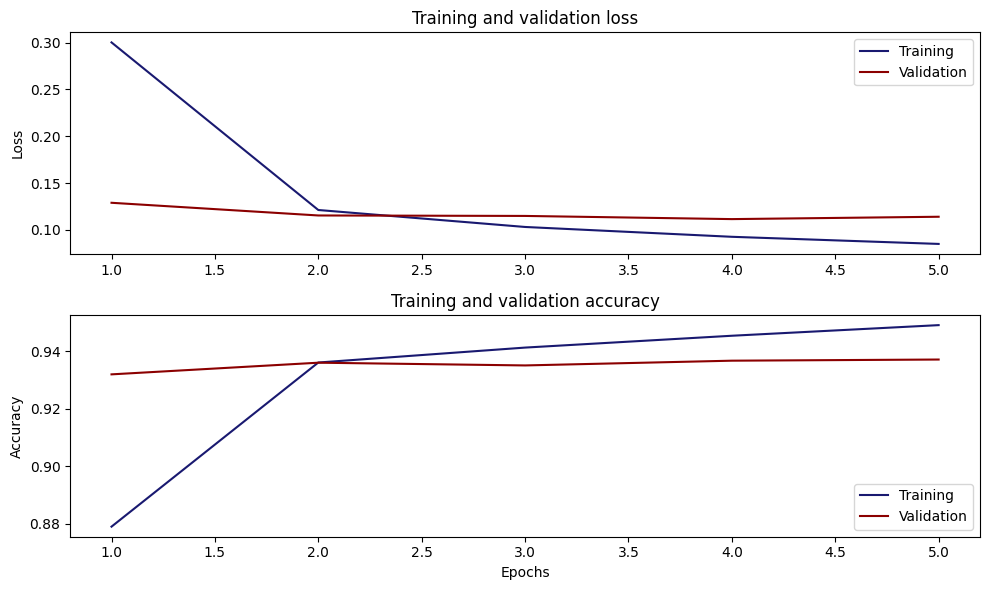

In [12]:
history_dict = history.history
# print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'midnightblue', label='Training')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'darkred', label='Validation')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'midnightblue', label='Training')
plt.plot(epochs, val_acc, 'darkred', label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

fig.tight_layout()
fig.savefig("bert_training_validation.png")

In [13]:
# predictions = np.argmax(model.predict(test_input), axis= 1)

# label_inv_map = {v:k for k,v in label_map.items()}
# print(classification_report(y_test.map(label_inv_map),pd.Series(predictions).map(label_inv_map)))